# Statistical Arbitrage on L/T Valuation Mispricing with Dynamic Liquidation Rules

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import pyfolio as pf
from talib import ATR
from talib import TSF
import optuna
import matplotlib.pyplot as plt
from pyfolio import timeseries as pf

from numpy import *
from numpy.linalg import multi_dot

# Import cufflinks
import cufflinks as cf
cf.set_config_file(offline=True, dimensions=((1000,600))) # theme= 'henanigans'

# Import plotly express for EF plot
import plotly.express as px
# px.defaults.template = "plotly_dark"
px.defaults.width, px.defaults.height = 1000, 600

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

ticker = "^KLSE"

start1 = "2018-07-01"
end1 = "2022-12-31"

start2 = "2022-07-01"
end2 = "2023-12-31"

# Single Stock Before Optimizating Parameters

[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close  Adj Close     Volume  \
Date                                                                   
2018-07-02  1694.93  1697.15  1677.33  1685.05    1685.05  1.116e+08   
2018-07-03  1684.73  1689.91  1674.11  1680.37    1680.37  1.169e+08   
2018-07-04  1682.96  1690.56  1680.61  1688.45    1688.45  1.143e+08   
2018-07-05  1690.22  1691.62  1682.35  1690.65    1690.65  7.977e+07   
2018-07-06  1694.52  1694.81  1663.86  1663.86    1663.86  1.325e+08   
...             ...      ...      ...      ...        ...        ...   
2022-12-23  1469.16  1474.87  1460.57  1474.68    1474.68  4.829e+07   
2022-12-27  1474.39  1477.43  1468.15  1474.69    1474.69  1.144e+08   
2022-12-28  1473.55  1480.11  1461.18  1480.11    1480.11  1.347e+08   
2022-12-29  1476.27  1491.63  1472.54  1491.63    1491.63  1.076e+08   
2022-12-30  1491.93  1503.33  1479.13  1495.49    1495.49  2.429e+0

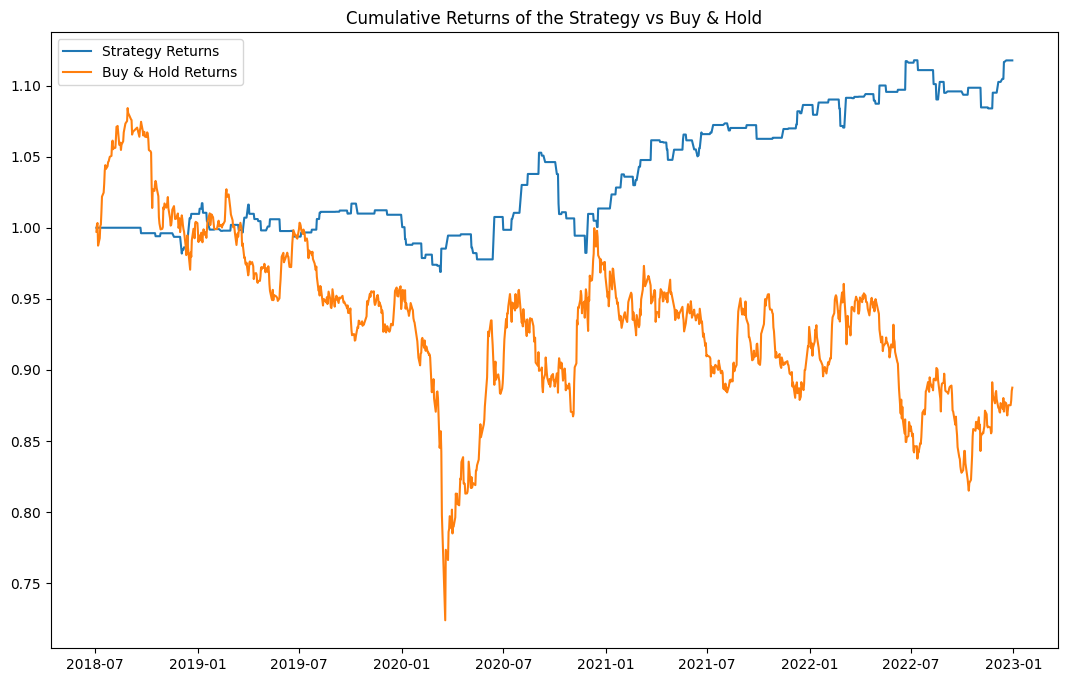

In [7]:
# Define a function to calculate the Z-Score
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df

def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df

df = yf.download(ticker, start=start1, end=end1)
df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
df["Close"] = df["Adj Close"] / df["Close"] * df["Close"]

df = df[df['Volume'] != 0]
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Calculate the SMA
df["SMA"] = df["Close"].rolling(window=33).mean()

# Calculate the TSF
df["TSF"] = TSF(df["Close"].values, timeperiod=33)

# Calculate the premium/discount
df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

# Calculate Pct of MisPricing
df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

# Calculate Z-Score
df = Z_Score(df, window=13)

# Calculate ZScore
df = ZScore(df, window=13)

# Define buy and sell zones
buyZScoreTH = 1.65
sellZScoreTH = 1.65

buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

# Generate trading signals
df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
df["Signal"] = df["BuySignal"] + df["SellSignal"]

# Calculate the ATR
df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=13)

# Define SL and TP multipliers
SL_multiplier = 1
TP_multiplier = 3

# Initialize SL and TP levels to NaN
df["SL"] = np.nan
df["TP"] = np.nan

# Define initial capital
capital = 10000

# Calculate the number of shares to buy
df["Shares"] = capital // (df["ATR"] * 100)

# Create a variable to hold the entry price
entry_price = 0

# Define SL and TP levels based on entry price
for i in range(len(df)):
    if df["Signal"].iloc[i] == 1:
        entry_price = df["Close"].iloc[i]
        df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
        df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
    elif df["Signal"].iloc[i] == -1:
        entry_price = 0
        df["SL"].iloc[i] = np.nan
        df["TP"].iloc[i] = np.nan
    else:
        df["SL"].iloc[i] = df["SL"].iloc[i-1]
        df["TP"].iloc[i] = df["TP"].iloc[i-1]

# Fill in the rest of SL and TP columns
df["SL"].fillna(method='ffill', inplace=True)
df["TP"].fillna(method='ffill', inplace=True)

# Calculate daily returns based on trading signals
df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

# Calculate Buy-and-Hold Returns
df["B&H_Returns"] = df["Close"].pct_change()

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate buy-and-hold cumulative returns
df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

# Print the DataFrame
print(df)

# Plot cumulative returns
plt.figure(figsize=(13,8))

# Plot the strategy's cumulative returns
plt.plot(df['cumulative_returns'], label='Strategy Returns')

# Plot the buy-and-hold cumulative returns
plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
plt.legend(loc='best')
plt.show()

# Single Stock Optimization 

In [8]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    # Define the hyperparameters
    sma_window = trial.suggest_int('sma_window', 33, 233)
    zscore_window = trial.suggest_int('zscore_window', 3, 33)
    buyZScoreTH = trial.suggest_float('buyZScoreTH', 1.0, 3.0)
    sellZScoreTH = trial.suggest_float('sellZScoreTH', 1.0, 3.0)
    SL_multiplier = trial.suggest_float('SL_multiplier', 0.5, 2.0)
    TP_multiplier = trial.suggest_float('TP_multiplier', 1.0, 5.0)
    ATR_window = trial.suggest_int('ATR_window', 3, 13)

    # Fetch the data
    df = yf.download('^KLSE', start=start1, end=end2)

    # Calculate the SMA
    df["SMA"] = df["Close"].rolling(window=sma_window).mean()
    
    # Calculate the TSF
    df["TSF"] = TSF(df["Close"].values, timeperiod=sma_window)

    # Calculate the premium/discount
    df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100
    
    # Calculate Pct of MisPricing
    df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

    # Calculate Z-Score
    df = Z_Score(df, window=zscore_window)
    
    # Calculate ZScore
    df = ZScore(df, window=zscore_window)

    buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
    prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
    sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
    presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
    sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

    df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
    df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
    df["Signal"] = df["BuySignal"] + df["SellSignal"]

    df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=ATR_window)

    df["SL"] = np.nan
    df["TP"] = np.nan

    capital = 10000
    df["Shares"] = capital // (df["ATR"] * 100)

    entry_price = 0

    for i in range(len(df)):
        if df["Signal"].iloc[i] == 1:
            entry_price = df["Close"].iloc[i]
            df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
            df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
        elif df["Signal"].iloc[i] == -1:
            entry_price = 0
            df["SL"].iloc[i] = np.nan
            df["TP"].iloc[i] = np.nan
        else:
            df["SL"].iloc[i] = df["SL"].iloc[i-1]
            df["TP"].iloc[i] = df["TP"].iloc[i-1]

    df["SL"].fillna(method='ffill', inplace=True)
    df["TP"].fillna(method='ffill', inplace=True)

    df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

    df['cumulative_returns'] = (1 + df['returns']).cumprod()

    return df['returns'].mean()

# Define the study and run the optimization
sampler = TPESampler(seed=13)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=108)

# Print the best parameters
best_params = study.best_params
print("Best parameters: ", best_params)

# Print the best value (i.e., the return)
best_value = study.best_value
print("Best value (return): ", best_value)

best_params = study.best_params

best_sma_window = best_params['sma_window']
best_zscore_window = best_params['zscore_window']
best_buyZScoreTH = best_params['buyZScoreTH']
best_sellZScoreTH = best_params['sellZScoreTH']
best_SL_multiplier = best_params['SL_multiplier']
best_TP_multiplier = best_params['TP_multiplier']
best_ATR_window = best_params['ATR_window']

print(f"Best SMA Window: {best_sma_window}")
print(f"Best Z-Score Window: {best_zscore_window}")
print(f"Best Buy Z-Score Threshold: {best_buyZScoreTH}")
print(f"Best Sell Z-Score Threshold: {best_sellZScoreTH}")
print(f"Best Stop Loss Multiplier: {best_SL_multiplier}")
print(f"Best Take Profit Multiplier: {best_TP_multiplier}")
print(f"Best ATR Window: {best_ATR_window}")

[I 2023-08-02 14:59:42,422] A new study created in memory with name: no-name-cc63add0-271b-46cf-9203-cfbacabab5e1


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:43,071] Trial 0 finished with value: 9.916122273677128e-06 and parameters: {'sma_window': 189, 'zscore_window': 10, 'buyZScoreTH': 2.648557065322737, 'sellZScoreTH': 2.9314983960859995, 'SL_multiplier': 1.95890167085734, 'TP_multiplier': 2.8137969896692487, 'ATR_window': 9}. Best is trial 0 with value: 9.916122273677128e-06.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:43,738] Trial 1 finished with value: 3.614135675236537e-05 and parameters: {'sma_window': 188, 'zscore_window': 22, 'buyZScoreTH': 2.444036459033894, 'sellZScoreTH': 1.0700730482028746, 'SL_multiplier': 0.9476742063337691, 'TP_multiplier': 1.234049967528299, 'ATR_window': 12}. Best is trial 1 with value: 3.614135675236537e-05.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:44,411] Trial 2 finished with value: 6.151130496919744e-05 and parameters: {'sma_window': 107, 'zscore_window': 24, 'buyZScoreTH': 1.5125598986532602, 'sellZScoreTH': 1.695162430304984, 'SL_multiplier': 0.5141191551214541, 'TP_multiplier': 2.433335130819879, 'ATR_window': 13}. Best is trial 2 with value: 6.151130496919744e-05.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:44,973] Trial 3 finished with value: 3.6101666603760904e-05 and parameters: {'sma_window': 76, 'zscore_window': 12, 'buyZScoreTH': 2.8355447720011746, 'sellZScoreTH': 1.0638073328797895, 'SL_multiplier': 0.5976268055637717, 'TP_multiplier': 3.519315996431292, 'ATR_window': 12}. Best is trial 2 with value: 6.151130496919744e-05.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:45,577] Trial 4 finished with value: 1.9444294344365593e-06 and parameters: {'sma_window': 34, 'zscore_window': 26, 'buyZScoreTH': 2.6256823420052466, 'sellZScoreTH': 1.1514348923445334, 'SL_multiplier': 1.4846830018954367, 'TP_multiplier': 3.0370488003340728, 'ATR_window': 8}. Best is trial 2 with value: 6.151130496919744e-05.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:46,144] Trial 5 finished with value: 0.00033997270320109394 and parameters: {'sma_window': 225, 'zscore_window': 3, 'buyZScoreTH': 1.4939574019838326, 'sellZScoreTH': 2.424465355823167, 'SL_multiplier': 0.9868730746800697, 'TP_multiplier': 2.107985425535238, 'ATR_window': 10}. Best is trial 5 with value: 0.00033997270320109394.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:46,733] Trial 6 finished with value: -5.0619051581335114e-05 and parameters: {'sma_window': 217, 'zscore_window': 10, 'buyZScoreTH': 1.9161716345535273, 'sellZScoreTH': 1.5059853656430129, 'SL_multiplier': 1.0689999372245993, 'TP_multiplier': 3.418155314526844, 'ATR_window': 11}. Best is trial 5 with value: 0.00033997270320109394.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:47,286] Trial 7 finished with value: -0.00011029102061718861 and parameters: {'sma_window': 46, 'zscore_window': 24, 'buyZScoreTH': 2.0965201947916503, 'sellZScoreTH': 1.2759721055165145, 'SL_multiplier': 0.6481298288073776, 'TP_multiplier': 1.9822364212986225, 'ATR_window': 4}. Best is trial 5 with value: 0.00033997270320109394.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:47,831] Trial 8 finished with value: 3.964677273016193e-05 and parameters: {'sma_window': 219, 'zscore_window': 24, 'buyZScoreTH': 1.4753178437593666, 'sellZScoreTH': 2.137770505113121, 'SL_multiplier': 1.334948077151604, 'TP_multiplier': 1.2909488435373913, 'ATR_window': 12}. Best is trial 5 with value: 0.00033997270320109394.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:48,366] Trial 9 finished with value: 9.469939687323773e-05 and parameters: {'sma_window': 114, 'zscore_window': 7, 'buyZScoreTH': 1.3818401173331873, 'sellZScoreTH': 1.9812802741303217, 'SL_multiplier': 1.5680365613746299, 'TP_multiplier': 4.939753830804032, 'ATR_window': 12}. Best is trial 5 with value: 0.00033997270320109394.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:48,931] Trial 10 finished with value: 2.9113380250932034e-06 and parameters: {'sma_window': 158, 'zscore_window': 32, 'buyZScoreTH': 1.028613794264408, 'sellZScoreTH': 2.533217033908528, 'SL_multiplier': 0.8946592092713535, 'TP_multiplier': 1.967126164677175, 'ATR_window': 6}. Best is trial 5 with value: 0.00033997270320109394.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:49,471] Trial 11 finished with value: 0.00036564547984649 and parameters: {'sma_window': 123, 'zscore_window': 3, 'buyZScoreTH': 1.3204529590709626, 'sellZScoreTH': 2.1374736344387735, 'SL_multiplier': 1.5726961883837378, 'TP_multiplier': 4.714808365612312, 'ATR_window': 9}. Best is trial 11 with value: 0.00036564547984649.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:50,055] Trial 12 finished with value: 0.0002913088071520584 and parameters: {'sma_window': 148, 'zscore_window': 4, 'buyZScoreTH': 1.0633660946763939, 'sellZScoreTH': 2.3124213243672935, 'SL_multiplier': 1.2786926751043552, 'TP_multiplier': 4.829288990066538, 'ATR_window': 9}. Best is trial 11 with value: 0.00036564547984649.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:50,645] Trial 13 finished with value: 0.00038115441471053726 and parameters: {'sma_window': 121, 'zscore_window': 3, 'buyZScoreTH': 1.7075236528403592, 'sellZScoreTH': 2.540657677624255, 'SL_multiplier': 1.6922047688313813, 'TP_multiplier': 4.14961729743993, 'ATR_window': 7}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:51,238] Trial 14 finished with value: -3.4931671593360224e-05 and parameters: {'sma_window': 90, 'zscore_window': 15, 'buyZScoreTH': 1.813264278980036, 'sellZScoreTH': 2.6914367603804545, 'SL_multiplier': 1.7587732626220647, 'TP_multiplier': 4.405975947210734, 'ATR_window': 7}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:51,820] Trial 15 finished with value: -1.284354929179251e-05 and parameters: {'sma_window': 133, 'zscore_window': 17, 'buyZScoreTH': 1.74860645291192, 'sellZScoreTH': 1.957028468250934, 'SL_multiplier': 1.687782922583128, 'TP_multiplier': 4.209574081249022, 'ATR_window': 5}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:52,382] Trial 16 finished with value: 0.00022028749288987128 and parameters: {'sma_window': 78, 'zscore_window': 6, 'buyZScoreTH': 2.1658766595040237, 'sellZScoreTH': 2.2117673500668587, 'SL_multiplier': 1.90217280391819, 'TP_multiplier': 4.029502126764325, 'ATR_window': 7}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:52,971] Trial 17 finished with value: 8.71968118103669e-05 and parameters: {'sma_window': 132, 'zscore_window': 8, 'buyZScoreTH': 1.260722485974119, 'sellZScoreTH': 2.608470209665496, 'SL_multiplier': 1.5095995729662905, 'TP_multiplier': 4.448478356096604, 'ATR_window': 3}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:53,687] Trial 18 finished with value: -6.282778452243915e-05 and parameters: {'sma_window': 163, 'zscore_window': 14, 'buyZScoreTH': 1.7193118299647498, 'sellZScoreTH': 2.8321715754266865, 'SL_multiplier': 1.742977666884783, 'TP_multiplier': 3.9513155648153884, 'ATR_window': 8}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:54,254] Trial 19 finished with value: 0.0003726486033382571 and parameters: {'sma_window': 108, 'zscore_window': 3, 'buyZScoreTH': 1.6927263954432816, 'sellZScoreTH': 2.4263137058265363, 'SL_multiplier': 1.3978273623688589, 'TP_multiplier': 4.989169005905333, 'ATR_window': 6}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:54,895] Trial 20 finished with value: 9.950399638879958e-06 and parameters: {'sma_window': 96, 'zscore_window': 32, 'buyZScoreTH': 2.0136618840022846, 'sellZScoreTH': 2.7764421877795904, 'SL_multiplier': 1.170412812185198, 'TP_multiplier': 4.678804438125658, 'ATR_window': 5}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:55,552] Trial 21 finished with value: 0.0003728726660867365 and parameters: {'sma_window': 120, 'zscore_window': 3, 'buyZScoreTH': 1.602713569464454, 'sellZScoreTH': 2.4537152056332587, 'SL_multiplier': 1.4062406893493584, 'TP_multiplier': 4.989811322191061, 'ATR_window': 6}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:56,199] Trial 22 finished with value: 0.00010669597098080106 and parameters: {'sma_window': 147, 'zscore_window': 6, 'buyZScoreTH': 1.643422287217325, 'sellZScoreTH': 2.4599849993645835, 'SL_multiplier': 1.3860264986073398, 'TP_multiplier': 4.492546038466645, 'ATR_window': 6}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:56,867] Trial 23 finished with value: 9.893028228568367e-05 and parameters: {'sma_window': 67, 'zscore_window': 10, 'buyZScoreTH': 1.660123016765866, 'sellZScoreTH': 2.562052992257061, 'SL_multiplier': 1.4490243919918147, 'TP_multiplier': 4.961485866025258, 'ATR_window': 6}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:57,469] Trial 24 finished with value: 0.00011200620110868976 and parameters: {'sma_window': 103, 'zscore_window': 5, 'buyZScoreTH': 1.8344738729175079, 'sellZScoreTH': 2.9724487669233266, 'SL_multiplier': 1.216254211198385, 'TP_multiplier': 4.961628483642244, 'ATR_window': 4}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:58,077] Trial 25 finished with value: 0.00010076625372843486 and parameters: {'sma_window': 127, 'zscore_window': 8, 'buyZScoreTH': 1.9287475574123971, 'sellZScoreTH': 2.3175319454571737, 'SL_multiplier': 1.3977097114200046, 'TP_multiplier': 4.18936099276828, 'ATR_window': 7}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:58,677] Trial 26 finished with value: 0.0003787772164586851 and parameters: {'sma_window': 171, 'zscore_window': 3, 'buyZScoreTH': 1.6414452729639568, 'sellZScoreTH': 2.7109721677945355, 'SL_multiplier': 1.6370975335870013, 'TP_multiplier': 4.6405335534413465, 'ATR_window': 4}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:59,254] Trial 27 finished with value: 1.1444437541919736e-06 and parameters: {'sma_window': 197, 'zscore_window': 19, 'buyZScoreTH': 1.5426291320480678, 'sellZScoreTH': 2.709738159397427, 'SL_multiplier': 1.621064921801533, 'TP_multiplier': 3.805576850954883, 'ATR_window': 3}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 14:59:59,886] Trial 28 finished with value: -2.8507222236624957e-06 and parameters: {'sma_window': 174, 'zscore_window': 12, 'buyZScoreTH': 1.2275233746247904, 'sellZScoreTH': 2.827242659484744, 'SL_multiplier': 1.8293564494856436, 'TP_multiplier': 4.508198613035453, 'ATR_window': 4}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:00,563] Trial 29 finished with value: 0.00011331540063860139 and parameters: {'sma_window': 182, 'zscore_window': 8, 'buyZScoreTH': 2.228164739807818, 'sellZScoreTH': 2.9712599734598104, 'SL_multiplier': 1.9059364184603647, 'TP_multiplier': 4.286352545778287, 'ATR_window': 5}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:01,191] Trial 30 finished with value: -4.1363946393777036e-05 and parameters: {'sma_window': 203, 'zscore_window': 12, 'buyZScoreTH': 1.598500469856541, 'sellZScoreTH': 2.647983117793895, 'SL_multiplier': 1.6419523248441403, 'TP_multiplier': 4.6450909760840275, 'ATR_window': 8}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:01,843] Trial 31 finished with value: 0.0003628976756840955 and parameters: {'sma_window': 147, 'zscore_window': 3, 'buyZScoreTH': 1.7533502380269683, 'sellZScoreTH': 2.445273282282163, 'SL_multiplier': 1.5355729621567031, 'TP_multiplier': 4.685654601305343, 'ATR_window': 6}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:02,426] Trial 32 finished with value: 7.57670293488112e-05 and parameters: {'sma_window': 115, 'zscore_window': 5, 'buyZScoreTH': 1.6406181700044558, 'sellZScoreTH': 2.8314375142298256, 'SL_multiplier': 1.4418460559634734, 'TP_multiplier': 4.915792554759387, 'ATR_window': 5}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:03,024] Trial 33 finished with value: 0.000123465297173715 and parameters: {'sma_window': 167, 'zscore_window': 5, 'buyZScoreTH': 1.4224054867823566, 'sellZScoreTH': 2.5829352785286326, 'SL_multiplier': 1.696799350648066, 'TP_multiplier': 4.993123468510277, 'ATR_window': 7}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:03,624] Trial 34 finished with value: 0.00011673128161880028 and parameters: {'sma_window': 93, 'zscore_window': 10, 'buyZScoreTH': 1.872048532235395, 'sellZScoreTH': 2.364019190652902, 'SL_multiplier': 1.6011299963233814, 'TP_multiplier': 4.5637915792640635, 'ATR_window': 4}. Best is trial 13 with value: 0.00038115441471053726.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:04,230] Trial 35 finished with value: 0.0003853379258556325 and parameters: {'sma_window': 140, 'zscore_window': 3, 'buyZScoreTH': 1.599205266433619, 'sellZScoreTH': 2.5206678763701063, 'SL_multiplier': 1.9724102030421569, 'TP_multiplier': 4.214714961473676, 'ATR_window': 6}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:04,808] Trial 36 finished with value: 2.1194761624866237e-05 and parameters: {'sma_window': 141, 'zscore_window': 29, 'buyZScoreTH': 1.529581609311383, 'sellZScoreTH': 2.5312014760476518, 'SL_multiplier': 1.9937103781542618, 'TP_multiplier': 3.742387714466885, 'ATR_window': 8}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:05,440] Trial 37 finished with value: 1.4840356662082875e-05 and parameters: {'sma_window': 156, 'zscore_window': 7, 'buyZScoreTH': 1.5700088483574581, 'sellZScoreTH': 2.706078270752161, 'SL_multiplier': 1.8350798018865377, 'TP_multiplier': 4.145459850671345, 'ATR_window': 3}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:06,057] Trial 38 finished with value: 4.150597916928806e-05 and parameters: {'sma_window': 176, 'zscore_window': 21, 'buyZScoreTH': 1.4174405859414436, 'sellZScoreTH': 2.880330031024658, 'SL_multiplier': 1.9549847642825255, 'TP_multiplier': 4.328411899793805, 'ATR_window': 10}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:06,734] Trial 39 finished with value: 5.152669130088328e-05 and parameters: {'sma_window': 123, 'zscore_window': 9, 'buyZScoreTH': 2.018724529582935, 'sellZScoreTH': 2.7294694383524067, 'SL_multiplier': 1.7933232832927635, 'TP_multiplier': 3.3993012124318547, 'ATR_window': 5}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:07,387] Trial 40 finished with value: 0.0001805086608071372 and parameters: {'sma_window': 189, 'zscore_window': 5, 'buyZScoreTH': 1.7916105704280374, 'sellZScoreTH': 2.621771091165615, 'SL_multiplier': 1.6990661888157295, 'TP_multiplier': 4.068688854905695, 'ATR_window': 7}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:07,960] Trial 41 finished with value: 0.00036364545845973123 and parameters: {'sma_window': 110, 'zscore_window': 3, 'buyZScoreTH': 1.6711308700115732, 'sellZScoreTH': 2.470088066170781, 'SL_multiplier': 1.4980986738507385, 'TP_multiplier': 4.733790487237135, 'ATR_window': 6}. Best is trial 35 with value: 0.0003853379258556325.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:08,525] Trial 42 finished with value: 0.0004248844177974215 and parameters: {'sma_window': 138, 'zscore_window': 3, 'buyZScoreTH': 1.552897470733629, 'sellZScoreTH': 2.394642021469058, 'SL_multiplier': 1.3406206695977305, 'TP_multiplier': 4.446332125490659, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:09,122] Trial 43 finished with value: 0.00010858902073577246 and parameters: {'sma_window': 142, 'zscore_window': 6, 'buyZScoreTH': 1.4909397804179012, 'sellZScoreTH': 2.5390249721888214, 'SL_multiplier': 1.3255589837877313, 'TP_multiplier': 4.361136608475639, 'ATR_window': 8}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:09,680] Trial 44 finished with value: 0.00023697936283576272 and parameters: {'sma_window': 136, 'zscore_window': 4, 'buyZScoreTH': 1.5643641472499337, 'sellZScoreTH': 2.357192292892372, 'SL_multiplier': 1.5335747302828433, 'TP_multiplier': 4.551101150166553, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:10,263] Trial 45 finished with value: 0.000276535167990071 and parameters: {'sma_window': 120, 'zscore_window': 4, 'buyZScoreTH': 1.3450879350065954, 'sellZScoreTH': 2.270016170410858, 'SL_multiplier': 1.636782888065213, 'TP_multiplier': 4.744015056969315, 'ATR_window': 4}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:10,831] Trial 46 finished with value: 2.776996412219401e-05 and parameters: {'sma_window': 157, 'zscore_window': 7, 'buyZScoreTH': 1.471145628121912, 'sellZScoreTH': 2.662304569367239, 'SL_multiplier': 1.8608911867073994, 'TP_multiplier': 4.230615183962794, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:11,410] Trial 47 finished with value: 0.0003872617765185342 and parameters: {'sma_window': 168, 'zscore_window': 3, 'buyZScoreTH': 1.8922231152113118, 'sellZScoreTH': 2.162723611716271, 'SL_multiplier': 1.767494034227048, 'TP_multiplier': 3.9110084360602517, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:12,033] Trial 48 finished with value: 0.0001501796205390809 and parameters: {'sma_window': 209, 'zscore_window': 6, 'buyZScoreTH': 1.9416813106741324, 'sellZScoreTH': 2.085131900805328, 'SL_multiplier': 1.7805378386091015, 'TP_multiplier': 3.9101161136534186, 'ATR_window': 9}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:12,642] Trial 49 finished with value: -4.002409994144825e-05 and parameters: {'sma_window': 170, 'zscore_window': 12, 'buyZScoreTH': 1.8047165259256537, 'sellZScoreTH': 2.234313360259742, 'SL_multiplier': 1.9186116726565967, 'TP_multiplier': 3.5800409052755438, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:13,286] Trial 50 finished with value: 0.0002879141519221256 and parameters: {'sma_window': 185, 'zscore_window': 4, 'buyZScoreTH': 1.7431688677250756, 'sellZScoreTH': 1.9039430887790132, 'SL_multiplier': 1.9847940684142285, 'TP_multiplier': 4.053489885214641, 'ATR_window': 10}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:13,897] Trial 51 finished with value: 0.00040000537944674084 and parameters: {'sma_window': 132, 'zscore_window': 3, 'buyZScoreTH': 1.8556951542693452, 'sellZScoreTH': 2.380299189380767, 'SL_multiplier': 1.7108928654360411, 'TP_multiplier': 4.401290680408453, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:14,586] Trial 52 finished with value: 0.00031469395786290065 and parameters: {'sma_window': 153, 'zscore_window': 4, 'buyZScoreTH': 1.828563491562973, 'sellZScoreTH': 2.3488084443786996, 'SL_multiplier': 1.7108358689621639, 'TP_multiplier': 4.370389865395115, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:15,213] Trial 53 finished with value: 0.0003833510829381643 and parameters: {'sma_window': 131, 'zscore_window': 3, 'buyZScoreTH': 1.9083432708246086, 'sellZScoreTH': 2.2141093588946616, 'SL_multiplier': 1.7688012202569898, 'TP_multiplier': 3.925985100121646, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:15,967] Trial 54 finished with value: 5.518959461973615e-05 and parameters: {'sma_window': 133, 'zscore_window': 7, 'buyZScoreTH': 1.889476578438862, 'sellZScoreTH': 2.1713396879535933, 'SL_multiplier': 1.8650852715822381, 'TP_multiplier': 3.894065801797681, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:16,651] Trial 55 finished with value: 0.00011763694441721873 and parameters: {'sma_window': 128, 'zscore_window': 5, 'buyZScoreTH': 2.0985230844935447, 'sellZScoreTH': 2.243250935977512, 'SL_multiplier': 1.7552365730530468, 'TP_multiplier': 4.118219159737887, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:17,279] Trial 56 finished with value: 3.0070716470289447e-05 and parameters: {'sma_window': 100, 'zscore_window': 26, 'buyZScoreTH': 1.7504752472041534, 'sellZScoreTH': 2.075934497130599, 'SL_multiplier': 1.9163994457213873, 'TP_multiplier': 3.724249547411424, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:17,863] Trial 57 finished with value: 2.8095475962251733e-05 and parameters: {'sma_window': 140, 'zscore_window': 9, 'buyZScoreTH': 1.9572007531451292, 'sellZScoreTH': 2.3056907049871795, 'SL_multiplier': 1.8024339502319788, 'TP_multiplier': 3.9817615517851546, 'ATR_window': 13}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:18,516] Trial 58 finished with value: 0.000220348862178278 and parameters: {'sma_window': 84, 'zscore_window': 6, 'buyZScoreTH': 1.8532941142814119, 'sellZScoreTH': 2.202475233859847, 'SL_multiplier': 1.7284233757292753, 'TP_multiplier': 4.415291771686621, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:19,115] Trial 59 finished with value: 0.0002811446689153085 and parameters: {'sma_window': 115, 'zscore_window': 4, 'buyZScoreTH': 1.7028056861437426, 'sellZScoreTH': 2.3857730566018205, 'SL_multiplier': 1.8600959098967274, 'TP_multiplier': 4.232291955114717, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:19,737] Trial 60 finished with value: 0.00033159228774625387 and parameters: {'sma_window': 163, 'zscore_window': 3, 'buyZScoreTH': 1.9856380275863437, 'sellZScoreTH': 2.2826685333644345, 'SL_multiplier': 1.8158893684029431, 'TP_multiplier': 3.613022741908401, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:20,322] Trial 61 finished with value: 0.0003603098405353409 and parameters: {'sma_window': 148, 'zscore_window': 3, 'buyZScoreTH': 1.6884424522923132, 'sellZScoreTH': 2.4092657112504408, 'SL_multiplier': 1.6432315553483483, 'TP_multiplier': 4.47100733275321, 'ATR_window': 4}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:20,940] Trial 62 finished with value: 7.76831956660118e-05 and parameters: {'sma_window': 131, 'zscore_window': 5, 'buyZScoreTH': 1.5908380419995827, 'sellZScoreTH': 2.5050872874265173, 'SL_multiplier': 1.5627024744925964, 'TP_multiplier': 4.278985243702391, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:21,518] Trial 63 finished with value: 0.000328975253407135 and parameters: {'sma_window': 152, 'zscore_window': 3, 'buyZScoreTH': 1.8825817911262517, 'sellZScoreTH': 2.5956446547161964, 'SL_multiplier': 1.658539431448839, 'TP_multiplier': 4.602428477845051, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:22,135] Trial 64 finished with value: 0.00030981057291470194 and parameters: {'sma_window': 162, 'zscore_window': 4, 'buyZScoreTH': 1.6335097266447685, 'sellZScoreTH': 2.4938499267708916, 'SL_multiplier': 1.753029459500036, 'TP_multiplier': 4.764648978842435, 'ATR_window': 8}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:22,717] Trial 65 finished with value: 0.00011536918431174691 and parameters: {'sma_window': 179, 'zscore_window': 8, 'buyZScoreTH': 1.8004631254994061, 'sellZScoreTH': 2.4087799661092397, 'SL_multiplier': 1.6022696071280822, 'TP_multiplier': 4.095988165168368, 'ATR_window': 4}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:23,287] Trial 66 finished with value: 0.00012353324337843977 and parameters: {'sma_window': 196, 'zscore_window': 6, 'buyZScoreTH': 1.7618122843391284, 'sellZScoreTH': 2.5889591278475077, 'SL_multiplier': 1.6739883262307504, 'TP_multiplier': 3.953404200951363, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:23,844] Trial 67 finished with value: 0.00027304118001540565 and parameters: {'sma_window': 126, 'zscore_window': 4, 'buyZScoreTH': 1.7013042695575786, 'sellZScoreTH': 2.32658748836916, 'SL_multiplier': 1.5777631350481587, 'TP_multiplier': 4.44473615281553, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:24,453] Trial 68 finished with value: 2.279348551646905e-05 and parameters: {'sma_window': 137, 'zscore_window': 7, 'buyZScoreTH': 1.488077343690349, 'sellZScoreTH': 2.4791382199463134, 'SL_multiplier': 1.7359767509814081, 'TP_multiplier': 4.835944882551539, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:25,041] Trial 69 finished with value: -1.5100977038784919e-05 and parameters: {'sma_window': 144, 'zscore_window': 15, 'buyZScoreTH': 1.9139977115763545, 'sellZScoreTH': 2.6413123750275753, 'SL_multiplier': 1.775701407484997, 'TP_multiplier': 4.191068071440273, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:25,635] Trial 70 finished with value: 0.00035238881051586853 and parameters: {'sma_window': 105, 'zscore_window': 3, 'buyZScoreTH': 1.6192797213910577, 'sellZScoreTH': 2.5391173479094142, 'SL_multiplier': 1.6965967889787128, 'TP_multiplier': 4.632433966995257, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:26,282] Trial 71 finished with value: 5.620236908276051e-05 and parameters: {'sma_window': 110, 'zscore_window': 5, 'buyZScoreTH': 1.5431523470397224, 'sellZScoreTH': 2.449667236449864, 'SL_multiplier': 1.4736684057466296, 'TP_multiplier': 4.568464286146619, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:26,983] Trial 72 finished with value: 0.0003729893147880279 and parameters: {'sma_window': 120, 'zscore_window': 3, 'buyZScoreTH': 1.6354774153654823, 'sellZScoreTH': 2.4156742432100797, 'SL_multiplier': 1.539272956656681, 'TP_multiplier': 4.845508947873759, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:27,630] Trial 73 finished with value: 0.00038241095546198413 and parameters: {'sma_window': 118, 'zscore_window': 3, 'buyZScoreTH': 1.6700240384088185, 'sellZScoreTH': 2.3895697345559626, 'SL_multiplier': 1.6095595716536606, 'TP_multiplier': 4.371014186867978, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:28,248] Trial 74 finished with value: 0.00024753529127628863 and parameters: {'sma_window': 62, 'zscore_window': 5, 'buyZScoreTH': 1.7162367582320401, 'sellZScoreTH': 2.2522324884553337, 'SL_multiplier': 1.657243057805063, 'TP_multiplier': 4.306867700541873, 'ATR_window': 8}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:28,832] Trial 75 finished with value: 0.0002909719399729111 and parameters: {'sma_window': 170, 'zscore_window': 4, 'buyZScoreTH': 1.8597670995317257, 'sellZScoreTH': 2.362106039121115, 'SL_multiplier': 1.614956355895257, 'TP_multiplier': 4.4206303542883, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:29,472] Trial 76 finished with value: 0.00010869523617867287 and parameters: {'sma_window': 137, 'zscore_window': 6, 'buyZScoreTH': 1.7959198712685112, 'sellZScoreTH': 2.164492372926596, 'SL_multiplier': 1.8181512493163288, 'TP_multiplier': 4.1000371030441904, 'ATR_window': 3}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:30,050] Trial 77 finished with value: 0.0003628127702769203 and parameters: {'sma_window': 114, 'zscore_window': 3, 'buyZScoreTH': 2.0327867599972542, 'sellZScoreTH': 2.7519288321402353, 'SL_multiplier': 1.7200502667271251, 'TP_multiplier': 4.5151887708419185, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:30,632] Trial 78 finished with value: 4.266648821907606e-05 and parameters: {'sma_window': 99, 'zscore_window': 9, 'buyZScoreTH': 1.5887319552102974, 'sellZScoreTH': 2.6664103093317046, 'SL_multiplier': 1.9504377381525289, 'TP_multiplier': 4.263236456267652, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:31,245] Trial 79 finished with value: 8.786737783756904e-05 and parameters: {'sma_window': 227, 'zscore_window': 5, 'buyZScoreTH': 1.6749728704480444, 'sellZScoreTH': 2.5530248553937867, 'SL_multiplier': 1.8748241393587148, 'TP_multiplier': 4.016169018241514, 'ATR_window': 4}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:31,865] Trial 80 finished with value: -1.6952429764970115e-05 and parameters: {'sma_window': 125, 'zscore_window': 30, 'buyZScoreTH': 1.4368225044324852, 'sellZScoreTH': 2.300803185207987, 'SL_multiplier': 1.6786084053017685, 'TP_multiplier': 3.869230169858468, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:32,453] Trial 81 finished with value: 0.0003821832837666688 and parameters: {'sma_window': 118, 'zscore_window': 3, 'buyZScoreTH': 1.634745896056465, 'sellZScoreTH': 2.406570681969115, 'SL_multiplier': 1.5330710779024117, 'TP_multiplier': 4.867335017373602, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:33,110] Trial 82 finished with value: 0.00026729123083373235 and parameters: {'sma_window': 119, 'zscore_window': 4, 'buyZScoreTH': 1.5529547276279176, 'sellZScoreTH': 2.500692673470287, 'SL_multiplier': 1.5927337541325237, 'TP_multiplier': 4.673529259730141, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:33,691] Trial 83 finished with value: 0.00034999113907060276 and parameters: {'sma_window': 130, 'zscore_window': 3, 'buyZScoreTH': 1.5207470757622863, 'sellZScoreTH': 2.404240066296669, 'SL_multiplier': 1.780239430981524, 'TP_multiplier': 4.375335506275507, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:34,371] Trial 84 finished with value: 7.629139194036535e-05 and parameters: {'sma_window': 151, 'zscore_window': 6, 'buyZScoreTH': 1.7457997541737553, 'sellZScoreTH': 2.3328623519082297, 'SL_multiplier': 1.4871317841338907, 'TP_multiplier': 4.177672435512721, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:35,057] Trial 85 finished with value: 0.0002820706682328088 and parameters: {'sma_window': 110, 'zscore_window': 4, 'buyZScoreTH': 1.825431574797682, 'sellZScoreTH': 2.2034886124760042, 'SL_multiplier': 1.5549061566622795, 'TP_multiplier': 4.860264741549173, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:35,803] Trial 86 finished with value: 0.00014350969852169518 and parameters: {'sma_window': 143, 'zscore_window': 5, 'buyZScoreTH': 1.652026621769574, 'sellZScoreTH': 2.466180806564062, 'SL_multiplier': 1.630571511589918, 'TP_multiplier': 4.761389473860325, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:36,481] Trial 87 finished with value: -2.594763886897905e-05 and parameters: {'sma_window': 133, 'zscore_window': 19, 'buyZScoreTH': 1.9151544265447589, 'sellZScoreTH': 2.607490671488156, 'SL_multiplier': 1.5124195867584984, 'TP_multiplier': 4.5071729970273156, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:37,229] Trial 88 finished with value: 6.219479551548004e-05 and parameters: {'sma_window': 116, 'zscore_window': 7, 'buyZScoreTH': 1.5860812561329816, 'sellZScoreTH': 2.367578749824642, 'SL_multiplier': 1.7326444315444052, 'TP_multiplier': 4.584152504488918, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:37,900] Trial 89 finished with value: 0.0003639388924587651 and parameters: {'sma_window': 161, 'zscore_window': 3, 'buyZScoreTH': 1.7197390655849882, 'sellZScoreTH': 2.269807727094575, 'SL_multiplier': 1.6801501309278208, 'TP_multiplier': 4.309485254866873, 'ATR_window': 8}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:38,620] Trial 90 finished with value: 0.00024376425125524593 and parameters: {'sma_window': 122, 'zscore_window': 4, 'buyZScoreTH': 1.789627482774247, 'sellZScoreTH': 2.5606155338611196, 'SL_multiplier': 1.4393977622210392, 'TP_multiplier': 4.648310650235735, 'ATR_window': 4}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:39,327] Trial 91 finished with value: 0.0003821832837666688 and parameters: {'sma_window': 118, 'zscore_window': 3, 'buyZScoreTH': 1.6381362407879096, 'sellZScoreTH': 2.4118406140365067, 'SL_multiplier': 1.5706304806096845, 'TP_multiplier': 4.75866081383772, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:40,009] Trial 92 finished with value: 0.0002795032480700748 and parameters: {'sma_window': 125, 'zscore_window': 4, 'buyZScoreTH': 1.6492108020622924, 'sellZScoreTH': 2.4485229712365344, 'SL_multiplier': 1.598107323359684, 'TP_multiplier': 4.9014902048147535, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:40,732] Trial 93 finished with value: 0.0003557576156563336 and parameters: {'sma_window': 106, 'zscore_window': 3, 'buyZScoreTH': 1.5181738450439037, 'sellZScoreTH': 2.518851024189844, 'SL_multiplier': 1.5691242604458466, 'TP_multiplier': 4.7768669550320535, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:41,425] Trial 94 finished with value: 0.00014168515181920544 and parameters: {'sma_window': 137, 'zscore_window': 5, 'buyZScoreTH': 1.6876714094626024, 'sellZScoreTH': 2.3966879849303107, 'SL_multiplier': 1.6399477034167096, 'TP_multiplier': 4.415606535237742, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:42,127] Trial 95 finished with value: 0.000236594278627588 and parameters: {'sma_window': 92, 'zscore_window': 3, 'buyZScoreTH': 1.4591288982142203, 'sellZScoreTH': 2.2969114398143717, 'SL_multiplier': 1.7754018372029374, 'TP_multiplier': 4.679504800293453, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:42,883] Trial 96 finished with value: 7.058093588304038e-05 and parameters: {'sma_window': 116, 'zscore_window': 5, 'buyZScoreTH': 1.6099275369997552, 'sellZScoreTH': 2.671153974779564, 'SL_multiplier': 1.7040845234885744, 'TP_multiplier': 4.495738771259721, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:43,546] Trial 97 finished with value: 0.00022257210060091454 and parameters: {'sma_window': 129, 'zscore_window': 4, 'buyZScoreTH': 1.850627709122895, 'sellZScoreTH': 2.327766508221865, 'SL_multiplier': 1.835444948650106, 'TP_multiplier': 4.144779994251976, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:44,279] Trial 98 finished with value: 0.00010123505530166422 and parameters: {'sma_window': 111, 'zscore_window': 6, 'buyZScoreTH': 1.76555632463936, 'sellZScoreTH': 2.221141323636772, 'SL_multiplier': 1.5197561621924913, 'TP_multiplier': 4.347517828318114, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:45,008] Trial 99 finished with value: 0.0002866864472682111 and parameters: {'sma_window': 102, 'zscore_window': 3, 'buyZScoreTH': 1.7197786463433635, 'sellZScoreTH': 2.437370095533531, 'SL_multiplier': 1.746610277454251, 'TP_multiplier': 4.01370061031122, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:45,729] Trial 100 finished with value: 4.512401385532728e-05 and parameters: {'sma_window': 86, 'zscore_window': 22, 'buyZScoreTH': 1.4048675062022666, 'sellZScoreTH': 2.705500988021315, 'SL_multiplier': 1.6111978569047192, 'TP_multiplier': 4.997465061154114, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:46,344] Trial 101 finished with value: 0.0003727616430927126 and parameters: {'sma_window': 120, 'zscore_window': 3, 'buyZScoreTH': 1.6289645458483255, 'sellZScoreTH': 2.4061466345147084, 'SL_multiplier': 1.544152440445921, 'TP_multiplier': 4.8362942887667275, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:46,952] Trial 102 finished with value: 0.0002683576734166565 and parameters: {'sma_window': 121, 'zscore_window': 4, 'buyZScoreTH': 1.6609724620209312, 'sellZScoreTH': 2.513590381174712, 'SL_multiplier': 1.6673760509393962, 'TP_multiplier': 4.816101030589072, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:47,564] Trial 103 finished with value: 0.0003697191578027427 and parameters: {'sma_window': 146, 'zscore_window': 3, 'buyZScoreTH': 1.5666576918217434, 'sellZScoreTH': 2.385612655955354, 'SL_multiplier': 1.5372674737999954, 'TP_multiplier': 4.91714207810131, 'ATR_window': 5}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:48,172] Trial 104 finished with value: 0.0001662940645266748 and parameters: {'sma_window': 190, 'zscore_window': 5, 'buyZScoreTH': 1.6189223110057442, 'sellZScoreTH': 2.4383485593157737, 'SL_multiplier': 1.4685922753681446, 'TP_multiplier': 4.715390853778357, 'ATR_window': 6}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:48,803] Trial 105 finished with value: 0.00038511025416031717 and parameters: {'sma_window': 140, 'zscore_window': 3, 'buyZScoreTH': 1.523495351888972, 'sellZScoreTH': 2.574174329778274, 'SL_multiplier': 1.5786580376137729, 'TP_multiplier': 4.588302422220131, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:49,390] Trial 106 finished with value: 0.0003017891655446842 and parameters: {'sma_window': 156, 'zscore_window': 4, 'buyZScoreTH': 1.4846921676664855, 'sellZScoreTH': 2.620936839213921, 'SL_multiplier': 1.6289269708569274, 'TP_multiplier': 4.5830629941537016, 'ATR_window': 8}. Best is trial 42 with value: 0.0004248844177974215.


[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:00:49,994] Trial 107 finished with value: 0.00013959925406727591 and parameters: {'sma_window': 138, 'zscore_window': 5, 'buyZScoreTH': 1.5592509439160036, 'sellZScoreTH': 2.559470873055099, 'SL_multiplier': 1.6536155853487327, 'TP_multiplier': 4.231320436051809, 'ATR_window': 7}. Best is trial 42 with value: 0.0004248844177974215.


Best parameters:  {'sma_window': 138, 'zscore_window': 3, 'buyZScoreTH': 1.552897470733629, 'sellZScoreTH': 2.394642021469058, 'SL_multiplier': 1.3406206695977305, 'TP_multiplier': 4.446332125490659, 'ATR_window': 6}
Best value (return):  0.0004248844177974215
Best SMA Window: 138
Best Z-Score Window: 3
Best Buy Z-Score Threshold: 1.552897470733629
Best Sell Z-Score Threshold: 2.394642021469058
Best Stop Loss Multiplier: 1.3406206695977305
Best Take Profit Multiplier: 4.446332125490659
Best ATR Window: 6


# Single Stock with Optimized Parameters - 1st Period 

[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close  Adj Close     Volume  \
Date                                                                   
2018-07-02  1694.93  1697.15  1677.33  1685.05    1685.05  1.116e+08   
2018-07-03  1684.73  1689.91  1674.11  1680.37    1680.37  1.169e+08   
2018-07-04  1682.96  1690.56  1680.61  1688.45    1688.45  1.143e+08   
2018-07-05  1690.22  1691.62  1682.35  1690.65    1690.65  7.977e+07   
2018-07-06  1694.52  1694.81  1663.86  1663.86    1663.86  1.325e+08   
...             ...      ...      ...      ...        ...        ...   
2022-12-23  1469.16  1474.87  1460.57  1474.68    1474.68  4.829e+07   
2022-12-27  1474.39  1477.43  1468.15  1474.69    1474.69  1.144e+08   
2022-12-28  1473.55  1480.11  1461.18  1480.11    1480.11  1.347e+08   
2022-12-29  1476.27  1491.63  1472.54  1491.63    1491.63  1.076e+08   
2022-12-30  1491.93  1503.33  1479.13  1495.49    1495.49  2.429e+0

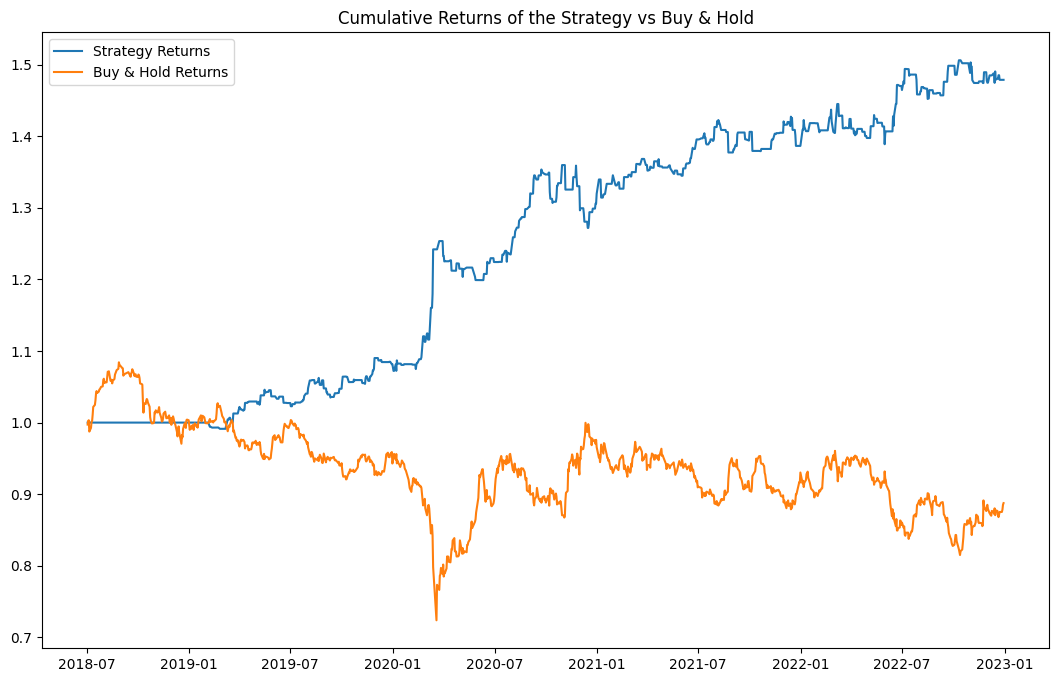

In [9]:
# Define a function to calculate the Z-Score
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df

def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df

df = yf.download(ticker, start=start1, end=end1)

df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
df["Close"] = df["Adj Close"] / df["Close"] * df["Close"]

df = df[df['Volume'] != 0]
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Calculate the SMA
df["SMA"] = df["Close"].rolling(window=best_sma_window).mean()

# Calculate the TSF
df["TSF"] = TSF(df["Close"].values, timeperiod=best_sma_window)

# Calculate the premium/discount
df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

# Calculate Pct of MisPricing
df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

# Calculate Z-Score
df = Z_Score(df, window=best_zscore_window)

# Calculate ZScore
df = ZScore(df, window=best_zscore_window)


# Define buy and sell zones
buyZScoreTH = best_buyZScoreTH
sellZScoreTH = best_sellZScoreTH

buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


# Generate trading signals
df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
df["Signal"] = df["BuySignal"] + df["SellSignal"]


# Calculate the ATR
df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=best_ATR_window)

# Define SL and TP multipliers
SL_multiplier = best_SL_multiplier
TP_multiplier = best_TP_multiplier

# Initialize SL and TP levels to NaN
df["SL"] = np.nan
df["TP"] = np.nan


# Define initial capital
capital = 10000

# Calculate the number of shares to buy
df["Shares"] = capital // (df["ATR"] * 100)

# Create a variable to hold the entry price
entry_price = 0

# Define SL and TP levels based on entry price
for i in range(len(df)):
    if df["Signal"].iloc[i] == 1:
        entry_price = df["Close"].iloc[i]
        df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
        df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
    elif df["Signal"].iloc[i] == -1:
        entry_price = 0
        df["SL"].iloc[i] = np.nan
        df["TP"].iloc[i] = np.nan
    else:
        df["SL"].iloc[i] = df["SL"].iloc[i-1]
        df["TP"].iloc[i] = df["TP"].iloc[i-1]

# Fill in the rest of SL and TP columns
df["SL"].fillna(method='ffill', inplace=True)
df["TP"].fillna(method='ffill', inplace=True)


# Calculate daily returns based on trading signals
df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

# Calculate Buy-and-Hold Returns
df["B&H_Returns"] = df["Close"].pct_change()

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate buy-and-hold cumulative returns
df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

# Print the DataFrame
print(df)


# Plot cumulative returns
plt.figure(figsize=(13,8))

# Plot the strategy's cumulative returns
plt.plot(df['cumulative_returns'], label='Strategy Returns')

# Plot the buy-and-hold cumulative returns
plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
plt.legend(loc='best')
plt.show()

# Single Stock with Optimized Parameters - 2nd Period 

[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close  Adj Close     Volume  \
Date                                                                   
2022-07-01  1441.62  1452.32  1441.62  1449.74    1449.74  1.242e+08   
2022-07-04  1449.50  1449.50  1437.52  1437.52    1437.52  1.211e+08   
2022-07-05  1441.87  1444.67  1435.58  1440.81    1440.81  1.431e+08   
2022-07-06  1442.57  1448.09  1419.50  1420.85    1420.85  1.744e+08   
2022-07-07  1421.04  1425.85  1418.69  1418.69    1418.69  1.779e+08   
...             ...      ...      ...      ...        ...        ...   
2023-07-26  1436.70  1449.29  1436.70  1449.29    1449.29  1.331e+08   
2023-07-27  1447.66  1456.36  1446.92  1451.27    1451.27  1.232e+08   
2023-07-28  1448.21  1454.24  1446.46  1450.35    1450.35  1.018e+08   
2023-07-31  1451.07  1464.70  1451.07  1459.43    1459.43  1.649e+08   
2023-08-01  1458.90  1462.56  1449.02  1451.24    1451.24  9.817e+0

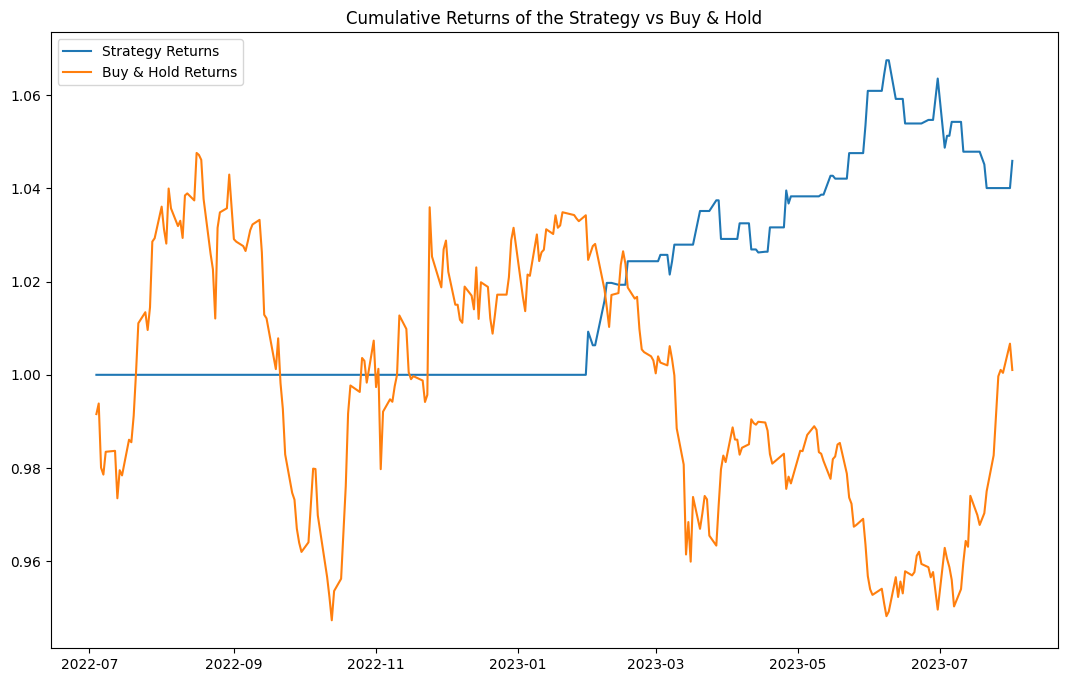

In [10]:
# Define a function to calculate the Z-Score
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df

def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df

df = yf.download(ticker, start=start2, end=end2)

df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
df["Close"] = df["Adj Close"] / df["Close"] * df["Close"]

df = df[df['Volume'] != 0]
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Calculate the SMA
df["SMA"] = df["Close"].rolling(window=best_sma_window).mean()

# Calculate the TSF
df["TSF"] = TSF(df["Close"].values, timeperiod=best_sma_window)

# Calculate the premium/discount
df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

# Calculate Pct of MisPricing
df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

# Calculate Z-Score
df = Z_Score(df, window=best_zscore_window)

# Calculate ZScore
df = ZScore(df, window=best_zscore_window)


# Define buy and sell zones
buyZScoreTH = best_buyZScoreTH
sellZScoreTH = best_sellZScoreTH

buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


# Generate trading signals
df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
df["Signal"] = df["BuySignal"] + df["SellSignal"]


# Calculate the ATR
df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=best_ATR_window)

# Define SL and TP multipliers
SL_multiplier = best_SL_multiplier
TP_multiplier = best_TP_multiplier

# Initialize SL and TP levels to NaN
df["SL"] = np.nan
df["TP"] = np.nan


# Define initial capital
capital = 10000

# Calculate the number of shares to buy
df["Shares"] = capital // (df["ATR"] * 100)

# Create a variable to hold the entry price
entry_price = 0

# Define SL and TP levels based on entry price
for i in range(len(df)):
    if df["Signal"].iloc[i] == 1:
        entry_price = df["Close"].iloc[i]
        df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
        df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
    elif df["Signal"].iloc[i] == -1:
        entry_price = 0
        df["SL"].iloc[i] = np.nan
        df["TP"].iloc[i] = np.nan
    else:
        df["SL"].iloc[i] = df["SL"].iloc[i-1]
        df["TP"].iloc[i] = df["TP"].iloc[i-1]

# Fill in the rest of SL and TP columns
df["SL"].fillna(method='ffill', inplace=True)
df["TP"].fillna(method='ffill', inplace=True)


# Calculate daily returns based on trading signals
df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

# Calculate Buy-and-Hold Returns
df["B&H_Returns"] = df["Close"].pct_change()

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate buy-and-hold cumulative returns
df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

# Print the DataFrame
print(df)


# Plot cumulative returns
plt.figure(figsize=(13,8))

# Plot the strategy's cumulative returns
plt.plot(df['cumulative_returns'], label='Strategy Returns')

# Plot the buy-and-hold cumulative returns
plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
plt.legend(loc='best')
plt.show()

# The advantages and potential pitfalls of this strategy:

# Further Enhancement for Multiple Stocks (but with the same Single Strategy)

# Optimizing for Respective Stock's Best Parameters

In [11]:
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df


def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df


def calculate_strategy_return(df, params):

    df["SMA"] = df["Close"].rolling(window=params['sma_window']).mean()
    df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100
    df = Z_Score(df, window=params['zscore_window'])

    df["TSF"] = TSF(df["Close"].values, timeperiod=params['sma_window'])
    df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
    df = ZScore(df, window=params['zscore_window'])
    
    buyZone = (df["Z_Score"] > -1*params['buyZScoreTH']) & (df["ZScore"] > -1*params['buyZScoreTH'])
    prebuyZone = (df["Z_Score"].shift(1) <= -1*params['buyZScoreTH']) & (df["ZScore"].shift(1) <= -1*params['buyZScoreTH'])
    sellZone1 = (df["Z_Score"] < 1*params['sellZScoreTH']) & (df["ZScore"] < 1*params['sellZScoreTH'])
    presellZone1 = (df["Z_Score"].shift(1) >= 1*params['sellZScoreTH']) & (df["ZScore"].shift(1) >= 1*params['sellZScoreTH'])
    sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

    df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
    df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
    df["Signal"] = df["BuySignal"] + df["SellSignal"]
    
    df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=params['ATR_window'])
    
    df["SL"] = np.where(df["Signal"]==1, df["Close"] - params['SL_multiplier'] * df["ATR"], np.nan)
    df["TP"] = np.where(df["Signal"]==1, df["Close"] + params['TP_multiplier'] * df["ATR"], np.nan)
    df["SL"].fillna(method='ffill', inplace=True)
    df["TP"].fillna(method='ffill', inplace=True)
    
    df['returns'] = df['Close'].pct_change() * df['Signal'].shift()
    
    return df['returns']


def objective(trial, df):
    
    params = {
        'sma_window': trial.suggest_int('sma_window', 33, 233),
        'zscore_window': trial.suggest_int('zscore_window', 3, 33),
        'buyZScoreTH': trial.suggest_float('buyZScoreTH', 1.0, 3.0),
        'sellZScoreTH': trial.suggest_float('sellZScoreTH', 1.0, 3.0),
        'SL_multiplier': trial.suggest_float('SL_multiplier', 0.5, 2.0),
        'TP_multiplier': trial.suggest_float('TP_multiplier', 1.0, 5.0),
        'ATR_window': trial.suggest_int('ATR_window', 3, 13)
    }
    returns = calculate_strategy_return(df.copy(), params)
    sharpe_ratio = pf.sharpe_ratio(returns.dropna())
    
    return sharpe_ratio

In [12]:
tickers = [
    "4707.KL", "4715.KL", "7277.KL", "4065.KL", "5819.KL", "1023.KL", "2445.KL", "8869.KL", "1155.KL", "1295.KL",
    "1066.KL", "4197.KL", "5285.KL", "7084.KL","1082.KL", "5183.KL", "6033.KL", "1961.KL", "6947.KL", "5209.KL",
    "0166.KL", "6888.KL", "6012.KL", "5225.KL", "4863.KL", "3182.KL", "3816.KL", "5681.KL", "1015.KL", "5296.KL", 
    "5398.KL", "0117.KL", "7221.KL", "0069.KL", "7108.KL", "5259.KL", "5166.KL", "1023.KL", "8907.KL", "5286.KL", 
    "5099.KL", "5231.KL", "0045.KL", "6742.KL", "7250.KL", "7079.KL", "5878.KL", "5673.KL", "7168.KL", "6399.KL", 
    "7228.KL", "0120.KL", "1589.KL", "4383.KL", "1171.KL", "5288.KL", "7188.KL", "1066.KL", "6888.KL", 
    "5273.KL", "7293.KL", "0082.KL", "3662.KL", "5238.KL", "9385.KL", "5211.KL", "5182.KL", "3336.KL", "0032.KL", 
    "5254.KL", "7241.KL", "6633.KL", "5401.KL", "5302.KL", "5264.KL", "7173.KL", "5276.KL", "3816.KL", "7035.KL", 
    "3514.KL", "4022.KL", "5187.KL", "2062.KL", "2488.KL", "8273.KL", "7095.KL", "3247.KL", "0021.KL", "5062.KL",
    "0157.KL", "5112.KL", "0060.KL", "0091.KL", "1724.KL", "0185.KL", "4588.KL", "7237.KL", "5106.KL", "0091.KL",
    "5249.KL", "8052.KL", "5983.KL", "6483.KL", "7100.KL", "0131.KL", "7246.KL", "0174.KL", "3255.KL", "5168.KL",
    "7197.KL", "5162.KL", "7128.KL", "5843.KL", "5222.KL", "5053.KL", "7029.KL", "7090.KL", "0136.KL", "2089.KL",
    "5649.KL", "5239.KL", "7498.KL", "0153.KL", "4286.KL", "7014.KL", "3689.KL", "9377.KL", "7595.KL", "0190.KL",
    "7231.KL", "5269.KL", "5116.KL", "7103.KL", "7134.KL", "0173.KL", "7010.KL", "7412.KL", "6041.KL", "2828.KL",
    "3158.KL", "1163.KL", "5908.KL", "5015.KL", "5606.KL", "3905.KL", "6351.KL", "7073.KL", "9466.KL", "7017.KL",
    "6211.KL", "9687.KL", "7176.KL", "5008.KL", "9369.KL", "5035.KL", "2607.KL", "7765.KL", "8486.KL", "03048.KL",
    "5069.KL", "0138.KL", "0069.KL", "7108.KL", "5210.KL", "5259.KL", "0117.KL", "5166.KL", "7201.KL", "0034.KL",
    "1023.KL", "5398.KL", "8907.KL", "5099.KL", "3395.KL", "7113.KL", "7043.KL", "5219.KL", "5878.KL", "7079.KL",
    "0120.KL", "5673.KL", "5115.KL", "0232.KL", "7249.KL", "6399.KL",  "5983.KL", "7100.KL", "6483.KL", "5292.KL",
    "0045.KL", "5286.KL", "5231.KL", "7082.KL", "7250.KL", "0075.KL", "1066.KL", "0165.KL", "6742.KL", "4383.KL", 
    "5142.KL", "1171.KL", "4464.KL", "6888.KL", "5238.KL", "0180.KL", "0104.KL",
    "7293.KL", "7228.KL", "5273.KL", "3662.KL", "5031.KL", "7168.KL", "7241.KL", "0032.KL", "7188.KL",
    "5302.KL", "0095.KL", "5088.KL", "0082.KL", "8583.KL", "0189.KL", "0118.KL", "5211.KL", "5254.KL", "2488.KL",
    "5288.KL", "3816.KL", "0123.KL", "5182.KL", "0150.KL", "3336.KL", "9385.KL", "0066.KL", "0227.KL", "7173.KL",
    "0208.KL", "7035.KL", "3174.KL", "6633.KL", "5187.KL", "4588.KL", "5264.KL", "3247.KL",
    "0021.KL", "0223.KL", "5276.KL", "0172.KL", "5106.KL", "5401.KL", "3514.KL", "0157.KL", "5249.KL", "8052.KL",
    "7223.KL", "7246.KL", "8273.KL", "5112.KL", "0185.KL", "0060.KL", "8524.KL", "5062.KL", "0131.KL", "7237.KL"]

unique_tickers = list(set(tickers))

tickers = unique_tickers
start1 = "2018-07-01"
end1 = "2022-12-31"

returns_df = pd.DataFrame()
best_params_df = pd.DataFrame()
highest_sharpe_ratios = {}


for ticker in tickers:
    try:
        
        df = yf.download(ticker, start=start1, end=end1)
        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]

        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)

        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, df), n_trials=108)
        best_params = study.best_params
        print(f"Best params for {ticker}: {best_params}")
        returns = calculate_strategy_return(df, best_params)
        returns_df[ticker] = returns
        best_params_df = best_params_df.append(pd.Series(best_params, name=ticker))
        highest_sharpe_ratios[ticker] = study.best_value

    except Exception as e:
        print(ticker)
        
equity_curve = (1 + returns_df).cumprod()

highest_sharpe_ratios_df = pd.DataFrame.from_dict(highest_sharpe_ratios, orient='index', columns=['Highest Sharpe Ratio'])

# Combine best_params_df and highest_sharpe_ratios_df into a single dataframe
combined_df = pd.concat([best_params_df, highest_sharpe_ratios_df], axis=1)

# Write combined_df to a CSV file
combined_df.to_csv("best_params.csv")

output_df = pd.concat([returns_df, highest_sharpe_ratios_df, equity_curve], axis=1)

print(output_df)

[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:00:51,525] A new study created in memory with name: no-name-c1d502b8-65a7-40bf-9311-89439098fb2d
[I 2023-08-02 15:00:51,534] Trial 0 finished with value: -0.21912205148181582 and parameters: {'sma_window': 172, 'zscore_window': 9, 'buyZScoreTH': 2.7848276228363247, 'sellZScoreTH': 1.374033569115925, 'SL_multiplier': 1.612467752343398, 'TP_multiplier': 4.147744768092675, 'ATR_window': 9}. Best is trial 0 with value: -0.21912205148181582.
[I 2023-08-02 15:00:51,546] Trial 1 finished with value: -0.10253702684575375 and parameters: {'sma_window': 74, 'zscore_window': 8, 'buyZScoreTH': 1.716086002847022, 'sellZScoreTH': 2.8614380778681037, 'SL_multiplier': 0.919995001106537, 'TP_multiplier': 3.938690657347972, 'ATR_window': 13}. Best is trial 1 with value: -0.10253702684575375.
[I 2023-08-02 15:00:51,555] Trial 2 finished with value: -0.5763457721096812 and parameters: {'sma_window': 109, 'zscore_window': 13, 'buyZScoreTH': 1.9790114667736673, 'sellZScoreTH': 1.82559012803

[I 2023-08-02 15:00:51,751] Trial 13 finished with value: -1.011529478010889 and parameters: {'sma_window': 194, 'zscore_window': 27, 'buyZScoreTH': 1.0192943223881337, 'sellZScoreTH': 1.6156805636661837, 'SL_multiplier': 0.9519737519813507, 'TP_multiplier': 1.0529863977022953, 'ATR_window': 5}. Best is trial 10 with value: 0.42523153307462674.
[I 2023-08-02 15:00:51,788] Trial 14 finished with value: -0.7032622174735713 and parameters: {'sma_window': 233, 'zscore_window': 27, 'buyZScoreTH': 1.390103417496805, 'sellZScoreTH': 1.072190867483292, 'SL_multiplier': 1.2479164527815156, 'TP_multiplier': 1.815213387041652, 'ATR_window': 6}. Best is trial 10 with value: 0.42523153307462674.
[I 2023-08-02 15:00:51,822] Trial 15 finished with value: -0.8173752656573022 and parameters: {'sma_window': 143, 'zscore_window': 30, 'buyZScoreTH': 1.4237212276658278, 'sellZScoreTH': 1.6187882920126286, 'SL_multiplier': 1.3970588483156017, 'TP_multiplier': 2.6919816507372083, 'ATR_window': 4}. Best is tr

Best params for 5231.KL: {'sma_window': 147, 'zscore_window': 33, 'buyZScoreTH': 1.081127131876302, 'sellZScoreTH': 1.1177808938137432, 'SL_multiplier': 1.0459457055555719, 'TP_multiplier': 1.7207391381490513, 'ATR_window': 11}
5231.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:00:55,602] A new study created in memory with name: no-name-661d1c74-e7df-4acb-93d3-d08dcac27de4
[I 2023-08-02 15:00:55,612] Trial 0 finished with value: -0.22296306248152165 and parameters: {'sma_window': 61, 'zscore_window': 24, 'buyZScoreTH': 1.9782770808503831, 'sellZScoreTH': 2.04675759768032, 'SL_multiplier': 1.8599233130550699, 'TP_multiplier': 4.005504637399897, 'ATR_window': 10}. Best is trial 0 with value: -0.22296306248152165.
[I 2023-08-02 15:00:55,620] Trial 1 finished with value: -0.09766277365240468 and parameters: {'sma_window': 41, 'zscore_window': 22, 'buyZScoreTH': 2.5850320498005632, 'sellZScoreTH': 1.9286386690175, 'SL_multiplier': 1.5895527138783774, 'TP_multiplier': 2.707140850148036, 'ATR_window': 13}. Best is trial 1 with value: -0.09766277365240468.
[I 2023-08-02 15:00:55,630] Trial 2 finished with value: -0.48039339555020816 and parameters: {'sma_window': 120, 'zscore_window': 11, 'buyZScoreTH': 2.8297911988280857, 'sellZScoreTH': 2.806392237

[I 2023-08-02 15:00:55,796] Trial 12 finished with value: -0.21895214233011012 and parameters: {'sma_window': 161, 'zscore_window': 29, 'buyZScoreTH': 2.2675506303264, 'sellZScoreTH': 2.4923179153525385, 'SL_multiplier': 1.347908421763493, 'TP_multiplier': 3.1466930746662807, 'ATR_window': 5}. Best is trial 9 with value: 0.3369302229796726.
[I 2023-08-02 15:00:55,829] Trial 13 finished with value: 0.1982015927899401 and parameters: {'sma_window': 151, 'zscore_window': 30, 'buyZScoreTH': 1.7766729709673341, 'sellZScoreTH': 1.584746533233524, 'SL_multiplier': 1.0237932311100955, 'TP_multiplier': 3.655088189708625, 'ATR_window': 5}. Best is trial 9 with value: 0.3369302229796726.
[I 2023-08-02 15:00:55,861] Trial 14 finished with value: -0.31805426639158363 and parameters: {'sma_window': 99, 'zscore_window': 28, 'buyZScoreTH': 1.7282173813308, 'sellZScoreTH': 1.5649100792269945, 'SL_multiplier': 1.027532093395075, 'TP_multiplier': 3.730522920562405, 'ATR_window': 5}. Best is trial 9 with 

Best params for 5398.KL: {'sma_window': 192, 'zscore_window': 29, 'buyZScoreTH': 2.467407849077344, 'sellZScoreTH': 1.0451924277413351, 'SL_multiplier': 1.7680207671302788, 'TP_multiplier': 4.493321080567045, 'ATR_window': 3}
5398.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:00:59,590] A new study created in memory with name: no-name-9335426f-6a24-43cd-8209-481ec5f46d44
[I 2023-08-02 15:00:59,599] Trial 0 finished with value: -0.38597622534948095 and parameters: {'sma_window': 99, 'zscore_window': 8, 'buyZScoreTH': 1.0208695867064352, 'sellZScoreTH': 1.2462481478377143, 'SL_multiplier': 1.0138825310535335, 'TP_multiplier': 2.728912446925201, 'ATR_window': 10}. Best is trial 0 with value: -0.38597622534948095.
[I 2023-08-02 15:00:59,612] Trial 1 finished with value: 0.39817234318423234 and parameters: {'sma_window': 41, 'zscore_window': 33, 'buyZScoreTH': 1.661697567911521, 'sellZScoreTH': 2.124269267013168, 'SL_multiplier': 1.7500975586640681, 'TP_multiplier': 3.1369944019431726, 'ATR_window': 4}. Best is trial 1 with value: 0.39817234318423234.
[I 2023-08-02 15:00:59,620] Trial 2 finished with value: 0.9518355310827827 and parameters: {'sma_window': 171, 'zscore_window': 29, 'buyZScoreTH': 2.741967232424262, 'sellZScoreTH': 2.310297078415

[I 2023-08-02 15:00:59,787] Trial 12 finished with value: 1.0127388689396273 and parameters: {'sma_window': 180, 'zscore_window': 27, 'buyZScoreTH': 2.434497477561181, 'sellZScoreTH': 2.5312609033463187, 'SL_multiplier': 1.4491553660254697, 'TP_multiplier': 1.0120976438481084, 'ATR_window': 8}. Best is trial 11 with value: 1.153794395731641.
[I 2023-08-02 15:00:59,822] Trial 13 finished with value: 1.2627427190345595 and parameters: {'sma_window': 179, 'zscore_window': 22, 'buyZScoreTH': 2.4273154076396817, 'sellZScoreTH': 2.659285245337389, 'SL_multiplier': 1.43300209131763, 'TP_multiplier': 1.0013871523808526, 'ATR_window': 7}. Best is trial 13 with value: 1.2627427190345595.
[I 2023-08-02 15:00:59,855] Trial 14 finished with value: 0.41462602620889055 and parameters: {'sma_window': 228, 'zscore_window': 21, 'buyZScoreTH': 2.376918641954908, 'sellZScoreTH': 2.857064889383015, 'SL_multiplier': 1.5557475505644092, 'TP_multiplier': 1.6894546393665668, 'ATR_window': 7}. Best is trial 13 

Best params for 1082.KL: {'sma_window': 152, 'zscore_window': 20, 'buyZScoreTH': 2.0057975671269075, 'sellZScoreTH': 2.786199082434253, 'SL_multiplier': 1.2754815458206887, 'TP_multiplier': 1.786044542178022, 'ATR_window': 6}
1082.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:03,600] A new study created in memory with name: no-name-8657fdba-f9d8-4a6f-99ce-4482d3240107
[I 2023-08-02 15:01:03,608] Trial 0 finished with value: -0.3347965977616142 and parameters: {'sma_window': 98, 'zscore_window': 27, 'buyZScoreTH': 2.321896938564189, 'sellZScoreTH': 2.720341354988433, 'SL_multiplier': 0.5374108716340673, 'TP_multiplier': 1.4049148031590946, 'ATR_window': 11}. Best is trial 0 with value: -0.3347965977616142.
[I 2023-08-02 15:01:03,618] Trial 1 finished with value: -0.3780128435988871 and parameters: {'sma_window': 123, 'zscore_window': 26, 'buyZScoreTH': 1.7464601921733256, 'sellZScoreTH': 1.5620807810455222, 'SL_multiplier': 1.3891430065291397, 'TP_multiplier': 3.5765693809266565, 'ATR_window': 12}. Best is trial 0 with value: -0.3347965977616142.
[I 2023-08-02 15:01:03,626] Trial 2 finished with value: -0.36663710711167163 and parameters: {'sma_window': 161, 'zscore_window': 9, 'buyZScoreTH': 2.476292734843873, 'sellZScoreTH': 1.672152764

[I 2023-08-02 15:01:03,815] Trial 13 finished with value: 0.1411178615527537 and parameters: {'sma_window': 148, 'zscore_window': 33, 'buyZScoreTH': 1.0160025861774649, 'sellZScoreTH': 2.9113666716257014, 'SL_multiplier': 1.6529258793216746, 'TP_multiplier': 4.3418603004568315, 'ATR_window': 6}. Best is trial 12 with value: 0.667796550914304.
[I 2023-08-02 15:01:03,846] Trial 14 finished with value: 0.00740804333648558 and parameters: {'sma_window': 200, 'zscore_window': 30, 'buyZScoreTH': 1.378462989019556, 'sellZScoreTH': 2.955521077643634, 'SL_multiplier': 1.6625325024587136, 'TP_multiplier': 3.2630044720334768, 'ATR_window': 6}. Best is trial 12 with value: 0.667796550914304.
[I 2023-08-02 15:01:03,878] Trial 15 finished with value: 0.014056625957635507 and parameters: {'sma_window': 169, 'zscore_window': 23, 'buyZScoreTH': 1.2122589818163176, 'sellZScoreTH': 2.3992267232325744, 'SL_multiplier': 1.9773439423166734, 'TP_multiplier': 4.256809848559457, 'ATR_window': 7}. Best is trial

Best params for 5166.KL: {'sma_window': 188, 'zscore_window': 29, 'buyZScoreTH': 1.0387288263223189, 'sellZScoreTH': 2.9428327915925445, 'SL_multiplier': 1.341641582883985, 'TP_multiplier': 3.9577934072044703, 'ATR_window': 7}
5166.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:07,506] A new study created in memory with name: no-name-980b5f57-38f2-4bf2-84a7-1914a23f220d
[I 2023-08-02 15:01:07,515] Trial 0 finished with value: -0.794548359876221 and parameters: {'sma_window': 181, 'zscore_window': 28, 'buyZScoreTH': 2.724145680877168, 'sellZScoreTH': 2.7341891423926645, 'SL_multiplier': 1.845449269343657, 'TP_multiplier': 4.673673898513677, 'ATR_window': 11}. Best is trial 0 with value: -0.794548359876221.
[I 2023-08-02 15:01:07,524] Trial 1 finished with value: -0.5846945410861886 and parameters: {'sma_window': 71, 'zscore_window': 25, 'buyZScoreTH': 1.3241035411796889, 'sellZScoreTH': 1.1984881589688152, 'SL_multiplier': 1.1405087161054352, 'TP_multiplier': 4.174960198249625, 'ATR_window': 12}. Best is trial 1 with value: -0.5846945410861886.
[I 2023-08-02 15:01:07,533] Trial 2 finished with value: -0.6104696265448266 and parameters: {'sma_window': 117, 'zscore_window': 19, 'buyZScoreTH': 2.4178931836045336, 'sellZScoreTH': 2.423531306137

[I 2023-08-02 15:01:07,723] Trial 13 finished with value: -0.8843877118369124 and parameters: {'sma_window': 162, 'zscore_window': 11, 'buyZScoreTH': 1.742339036345226, 'sellZScoreTH': 2.142300567080169, 'SL_multiplier': 1.3629240029237266, 'TP_multiplier': 1.6664406222459378, 'ATR_window': 4}. Best is trial 5 with value: -0.5089923325978556.
[I 2023-08-02 15:01:07,755] Trial 14 finished with value: -0.9306221904612543 and parameters: {'sma_window': 145, 'zscore_window': 24, 'buyZScoreTH': 2.1360991766776047, 'sellZScoreTH': 2.523777092624366, 'SL_multiplier': 1.9872836192682455, 'TP_multiplier': 2.813254050198079, 'ATR_window': 3}. Best is trial 5 with value: -0.5089923325978556.
[I 2023-08-02 15:01:07,789] Trial 15 finished with value: -0.8269177307782076 and parameters: {'sma_window': 199, 'zscore_window': 9, 'buyZScoreTH': 1.6521474565805288, 'sellZScoreTH': 2.985811508198492, 'SL_multiplier': 1.6049491415149078, 'TP_multiplier': 2.130116427084562, 'ATR_window': 7}. Best is trial 5

Best params for 0117.KL: {'sma_window': 38, 'zscore_window': 31, 'buyZScoreTH': 1.4443227795026945, 'sellZScoreTH': 1.1457681495520768, 'SL_multiplier': 1.2730751224575723, 'TP_multiplier': 3.8451903402832115, 'ATR_window': 13}
0117.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:11,409] A new study created in memory with name: no-name-07ef7b01-cf13-4c19-b702-abe8ff239476
[I 2023-08-02 15:01:11,418] Trial 0 finished with value: 0.02155828018185218 and parameters: {'sma_window': 182, 'zscore_window': 13, 'buyZScoreTH': 1.9300618893083394, 'sellZScoreTH': 1.7019216243983657, 'SL_multiplier': 1.1516440385737845, 'TP_multiplier': 1.1204766002544408, 'ATR_window': 4}. Best is trial 0 with value: 0.02155828018185218.
[I 2023-08-02 15:01:11,427] Trial 1 finished with value: -0.4266748673426971 and parameters: {'sma_window': 33, 'zscore_window': 12, 'buyZScoreTH': 2.284317183831952, 'sellZScoreTH': 1.7945425280973912, 'SL_multiplier': 1.7453690617168842, 'TP_multiplier': 1.6516825736430794, 'ATR_window': 9}. Best is trial 0 with value: 0.02155828018185218.
[I 2023-08-02 15:01:11,437] Trial 2 finished with value: -0.30410611771388657 and parameters: {'sma_window': 141, 'zscore_window': 15, 'buyZScoreTH': 1.047199000247684, 'sellZScoreTH': 2.527901032

[I 2023-08-02 15:01:11,595] Trial 12 finished with value: 0.1842149187337713 and parameters: {'sma_window': 175, 'zscore_window': 22, 'buyZScoreTH': 1.3520626880493785, 'sellZScoreTH': 1.3088027313544666, 'SL_multiplier': 1.463975070140837, 'TP_multiplier': 4.871614013841226, 'ATR_window': 3}. Best is trial 11 with value: 0.21275515122581393.
[I 2023-08-02 15:01:11,628] Trial 13 finished with value: 0.32531354337958013 and parameters: {'sma_window': 173, 'zscore_window': 20, 'buyZScoreTH': 1.3202394012842844, 'sellZScoreTH': 1.0417034651882688, 'SL_multiplier': 1.4230045135637908, 'TP_multiplier': 4.980252711196687, 'ATR_window': 5}. Best is trial 13 with value: 0.32531354337958013.
[I 2023-08-02 15:01:11,667] Trial 14 finished with value: -0.5052222541176349 and parameters: {'sma_window': 152, 'zscore_window': 19, 'buyZScoreTH': 1.2933900257391127, 'sellZScoreTH': 1.0583611739339336, 'SL_multiplier': 1.5006398765096964, 'TP_multiplier': 4.342794567917754, 'ATR_window': 5}. Best is tri

Best params for 5162.KL: {'sma_window': 193, 'zscore_window': 20, 'buyZScoreTH': 1.3513732316043938, 'sellZScoreTH': 2.0463460486755087, 'SL_multiplier': 1.7276852752206353, 'TP_multiplier': 3.667983432918742, 'ATR_window': 5}
5162.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:15,342] A new study created in memory with name: no-name-24aeb82b-0c70-4c59-bec9-5484ba2641a1
[I 2023-08-02 15:01:15,350] Trial 0 finished with value: -0.49704904565832575 and parameters: {'sma_window': 125, 'zscore_window': 24, 'buyZScoreTH': 2.199499448871098, 'sellZScoreTH': 1.972517044142694, 'SL_multiplier': 1.6120449989357173, 'TP_multiplier': 3.264382702804348, 'ATR_window': 13}. Best is trial 0 with value: -0.49704904565832575.
[I 2023-08-02 15:01:15,358] Trial 1 finished with value: 0.3688640340019439 and parameters: {'sma_window': 161, 'zscore_window': 12, 'buyZScoreTH': 2.7313114409115253, 'sellZScoreTH': 1.7747017910979541, 'SL_multiplier': 1.043209976265958, 'TP_multiplier': 3.9332868587143794, 'ATR_window': 12}. Best is trial 1 with value: 0.3688640340019439.
[I 2023-08-02 15:01:15,366] Trial 2 finished with value: -0.08183509760028206 and parameters: {'sma_window': 64, 'zscore_window': 13, 'buyZScoreTH': 2.7785424735626627, 'sellZScoreTH': 1.460652740

[I 2023-08-02 15:01:15,561] Trial 13 finished with value: -0.31940535255797464 and parameters: {'sma_window': 199, 'zscore_window': 8, 'buyZScoreTH': 1.8505329919155011, 'sellZScoreTH': 2.552535331526346, 'SL_multiplier': 1.2833548348378923, 'TP_multiplier': 1.0182238060647166, 'ATR_window': 6}. Best is trial 4 with value: 0.8923251947694184.
[I 2023-08-02 15:01:15,590] Trial 14 finished with value: 0.14680749592416434 and parameters: {'sma_window': 195, 'zscore_window': 17, 'buyZScoreTH': 2.5932140702660305, 'sellZScoreTH': 2.335101753127922, 'SL_multiplier': 1.3485003105089415, 'TP_multiplier': 1.004684011398529, 'ATR_window': 4}. Best is trial 4 with value: 0.8923251947694184.
[I 2023-08-02 15:01:15,622] Trial 15 finished with value: -0.145110778790962 and parameters: {'sma_window': 111, 'zscore_window': 33, 'buyZScoreTH': 1.043180066472878, 'sellZScoreTH': 2.9960305055889447, 'SL_multiplier': 1.1446436840564207, 'TP_multiplier': 2.2973740002147944, 'ATR_window': 9}. Best is trial 4

Best params for 5239.KL: {'sma_window': 180, 'zscore_window': 10, 'buyZScoreTH': 2.494311285802837, 'sellZScoreTH': 2.8856229801985087, 'SL_multiplier': 1.2506618207935525, 'TP_multiplier': 1.9393496818718012, 'ATR_window': 6}
5239.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:19,337] A new study created in memory with name: no-name-9ba9756a-d9d2-43df-87f3-6177ae0571e2
[I 2023-08-02 15:01:19,345] Trial 0 finished with value: 0.7491599257184408 and parameters: {'sma_window': 178, 'zscore_window': 27, 'buyZScoreTH': 2.46548741987627, 'sellZScoreTH': 1.9815260109022275, 'SL_multiplier': 1.6954081160878443, 'TP_multiplier': 3.9133223343085652, 'ATR_window': 11}. Best is trial 0 with value: 0.7491599257184408.
[I 2023-08-02 15:01:19,355] Trial 1 finished with value: -0.1628183461051982 and parameters: {'sma_window': 182, 'zscore_window': 23, 'buyZScoreTH': 1.7264546371587877, 'sellZScoreTH': 2.271788646551813, 'SL_multiplier': 0.8687967460375009, 'TP_multiplier': 4.635724297566589, 'ATR_window': 4}. Best is trial 0 with value: 0.7491599257184408.
[I 2023-08-02 15:01:19,366] Trial 2 finished with value: 0.106657340866842 and parameters: {'sma_window': 49, 'zscore_window': 6, 'buyZScoreTH': 2.414862706031699, 'sellZScoreTH': 1.0229342649081514, 

[I 2023-08-02 15:01:19,558] Trial 13 finished with value: 0.23781225551496116 and parameters: {'sma_window': 212, 'zscore_window': 22, 'buyZScoreTH': 2.107874957439324, 'sellZScoreTH': 1.4992167345132543, 'SL_multiplier': 1.9710331838850192, 'TP_multiplier': 1.0886022616739188, 'ATR_window': 7}. Best is trial 7 with value: 0.9838067027649734.
[I 2023-08-02 15:01:19,591] Trial 14 finished with value: 0.11335553100065265 and parameters: {'sma_window': 96, 'zscore_window': 11, 'buyZScoreTH': 1.6056309805076419, 'sellZScoreTH': 2.0262046795043003, 'SL_multiplier': 1.3960936534026371, 'TP_multiplier': 3.781315875726701, 'ATR_window': 13}. Best is trial 7 with value: 0.9838067027649734.
[I 2023-08-02 15:01:19,623] Trial 15 finished with value: 0.4419845747099742 and parameters: {'sma_window': 188, 'zscore_window': 29, 'buyZScoreTH': 2.2949160446701002, 'sellZScoreTH': 2.602273084762312, 'SL_multiplier': 1.1403278732656041, 'TP_multiplier': 2.4381337062784403, 'ATR_window': 11}. Best is trial

Best params for 5401.KL: {'sma_window': 165, 'zscore_window': 32, 'buyZScoreTH': 1.326429616409483, 'sellZScoreTH': 2.902824145984254, 'SL_multiplier': 1.3293804254836865, 'TP_multiplier': 4.992709008384894, 'ATR_window': 8}
5401.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:23,264] A new study created in memory with name: no-name-9b5ece38-72b7-4907-961f-4f0b94f13ad6
[I 2023-08-02 15:01:23,274] Trial 0 finished with value: -0.2048029404427764 and parameters: {'sma_window': 132, 'zscore_window': 3, 'buyZScoreTH': 1.8844124635262092, 'sellZScoreTH': 2.158945828417095, 'SL_multiplier': 1.6026382264653392, 'TP_multiplier': 4.792595072013513, 'ATR_window': 7}. Best is trial 0 with value: -0.2048029404427764.
[I 2023-08-02 15:01:23,285] Trial 1 finished with value: 0.6658986579130542 and parameters: {'sma_window': 184, 'zscore_window': 27, 'buyZScoreTH': 1.6090789547122077, 'sellZScoreTH': 1.5091631748309868, 'SL_multiplier': 0.8600465461090352, 'TP_multiplier': 4.8025168573468004, 'ATR_window': 6}. Best is trial 1 with value: 0.6658986579130542.
[I 2023-08-02 15:01:23,293] Trial 2 finished with value: 0.7658327684660525 and parameters: {'sma_window': 210, 'zscore_window': 23, 'buyZScoreTH': 2.559653660897088, 'sellZScoreTH': 2.62588424337595

[I 2023-08-02 15:01:23,483] Trial 13 finished with value: 0.012012812261176606 and parameters: {'sma_window': 232, 'zscore_window': 15, 'buyZScoreTH': 1.5924772132490852, 'sellZScoreTH': 2.4801673197828693, 'SL_multiplier': 1.1422540912879808, 'TP_multiplier': 1.0821448039382993, 'ATR_window': 10}. Best is trial 6 with value: 1.0034314236053075.
[I 2023-08-02 15:01:23,515] Trial 14 finished with value: -0.17360806264339262 and parameters: {'sma_window': 126, 'zscore_window': 25, 'buyZScoreTH': 2.1616973097552483, 'sellZScoreTH': 1.4490758556826244, 'SL_multiplier': 1.5742478713246757, 'TP_multiplier': 2.7123933246622354, 'ATR_window': 8}. Best is trial 6 with value: 1.0034314236053075.
[I 2023-08-02 15:01:23,547] Trial 15 finished with value: -0.1180577481464142 and parameters: {'sma_window': 86, 'zscore_window': 18, 'buyZScoreTH': 1.7550939036075248, 'sellZScoreTH': 2.9951547494127597, 'SL_multiplier': 1.9889430741508103, 'TP_multiplier': 3.076453394760588, 'ATR_window': 13}. Best is 

Best params for 8907.KL: {'sma_window': 195, 'zscore_window': 30, 'buyZScoreTH': 2.0866148728193146, 'sellZScoreTH': 1.6667573912056226, 'SL_multiplier': 0.8589131828257683, 'TP_multiplier': 1.581059052959089, 'ATR_window': 10}
8907.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:27,165] A new study created in memory with name: no-name-a95aff85-2928-4eba-9f85-7f03f7a4a2c9
[I 2023-08-02 15:01:27,175] Trial 0 finished with value: -0.4932559136562469 and parameters: {'sma_window': 192, 'zscore_window': 14, 'buyZScoreTH': 2.546634777797374, 'sellZScoreTH': 1.1089050097264024, 'SL_multiplier': 1.7614798083295418, 'TP_multiplier': 3.877007902446196, 'ATR_window': 6}. Best is trial 0 with value: -0.4932559136562469.
[I 2023-08-02 15:01:27,186] Trial 1 finished with value: -0.22909389708350403 and parameters: {'sma_window': 33, 'zscore_window': 7, 'buyZScoreTH': 2.860225270125918, 'sellZScoreTH': 1.8923821086793744, 'SL_multiplier': 0.709212280246492, 'TP_multiplier': 4.765772818669223, 'ATR_window': 9}. Best is trial 1 with value: -0.22909389708350403.
[I 2023-08-02 15:01:27,195] Trial 2 finished with value: 0.26811532459162535 and parameters: {'sma_window': 231, 'zscore_window': 33, 'buyZScoreTH': 1.6033067632396625, 'sellZScoreTH': 1.213556794484

[I 2023-08-02 15:01:27,364] Trial 12 finished with value: 0.20120614260240566 and parameters: {'sma_window': 88, 'zscore_window': 28, 'buyZScoreTH': 2.328330934692094, 'sellZScoreTH': 2.8798779710527516, 'SL_multiplier': 0.9796341424099839, 'TP_multiplier': 3.036357643047946, 'ATR_window': 8}. Best is trial 4 with value: 0.578226205394347.
[I 2023-08-02 15:01:27,396] Trial 13 finished with value: 0.16993083606993262 and parameters: {'sma_window': 160, 'zscore_window': 29, 'buyZScoreTH': 2.076753386254493, 'sellZScoreTH': 1.555234574619267, 'SL_multiplier': 1.0090017350247527, 'TP_multiplier': 1.8782090779780507, 'ATR_window': 12}. Best is trial 4 with value: 0.578226205394347.
[I 2023-08-02 15:01:27,427] Trial 14 finished with value: 0.1962417017247191 and parameters: {'sma_window': 207, 'zscore_window': 21, 'buyZScoreTH': 1.401192664239548, 'sellZScoreTH': 2.1876776989777005, 'SL_multiplier': 1.4397371924462874, 'TP_multiplier': 2.8892774032584896, 'ATR_window': 8}. Best is trial 4 wi

Best params for 0032.KL: {'sma_window': 78, 'zscore_window': 25, 'buyZScoreTH': 1.5018108483088215, 'sellZScoreTH': 1.1688906259517586, 'SL_multiplier': 0.7310771192403839, 'TP_multiplier': 4.91922819964878, 'ATR_window': 7}
0032.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:31,266] A new study created in memory with name: no-name-862156a8-3d75-4e7e-a2a8-9e0f2ae3e445
[I 2023-08-02 15:01:31,274] Trial 0 finished with value: 0.4892934360661266 and parameters: {'sma_window': 152, 'zscore_window': 24, 'buyZScoreTH': 1.2535331426728151, 'sellZScoreTH': 1.3293114740247647, 'SL_multiplier': 0.6209401626166684, 'TP_multiplier': 3.160771966095641, 'ATR_window': 9}. Best is trial 0 with value: 0.4892934360661266.
[I 2023-08-02 15:01:31,283] Trial 1 finished with value: 0.4111213506003262 and parameters: {'sma_window': 172, 'zscore_window': 16, 'buyZScoreTH': 2.403956796200829, 'sellZScoreTH': 2.8144369449872553, 'SL_multiplier': 1.6642135077687603, 'TP_multiplier': 3.2732595807282054, 'ATR_window': 3}. Best is trial 0 with value: 0.4892934360661266.
[I 2023-08-02 15:01:31,292] Trial 2 finished with value: 0.27355920000384876 and parameters: {'sma_window': 212, 'zscore_window': 3, 'buyZScoreTH': 2.650282290338561, 'sellZScoreTH': 1.763224827835309

[I 2023-08-02 15:01:31,459] Trial 11 finished with value: 0.8575471280714997 and parameters: {'sma_window': 71, 'zscore_window': 29, 'buyZScoreTH': 2.9832840990059726, 'sellZScoreTH': 1.0274034298918646, 'SL_multiplier': 0.939388285400149, 'TP_multiplier': 2.2473229956442458, 'ATR_window': 3}. Best is trial 11 with value: 0.8575471280714997.
[I 2023-08-02 15:01:31,490] Trial 12 finished with value: 0.09684059317677512 and parameters: {'sma_window': 41, 'zscore_window': 22, 'buyZScoreTH': 2.9537253721546928, 'sellZScoreTH': 1.0184283716156934, 'SL_multiplier': 0.9535198517145551, 'TP_multiplier': 2.242738588015228, 'ATR_window': 4}. Best is trial 11 with value: 0.8575471280714997.
[I 2023-08-02 15:01:31,525] Trial 13 finished with value: 1.5925379437736513 and parameters: {'sma_window': 109, 'zscore_window': 32, 'buyZScoreTH': 2.0312532093146527, 'sellZScoreTH': 2.2266985920210285, 'SL_multiplier': 0.5713587228287362, 'TP_multiplier': 2.40330038272136, 'ATR_window': 9}. Best is trial 13

Best params for 7103.KL: {'sma_window': 175, 'zscore_window': 33, 'buyZScoreTH': 2.354144686496087, 'sellZScoreTH': 2.8010217194026223, 'SL_multiplier': 0.9266580899881509, 'TP_multiplier': 2.2319470490065463, 'ATR_window': 6}
7103.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:35,225] A new study created in memory with name: no-name-d58b0363-81c1-4b3e-bc2b-d3c93bf78ab3
[W 2023-08-02 15:01:35,233] Trial 0 failed with parameters: {'sma_window': 188, 'zscore_window': 26, 'buyZScoreTH': 2.806379932780954, 'sellZScoreTH': 1.2179388299481004, 'SL_multiplier': 0.6747750051193582, 'TP_multiplier': 2.432336231332613, 'ATR_window': 13} because of the following error: The value nan is not acceptable..
[W 2023-08-02 15:01:35,234] Trial 0 failed with value nan.
[W 2023-08-02 15:01:35,243] Trial 1 failed with parameters: {'sma_window': 185, 'zscore_window': 32, 'buyZScoreTH': 2.5377534346627497, 'sellZScoreTH': 2.1187258410820125, 'SL_multiplier': 0.8898311831735362, 'TP_multiplier': 2.7315234976822778, 'ATR_window': 5} because of the following error: The value nan is not acceptable..
[W 2023-08-02 15:01:35,245] Trial 1 failed with value nan.
[W 2023-08-02 15:01:35,252] Trial 2 failed with parameters: {'sma_window': 130, 'zscore_window': 23, 'buyZScore

[W 2023-08-02 15:01:35,410] Trial 19 failed with value nan.
[W 2023-08-02 15:01:35,417] Trial 20 failed with parameters: {'sma_window': 68, 'zscore_window': 18, 'buyZScoreTH': 2.9815359244516815, 'sellZScoreTH': 2.6060689574402485, 'SL_multiplier': 1.2475202669043695, 'TP_multiplier': 3.05651241263983, 'ATR_window': 10} because of the following error: The value nan is not acceptable..
[W 2023-08-02 15:01:35,418] Trial 20 failed with value nan.
[W 2023-08-02 15:01:35,431] Trial 21 failed with parameters: {'sma_window': 225, 'zscore_window': 11, 'buyZScoreTH': 1.1630923938501245, 'sellZScoreTH': 2.532308219145304, 'SL_multiplier': 1.079263707633206, 'TP_multiplier': 3.6442882335225977, 'ATR_window': 3} because of the following error: The value nan is not acceptable..
[W 2023-08-02 15:01:35,431] Trial 21 failed with value nan.
[W 2023-08-02 15:01:35,441] Trial 22 failed with parameters: {'sma_window': 140, 'zscore_window': 18, 'buyZScoreTH': 2.765418400671317, 'sellZScoreTH': 2.1345527420

03048.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:36,586] A new study created in memory with name: no-name-e8a06e6d-a966-45eb-b5c5-5bf4be4714f3
[I 2023-08-02 15:01:36,598] Trial 0 finished with value: 0.1433186819244403 and parameters: {'sma_window': 72, 'zscore_window': 21, 'buyZScoreTH': 2.340300090458206, 'sellZScoreTH': 1.0564874627663845, 'SL_multiplier': 0.6435781070192036, 'TP_multiplier': 2.4531368043822375, 'ATR_window': 13}. Best is trial 0 with value: 0.1433186819244403.
[I 2023-08-02 15:01:36,608] Trial 1 finished with value: -1.2932272940816762 and parameters: {'sma_window': 121, 'zscore_window': 7, 'buyZScoreTH': 2.867926778787429, 'sellZScoreTH': 1.178934566311774, 'SL_multiplier': 1.2895560004810132, 'TP_multiplier': 4.266233601176725, 'ATR_window': 9}. Best is trial 0 with value: 0.1433186819244403.
[I 2023-08-02 15:01:36,617] Trial 2 finished with value: -0.8785984831447526 and parameters: {'sma_window': 221, 'zscore_window': 9, 'buyZScoreTH': 2.584486480256566, 'sellZScoreTH': 1.474221762343334, 

[I 2023-08-02 15:01:36,814] Trial 13 finished with value: -0.3067871790081864 and parameters: {'sma_window': 151, 'zscore_window': 27, 'buyZScoreTH': 2.378517142271243, 'sellZScoreTH': 1.7676489949558245, 'SL_multiplier': 0.8404273499378125, 'TP_multiplier': 3.234340964616079, 'ATR_window': 11}. Best is trial 0 with value: 0.1433186819244403.
[I 2023-08-02 15:01:36,845] Trial 14 finished with value: -0.536810195961226 and parameters: {'sma_window': 95, 'zscore_window': 21, 'buyZScoreTH': 2.104132482511907, 'sellZScoreTH': 1.2569809121503168, 'SL_multiplier': 0.9588103781141616, 'TP_multiplier': 2.8924355969137503, 'ATR_window': 13}. Best is trial 0 with value: 0.1433186819244403.
[I 2023-08-02 15:01:36,874] Trial 15 finished with value: -0.8456130615794228 and parameters: {'sma_window': 143, 'zscore_window': 13, 'buyZScoreTH': 2.601390824370313, 'sellZScoreTH': 1.2927766473149849, 'SL_multiplier': 0.7354480413236615, 'TP_multiplier': 1.9520737209467143, 'ATR_window': 11}. Best is trial

Best params for 2607.KL: {'sma_window': 60, 'zscore_window': 33, 'buyZScoreTH': 2.6806532582262887, 'sellZScoreTH': 1.0795717411547292, 'SL_multiplier': 0.5350747271876892, 'TP_multiplier': 1.0872517053750124, 'ATR_window': 4}
2607.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:40,502] A new study created in memory with name: no-name-3ba0780c-5a52-4184-89d5-26da90b256c8
[I 2023-08-02 15:01:40,511] Trial 0 finished with value: 0.521233084594383 and parameters: {'sma_window': 130, 'zscore_window': 23, 'buyZScoreTH': 1.3319356519705035, 'sellZScoreTH': 1.679403387313137, 'SL_multiplier': 1.6314497709131444, 'TP_multiplier': 4.544297451551541, 'ATR_window': 11}. Best is trial 0 with value: 0.521233084594383.
[I 2023-08-02 15:01:40,521] Trial 1 finished with value: 0.008089006821378364 and parameters: {'sma_window': 164, 'zscore_window': 26, 'buyZScoreTH': 1.7620945332253504, 'sellZScoreTH': 1.1259714318438443, 'SL_multiplier': 1.342345628604292, 'TP_multiplier': 2.0652083832129167, 'ATR_window': 3}. Best is trial 0 with value: 0.521233084594383.
[I 2023-08-02 15:01:40,530] Trial 2 finished with value: -0.3271653941823325 and parameters: {'sma_window': 110, 'zscore_window': 9, 'buyZScoreTH': 2.3642805393809407, 'sellZScoreTH': 2.182948397403762

[I 2023-08-02 15:01:40,693] Trial 12 finished with value: 0.046781411730551205 and parameters: {'sma_window': 150, 'zscore_window': 19, 'buyZScoreTH': 1.384006229999776, 'sellZScoreTH': 1.8646172123504983, 'SL_multiplier': 0.9555181873740899, 'TP_multiplier': 3.682282729094013, 'ATR_window': 8}. Best is trial 5 with value: 0.6913818667802061.
[I 2023-08-02 15:01:40,726] Trial 13 finished with value: -0.2278677622678136 and parameters: {'sma_window': 201, 'zscore_window': 16, 'buyZScoreTH': 1.0092578929130767, 'sellZScoreTH': 2.217517308207401, 'SL_multiplier': 1.6841088512230251, 'TP_multiplier': 4.688625467133657, 'ATR_window': 8}. Best is trial 5 with value: 0.6913818667802061.
[I 2023-08-02 15:01:40,757] Trial 14 finished with value: 0.9957923108184592 and parameters: {'sma_window': 182, 'zscore_window': 24, 'buyZScoreTH': 1.4173994267098897, 'sellZScoreTH': 2.9955967003179893, 'SL_multiplier': 1.9373757241398852, 'TP_multiplier': 2.7488816728766885, 'ATR_window': 12}. Best is trial

Best params for 7082.KL: {'sma_window': 180, 'zscore_window': 24, 'buyZScoreTH': 2.0538214993940014, 'sellZScoreTH': 2.797054561011257, 'SL_multiplier': 1.760285073270551, 'TP_multiplier': 2.6823705708733168, 'ATR_window': 12}
7082.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:44,361] A new study created in memory with name: no-name-40ef3298-86c7-40f9-8a1e-8eebf2e07b13
[I 2023-08-02 15:01:44,370] Trial 0 finished with value: -0.09924060193913448 and parameters: {'sma_window': 96, 'zscore_window': 12, 'buyZScoreTH': 1.2637952528960872, 'sellZScoreTH': 1.7554320878231013, 'SL_multiplier': 1.8189217120857317, 'TP_multiplier': 2.148843269110135, 'ATR_window': 8}. Best is trial 0 with value: -0.09924060193913448.
[I 2023-08-02 15:01:44,380] Trial 1 finished with value: 0.8733783356352717 and parameters: {'sma_window': 212, 'zscore_window': 8, 'buyZScoreTH': 1.9042730318585295, 'sellZScoreTH': 1.857406644498039, 'SL_multiplier': 1.8198026206736277, 'TP_multiplier': 2.1608091763733617, 'ATR_window': 6}. Best is trial 1 with value: 0.8733783356352717.


[I 2023-08-02 15:01:44,391] Trial 2 finished with value: 0.1043969631057669 and parameters: {'sma_window': 34, 'zscore_window': 30, 'buyZScoreTH': 2.989158016229881, 'sellZScoreTH': 1.790074452480514, 'SL_multiplier': 0.5519142696159034, 'TP_multiplier': 3.7057902008052244, 'ATR_window': 11}. Best is trial 1 with value: 0.8733783356352717.
[I 2023-08-02 15:01:44,400] Trial 3 finished with value: -0.09561311183476666 and parameters: {'sma_window': 106, 'zscore_window': 32, 'buyZScoreTH': 2.1759704705532235, 'sellZScoreTH': 2.9527153312914174, 'SL_multiplier': 1.8941586438294369, 'TP_multiplier': 2.7293447860159756, 'ATR_window': 5}. Best is trial 1 with value: 0.8733783356352717.
[I 2023-08-02 15:01:44,409] Trial 4 finished with value: 0.19438999818404468 and parameters: {'sma_window': 74, 'zscore_window': 19, 'buyZScoreTH': 2.0111784959220587, 'sellZScoreTH': 1.2727561273681995, 'SL_multiplier': 1.7060267440164507, 'TP_multiplier': 4.0851469968074525, 'ATR_window': 5}. Best is trial 1 

Best params for 6012.KL: {'sma_window': 144, 'zscore_window': 10, 'buyZScoreTH': 2.095687303306556, 'sellZScoreTH': 1.2404836851431438, 'SL_multiplier': 0.9549001744760087, 'TP_multiplier': 1.920875095043249, 'ATR_window': 3}
6012.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:48,247] A new study created in memory with name: no-name-5e3b7d12-20bf-46d2-99ad-8a5d1aedfc5d
[I 2023-08-02 15:01:48,256] Trial 0 finished with value: 0.1284749516250761 and parameters: {'sma_window': 127, 'zscore_window': 15, 'buyZScoreTH': 2.290682214937801, 'sellZScoreTH': 2.356959688655036, 'SL_multiplier': 1.6026174825140869, 'TP_multiplier': 1.0035409430502824, 'ATR_window': 3}. Best is trial 0 with value: 0.1284749516250761.
[I 2023-08-02 15:01:48,267] Trial 1 finished with value: 0.1489655020803003 and parameters: {'sma_window': 190, 'zscore_window': 22, 'buyZScoreTH': 1.5307700771231325, 'sellZScoreTH': 1.3171417481347345, 'SL_multiplier': 1.2525458494287607, 'TP_multiplier': 1.6007860431753898, 'ATR_window': 7}. Best is trial 1 with value: 0.1489655020803003.


[I 2023-08-02 15:01:48,276] Trial 2 finished with value: 0.32566800243080374 and parameters: {'sma_window': 200, 'zscore_window': 3, 'buyZScoreTH': 2.2896131309790815, 'sellZScoreTH': 1.4263120701224277, 'SL_multiplier': 1.3079713437388225, 'TP_multiplier': 2.8558409970073493, 'ATR_window': 10}. Best is trial 2 with value: 0.32566800243080374.
[I 2023-08-02 15:01:48,286] Trial 3 finished with value: -0.03410619350579603 and parameters: {'sma_window': 101, 'zscore_window': 8, 'buyZScoreTH': 2.6139498615796457, 'sellZScoreTH': 1.66780940055347, 'SL_multiplier': 0.565642154785299, 'TP_multiplier': 4.97595157072058, 'ATR_window': 10}. Best is trial 2 with value: 0.32566800243080374.
[I 2023-08-02 15:01:48,294] Trial 4 finished with value: 0.2254692537438747 and parameters: {'sma_window': 37, 'zscore_window': 29, 'buyZScoreTH': 1.2414624256535225, 'sellZScoreTH': 1.5476076331911424, 'SL_multiplier': 1.0748767639136343, 'TP_multiplier': 3.9541929074137707, 'ATR_window': 9}. Best is trial 2 w

Best params for 6399.KL: {'sma_window': 226, 'zscore_window': 29, 'buyZScoreTH': 2.014932788758199, 'sellZScoreTH': 2.7352489708970724, 'SL_multiplier': 1.882301398955225, 'TP_multiplier': 1.8434377691830686, 'ATR_window': 3}
6399.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:52,040] A new study created in memory with name: no-name-b057fea7-2c9a-48da-a7af-5f951d688313
[I 2023-08-02 15:01:52,050] Trial 0 finished with value: 0.4778735403786148 and parameters: {'sma_window': 125, 'zscore_window': 30, 'buyZScoreTH': 1.5055298557869075, 'sellZScoreTH': 1.050807382792566, 'SL_multiplier': 0.9247586634686087, 'TP_multiplier': 1.6587161708857834, 'ATR_window': 12}. Best is trial 0 with value: 0.4778735403786148.
[I 2023-08-02 15:01:52,060] Trial 1 finished with value: -0.12833712038090497 and parameters: {'sma_window': 181, 'zscore_window': 14, 'buyZScoreTH': 1.2278870755220446, 'sellZScoreTH': 2.3927672582735564, 'SL_multiplier': 1.731423372303515, 'TP_multiplier': 4.358997786923904, 'ATR_window': 4}. Best is trial 0 with value: 0.4778735403786148.
[I 2023-08-02 15:01:52,080] Trial 2 finished with value: -0.3979345134761875 and parameters: {'sma_window': 209, 'zscore_window': 5, 'buyZScoreTH': 2.2667024369524844, 'sellZScoreTH': 1.041194481299

[I 2023-08-02 15:01:52,269] Trial 13 finished with value: -0.2297598595277718 and parameters: {'sma_window': 181, 'zscore_window': 24, 'buyZScoreTH': 1.5039955203173891, 'sellZScoreTH': 2.135005566609145, 'SL_multiplier': 1.4677700426331737, 'TP_multiplier': 4.965758169239091, 'ATR_window': 7}. Best is trial 0 with value: 0.4778735403786148.
[I 2023-08-02 15:01:52,302] Trial 14 finished with value: -0.3770407533183404 and parameters: {'sma_window': 172, 'zscore_window': 11, 'buyZScoreTH': 1.0356565905072588, 'sellZScoreTH': 1.4334533263479952, 'SL_multiplier': 1.7005885838770518, 'TP_multiplier': 2.7811029799921037, 'ATR_window': 5}. Best is trial 0 with value: 0.4778735403786148.
[I 2023-08-02 15:01:52,337] Trial 15 finished with value: -0.550762202821664 and parameters: {'sma_window': 126, 'zscore_window': 21, 'buyZScoreTH': 1.5295190851916505, 'sellZScoreTH': 1.0448767291097283, 'SL_multiplier': 1.2825521474095873, 'TP_multiplier': 3.341302710407771, 'ATR_window': 5}. Best is trial 

Best params for 4863.KL: {'sma_window': 110, 'zscore_window': 32, 'buyZScoreTH': 1.5442770549156855, 'sellZScoreTH': 1.5423323894527377, 'SL_multiplier': 1.0359708233477343, 'TP_multiplier': 1.979631206805383, 'ATR_window': 10}
4863.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:01:56,055] A new study created in memory with name: no-name-04161e48-1032-41d4-b44e-bc40c5f44d38
[I 2023-08-02 15:01:56,063] Trial 0 finished with value: 0.15752099820648321 and parameters: {'sma_window': 194, 'zscore_window': 14, 'buyZScoreTH': 2.0926267345835226, 'sellZScoreTH': 1.7461218256467785, 'SL_multiplier': 0.5296730487638469, 'TP_multiplier': 4.054530814050505, 'ATR_window': 10}. Best is trial 0 with value: 0.15752099820648321.
[I 2023-08-02 15:01:56,073] Trial 1 finished with value: -0.3811391774160463 and parameters: {'sma_window': 199, 'zscore_window': 4, 'buyZScoreTH': 1.2547264651143484, 'sellZScoreTH': 1.2146226667095503, 'SL_multiplier': 0.6505981647161928, 'TP_multiplier': 1.6567959745821752, 'ATR_window': 6}. Best is trial 0 with value: 0.15752099820648321.
[I 2023-08-02 15:01:56,082] Trial 2 finished with value: 0.7045861943591154 and parameters: {'sma_window': 118, 'zscore_window': 12, 'buyZScoreTH': 2.097990216441305, 'sellZScoreTH': 1.2292215977

[I 2023-08-02 15:01:56,273] Trial 13 finished with value: 0.6175561598585414 and parameters: {'sma_window': 66, 'zscore_window': 23, 'buyZScoreTH': 1.590923999609882, 'sellZScoreTH': 1.4425767594316066, 'SL_multiplier': 1.0621680784232244, 'TP_multiplier': 3.109614250757819, 'ATR_window': 6}. Best is trial 2 with value: 0.7045861943591154.
[I 2023-08-02 15:01:56,307] Trial 14 finished with value: -0.6252485576355045 and parameters: {'sma_window': 33, 'zscore_window': 10, 'buyZScoreTH': 1.684892443985889, 'sellZScoreTH': 1.0048150299092846, 'SL_multiplier': 1.1179121291098113, 'TP_multiplier': 3.2859179259072286, 'ATR_window': 7}. Best is trial 2 with value: 0.7045861943591154.
[I 2023-08-02 15:01:56,339] Trial 15 finished with value: 0.709904422999597 and parameters: {'sma_window': 106, 'zscore_window': 22, 'buyZScoreTH': 1.0426306663074605, 'sellZScoreTH': 1.5560974873422249, 'SL_multiplier': 1.6832370523945381, 'TP_multiplier': 2.2912740691821396, 'ATR_window': 10}. Best is trial 15 

Best params for 5908.KL: {'sma_window': 79, 'zscore_window': 32, 'buyZScoreTH': 1.05945508793811, 'sellZScoreTH': 2.513653816622376, 'SL_multiplier': 1.9599605243361689, 'TP_multiplier': 1.7156713119400364, 'ATR_window': 8}
5908.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:00,008] A new study created in memory with name: no-name-27024269-c430-4274-b7c2-53bc9691ed4b
[I 2023-08-02 15:02:00,030] Trial 0 finished with value: 0.08936012246032131 and parameters: {'sma_window': 196, 'zscore_window': 4, 'buyZScoreTH': 1.536120918566293, 'sellZScoreTH': 1.8511145036004995, 'SL_multiplier': 0.6587093309204135, 'TP_multiplier': 1.6279932891035132, 'ATR_window': 5}. Best is trial 0 with value: 0.08936012246032131.
[I 2023-08-02 15:02:00,041] Trial 1 finished with value: -0.29748302090620277 and parameters: {'sma_window': 78, 'zscore_window': 14, 'buyZScoreTH': 1.9312804287364822, 'sellZScoreTH': 2.59592154210591, 'SL_multiplier': 1.8796419950124517, 'TP_multiplier': 2.0176508413331535, 'ATR_window': 13}. Best is trial 0 with value: 0.08936012246032131.
[I 2023-08-02 15:02:00,052] Trial 2 finished with value: 0.46775405423581085 and parameters: {'sma_window': 77, 'zscore_window': 9, 'buyZScoreTH': 2.7620024947673087, 'sellZScoreTH': 1.524247311319

[I 2023-08-02 15:02:00,218] Trial 12 finished with value: 0.4005723192503853 and parameters: {'sma_window': 114, 'zscore_window': 23, 'buyZScoreTH': 2.352197119532904, 'sellZScoreTH': 2.2557665474324686, 'SL_multiplier': 1.1686910145485279, 'TP_multiplier': 3.1507467643596914, 'ATR_window': 7}. Best is trial 3 with value: 0.9540438547565132.
[I 2023-08-02 15:02:00,250] Trial 13 finished with value: 0.1125217153097497 and parameters: {'sma_window': 109, 'zscore_window': 12, 'buyZScoreTH': 2.9900573284065084, 'sellZScoreTH': 1.07245172631421, 'SL_multiplier': 1.9506046411710698, 'TP_multiplier': 2.6578024462319263, 'ATR_window': 9}. Best is trial 3 with value: 0.9540438547565132.
[I 2023-08-02 15:02:00,280] Trial 14 finished with value: 0.015252723876451843 and parameters: {'sma_window': 151, 'zscore_window': 18, 'buyZScoreTH': 1.6286605322103962, 'sellZScoreTH': 1.5500880180989425, 'SL_multiplier': 1.411683924208803, 'TP_multiplier': 3.555705064442816, 'ATR_window': 10}. Best is trial 3

Best params for 3662.KL: {'sma_window': 105, 'zscore_window': 24, 'buyZScoreTH': 1.5195254856274127, 'sellZScoreTH': 2.04665715890454, 'SL_multiplier': 1.1576347348513143, 'TP_multiplier': 2.8903913965505343, 'ATR_window': 12}
3662.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:03,877] A new study created in memory with name: no-name-6ba1f379-0b05-408a-9937-cbd88414a5e0


[I 2023-08-02 15:02:03,887] Trial 0 finished with value: -0.32203235002971187 and parameters: {'sma_window': 179, 'zscore_window': 20, 'buyZScoreTH': 1.349553970022491, 'sellZScoreTH': 2.540732526938598, 'SL_multiplier': 1.4299000139202196, 'TP_multiplier': 2.211927893301892, 'ATR_window': 13}. Best is trial 0 with value: -0.32203235002971187.
[I 2023-08-02 15:02:03,896] Trial 1 finished with value: -0.44670995009439035 and parameters: {'sma_window': 54, 'zscore_window': 25, 'buyZScoreTH': 2.743041999853763, 'sellZScoreTH': 1.761122788585018, 'SL_multiplier': 1.5981452606987656, 'TP_multiplier': 3.7650292735699837, 'ATR_window': 6}. Best is trial 0 with value: -0.32203235002971187.
[I 2023-08-02 15:02:03,905] Trial 2 finished with value: -0.40036666627781237 and parameters: {'sma_window': 34, 'zscore_window': 31, 'buyZScoreTH': 2.7411754425989128, 'sellZScoreTH': 2.016961361046983, 'SL_multiplier': 1.0841144555385958, 'TP_multiplier': 2.5910603298965547, 'ATR_window': 11}. Best is tria

Best params for 5031.KL: {'sma_window': 103, 'zscore_window': 29, 'buyZScoreTH': 1.0829292855405246, 'sellZScoreTH': 1.1979413655098419, 'SL_multiplier': 0.637107799943871, 'TP_multiplier': 1.8536114267682535, 'ATR_window': 5}
5031.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:07,892] A new study created in memory with name: no-name-818be038-ac73-49d3-8acc-cdaf2e84ff36
[I 2023-08-02 15:02:07,901] Trial 0 finished with value: 0.3398305156619978 and parameters: {'sma_window': 59, 'zscore_window': 11, 'buyZScoreTH': 2.951125012638748, 'sellZScoreTH': 2.9154630400167063, 'SL_multiplier': 0.5456144089975006, 'TP_multiplier': 3.276582385623623, 'ATR_window': 8}. Best is trial 0 with value: 0.3398305156619978.
[I 2023-08-02 15:02:07,913] Trial 1 finished with value: -0.15853368387981284 and parameters: {'sma_window': 87, 'zscore_window': 14, 'buyZScoreTH': 1.3702515093127474, 'sellZScoreTH': 2.6111950032214617, 'SL_multiplier': 1.0623041580458334, 'TP_multiplier': 2.2436954867614687, 'ATR_window': 9}. Best is trial 0 with value: 0.3398305156619978.
[I 2023-08-02 15:02:07,925] Trial 2 finished with value: -0.14295050819193958 and parameters: {'sma_window': 104, 'zscore_window': 8, 'buyZScoreTH': 2.309581459808367, 'sellZScoreTH': 2.44378541748066

[I 2023-08-02 15:02:08,100] Trial 12 finished with value: 0.9525226396985469 and parameters: {'sma_window': 174, 'zscore_window': 22, 'buyZScoreTH': 2.525226517583532, 'sellZScoreTH': 1.0066908425107959, 'SL_multiplier': 1.9630147126701798, 'TP_multiplier': 4.886887898741031, 'ATR_window': 11}. Best is trial 11 with value: 1.307184764446035.
[I 2023-08-02 15:02:08,133] Trial 13 finished with value: 0.4221298402122758 and parameters: {'sma_window': 208, 'zscore_window': 21, 'buyZScoreTH': 2.600665018724266, 'sellZScoreTH': 1.5264042612833297, 'SL_multiplier': 1.987801605765479, 'TP_multiplier': 4.988545803723264, 'ATR_window': 11}. Best is trial 11 with value: 1.307184764446035.
[I 2023-08-02 15:02:08,168] Trial 14 finished with value: 0.5145280267704363 and parameters: {'sma_window': 185, 'zscore_window': 27, 'buyZScoreTH': 2.6479916022739003, 'sellZScoreTH': 1.00453391868554, 'SL_multiplier': 1.7136462896655917, 'TP_multiplier': 4.52493682596082, 'ATR_window': 11}. Best is trial 11 wi

Best params for 3247.KL: {'sma_window': 162, 'zscore_window': 26, 'buyZScoreTH': 2.45409135250582, 'sellZScoreTH': 1.0022584154937615, 'SL_multiplier': 1.9324328943804807, 'TP_multiplier': 4.985832930006072, 'ATR_window': 13}
3247.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:11,863] A new study created in memory with name: no-name-fce4dc62-f963-4020-91cc-729cbf186a67
[I 2023-08-02 15:02:11,872] Trial 0 finished with value: -0.6523647683747481 and parameters: {'sma_window': 172, 'zscore_window': 12, 'buyZScoreTH': 1.0829001858856915, 'sellZScoreTH': 2.4388695834554355, 'SL_multiplier': 1.7160236389783472, 'TP_multiplier': 3.497328408901496, 'ATR_window': 7}. Best is trial 0 with value: -0.6523647683747481.
[I 2023-08-02 15:02:11,881] Trial 1 finished with value: -0.4181275740230034 and parameters: {'sma_window': 91, 'zscore_window': 13, 'buyZScoreTH': 1.1238309337250676, 'sellZScoreTH': 2.0435542563004425, 'SL_multiplier': 1.3059842946772535, 'TP_multiplier': 3.0727884900047884, 'ATR_window': 6}. Best is trial 1 with value: -0.4181275740230034.
[I 2023-08-02 15:02:11,889] Trial 2 finished with value: -0.9839732463455904 and parameters: {'sma_window': 104, 'zscore_window': 30, 'buyZScoreTH': 1.5873241715639328, 'sellZScoreTH': 2.634767620

[I 2023-08-02 15:02:12,075] Trial 13 finished with value: 0.5084164937912682 and parameters: {'sma_window': 80, 'zscore_window': 20, 'buyZScoreTH': 2.7523685590089944, 'sellZScoreTH': 2.990433506347978, 'SL_multiplier': 0.7254370549309626, 'TP_multiplier': 1.089403419963298, 'ATR_window': 11}. Best is trial 7 with value: 0.5847180101403994.
[I 2023-08-02 15:02:12,105] Trial 14 finished with value: -0.6347338650199981 and parameters: {'sma_window': 129, 'zscore_window': 18, 'buyZScoreTH': 2.97424908997983, 'sellZScoreTH': 1.7501115086896983, 'SL_multiplier': 1.0384752490335623, 'TP_multiplier': 1.6235066735961077, 'ATR_window': 12}. Best is trial 7 with value: 0.5847180101403994.
[I 2023-08-02 15:02:12,136] Trial 15 finished with value: 0.3772744445495407 and parameters: {'sma_window': 79, 'zscore_window': 24, 'buyZScoreTH': 2.461365556515279, 'sellZScoreTH': 2.2161009107725453, 'SL_multiplier': 1.1661980954922928, 'TP_multiplier': 1.0155570049430356, 'ATR_window': 11}. Best is trial 7 

Best params for 0131.KL: {'sma_window': 82, 'zscore_window': 21, 'buyZScoreTH': 2.426381256274105, 'sellZScoreTH': 2.8604767960515423, 'SL_multiplier': 1.2289511372406963, 'TP_multiplier': 1.7185954200790392, 'ATR_window': 12}
0131.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:16,484] A new study created in memory with name: no-name-9cbe1fe8-d185-43ac-98a9-e804475b7810
[I 2023-08-02 15:02:16,493] Trial 0 finished with value: 0.6164275699847473 and parameters: {'sma_window': 191, 'zscore_window': 31, 'buyZScoreTH': 1.8587688496611456, 'sellZScoreTH': 2.2936453684677183, 'SL_multiplier': 1.330198931335549, 'TP_multiplier': 4.443473235953793, 'ATR_window': 3}. Best is trial 0 with value: 0.6164275699847473.
[I 2023-08-02 15:02:16,502] Trial 1 finished with value: 0.8196654756398055 and parameters: {'sma_window': 58, 'zscore_window': 17, 'buyZScoreTH': 2.689408015027946, 'sellZScoreTH': 2.4040624590673083, 'SL_multiplier': 0.9969054388211297, 'TP_multiplier': 2.425456277862342, 'ATR_window': 5}. Best is trial 1 with value: 0.8196654756398055.
[I 2023-08-02 15:02:16,511] Trial 2 finished with value: -0.2589137348767016 and parameters: {'sma_window': 152, 'zscore_window': 18, 'buyZScoreTH': 1.417195572081235, 'sellZScoreTH': 2.6738296317529087,

[I 2023-08-02 15:02:16,702] Trial 13 finished with value: 0.05036314755813439 and parameters: {'sma_window': 86, 'zscore_window': 23, 'buyZScoreTH': 2.219694482691768, 'sellZScoreTH': 1.8272497574393, 'SL_multiplier': 1.1975563754445084, 'TP_multiplier': 3.3660854517022023, 'ATR_window': 5}. Best is trial 9 with value: 1.3560151683209734.
[I 2023-08-02 15:02:16,732] Trial 14 finished with value: 0.24879220636169924 and parameters: {'sma_window': 146, 'zscore_window': 5, 'buyZScoreTH': 2.9311219680084983, 'sellZScoreTH': 1.541300814848324, 'SL_multiplier': 1.6183304491122343, 'TP_multiplier': 3.0497258928080724, 'ATR_window': 8}. Best is trial 9 with value: 1.3560151683209734.
[I 2023-08-02 15:02:16,776] Trial 15 finished with value: 0.29817585264313284 and parameters: {'sma_window': 179, 'zscore_window': 22, 'buyZScoreTH': 1.5857738664755432, 'sellZScoreTH': 2.0975185106063914, 'SL_multiplier': 1.2490164365219847, 'TP_multiplier': 1.0724850270111006, 'ATR_window': 6}. Best is trial 9 w

Best params for 0060.KL: {'sma_window': 64, 'zscore_window': 14, 'buyZScoreTH': 2.070027893935459, 'sellZScoreTH': 1.8446056598063634, 'SL_multiplier': 0.6758463272466056, 'TP_multiplier': 1.5262544747011333, 'ATR_window': 9}
0060.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:20,352] A new study created in memory with name: no-name-65e77367-8a73-4912-a8ed-f507cbedb16e
[I 2023-08-02 15:02:20,360] Trial 0 finished with value: -0.13976038219508663 and parameters: {'sma_window': 41, 'zscore_window': 16, 'buyZScoreTH': 1.9468959012843312, 'sellZScoreTH': 2.5754641665161673, 'SL_multiplier': 1.7135367795381773, 'TP_multiplier': 3.469175028553033, 'ATR_window': 11}. Best is trial 0 with value: -0.13976038219508663.
[I 2023-08-02 15:02:20,371] Trial 1 finished with value: -0.07998988181857355 and parameters: {'sma_window': 157, 'zscore_window': 29, 'buyZScoreTH': 1.4140061965807702, 'sellZScoreTH': 1.510625490418029, 'SL_multiplier': 1.456418868969838, 'TP_multiplier': 4.638933098050112, 'ATR_window': 9}. Best is trial 1 with value: -0.07998988181857355.
[I 2023-08-02 15:02:20,379] Trial 2 finished with value: 0.051126317158328154 and parameters: {'sma_window': 91, 'zscore_window': 11, 'buyZScoreTH': 2.462611958325052, 'sellZScoreTH': 2.73699853

[I 2023-08-02 15:02:20,576] Trial 13 finished with value: 0.2742360364821744 and parameters: {'sma_window': 34, 'zscore_window': 3, 'buyZScoreTH': 2.7254406716093813, 'sellZScoreTH': 2.173148674091883, 'SL_multiplier': 1.6115067460936423, 'TP_multiplier': 1.904571919045281, 'ATR_window': 3}. Best is trial 12 with value: 0.5496342013911235.
[I 2023-08-02 15:02:20,612] Trial 14 finished with value: 0.215407146415402 and parameters: {'sma_window': 45, 'zscore_window': 3, 'buyZScoreTH': 2.7479765525424513, 'sellZScoreTH': 2.251905062142255, 'SL_multiplier': 1.5587870026522421, 'TP_multiplier': 1.458471005637045, 'ATR_window': 6}. Best is trial 12 with value: 0.5496342013911235.
[I 2023-08-02 15:02:20,664] Trial 15 finished with value: 0.4007718880595866 and parameters: {'sma_window': 36, 'zscore_window': 4, 'buyZScoreTH': 2.599883931967704, 'sellZScoreTH': 2.1095492648654006, 'SL_multiplier': 1.6943574168240063, 'TP_multiplier': 1.5719877743593051, 'ATR_window': 8}. Best is trial 12 with v

Best params for 1295.KL: {'sma_window': 150, 'zscore_window': 8, 'buyZScoreTH': 2.5319234692792723, 'sellZScoreTH': 2.5355124521805674, 'SL_multiplier': 1.9112851521385377, 'TP_multiplier': 1.8294455362708661, 'ATR_window': 6}
1295.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:24,423] A new study created in memory with name: no-name-377f8306-20d1-4cae-8fa2-17fa6189e8a9
[I 2023-08-02 15:02:24,433] Trial 0 finished with value: -0.6397281794521771 and parameters: {'sma_window': 167, 'zscore_window': 10, 'buyZScoreTH': 1.5599994497934924, 'sellZScoreTH': 2.3000325691662047, 'SL_multiplier': 1.54684195155735, 'TP_multiplier': 3.9650066357001474, 'ATR_window': 9}. Best is trial 0 with value: -0.6397281794521771.
[I 2023-08-02 15:02:24,445] Trial 1 finished with value: -0.24138206685617025 and parameters: {'sma_window': 115, 'zscore_window': 4, 'buyZScoreTH': 1.8042935702934475, 'sellZScoreTH': 2.4925224628416864, 'SL_multiplier': 0.9935171070953103, 'TP_multiplier': 3.411927898290078, 'ATR_window': 10}. Best is trial 1 with value: -0.24138206685617025.
[I 2023-08-02 15:02:24,456] Trial 2 finished with value: -0.6140910206019379 and parameters: {'sma_window': 100, 'zscore_window': 23, 'buyZScoreTH': 1.5642204632221857, 'sellZScoreTH': 1.35221293

[I 2023-08-02 15:02:24,625] Trial 11 finished with value: -0.6775032395393974 and parameters: {'sma_window': 69, 'zscore_window': 33, 'buyZScoreTH': 1.1402507986267247, 'sellZScoreTH': 1.7327749696695642, 'SL_multiplier': 1.9375373884291598, 'TP_multiplier': 2.2610993439117593, 'ATR_window': 12}. Best is trial 4 with value: 0.35615681359565576.
[I 2023-08-02 15:02:24,664] Trial 12 finished with value: -0.6013642832979259 and parameters: {'sma_window': 72, 'zscore_window': 33, 'buyZScoreTH': 2.1720263146825705, 'sellZScoreTH': 1.8796201250426887, 'SL_multiplier': 0.5033350080918486, 'TP_multiplier': 1.4548830031486042, 'ATR_window': 6}. Best is trial 4 with value: 0.35615681359565576.
[I 2023-08-02 15:02:24,701] Trial 13 finished with value: -0.30413999495490346 and parameters: {'sma_window': 75, 'zscore_window': 27, 'buyZScoreTH': 1.3902745665867897, 'sellZScoreTH': 1.1316854365163633, 'SL_multiplier': 1.2471361732369741, 'TP_multiplier': 2.615407561477033, 'ATR_window': 10}. Best is t

Best params for 7241.KL: {'sma_window': 57, 'zscore_window': 28, 'buyZScoreTH': 1.7118142836720014, 'sellZScoreTH': 1.362086345200494, 'SL_multiplier': 1.9948555300385318, 'TP_multiplier': 2.3096653732281114, 'ATR_window': 4}
7241.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:28,795] A new study created in memory with name: no-name-b7f0800f-243d-4327-afec-04b06bc5447d
[I 2023-08-02 15:02:28,803] Trial 0 finished with value: 0.1335954479995921 and parameters: {'sma_window': 76, 'zscore_window': 3, 'buyZScoreTH': 2.4107364796732496, 'sellZScoreTH': 2.5055158559616464, 'SL_multiplier': 1.4270505742391568, 'TP_multiplier': 4.406258902568256, 'ATR_window': 4}. Best is trial 0 with value: 0.1335954479995921.
[I 2023-08-02 15:02:28,816] Trial 1 finished with value: -0.3950829324410085 and parameters: {'sma_window': 175, 'zscore_window': 24, 'buyZScoreTH': 1.0166434400412714, 'sellZScoreTH': 1.3905763986971873, 'SL_multiplier': 1.1088192924823115, 'TP_multiplier': 2.079982914559591, 'ATR_window': 4}. Best is trial 0 with value: 0.1335954479995921.
[I 2023-08-02 15:02:28,829] Trial 2 finished with value: 0.05699459882968203 and parameters: {'sma_window': 111, 'zscore_window': 15, 'buyZScoreTH': 2.9016848807457283, 'sellZScoreTH': 2.18111320005926

[I 2023-08-02 15:02:28,994] Trial 11 finished with value: 0.7973675631824242 and parameters: {'sma_window': 148, 'zscore_window': 16, 'buyZScoreTH': 1.4855324046520209, 'sellZScoreTH': 1.0130020514934661, 'SL_multiplier': 0.9901971928955917, 'TP_multiplier': 1.5186118078958666, 'ATR_window': 6}. Best is trial 11 with value: 0.7973675631824242.
[I 2023-08-02 15:02:29,035] Trial 12 finished with value: 0.09763098882672411 and parameters: {'sma_window': 120, 'zscore_window': 26, 'buyZScoreTH': 1.3532958330595326, 'sellZScoreTH': 1.0525024062522514, 'SL_multiplier': 0.9240815098273198, 'TP_multiplier': 1.0596519264618003, 'ATR_window': 8}. Best is trial 11 with value: 0.7973675631824242.
[I 2023-08-02 15:02:29,072] Trial 13 finished with value: -0.636829208325759 and parameters: {'sma_window': 83, 'zscore_window': 12, 'buyZScoreTH': 1.4230349315196216, 'sellZScoreTH': 2.0760895955216783, 'SL_multiplier': 0.9625178176893239, 'TP_multiplier': 2.5292953723916347, 'ATR_window': 6}. Best is tri

Best params for 7014.KL: {'sma_window': 143, 'zscore_window': 16, 'buyZScoreTH': 1.570596449022154, 'sellZScoreTH': 1.722241115103275, 'SL_multiplier': 0.9594543042918672, 'TP_multiplier': 2.339138206561791, 'ATR_window': 10}
7014.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:33,270] A new study created in memory with name: no-name-d6fe5899-ceb6-4d07-8cc6-849c25f9928c
[I 2023-08-02 15:02:33,279] Trial 0 finished with value: 0.6483390988961752 and parameters: {'sma_window': 212, 'zscore_window': 3, 'buyZScoreTH': 2.7995823402814723, 'sellZScoreTH': 2.4582394095315037, 'SL_multiplier': 0.8231782875529045, 'TP_multiplier': 3.0135681426677183, 'ATR_window': 9}. Best is trial 0 with value: 0.6483390988961752.
[I 2023-08-02 15:02:33,292] Trial 1 finished with value: -0.40500002331348145 and parameters: {'sma_window': 138, 'zscore_window': 18, 'buyZScoreTH': 2.2186925255207184, 'sellZScoreTH': 2.267745860434792, 'SL_multiplier': 1.9688854190445337, 'TP_multiplier': 2.466209333115888, 'ATR_window': 10}. Best is trial 0 with value: 0.6483390988961752.
[I 2023-08-02 15:02:33,301] Trial 2 finished with value: 0.36504227576839154 and parameters: {'sma_window': 102, 'zscore_window': 16, 'buyZScoreTH': 1.3752695467491238, 'sellZScoreTH': 2.31608100644

[I 2023-08-02 15:02:33,465] Trial 12 finished with value: -0.030087617470602207 and parameters: {'sma_window': 35, 'zscore_window': 10, 'buyZScoreTH': 1.7123406048285017, 'sellZScoreTH': 2.9990948714268706, 'SL_multiplier': 0.5338605788177808, 'TP_multiplier': 1.6500655664258863, 'ATR_window': 7}. Best is trial 7 with value: 1.2538210342798028.
[I 2023-08-02 15:02:33,511] Trial 13 finished with value: -0.31234099069921367 and parameters: {'sma_window': 78, 'zscore_window': 22, 'buyZScoreTH': 1.1776439118470219, 'sellZScoreTH': 1.041508467607378, 'SL_multiplier': 1.5249680406666155, 'TP_multiplier': 1.0558999537042364, 'ATR_window': 6}. Best is trial 7 with value: 1.2538210342798028.
[I 2023-08-02 15:02:33,543] Trial 14 finished with value: 0.651490538418502 and parameters: {'sma_window': 65, 'zscore_window': 7, 'buyZScoreTH': 1.030113737284307, 'sellZScoreTH': 1.4027174974774832, 'SL_multiplier': 0.9861470556175218, 'TP_multiplier': 1.8087600128853263, 'ATR_window': 11}. Best is trial 

Best params for 7412.KL: {'sma_window': 44, 'zscore_window': 30, 'buyZScoreTH': 1.2661557712819602, 'sellZScoreTH': 2.6166126853612783, 'SL_multiplier': 0.8981459462146794, 'TP_multiplier': 1.9350796738986968, 'ATR_window': 9}
7412.KL
[*********************100%***********************]  1 of 1 completed


[I 2023-08-02 15:02:38,005] A new study created in memory with name: no-name-378f4169-5a6c-4551-aea4-152ac31a952f
[I 2023-08-02 15:02:38,023] Trial 0 finished with value: -0.26553514627031427 and parameters: {'sma_window': 148, 'zscore_window': 18, 'buyZScoreTH': 1.4304764503125564, 'sellZScoreTH': 1.3312837907608503, 'SL_multiplier': 0.7684449944655035, 'TP_multiplier': 4.7195456386992465, 'ATR_window': 13}. Best is trial 0 with value: -0.26553514627031427.
[I 2023-08-02 15:02:38,038] Trial 1 finished with value: -0.2672970936226344 and parameters: {'sma_window': 104, 'zscore_window': 17, 'buyZScoreTH': 2.649327961366331, 'sellZScoreTH': 1.958729092431979, 'SL_multiplier': 1.2002467794144736, 'TP_multiplier': 2.3762107782368824, 'ATR_window': 9}. Best is trial 0 with value: -0.26553514627031427.
[I 2023-08-02 15:02:38,054] Trial 2 finished with value: -0.3054897497955092 and parameters: {'sma_window': 75, 'zscore_window': 16, 'buyZScoreTH': 1.9662957503355194, 'sellZScoreTH': 2.432349

Best params for 5878.KL: {'sma_window': 214, 'zscore_window': 24, 'buyZScoreTH': 1.5512585953134694, 'sellZScoreTH': 2.06220868193585, 'SL_multiplier': 1.2338625992391334, 'TP_multiplier': 4.761299774920052, 'ATR_window': 11}
5878.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:42,749] A new study created in memory with name: no-name-340a3c87-b559-4d40-a82f-8fffb74a2568
[I 2023-08-02 15:02:42,758] Trial 0 finished with value: 0.14788318818326684 and parameters: {'sma_window': 46, 'zscore_window': 22, 'buyZScoreTH': 1.765001893291547, 'sellZScoreTH': 1.6887475243370602, 'SL_multiplier': 1.4924292609210426, 'TP_multiplier': 1.4053480725368601, 'ATR_window': 10}. Best is trial 0 with value: 0.14788318818326684.
[I 2023-08-02 15:02:42,770] Trial 1 finished with value: -1.1261539247769794 and parameters: {'sma_window': 104, 'zscore_window': 15, 'buyZScoreTH': 2.61304054629175, 'sellZScoreTH': 2.4480936753795666, 'SL_multiplier': 1.7116365290620834, 'TP_multiplier': 1.9888502303524653, 'ATR_window': 10}. Best is trial 0 with value: 0.14788318818326684.
[I 2023-08-02 15:02:42,779] Trial 2 finished with value: 0.08022005787519604 and parameters: {'sma_window': 129, 'zscore_window': 27, 'buyZScoreTH': 2.3792019460083917, 'sellZScoreTH': 2.235814734

[I 2023-08-02 15:02:42,944] Trial 12 finished with value: -0.4354441532219541 and parameters: {'sma_window': 80, 'zscore_window': 33, 'buyZScoreTH': 2.6268246364408596, 'sellZScoreTH': 1.3043984377810323, 'SL_multiplier': 1.3808745626114032, 'TP_multiplier': 1.6388414971616228, 'ATR_window': 11}. Best is trial 0 with value: 0.14788318818326684.
[I 2023-08-02 15:02:42,982] Trial 13 finished with value: -0.11735896321830544 and parameters: {'sma_window': 123, 'zscore_window': 23, 'buyZScoreTH': 2.218789771097889, 'sellZScoreTH': 1.6696847448358572, 'SL_multiplier': 0.9717128517521849, 'TP_multiplier': 1.6236582926382086, 'ATR_window': 12}. Best is trial 0 with value: 0.14788318818326684.
[I 2023-08-02 15:02:43,018] Trial 14 finished with value: -0.6840321228419267 and parameters: {'sma_window': 168, 'zscore_window': 17, 'buyZScoreTH': 1.7952244539453144, 'sellZScoreTH': 1.91691781712552, 'SL_multiplier': 1.6352966132329503, 'TP_multiplier': 2.4888889769002343, 'ATR_window': 9}. Best is t

Best params for 7095.KL: {'sma_window': 42, 'zscore_window': 22, 'buyZScoreTH': 2.658676266796941, 'sellZScoreTH': 1.8391500665704743, 'SL_multiplier': 0.5836070418576704, 'TP_multiplier': 1.21797303953458, 'ATR_window': 8}
7095.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:47,262] A new study created in memory with name: no-name-65a6e61a-3402-4013-81d8-43661c733748
[I 2023-08-02 15:02:47,273] Trial 0 finished with value: -0.11703641579981616 and parameters: {'sma_window': 136, 'zscore_window': 5, 'buyZScoreTH': 2.0137162805848154, 'sellZScoreTH': 1.0506106656313048, 'SL_multiplier': 0.7455771066145773, 'TP_multiplier': 1.1289522736876338, 'ATR_window': 7}. Best is trial 0 with value: -0.11703641579981616.
[I 2023-08-02 15:02:47,285] Trial 1 finished with value: -0.177508713176743 and parameters: {'sma_window': 116, 'zscore_window': 14, 'buyZScoreTH': 2.242517580223824, 'sellZScoreTH': 2.339514646873786, 'SL_multiplier': 0.979320668626863, 'TP_multiplier': 3.645946044298003, 'ATR_window': 8}. Best is trial 0 with value: -0.11703641579981616.
[I 2023-08-02 15:02:47,296] Trial 2 finished with value: 0.23438460869280392 and parameters: {'sma_window': 229, 'zscore_window': 18, 'buyZScoreTH': 2.2774696373610004, 'sellZScoreTH': 1.4698338630

[I 2023-08-02 15:02:47,442] Trial 10 finished with value: 0.28322835154168746 and parameters: {'sma_window': 181, 'zscore_window': 33, 'buyZScoreTH': 2.6854687454267756, 'sellZScoreTH': 2.978860549962773, 'SL_multiplier': 0.5822929710979199, 'TP_multiplier': 2.1286530798632035, 'ATR_window': 10}. Best is trial 6 with value: 0.7369431303730749.
[I 2023-08-02 15:02:47,479] Trial 11 finished with value: 0.8940133086904769 and parameters: {'sma_window': 200, 'zscore_window': 24, 'buyZScoreTH': 1.086594567110766, 'sellZScoreTH': 2.5134717274392804, 'SL_multiplier': 1.9989816740232271, 'TP_multiplier': 4.998562861271459, 'ATR_window': 4}. Best is trial 11 with value: 0.8940133086904769.
[I 2023-08-02 15:02:47,511] Trial 12 finished with value: -0.24384736192452539 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 1.3708361860154008, 'sellZScoreTH': 2.733679783315206, 'SL_multiplier': 1.4793928065578503, 'TP_multiplier': 4.967702012705729, 'ATR_window': 3}. Best is trial

Best params for 3514.KL: {'sma_window': 213, 'zscore_window': 27, 'buyZScoreTH': 1.0607183086968595, 'sellZScoreTH': 2.764198201556263, 'SL_multiplier': 0.6524565621836569, 'TP_multiplier': 3.5989833987443696, 'ATR_window': 10}
3514.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:52,302] A new study created in memory with name: no-name-02da4faf-03a3-4c31-9950-a214193bef2f
[I 2023-08-02 15:02:52,311] Trial 0 finished with value: -0.556214386966887 and parameters: {'sma_window': 178, 'zscore_window': 22, 'buyZScoreTH': 2.7529199135980233, 'sellZScoreTH': 2.3454153425977413, 'SL_multiplier': 0.5233926863907349, 'TP_multiplier': 1.3084013032943909, 'ATR_window': 10}. Best is trial 0 with value: -0.556214386966887.
[I 2023-08-02 15:02:52,321] Trial 1 finished with value: -0.6056885086793184 and parameters: {'sma_window': 88, 'zscore_window': 28, 'buyZScoreTH': 2.1586850846089125, 'sellZScoreTH': 1.5420148007164327, 'SL_multiplier': 1.6708611150450925, 'TP_multiplier': 3.3410196959448686, 'ATR_window': 8}. Best is trial 0 with value: -0.556214386966887.
[I 2023-08-02 15:02:52,335] Trial 2 finished with value: -0.8015447738519503 and parameters: {'sma_window': 144, 'zscore_window': 24, 'buyZScoreTH': 1.523128443156186, 'sellZScoreTH': 2.35374193703

[I 2023-08-02 15:02:52,531] Trial 12 finished with value: -0.04172087763272252 and parameters: {'sma_window': 226, 'zscore_window': 3, 'buyZScoreTH': 1.1197461818810592, 'sellZScoreTH': 1.6425368404075387, 'SL_multiplier': 1.9519720802663327, 'TP_multiplier': 1.6741234279167951, 'ATR_window': 3}. Best is trial 11 with value: 0.2279201415364869.
[I 2023-08-02 15:02:52,571] Trial 13 finished with value: 0.8553292748521444 and parameters: {'sma_window': 36, 'zscore_window': 10, 'buyZScoreTH': 1.2892771389776754, 'sellZScoreTH': 1.2835439079807387, 'SL_multiplier': 0.8715491511368538, 'TP_multiplier': 2.2206658994076993, 'ATR_window': 4}. Best is trial 13 with value: 0.8553292748521444.
[I 2023-08-02 15:02:52,609] Trial 14 finished with value: 0.7903531989726665 and parameters: {'sma_window': 35, 'zscore_window': 10, 'buyZScoreTH': 1.2324755433265064, 'sellZScoreTH': 2.029123680393451, 'SL_multiplier': 1.2637337004633795, 'TP_multiplier': 2.370292240833544, 'ATR_window': 3}. Best is trial 

Best params for 4715.KL: {'sma_window': 36, 'zscore_window': 10, 'buyZScoreTH': 1.2892771389776754, 'sellZScoreTH': 1.2835439079807387, 'SL_multiplier': 0.8715491511368538, 'TP_multiplier': 2.2206658994076993, 'ATR_window': 4}
4715.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:02:57,008] A new study created in memory with name: no-name-75f91a8f-1d57-4a7e-8702-2dccb09e331a
[I 2023-08-02 15:02:57,021] Trial 0 finished with value: -0.7316992423774905 and parameters: {'sma_window': 207, 'zscore_window': 26, 'buyZScoreTH': 2.9530515855327546, 'sellZScoreTH': 1.164230554689162, 'SL_multiplier': 0.7173753243073602, 'TP_multiplier': 1.4002822774251111, 'ATR_window': 4}. Best is trial 0 with value: -0.7316992423774905.
[I 2023-08-02 15:02:57,033] Trial 1 finished with value: -0.8681532796757856 and parameters: {'sma_window': 107, 'zscore_window': 6, 'buyZScoreTH': 1.4754305706466517, 'sellZScoreTH': 2.1864072022991436, 'SL_multiplier': 1.8585124111398212, 'TP_multiplier': 3.544965482664686, 'ATR_window': 7}. Best is trial 0 with value: -0.7316992423774905.
[I 2023-08-02 15:02:57,044] Trial 2 finished with value: -0.7288853781805252 and parameters: {'sma_window': 69, 'zscore_window': 23, 'buyZScoreTH': 2.0025868479398596, 'sellZScoreTH': 1.82954451511

[I 2023-08-02 15:02:57,194] Trial 11 finished with value: -0.4721694532679892 and parameters: {'sma_window': 159, 'zscore_window': 32, 'buyZScoreTH': 2.468235571386224, 'sellZScoreTH': 2.2244358620266333, 'SL_multiplier': 1.5357771685521366, 'TP_multiplier': 4.9824463443318265, 'ATR_window': 13}. Best is trial 10 with value: -0.34630365537514274.
[I 2023-08-02 15:02:57,229] Trial 12 finished with value: -0.6177511484992286 and parameters: {'sma_window': 183, 'zscore_window': 32, 'buyZScoreTH': 2.3698150488669785, 'sellZScoreTH': 1.6471407721485785, 'SL_multiplier': 1.9879211135838772, 'TP_multiplier': 4.905817537397569, 'ATR_window': 13}. Best is trial 10 with value: -0.34630365537514274.
[I 2023-08-02 15:02:57,263] Trial 13 finished with value: -0.9282317551827817 and parameters: {'sma_window': 133, 'zscore_window': 29, 'buyZScoreTH': 2.9858510100563365, 'sellZScoreTH': 2.0772341031929393, 'SL_multiplier': 1.5540688191665173, 'TP_multiplier': 3.3616933864314698, 'ATR_window': 11}. Bes

Best params for 0069.KL: {'sma_window': 226, 'zscore_window': 22, 'buyZScoreTH': 2.6568415688780123, 'sellZScoreTH': 2.923936947756095, 'SL_multiplier': 0.7763530405726585, 'TP_multiplier': 4.624130896590932, 'ATR_window': 12}
0069.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:01,520] A new study created in memory with name: no-name-81ddae9b-0a76-47a6-a243-39c0e09fff34
[I 2023-08-02 15:03:01,528] Trial 0 finished with value: 0.11656130277513523 and parameters: {'sma_window': 137, 'zscore_window': 21, 'buyZScoreTH': 1.6381470688491, 'sellZScoreTH': 2.1546449586106435, 'SL_multiplier': 1.1642242227772663, 'TP_multiplier': 1.8931117216943534, 'ATR_window': 4}. Best is trial 0 with value: 0.11656130277513523.
[I 2023-08-02 15:03:01,538] Trial 1 finished with value: -0.05815924077687993 and parameters: {'sma_window': 60, 'zscore_window': 21, 'buyZScoreTH': 1.253272214958992, 'sellZScoreTH': 2.486357786886201, 'SL_multiplier': 1.3678934413571686, 'TP_multiplier': 2.5058709593081985, 'ATR_window': 3}. Best is trial 0 with value: 0.11656130277513523.
[I 2023-08-02 15:03:01,547] Trial 2 finished with value: 0.20946660493723324 and parameters: {'sma_window': 118, 'zscore_window': 25, 'buyZScoreTH': 2.93889224873391, 'sellZScoreTH': 2.49992521784425

[I 2023-08-02 15:03:01,754] Trial 13 finished with value: 0.8932910576710558 and parameters: {'sma_window': 170, 'zscore_window': 14, 'buyZScoreTH': 2.172346858364524, 'sellZScoreTH': 1.0003156401920628, 'SL_multiplier': 1.9968246993465, 'TP_multiplier': 1.0502231323985338, 'ATR_window': 13}. Best is trial 11 with value: 1.2028745499839286.
[I 2023-08-02 15:03:01,795] Trial 14 finished with value: -0.12693436939851307 and parameters: {'sma_window': 233, 'zscore_window': 3, 'buyZScoreTH': 2.4432256951230005, 'sellZScoreTH': 1.28646496119643, 'SL_multiplier': 1.6676552699130902, 'TP_multiplier': 1.0009517640637395, 'ATR_window': 11}. Best is trial 11 with value: 1.2028745499839286.
[I 2023-08-02 15:03:01,829] Trial 15 finished with value: -0.09023371767606572 and parameters: {'sma_window': 173, 'zscore_window': 16, 'buyZScoreTH': 2.026919503816858, 'sellZScoreTH': 1.0080041880041164, 'SL_multiplier': 1.7413918257526397, 'TP_multiplier': 1.47826966757759, 'ATR_window': 13}. Best is trial 

Best params for 5649.KL: {'sma_window': 182, 'zscore_window': 13, 'buyZScoreTH': 2.465641932887494, 'sellZScoreTH': 1.0378544262580203, 'SL_multiplier': 1.9577026791231948, 'TP_multiplier': 1.0765535317381378, 'ATR_window': 13}
5649.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:05,627] A new study created in memory with name: no-name-d4f19a70-122d-409d-9edc-3f0631593ab3
[I 2023-08-02 15:03:05,635] Trial 0 finished with value: -1.0109479859880994 and parameters: {'sma_window': 113, 'zscore_window': 3, 'buyZScoreTH': 1.3666529941726695, 'sellZScoreTH': 1.1831538209312047, 'SL_multiplier': 0.8952286412153707, 'TP_multiplier': 4.467598217941041, 'ATR_window': 7}. Best is trial 0 with value: -1.0109479859880994.
[I 2023-08-02 15:03:05,647] Trial 1 finished with value: -0.16937295227901175 and parameters: {'sma_window': 103, 'zscore_window': 32, 'buyZScoreTH': 2.6868255332030277, 'sellZScoreTH': 1.4995029009287448, 'SL_multiplier': 1.4334439701161827, 'TP_multiplier': 1.4643692109714546, 'ATR_window': 5}. Best is trial 1 with value: -0.16937295227901175.
[I 2023-08-02 15:03:05,656] Trial 2 finished with value: -0.39914883754402736 and parameters: {'sma_window': 159, 'zscore_window': 31, 'buyZScoreTH': 1.1454880149493971, 'sellZScoreTH': 2.761473

[I 2023-08-02 15:03:05,835] Trial 12 finished with value: 0.06720938104163304 and parameters: {'sma_window': 87, 'zscore_window': 24, 'buyZScoreTH': 2.132374614440758, 'sellZScoreTH': 2.4504739485721485, 'SL_multiplier': 1.364208735925188, 'TP_multiplier': 1.9099404784098284, 'ATR_window': 5}. Best is trial 12 with value: 0.06720938104163304.
[I 2023-08-02 15:03:05,869] Trial 13 finished with value: 0.18025193661306577 and parameters: {'sma_window': 94, 'zscore_window': 25, 'buyZScoreTH': 2.1947464461499453, 'sellZScoreTH': 2.415271799372108, 'SL_multiplier': 1.3725088821143157, 'TP_multiplier': 1.0206515476123683, 'ATR_window': 5}. Best is trial 13 with value: 0.18025193661306577.
[I 2023-08-02 15:03:05,901] Trial 14 finished with value: -0.6287266294240179 and parameters: {'sma_window': 70, 'zscore_window': 24, 'buyZScoreTH': 2.1369167567810363, 'sellZScoreTH': 2.394217009840821, 'SL_multiplier': 1.9864450918922492, 'TP_multiplier': 1.0424161255362914, 'ATR_window': 3}. Best is trial

Best params for 7079.KL: {'sma_window': 99, 'zscore_window': 25, 'buyZScoreTH': 2.430126395128634, 'sellZScoreTH': 2.6115757393220385, 'SL_multiplier': 0.6962003298565429, 'TP_multiplier': 1.0757037939218328, 'ATR_window': 12}
7079.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:09,738] A new study created in memory with name: no-name-1008a324-41a9-49ca-b490-c73950bc4d51
[I 2023-08-02 15:03:09,748] Trial 0 finished with value: -0.05599301188683624 and parameters: {'sma_window': 115, 'zscore_window': 23, 'buyZScoreTH': 1.4692742230879603, 'sellZScoreTH': 1.5885601410345886, 'SL_multiplier': 1.0491790656728721, 'TP_multiplier': 2.8599192995664255, 'ATR_window': 12}. Best is trial 0 with value: -0.05599301188683624.
[I 2023-08-02 15:03:09,763] Trial 1 finished with value: -0.020784940395501893 and parameters: {'sma_window': 141, 'zscore_window': 32, 'buyZScoreTH': 1.7175929289918517, 'sellZScoreTH': 1.803742851843292, 'SL_multiplier': 0.774864380168063, 'TP_multiplier': 2.8164051831513457, 'ATR_window': 5}. Best is trial 1 with value: -0.020784940395501893.
[I 2023-08-02 15:03:09,796] Trial 2 finished with value: -0.3140609772958889 and parameters: {'sma_window': 138, 'zscore_window': 7, 'buyZScoreTH': 2.091727421285294, 'sellZScoreTH': 1.6870

[I 2023-08-02 15:03:09,934] Trial 11 finished with value: 0.741188942486747 and parameters: {'sma_window': 201, 'zscore_window': 13, 'buyZScoreTH': 1.2457535251512746, 'sellZScoreTH': 2.4336968339751466, 'SL_multiplier': 0.5027368769046406, 'TP_multiplier': 3.740128447110295, 'ATR_window': 13}. Best is trial 11 with value: 0.741188942486747.
[I 2023-08-02 15:03:09,967] Trial 12 finished with value: 0.17116867570294483 and parameters: {'sma_window': 181, 'zscore_window': 15, 'buyZScoreTH': 1.016867543345613, 'sellZScoreTH': 2.3705102864899006, 'SL_multiplier': 0.5065034540923201, 'TP_multiplier': 3.5281005637016416, 'ATR_window': 13}. Best is trial 11 with value: 0.741188942486747.
[I 2023-08-02 15:03:09,998] Trial 13 finished with value: 0.7435685604819203 and parameters: {'sma_window': 231, 'zscore_window': 15, 'buyZScoreTH': 1.0731360031189956, 'sellZScoreTH': 2.2479766411360744, 'SL_multiplier': 1.3859197986821887, 'TP_multiplier': 4.917778427389031, 'ATR_window': 13}. Best is trial

Best params for 1589.KL: {'sma_window': 220, 'zscore_window': 20, 'buyZScoreTH': 1.997050028263219, 'sellZScoreTH': 2.3529034058629947, 'SL_multiplier': 1.1098833470934006, 'TP_multiplier': 4.803334420912053, 'ATR_window': 11}
1589.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:13,666] A new study created in memory with name: no-name-b8461def-e44c-4ef7-8c88-ff5d951237ac
[I 2023-08-02 15:03:13,675] Trial 0 finished with value: 0.32960520500563234 and parameters: {'sma_window': 63, 'zscore_window': 21, 'buyZScoreTH': 2.3868039130383787, 'sellZScoreTH': 2.0198485627062537, 'SL_multiplier': 1.4226720365723011, 'TP_multiplier': 3.6138937109438665, 'ATR_window': 12}. Best is trial 0 with value: 0.32960520500563234.


[I 2023-08-02 15:03:13,685] Trial 1 finished with value: 0.3457780588494016 and parameters: {'sma_window': 109, 'zscore_window': 6, 'buyZScoreTH': 1.3478605636383767, 'sellZScoreTH': 2.7853420847405825, 'SL_multiplier': 1.635810575341253, 'TP_multiplier': 3.7950480870278804, 'ATR_window': 3}. Best is trial 1 with value: 0.3457780588494016.
[I 2023-08-02 15:03:13,700] Trial 2 finished with value: 0.27963280772021165 and parameters: {'sma_window': 156, 'zscore_window': 24, 'buyZScoreTH': 2.167224378598002, 'sellZScoreTH': 2.45100582877295, 'SL_multiplier': 1.358459370382492, 'TP_multiplier': 4.394656433936738, 'ATR_window': 9}. Best is trial 1 with value: 0.3457780588494016.
[I 2023-08-02 15:03:13,734] Trial 3 finished with value: 0.2382136857214404 and parameters: {'sma_window': 117, 'zscore_window': 5, 'buyZScoreTH': 2.7202507270407565, 'sellZScoreTH': 2.7604152183284474, 'SL_multiplier': 1.790021528159368, 'TP_multiplier': 3.9189388389541677, 'ATR_window': 8}. Best is trial 1 with val

Best params for 5819.KL: {'sma_window': 69, 'zscore_window': 24, 'buyZScoreTH': 1.5509903100046623, 'sellZScoreTH': 1.6093566436097189, 'SL_multiplier': 1.283087570588958, 'TP_multiplier': 2.460822087583434, 'ATR_window': 7}
5819.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:17,881] A new study created in memory with name: no-name-85a3333d-1f09-4ba1-85c7-a16201a037eb
[I 2023-08-02 15:03:17,891] Trial 0 finished with value: 0.5621215061434987 and parameters: {'sma_window': 105, 'zscore_window': 23, 'buyZScoreTH': 1.8092606313219064, 'sellZScoreTH': 2.9655528804673796, 'SL_multiplier': 1.3088923714238143, 'TP_multiplier': 1.9601279744637048, 'ATR_window': 4}. Best is trial 0 with value: 0.5621215061434987.
[I 2023-08-02 15:03:17,900] Trial 1 finished with value: 0.0037281715686591213 and parameters: {'sma_window': 46, 'zscore_window': 27, 'buyZScoreTH': 2.739934808482915, 'sellZScoreTH': 2.1364582182921827, 'SL_multiplier': 1.5009818773844534, 'TP_multiplier': 2.117784731391191, 'ATR_window': 8}. Best is trial 0 with value: 0.5621215061434987.
[I 2023-08-02 15:03:17,910] Trial 2 finished with value: -0.5383285526587737 and parameters: {'sma_window': 103, 'zscore_window': 13, 'buyZScoreTH': 1.322113820648025, 'sellZScoreTH': 2.146793847445

[I 2023-08-02 15:03:18,096] Trial 12 finished with value: -0.04118831741229128 and parameters: {'sma_window': 169, 'zscore_window': 33, 'buyZScoreTH': 2.2628838775858315, 'sellZScoreTH': 1.0134080766790974, 'SL_multiplier': 0.8007518790749646, 'TP_multiplier': 1.0093875281396798, 'ATR_window': 13}. Best is trial 3 with value: 0.6423554479301267.
[I 2023-08-02 15:03:18,126] Trial 13 finished with value: -0.06013023495700332 and parameters: {'sma_window': 186, 'zscore_window': 17, 'buyZScoreTH': 2.9930664557133033, 'sellZScoreTH': 1.4338003343692554, 'SL_multiplier': 0.72950663954954, 'TP_multiplier': 1.1529458241218071, 'ATR_window': 11}. Best is trial 3 with value: 0.6423554479301267.
[I 2023-08-02 15:03:18,160] Trial 14 finished with value: 0.322868958615722 and parameters: {'sma_window': 227, 'zscore_window': 21, 'buyZScoreTH': 2.2986702082775583, 'sellZScoreTH': 1.402000321397153, 'SL_multiplier': 0.9900066403462937, 'TP_multiplier': 1.6364351232935164, 'ATR_window': 11}. Best is tr

Best params for 9466.KL: {'sma_window': 210, 'zscore_window': 24, 'buyZScoreTH': 2.4381899303439463, 'sellZScoreTH': 1.4875467473610524, 'SL_multiplier': 0.8934956983064184, 'TP_multiplier': 3.1166495400175656, 'ATR_window': 5}
9466.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:21,853] A new study created in memory with name: no-name-9ace7953-4f32-4610-a5d2-7c89067d7772
[I 2023-08-02 15:03:21,861] Trial 0 finished with value: -0.31161816782700935 and parameters: {'sma_window': 95, 'zscore_window': 33, 'buyZScoreTH': 1.115300768033248, 'sellZScoreTH': 1.7654775962588183, 'SL_multiplier': 1.5515294749358486, 'TP_multiplier': 1.838180955584975, 'ATR_window': 4}. Best is trial 0 with value: -0.31161816782700935.
[I 2023-08-02 15:03:21,870] Trial 1 finished with value: 1.0217604158710554 and parameters: {'sma_window': 89, 'zscore_window': 11, 'buyZScoreTH': 1.8473406292910373, 'sellZScoreTH': 1.784791983136176, 'SL_multiplier': 0.8524243468876671, 'TP_multiplier': 1.090321118712335, 'ATR_window': 7}. Best is trial 1 with value: 1.0217604158710554.
[I 2023-08-02 15:03:21,878] Trial 2 finished with value: 0.11213222855743998 and parameters: {'sma_window': 150, 'zscore_window': 18, 'buyZScoreTH': 1.507550357334979, 'sellZScoreTH': 1.09058147784934

[I 2023-08-02 15:03:22,082] Trial 12 finished with value: -0.42530043179822213 and parameters: {'sma_window': 42, 'zscore_window': 10, 'buyZScoreTH': 1.8094623022250138, 'sellZScoreTH': 2.2053416824195136, 'SL_multiplier': 0.5390157120101293, 'TP_multiplier': 4.9153978041493485, 'ATR_window': 12}. Best is trial 1 with value: 1.0217604158710554.
[I 2023-08-02 15:03:22,117] Trial 13 finished with value: 0.28885859940191483 and parameters: {'sma_window': 141, 'zscore_window': 13, 'buyZScoreTH': 1.464847950218956, 'sellZScoreTH': 1.761362737644105, 'SL_multiplier': 1.462953798160862, 'TP_multiplier': 2.5088749653779714, 'ATR_window': 11}. Best is trial 1 with value: 1.0217604158710554.
[I 2023-08-02 15:03:22,147] Trial 14 finished with value: 0.1087515396422937 and parameters: {'sma_window': 72, 'zscore_window': 7, 'buyZScoreTH': 2.099584311241209, 'sellZScoreTH': 1.0237643341443698, 'SL_multiplier': 1.8641866304961625, 'TP_multiplier': 3.5984326828361066, 'ATR_window': 8}. Best is trial 1

Best params for 4197.KL: {'sma_window': 89, 'zscore_window': 11, 'buyZScoreTH': 1.8473406292910373, 'sellZScoreTH': 1.784791983136176, 'SL_multiplier': 0.8524243468876671, 'TP_multiplier': 1.090321118712335, 'ATR_window': 7}
4197.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:26,095] A new study created in memory with name: no-name-32ab1af3-3d29-4ce8-9e06-47adc7e8ac78
[I 2023-08-02 15:03:26,104] Trial 0 finished with value: -0.17904303393142845 and parameters: {'sma_window': 88, 'zscore_window': 21, 'buyZScoreTH': 1.33586521627794, 'sellZScoreTH': 2.7737311009758727, 'SL_multiplier': 1.1334550644147199, 'TP_multiplier': 2.3646198764916586, 'ATR_window': 5}. Best is trial 0 with value: -0.17904303393142845.
[I 2023-08-02 15:03:26,114] Trial 1 finished with value: 0.563848577607194 and parameters: {'sma_window': 91, 'zscore_window': 9, 'buyZScoreTH': 2.7775797013398504, 'sellZScoreTH': 2.1036734617573707, 'SL_multiplier': 1.2913776727768138, 'TP_multiplier': 3.303283675517486, 'ATR_window': 11}. Best is trial 1 with value: 0.563848577607194.
[I 2023-08-02 15:03:26,124] Trial 2 finished with value: -0.2252277841720923 and parameters: {'sma_window': 76, 'zscore_window': 31, 'buyZScoreTH': 2.7042820875929108, 'sellZScoreTH': 1.479433125382943

[I 2023-08-02 15:03:26,320] Trial 13 finished with value: 0.590472762613448 and parameters: {'sma_window': 34, 'zscore_window': 3, 'buyZScoreTH': 1.9223565623164314, 'sellZScoreTH': 1.030442523585127, 'SL_multiplier': 0.9986835664084104, 'TP_multiplier': 3.9860515537110945, 'ATR_window': 8}. Best is trial 11 with value: 0.5970221538852504.
[I 2023-08-02 15:03:26,353] Trial 14 finished with value: 0.035749935872317146 and parameters: {'sma_window': 58, 'zscore_window': 13, 'buyZScoreTH': 2.2341063084720316, 'sellZScoreTH': 2.2671173423000983, 'SL_multiplier': 1.4670863628926099, 'TP_multiplier': 2.832829929060967, 'ATR_window': 9}. Best is trial 11 with value: 0.5970221538852504.
[I 2023-08-02 15:03:26,392] Trial 15 finished with value: -0.1449119861805545 and parameters: {'sma_window': 59, 'zscore_window': 27, 'buyZScoreTH': 1.7518863244619618, 'sellZScoreTH': 2.9651515216400535, 'SL_multiplier': 0.9975138035274366, 'TP_multiplier': 4.94143509800574, 'ATR_window': 7}. Best is trial 11 

Best params for 1066.KL: {'sma_window': 33, 'zscore_window': 29, 'buyZScoreTH': 1.7767929824606847, 'sellZScoreTH': 2.3066338062818295, 'SL_multiplier': 1.129999387374036, 'TP_multiplier': 4.117491972070249, 'ATR_window': 6}
1066.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:30,495] A new study created in memory with name: no-name-d555bce7-3ea6-40b3-86ac-cbc7fea32342
[I 2023-08-02 15:03:30,502] Trial 0 finished with value: -0.7272499307168186 and parameters: {'sma_window': 93, 'zscore_window': 7, 'buyZScoreTH': 1.0467748083080213, 'sellZScoreTH': 1.05240589853907, 'SL_multiplier': 1.362729876558182, 'TP_multiplier': 3.4477590157422253, 'ATR_window': 10}. Best is trial 0 with value: -0.7272499307168186.
[I 2023-08-02 15:03:30,514] Trial 1 finished with value: -0.1493331463160708 and parameters: {'sma_window': 76, 'zscore_window': 28, 'buyZScoreTH': 2.130346072097348, 'sellZScoreTH': 1.9093005639965295, 'SL_multiplier': 1.363015814661234, 'TP_multiplier': 4.951775139745614, 'ATR_window': 4}. Best is trial 1 with value: -0.1493331463160708.
[I 2023-08-02 15:03:30,525] Trial 2 finished with value: -0.16809409875295633 and parameters: {'sma_window': 129, 'zscore_window': 18, 'buyZScoreTH': 2.708635687962782, 'sellZScoreTH': 1.360227567739909

[I 2023-08-02 15:03:30,740] Trial 13 finished with value: 0.3549020462738016 and parameters: {'sma_window': 160, 'zscore_window': 12, 'buyZScoreTH': 1.2966404392473667, 'sellZScoreTH': 2.2387333751863974, 'SL_multiplier': 0.8578634951376115, 'TP_multiplier': 2.6813837543131207, 'ATR_window': 13}. Best is trial 4 with value: 0.48423280037608213.
[I 2023-08-02 15:03:30,783] Trial 14 finished with value: 0.5247039934407755 and parameters: {'sma_window': 173, 'zscore_window': 10, 'buyZScoreTH': 1.6860703651928057, 'sellZScoreTH': 2.1806568345164763, 'SL_multiplier': 0.8174423300098567, 'TP_multiplier': 1.5642829841958785, 'ATR_window': 13}. Best is trial 14 with value: 0.5247039934407755.
[I 2023-08-02 15:03:30,816] Trial 15 finished with value: 0.3225746907440613 and parameters: {'sma_window': 191, 'zscore_window': 9, 'buyZScoreTH': 1.777687959273014, 'sellZScoreTH': 2.019532388165423, 'SL_multiplier': 0.7345896012021873, 'TP_multiplier': 1.507652349544092, 'ATR_window': 8}. Best is trial

Best params for 7108.KL: {'sma_window': 176, 'zscore_window': 16, 'buyZScoreTH': 1.7206116383482135, 'sellZScoreTH': 2.4794241450785672, 'SL_multiplier': 1.0498948392547447, 'TP_multiplier': 1.6579363631006583, 'ATR_window': 8}
7108.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:34,775] A new study created in memory with name: no-name-88a3e9c5-d75c-4fc8-b941-c5fc12a2525b
[I 2023-08-02 15:03:34,783] Trial 0 finished with value: -0.9137703863977278 and parameters: {'sma_window': 44, 'zscore_window': 7, 'buyZScoreTH': 1.0621870169960912, 'sellZScoreTH': 2.933292408987259, 'SL_multiplier': 1.1206065034790338, 'TP_multiplier': 1.048969652184193, 'ATR_window': 5}. Best is trial 0 with value: -0.9137703863977278.
[I 2023-08-02 15:03:34,793] Trial 1 finished with value: 0.33600467583315696 and parameters: {'sma_window': 189, 'zscore_window': 6, 'buyZScoreTH': 1.1402701910971387, 'sellZScoreTH': 1.460139883220977, 'SL_multiplier': 1.948478593884148, 'TP_multiplier': 3.3992387829964157, 'ATR_window': 10}. Best is trial 1 with value: 0.33600467583315696.
[I 2023-08-02 15:03:34,802] Trial 2 finished with value: -0.47122930742185093 and parameters: {'sma_window': 134, 'zscore_window': 31, 'buyZScoreTH': 1.5232317576106167, 'sellZScoreTH': 1.305792011104

[I 2023-08-02 15:03:34,977] Trial 12 finished with value: 1.0541629213998627 and parameters: {'sma_window': 180, 'zscore_window': 14, 'buyZScoreTH': 1.498333582154972, 'sellZScoreTH': 1.6670133143974784, 'SL_multiplier': 0.5840936238140181, 'TP_multiplier': 4.991330216061428, 'ATR_window': 9}. Best is trial 10 with value: 2.098612306530647.
[I 2023-08-02 15:03:35,029] Trial 13 finished with value: 2.231393687090903 and parameters: {'sma_window': 232, 'zscore_window': 15, 'buyZScoreTH': 1.5506533552830464, 'sellZScoreTH': 1.819522652987647, 'SL_multiplier': 0.6143791769117742, 'TP_multiplier': 4.984730551993219, 'ATR_window': 9}. Best is trial 13 with value: 2.231393687090903.
[I 2023-08-02 15:03:35,080] Trial 14 finished with value: 2.067232450169484 and parameters: {'sma_window': 222, 'zscore_window': 17, 'buyZScoreTH': 1.605456409996665, 'sellZScoreTH': 1.8571957177934957, 'SL_multiplier': 0.6717402178924838, 'TP_multiplier': 4.4683081764176915, 'ATR_window': 8}. Best is trial 13 wit

Best params for 7498.KL: {'sma_window': 190, 'zscore_window': 16, 'buyZScoreTH': 1.6587271481684467, 'sellZScoreTH': 2.326111271783229, 'SL_multiplier': 0.8692577555637571, 'TP_multiplier': 4.590952475048171, 'ATR_window': 7}
7498.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:39,040] A new study created in memory with name: no-name-23c6c272-4337-48c2-a50b-91f022c42482
[I 2023-08-02 15:03:39,056] Trial 0 finished with value: 0.12078564393068167 and parameters: {'sma_window': 167, 'zscore_window': 21, 'buyZScoreTH': 2.5745395544282066, 'sellZScoreTH': 1.5136605935233123, 'SL_multiplier': 1.8182619699716938, 'TP_multiplier': 1.2004794562921157, 'ATR_window': 9}. Best is trial 0 with value: 0.12078564393068167.
[I 2023-08-02 15:03:39,071] Trial 1 finished with value: 0.20887041533892547 and parameters: {'sma_window': 33, 'zscore_window': 4, 'buyZScoreTH': 1.6604295234561213, 'sellZScoreTH': 1.7023567147039882, 'SL_multiplier': 1.056894427390216, 'TP_multiplier': 4.1040977387576, 'ATR_window': 7}. Best is trial 1 with value: 0.20887041533892547.
[I 2023-08-02 15:03:39,086] Trial 2 finished with value: 0.3209842605017079 and parameters: {'sma_window': 130, 'zscore_window': 23, 'buyZScoreTH': 2.743960893701036, 'sellZScoreTH': 2.472971745431883

[I 2023-08-02 15:03:39,224] Trial 7 finished with value: -0.061296821277850085 and parameters: {'sma_window': 219, 'zscore_window': 24, 'buyZScoreTH': 2.5151261286979842, 'sellZScoreTH': 2.3747112639428254, 'SL_multiplier': 0.8079356185419713, 'TP_multiplier': 2.7941845856869296, 'ATR_window': 3}. Best is trial 6 with value: 0.5061622708860757.
[I 2023-08-02 15:03:39,242] Trial 8 finished with value: -0.5985323413539433 and parameters: {'sma_window': 152, 'zscore_window': 10, 'buyZScoreTH': 1.0895692392636473, 'sellZScoreTH': 1.6259744369336406, 'SL_multiplier': 1.6289810848754855, 'TP_multiplier': 4.119395501003324, 'ATR_window': 13}. Best is trial 6 with value: 0.5061622708860757.
[I 2023-08-02 15:03:39,256] Trial 9 finished with value: 0.20448702558412551 and parameters: {'sma_window': 200, 'zscore_window': 25, 'buyZScoreTH': 2.699928260771012, 'sellZScoreTH': 2.291830119338438, 'SL_multiplier': 0.666347175989856, 'TP_multiplier': 3.1813556062972466, 'ATR_window': 7}. Best is trial 

Best params for 5112.KL: {'sma_window': 120, 'zscore_window': 32, 'buyZScoreTH': 2.767673187006806, 'sellZScoreTH': 2.121938483534254, 'SL_multiplier': 1.7387895675756675, 'TP_multiplier': 4.83222805062284, 'ATR_window': 6}
5112.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:43,564] A new study created in memory with name: no-name-6caf69b8-0dfd-4e50-a66e-a760e257b910
[I 2023-08-02 15:03:43,575] Trial 0 finished with value: -0.23108776299693043 and parameters: {'sma_window': 118, 'zscore_window': 16, 'buyZScoreTH': 1.4670597417517703, 'sellZScoreTH': 2.8121563918462593, 'SL_multiplier': 0.745095306953574, 'TP_multiplier': 4.417912639271524, 'ATR_window': 8}. Best is trial 0 with value: -0.23108776299693043.
[I 2023-08-02 15:03:43,588] Trial 1 finished with value: -0.7319771483244848 and parameters: {'sma_window': 100, 'zscore_window': 5, 'buyZScoreTH': 1.2720086052478097, 'sellZScoreTH': 2.4245371028330753, 'SL_multiplier': 0.6876024102321636, 'TP_multiplier': 3.261628159916737, 'ATR_window': 6}. Best is trial 0 with value: -0.23108776299693043.
[I 2023-08-02 15:03:43,622] Trial 2 finished with value: -0.08159209747474021 and parameters: {'sma_window': 72, 'zscore_window': 17, 'buyZScoreTH': 2.4793386424410446, 'sellZScoreTH': 2.81584618

[I 2023-08-02 15:03:43,788] Trial 11 finished with value: 0.33157512243476206 and parameters: {'sma_window': 171, 'zscore_window': 33, 'buyZScoreTH': 2.8262216341572732, 'sellZScoreTH': 1.2993509551165296, 'SL_multiplier': 0.5587404441010578, 'TP_multiplier': 1.1328599390265222, 'ATR_window': 3}. Best is trial 10 with value: 0.3476911650647662.
[I 2023-08-02 15:03:43,823] Trial 12 finished with value: 0.3020499421225496 and parameters: {'sma_window': 170, 'zscore_window': 33, 'buyZScoreTH': 2.943534213651663, 'sellZScoreTH': 1.1719479239745563, 'SL_multiplier': 0.9522713579650603, 'TP_multiplier': 1.1377344992190337, 'ATR_window': 13}. Best is trial 10 with value: 0.3476911650647662.
[I 2023-08-02 15:03:43,864] Trial 13 finished with value: -0.05190288056031381 and parameters: {'sma_window': 165, 'zscore_window': 30, 'buyZScoreTH': 2.985422115643108, 'sellZScoreTH': 1.3173339130249355, 'SL_multiplier': 0.5288723710450643, 'TP_multiplier': 1.0436084906390883, 'ATR_window': 3}. Best is t

Best params for 7176.KL: {'sma_window': 186, 'zscore_window': 31, 'buyZScoreTH': 2.744781832054345, 'sellZScoreTH': 1.352611064848072, 'SL_multiplier': 0.7023870439374855, 'TP_multiplier': 1.5751731976159373, 'ATR_window': 6}
7176.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:48,346] A new study created in memory with name: no-name-d8ccaaf0-c068-421d-83b5-a2d76101694f
[I 2023-08-02 15:03:48,356] Trial 0 finished with value: -0.26659064725778303 and parameters: {'sma_window': 55, 'zscore_window': 7, 'buyZScoreTH': 1.606502097714346, 'sellZScoreTH': 1.0588699035557148, 'SL_multiplier': 1.8596858905782134, 'TP_multiplier': 3.4317721540372537, 'ATR_window': 12}. Best is trial 0 with value: -0.26659064725778303.
[I 2023-08-02 15:03:48,367] Trial 1 finished with value: 0.5402851162026666 and parameters: {'sma_window': 48, 'zscore_window': 8, 'buyZScoreTH': 2.289417447988871, 'sellZScoreTH': 2.525409419975772, 'SL_multiplier': 0.7121624723860929, 'TP_multiplier': 1.6611079073607895, 'ATR_window': 11}. Best is trial 1 with value: 0.5402851162026666.
[I 2023-08-02 15:03:48,377] Trial 2 finished with value: -0.9089828130182872 and parameters: {'sma_window': 133, 'zscore_window': 25, 'buyZScoreTH': 2.2981182013396646, 'sellZScoreTH': 1.863403404611

[I 2023-08-02 15:03:48,529] Trial 11 finished with value: -0.03927081226870743 and parameters: {'sma_window': 89, 'zscore_window': 3, 'buyZScoreTH': 2.9901638226281846, 'sellZScoreTH': 2.4121808253386625, 'SL_multiplier': 0.5236530332500173, 'TP_multiplier': 1.0029179907555121, 'ATR_window': 5}. Best is trial 1 with value: 0.5402851162026666.
[I 2023-08-02 15:03:48,572] Trial 12 finished with value: 0.1281292245024461 and parameters: {'sma_window': 33, 'zscore_window': 13, 'buyZScoreTH': 2.58398976441987, 'sellZScoreTH': 2.379792453944384, 'SL_multiplier': 0.7759024020127686, 'TP_multiplier': 1.0045261514390649, 'ATR_window': 6}. Best is trial 1 with value: 0.5402851162026666.
[I 2023-08-02 15:03:48,611] Trial 13 finished with value: -0.1947441697533974 and parameters: {'sma_window': 34, 'zscore_window': 14, 'buyZScoreTH': 2.4809119333463827, 'sellZScoreTH': 2.44101550553254, 'SL_multiplier': 0.8254449265779339, 'TP_multiplier': 1.7433527241687397, 'ATR_window': 3}. Best is trial 1 wit

Best params for 5211.KL: {'sma_window': 37, 'zscore_window': 8, 'buyZScoreTH': 2.3853551592084083, 'sellZScoreTH': 2.6326204862747784, 'SL_multiplier': 1.1753332207746485, 'TP_multiplier': 1.9953015447269067, 'ATR_window': 7}
5211.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:52,977] A new study created in memory with name: no-name-753bb19b-1e63-410c-9db7-1be5f012db94
[I 2023-08-02 15:03:52,985] Trial 0 finished with value: -0.4365468525900602 and parameters: {'sma_window': 169, 'zscore_window': 18, 'buyZScoreTH': 1.658544824005753, 'sellZScoreTH': 1.940463252466618, 'SL_multiplier': 0.867872831468214, 'TP_multiplier': 1.1050532015893242, 'ATR_window': 9}. Best is trial 0 with value: -0.4365468525900602.
[I 2023-08-02 15:03:52,994] Trial 1 finished with value: -0.10614866395206399 and parameters: {'sma_window': 83, 'zscore_window': 25, 'buyZScoreTH': 1.273506461892034, 'sellZScoreTH': 2.902221188258859, 'SL_multiplier': 1.2926263916898502, 'TP_multiplier': 4.55060742919585, 'ATR_window': 5}. Best is trial 1 with value: -0.10614866395206399.
[I 2023-08-02 15:03:53,004] Trial 2 finished with value: -0.5412780537409032 and parameters: {'sma_window': 161, 'zscore_window': 7, 'buyZScoreTH': 1.5615213473221896, 'sellZScoreTH': 2.51883704714597

[I 2023-08-02 15:03:53,192] Trial 10 finished with value: 0.4963871693098885 and parameters: {'sma_window': 228, 'zscore_window': 33, 'buyZScoreTH': 2.909524711151974, 'sellZScoreTH': 1.038622210633528, 'SL_multiplier': 1.6414464051550175, 'TP_multiplier': 1.8830171669079818, 'ATR_window': 13}. Best is trial 5 with value: 0.6947596015636239.
[I 2023-08-02 15:03:53,236] Trial 11 finished with value: 0.7033501698028106 and parameters: {'sma_window': 232, 'zscore_window': 33, 'buyZScoreTH': 2.9583432774452847, 'sellZScoreTH': 1.0395568384654996, 'SL_multiplier': 1.6280189492442072, 'TP_multiplier': 1.9145559725380998, 'ATR_window': 13}. Best is trial 11 with value: 0.7033501698028106.
[I 2023-08-02 15:03:53,275] Trial 12 finished with value: 0.688896826709379 and parameters: {'sma_window': 233, 'zscore_window': 27, 'buyZScoreTH': 2.9577308906256223, 'sellZScoreTH': 1.2786473813385024, 'SL_multiplier': 1.7134593899721373, 'TP_multiplier': 1.962113104998541, 'ATR_window': 10}. Best is trial

Best params for 0190.KL: {'sma_window': 216, 'zscore_window': 22, 'buyZScoreTH': 2.3389790180760057, 'sellZScoreTH': 1.0001631946768805, 'SL_multiplier': 1.4142615376112615, 'TP_multiplier': 2.1068853048246514, 'ATR_window': 10}
0190.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:03:57,603] A new study created in memory with name: no-name-94aea12f-7f31-46e6-94f8-e4c41a36dc09
[I 2023-08-02 15:03:57,612] Trial 0 finished with value: -0.3824382822932292 and parameters: {'sma_window': 147, 'zscore_window': 26, 'buyZScoreTH': 2.2631763201748103, 'sellZScoreTH': 1.8240575186622314, 'SL_multiplier': 1.1147096035005133, 'TP_multiplier': 2.8214836965805237, 'ATR_window': 3}. Best is trial 0 with value: -0.3824382822932292.
[I 2023-08-02 15:03:57,625] Trial 1 finished with value: -0.5114726092974312 and parameters: {'sma_window': 167, 'zscore_window': 23, 'buyZScoreTH': 2.7278866362039196, 'sellZScoreTH': 2.1381348896235393, 'SL_multiplier': 0.8105758168883344, 'TP_multiplier': 3.0020868436105994, 'ATR_window': 13}. Best is trial 0 with value: -0.3824382822932292.
[I 2023-08-02 15:03:57,638] Trial 2 finished with value: -0.8579680890212046 and parameters: {'sma_window': 207, 'zscore_window': 14, 'buyZScoreTH': 2.5379222819341605, 'sellZScoreTH': 1.639726

[I 2023-08-02 15:03:57,827] Trial 12 finished with value: 0.5392000901011189 and parameters: {'sma_window': 111, 'zscore_window': 3, 'buyZScoreTH': 1.6233233948073171, 'sellZScoreTH': 1.375706055102454, 'SL_multiplier': 1.3888745499422612, 'TP_multiplier': 4.33962442722556, 'ATR_window': 7}. Best is trial 9 with value: 0.9070383585601434.
[I 2023-08-02 15:03:57,860] Trial 13 finished with value: 0.13009309455995724 and parameters: {'sma_window': 107, 'zscore_window': 9, 'buyZScoreTH': 1.029725277360777, 'sellZScoreTH': 1.8865267025270982, 'SL_multiplier': 1.312492143337103, 'TP_multiplier': 4.361296351732164, 'ATR_window': 11}. Best is trial 9 with value: 0.9070383585601434.
[I 2023-08-02 15:03:57,898] Trial 14 finished with value: 0.2317612473515451 and parameters: {'sma_window': 136, 'zscore_window': 9, 'buyZScoreTH': 1.772116466281262, 'sellZScoreTH': 1.292393550716286, 'SL_multiplier': 0.5135674769898144, 'TP_multiplier': 4.329403960343473, 'ATR_window': 9}. Best is trial 9 with va

Best params for 3255.KL: {'sma_window': 79, 'zscore_window': 3, 'buyZScoreTH': 2.6582972562925695, 'sellZScoreTH': 1.524168910161258, 'SL_multiplier': 0.6569482632254042, 'TP_multiplier': 4.889396289376837, 'ATR_window': 10}
3255.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:02,456] A new study created in memory with name: no-name-1ee1cb6c-1a4d-4a18-bf4a-4a7f8863c3d7
[I 2023-08-02 15:04:02,467] Trial 0 finished with value: -0.045546002777850786 and parameters: {'sma_window': 210, 'zscore_window': 22, 'buyZScoreTH': 2.5566447884172945, 'sellZScoreTH': 2.59011626229589, 'SL_multiplier': 1.1280019003270516, 'TP_multiplier': 1.0162591416351838, 'ATR_window': 10}. Best is trial 0 with value: -0.045546002777850786.
[I 2023-08-02 15:04:02,477] Trial 1 finished with value: -0.002112000178681192 and parameters: {'sma_window': 174, 'zscore_window': 31, 'buyZScoreTH': 2.5424820731917563, 'sellZScoreTH': 1.377027561179225, 'SL_multiplier': 1.7066663858856472, 'TP_multiplier': 4.253206424170397, 'ATR_window': 10}. Best is trial 1 with value: -0.002112000178681192.
[I 2023-08-02 15:04:02,488] Trial 2 finished with value: 0.2969970475251043 and parameters: {'sma_window': 126, 'zscore_window': 21, 'buyZScoreTH': 1.0836767121108453, 'sellZScoreTH': 1.28

[I 2023-08-02 15:04:02,708] Trial 13 finished with value: 1.3134142046751645 and parameters: {'sma_window': 85, 'zscore_window': 7, 'buyZScoreTH': 2.2635319193186016, 'sellZScoreTH': 2.2581339572388606, 'SL_multiplier': 1.491550962015933, 'TP_multiplier': 2.323340486509105, 'ATR_window': 5}. Best is trial 13 with value: 1.3134142046751645.
[I 2023-08-02 15:04:02,750] Trial 14 finished with value: 1.1983866632039712 and parameters: {'sma_window': 88, 'zscore_window': 15, 'buyZScoreTH': 2.2424929547167807, 'sellZScoreTH': 2.203875628268684, 'SL_multiplier': 1.4844143383491575, 'TP_multiplier': 2.2880308408716465, 'ATR_window': 13}. Best is trial 13 with value: 1.3134142046751645.
[I 2023-08-02 15:04:02,784] Trial 15 finished with value: 0.05798831153465638 and parameters: {'sma_window': 100, 'zscore_window': 17, 'buyZScoreTH': 2.2387681914953257, 'sellZScoreTH': 2.1381271438164475, 'SL_multiplier': 1.4765498724815342, 'TP_multiplier': 2.123446898314631, 'ATR_window': 5}. Best is trial 13

Best params for 5142.KL: {'sma_window': 178, 'zscore_window': 8, 'buyZScoreTH': 2.568952328009975, 'sellZScoreTH': 2.390062783552594, 'SL_multiplier': 1.4606523746393487, 'TP_multiplier': 2.76752966124494, 'ATR_window': 13}
5142.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:06,680] A new study created in memory with name: no-name-9614bc77-fbde-4dd9-a493-2c980103a3b3
[I 2023-08-02 15:04:06,689] Trial 0 finished with value: 0.23397824639978548 and parameters: {'sma_window': 76, 'zscore_window': 8, 'buyZScoreTH': 2.5996468526912646, 'sellZScoreTH': 2.4274298087276764, 'SL_multiplier': 1.8377400066971927, 'TP_multiplier': 3.080297985441651, 'ATR_window': 8}. Best is trial 0 with value: 0.23397824639978548.
[I 2023-08-02 15:04:06,699] Trial 1 finished with value: -0.31596469120564086 and parameters: {'sma_window': 192, 'zscore_window': 16, 'buyZScoreTH': 1.4829906195028697, 'sellZScoreTH': 2.293068707306011, 'SL_multiplier': 1.9343864348903907, 'TP_multiplier': 2.2034434281912896, 'ATR_window': 12}. Best is trial 0 with value: 0.23397824639978548.
[I 2023-08-02 15:04:06,710] Trial 2 finished with value: -0.173250100303207 and parameters: {'sma_window': 204, 'zscore_window': 30, 'buyZScoreTH': 2.484958371189438, 'sellZScoreTH': 1.35843757389

[I 2023-08-02 15:04:06,718] Trial 3 finished with value: -0.6461937811615693 and parameters: {'sma_window': 211, 'zscore_window': 3, 'buyZScoreTH': 1.9515998677641373, 'sellZScoreTH': 1.636297352740684, 'SL_multiplier': 0.7646461074470448, 'TP_multiplier': 1.3363707289237832, 'ATR_window': 11}. Best is trial 0 with value: 0.23397824639978548.
[I 2023-08-02 15:04:06,729] Trial 4 finished with value: -0.17761985573382466 and parameters: {'sma_window': 233, 'zscore_window': 31, 'buyZScoreTH': 1.7829357777966703, 'sellZScoreTH': 1.9935353769743913, 'SL_multiplier': 1.5804090777359119, 'TP_multiplier': 1.0457336473961325, 'ATR_window': 12}. Best is trial 0 with value: 0.23397824639978548.
[I 2023-08-02 15:04:06,762] Trial 5 finished with value: -0.26652937811035077 and parameters: {'sma_window': 161, 'zscore_window': 30, 'buyZScoreTH': 1.5104178479036985, 'sellZScoreTH': 2.79217641798203, 'SL_multiplier': 0.7249189731307224, 'TP_multiplier': 1.5346151969155883, 'ATR_window': 11}. Best is tr

Best params for 0166.KL: {'sma_window': 139, 'zscore_window': 8, 'buyZScoreTH': 2.8711393164450008, 'sellZScoreTH': 1.9276049323678546, 'SL_multiplier': 1.4516648872439988, 'TP_multiplier': 1.827256728677714, 'ATR_window': 6}
0166.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:10,741] A new study created in memory with name: no-name-4ea8a112-998d-4de7-917a-424195e0ebd1
[I 2023-08-02 15:04:10,750] Trial 0 finished with value: 0.06350273939117322 and parameters: {'sma_window': 78, 'zscore_window': 23, 'buyZScoreTH': 1.525591731801521, 'sellZScoreTH': 1.394341287507028, 'SL_multiplier': 1.3983213441605962, 'TP_multiplier': 4.29069503941362, 'ATR_window': 13}. Best is trial 0 with value: 0.06350273939117322.
[I 2023-08-02 15:04:10,764] Trial 1 finished with value: -1.2018928294926883 and parameters: {'sma_window': 147, 'zscore_window': 23, 'buyZScoreTH': 1.8286521936851519, 'sellZScoreTH': 1.717935468784426, 'SL_multiplier': 1.289070278240927, 'TP_multiplier': 4.527732151407278, 'ATR_window': 12}. Best is trial 0 with value: 0.06350273939117322.
[I 2023-08-02 15:04:10,791] Trial 2 finished with value: -0.15120950967848526 and parameters: {'sma_window': 58, 'zscore_window': 27, 'buyZScoreTH': 2.227416041957146, 'sellZScoreTH': 1.14471390896583

[I 2023-08-02 15:04:10,960] Trial 12 finished with value: -0.5576877475310019 and parameters: {'sma_window': 38, 'zscore_window': 14, 'buyZScoreTH': 1.5745885163563513, 'sellZScoreTH': 1.3895067554918545, 'SL_multiplier': 1.5808191649113121, 'TP_multiplier': 4.994044681493719, 'ATR_window': 5}. Best is trial 0 with value: 0.06350273939117322.
[I 2023-08-02 15:04:10,995] Trial 13 finished with value: -0.4084839866068316 and parameters: {'sma_window': 72, 'zscore_window': 27, 'buyZScoreTH': 2.9508273728612595, 'sellZScoreTH': 1.3301051333798946, 'SL_multiplier': 1.5253091723804002, 'TP_multiplier': 4.248456586097544, 'ATR_window': 9}. Best is trial 0 with value: 0.06350273939117322.
[I 2023-08-02 15:04:11,028] Trial 14 finished with value: -0.5555665927166106 and parameters: {'sma_window': 67, 'zscore_window': 15, 'buyZScoreTH': 2.0089628805577475, 'sellZScoreTH': 1.4898492180630256, 'SL_multiplier': 1.1841881877845224, 'TP_multiplier': 3.8593053668122517, 'ATR_window': 5}. Best is trial

Best params for 9369.KL: {'sma_window': 179, 'zscore_window': 4, 'buyZScoreTH': 1.0541000465108457, 'sellZScoreTH': 1.3716894715131123, 'SL_multiplier': 1.639987268153054, 'TP_multiplier': 4.653861403320407, 'ATR_window': 11}
9369.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:15,071] A new study created in memory with name: no-name-64a0a312-3252-4d51-80ed-1a6e3ad47720
[I 2023-08-02 15:04:15,081] Trial 0 finished with value: 0.4769733513341665 and parameters: {'sma_window': 116, 'zscore_window': 10, 'buyZScoreTH': 1.9239614517391406, 'sellZScoreTH': 1.4595109856137134, 'SL_multiplier': 1.6791111703313824, 'TP_multiplier': 3.496190707982536, 'ATR_window': 5}. Best is trial 0 with value: 0.4769733513341665.
[I 2023-08-02 15:04:15,094] Trial 1 finished with value: 0.4994855196411502 and parameters: {'sma_window': 104, 'zscore_window': 7, 'buyZScoreTH': 1.3332772735394531, 'sellZScoreTH': 2.2939498408640837, 'SL_multiplier': 0.6029117049524699, 'TP_multiplier': 4.836043138665114, 'ATR_window': 13}. Best is trial 1 with value: 0.4994855196411502.
[I 2023-08-02 15:04:15,105] Trial 2 finished with value: -0.3737506626109909 and parameters: {'sma_window': 66, 'zscore_window': 16, 'buyZScoreTH': 1.3538339150314047, 'sellZScoreTH': 2.61041800796475

[I 2023-08-02 15:04:15,272] Trial 12 finished with value: 0.6556671804417354 and parameters: {'sma_window': 179, 'zscore_window': 14, 'buyZScoreTH': 1.0189198277178089, 'sellZScoreTH': 1.8840538363494121, 'SL_multiplier': 1.331761546950926, 'TP_multiplier': 3.0357414988660034, 'ATR_window': 9}. Best is trial 11 with value: 0.783723290647691.
[I 2023-08-02 15:04:15,309] Trial 13 finished with value: 0.053155382446103745 and parameters: {'sma_window': 181, 'zscore_window': 22, 'buyZScoreTH': 1.1028015684159471, 'sellZScoreTH': 1.8008962904285177, 'SL_multiplier': 0.5582077429366988, 'TP_multiplier': 4.805968930854966, 'ATR_window': 9}. Best is trial 11 with value: 0.783723290647691.
[I 2023-08-02 15:04:15,343] Trial 14 finished with value: 0.6517338005573728 and parameters: {'sma_window': 184, 'zscore_window': 14, 'buyZScoreTH': 1.0396031912410932, 'sellZScoreTH': 2.1821936038194654, 'SL_multiplier': 0.8653796935775486, 'TP_multiplier': 3.1545353459415697, 'ATR_window': 9}. Best is trial

Best params for 4065.KL: {'sma_window': 166, 'zscore_window': 8, 'buyZScoreTH': 1.902205342850195, 'sellZScoreTH': 1.3804691876796404, 'SL_multiplier': 1.789454793870342, 'TP_multiplier': 3.2870951380773183, 'ATR_window': 5}
4065.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:19,607] A new study created in memory with name: no-name-9f3e3ff4-3eb5-4e16-8a7a-4c3c0e0f3386
[I 2023-08-02 15:04:19,617] Trial 0 finished with value: -0.5147246681817559 and parameters: {'sma_window': 191, 'zscore_window': 11, 'buyZScoreTH': 2.9625343560577835, 'sellZScoreTH': 2.778833832219102, 'SL_multiplier': 0.7265807923907701, 'TP_multiplier': 2.899757241905289, 'ATR_window': 8}. Best is trial 0 with value: -0.5147246681817559.
[I 2023-08-02 15:04:19,628] Trial 1 finished with value: -0.45359516948575196 and parameters: {'sma_window': 210, 'zscore_window': 14, 'buyZScoreTH': 2.0140832648425837, 'sellZScoreTH': 1.407824069180976, 'SL_multiplier': 1.3285637306245064, 'TP_multiplier': 2.7567663451060085, 'ATR_window': 8}. Best is trial 1 with value: -0.45359516948575196.
[I 2023-08-02 15:04:19,639] Trial 2 finished with value: -0.8030873643177433 and parameters: {'sma_window': 128, 'zscore_window': 15, 'buyZScoreTH': 1.4617919565202309, 'sellZScoreTH': 2.17293657

[I 2023-08-02 15:04:19,820] Trial 12 finished with value: -0.12309729232354519 and parameters: {'sma_window': 232, 'zscore_window': 21, 'buyZScoreTH': 1.0560558889645995, 'sellZScoreTH': 1.5807131949109365, 'SL_multiplier': 0.5594712357102029, 'TP_multiplier': 2.095577652763149, 'ATR_window': 6}. Best is trial 12 with value: -0.12309729232354519.
[I 2023-08-02 15:04:19,856] Trial 13 finished with value: -0.4873857268544682 and parameters: {'sma_window': 174, 'zscore_window': 24, 'buyZScoreTH': 1.101703820224907, 'sellZScoreTH': 1.509992339593055, 'SL_multiplier': 0.5065465885156859, 'TP_multiplier': 1.0067208075403342, 'ATR_window': 5}. Best is trial 12 with value: -0.12309729232354519.
[I 2023-08-02 15:04:19,894] Trial 14 finished with value: 0.16925847372225833 and parameters: {'sma_window': 98, 'zscore_window': 33, 'buyZScoreTH': 1.0311414757089026, 'sellZScoreTH': 1.0108701549896892, 'SL_multiplier': 0.5161745865432495, 'TP_multiplier': 2.093197669595087, 'ATR_window': 10}. Best is

Best params for 5099.KL: {'sma_window': 117, 'zscore_window': 31, 'buyZScoreTH': 1.1934642463340852, 'sellZScoreTH': 1.3077570440549635, 'SL_multiplier': 0.6509625274700207, 'TP_multiplier': 2.8234121658378566, 'ATR_window': 6}
5099.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:24,022] A new study created in memory with name: no-name-2d9e38d8-f87b-4c0c-b5a3-1674575ab59e
[I 2023-08-02 15:04:24,038] Trial 0 finished with value: -0.4586457447482145 and parameters: {'sma_window': 44, 'zscore_window': 22, 'buyZScoreTH': 1.8037563241096322, 'sellZScoreTH': 2.1935441323129354, 'SL_multiplier': 1.0404371842600548, 'TP_multiplier': 4.873302298701056, 'ATR_window': 10}. Best is trial 0 with value: -0.4586457447482145.
[I 2023-08-02 15:04:24,053] Trial 1 finished with value: -0.22378296404949521 and parameters: {'sma_window': 44, 'zscore_window': 17, 'buyZScoreTH': 2.4453439397063974, 'sellZScoreTH': 1.4230318180293893, 'SL_multiplier': 1.2123483632495793, 'TP_multiplier': 4.355661911049237, 'ATR_window': 5}. Best is trial 1 with value: -0.22378296404949521.
[I 2023-08-02 15:04:24,072] Trial 2 finished with value: -0.5529398058314996 and parameters: {'sma_window': 56, 'zscore_window': 29, 'buyZScoreTH': 2.0224582355990006, 'sellZScoreTH': 2.372373227

[I 2023-08-02 15:04:24,221] Trial 8 finished with value: 0.03427806004982916 and parameters: {'sma_window': 68, 'zscore_window': 26, 'buyZScoreTH': 2.1755934594761763, 'sellZScoreTH': 2.2645773263224713, 'SL_multiplier': 0.8367246694533439, 'TP_multiplier': 2.745776138644097, 'ATR_window': 4}. Best is trial 3 with value: 0.5156409661448975.
[I 2023-08-02 15:04:24,239] Trial 9 finished with value: -0.20967300827332347 and parameters: {'sma_window': 107, 'zscore_window': 33, 'buyZScoreTH': 2.4407093404910762, 'sellZScoreTH': 2.9990786903392674, 'SL_multiplier': 1.5785765332327215, 'TP_multiplier': 3.740823950006417, 'ATR_window': 10}. Best is trial 3 with value: 0.5156409661448975.
[I 2023-08-02 15:04:24,325] Trial 10 finished with value: -1.0959681571584368 and parameters: {'sma_window': 216, 'zscore_window': 7, 'buyZScoreTH': 2.8660790512908587, 'sellZScoreTH': 1.718931066221527, 'SL_multiplier': 1.9673567083400914, 'TP_multiplier': 2.1776055685935654, 'ATR_window': 13}. Best is trial 

Best params for 5292.KL: {'sma_window': 123, 'zscore_window': 20, 'buyZScoreTH': 1.9563578441645877, 'sellZScoreTH': 1.014053547053933, 'SL_multiplier': 1.7953091969420383, 'TP_multiplier': 1.9993953841980474, 'ATR_window': 11}
5292.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:30,576] A new study created in memory with name: no-name-186e1218-63d7-45bf-bbce-36007019e80a
[I 2023-08-02 15:04:30,586] Trial 0 finished with value: -0.8032988381448245 and parameters: {'sma_window': 225, 'zscore_window': 24, 'buyZScoreTH': 1.0278016053955459, 'sellZScoreTH': 1.5016496026148973, 'SL_multiplier': 0.5036990656689644, 'TP_multiplier': 2.6057366243284803, 'ATR_window': 7}. Best is trial 0 with value: -0.8032988381448245.
[I 2023-08-02 15:04:30,598] Trial 1 finished with value: -0.08098886107571789 and parameters: {'sma_window': 116, 'zscore_window': 21, 'buyZScoreTH': 2.7012761626354465, 'sellZScoreTH': 2.731470137051401, 'SL_multiplier': 0.9226341536161777, 'TP_multiplier': 3.4736680724894, 'ATR_window': 4}. Best is trial 1 with value: -0.08098886107571789.
[I 2023-08-02 15:04:30,610] Trial 2 finished with value: -0.7466537404279541 and parameters: {'sma_window': 191, 'zscore_window': 8, 'buyZScoreTH': 1.6354948848574784, 'sellZScoreTH': 2.3068478301

[I 2023-08-02 15:04:30,798] Trial 11 finished with value: -0.03239087500106956 and parameters: {'sma_window': 73, 'zscore_window': 14, 'buyZScoreTH': 2.4011946215598003, 'sellZScoreTH': 1.0694790745802254, 'SL_multiplier': 1.448623683052299, 'TP_multiplier': 1.1117500182492979, 'ATR_window': 12}. Best is trial 8 with value: -0.008308526288010584.
[I 2023-08-02 15:04:30,897] Trial 12 finished with value: -0.08641163647590765 and parameters: {'sma_window': 93, 'zscore_window': 3, 'buyZScoreTH': 2.4455843519056337, 'sellZScoreTH': 1.7223760544047446, 'SL_multiplier': 1.5952193335187121, 'TP_multiplier': 1.9137951707242022, 'ATR_window': 3}. Best is trial 8 with value: -0.008308526288010584.
[I 2023-08-02 15:04:30,935] Trial 13 finished with value: -0.2452355085398608 and parameters: {'sma_window': 142, 'zscore_window': 30, 'buyZScoreTH': 1.810324732062062, 'sellZScoreTH': 1.504828289202202, 'SL_multiplier': 1.290780803400198, 'TP_multiplier': 1.7512552271296355, 'ATR_window': 10}. Best is

Best params for 2089.KL: {'sma_window': 33, 'zscore_window': 23, 'buyZScoreTH': 1.96889801034308, 'sellZScoreTH': 2.5306258672791113, 'SL_multiplier': 1.9015559736751522, 'TP_multiplier': 1.3357302816602443, 'ATR_window': 4}
2089.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:35,341] A new study created in memory with name: no-name-9e5ecd95-f972-48b1-9255-06e6a97c1ba3
[I 2023-08-02 15:04:35,349] Trial 0 finished with value: 0.4211906649319674 and parameters: {'sma_window': 182, 'zscore_window': 7, 'buyZScoreTH': 2.483053397183574, 'sellZScoreTH': 1.251499092283791, 'SL_multiplier': 0.9777030855263421, 'TP_multiplier': 1.577028455037607, 'ATR_window': 5}. Best is trial 0 with value: 0.4211906649319674.
[I 2023-08-02 15:04:35,363] Trial 1 finished with value: 0.5030153386203363 and parameters: {'sma_window': 181, 'zscore_window': 7, 'buyZScoreTH': 1.5896461018609327, 'sellZScoreTH': 1.0709103821065606, 'SL_multiplier': 1.9531228855227956, 'TP_multiplier': 4.959737692532007, 'ATR_window': 12}. Best is trial 1 with value: 0.5030153386203363.
[I 2023-08-02 15:04:35,377] Trial 2 finished with value: -0.02052168542191847 and parameters: {'sma_window': 68, 'zscore_window': 29, 'buyZScoreTH': 2.0472148390995057, 'sellZScoreTH': 1.1559020073117872

[I 2023-08-02 15:04:35,539] Trial 11 finished with value: 0.7110981920008766 and parameters: {'sma_window': 230, 'zscore_window': 32, 'buyZScoreTH': 1.0259391665010869, 'sellZScoreTH': 2.5249190766654874, 'SL_multiplier': 1.9861458008277364, 'TP_multiplier': 2.9542960201723734, 'ATR_window': 11}. Best is trial 4 with value: 1.010595838966328.
[I 2023-08-02 15:04:35,570] Trial 12 finished with value: 0.4752836731932072 and parameters: {'sma_window': 231, 'zscore_window': 25, 'buyZScoreTH': 1.0091753379028467, 'sellZScoreTH': 2.577972337671879, 'SL_multiplier': 1.5230212894527477, 'TP_multiplier': 3.3490075380539492, 'ATR_window': 8}. Best is trial 4 with value: 1.010595838966328.
[I 2023-08-02 15:04:35,601] Trial 13 finished with value: 0.2621482141817869 and parameters: {'sma_window': 132, 'zscore_window': 15, 'buyZScoreTH': 1.0112716648128515, 'sellZScoreTH': 2.5453977863485937, 'SL_multiplier': 1.1501625634748798, 'TP_multiplier': 3.830113952765518, 'ATR_window': 11}. Best is trial 4

Best params for 8524.KL: {'sma_window': 144, 'zscore_window': 33, 'buyZScoreTH': 2.905331439124986, 'sellZScoreTH': 2.9956640980540064, 'SL_multiplier': 0.7684529080731698, 'TP_multiplier': 4.452397891230777, 'ATR_window': 5}
8524.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:40,588] A new study created in memory with name: no-name-afd398bc-b2b5-4c03-99ed-7eef8c12ee8b
[I 2023-08-02 15:04:40,605] Trial 0 finished with value: -1.0903140193361118 and parameters: {'sma_window': 108, 'zscore_window': 14, 'buyZScoreTH': 1.8288285217644675, 'sellZScoreTH': 1.5282898462955217, 'SL_multiplier': 0.9881228010203249, 'TP_multiplier': 1.873212753103401, 'ATR_window': 6}. Best is trial 0 with value: -1.0903140193361118.
[I 2023-08-02 15:04:40,621] Trial 1 finished with value: -1.2036245393370137 and parameters: {'sma_window': 174, 'zscore_window': 13, 'buyZScoreTH': 2.933957881193, 'sellZScoreTH': 2.6161653699390026, 'SL_multiplier': 1.380007146048861, 'TP_multiplier': 1.4088820450597082, 'ATR_window': 13}. Best is trial 0 with value: -1.0903140193361118.
[I 2023-08-02 15:04:40,637] Trial 2 finished with value: -1.0749540228484085 and parameters: {'sma_window': 155, 'zscore_window': 21, 'buyZScoreTH': 2.0877163064829913, 'sellZScoreTH': 2.077409606656

[I 2023-08-02 15:04:40,769] Trial 11 finished with value: -1.0178447260271206 and parameters: {'sma_window': 232, 'zscore_window': 23, 'buyZScoreTH': 2.8376680675946857, 'sellZScoreTH': 2.3131995320470407, 'SL_multiplier': 0.9859011553895938, 'TP_multiplier': 4.945934359622665, 'ATR_window': 5}. Best is trial 11 with value: -1.0178447260271206.
[I 2023-08-02 15:04:40,807] Trial 12 finished with value: -1.0154858700443599 and parameters: {'sma_window': 231, 'zscore_window': 23, 'buyZScoreTH': 2.7992291827549294, 'sellZScoreTH': 2.3418453321163795, 'SL_multiplier': 0.9534631142860539, 'TP_multiplier': 4.937521094637824, 'ATR_window': 6}. Best is trial 12 with value: -1.0154858700443599.
[I 2023-08-02 15:04:40,844] Trial 13 finished with value: -0.8139401874460601 and parameters: {'sma_window': 228, 'zscore_window': 29, 'buyZScoreTH': 2.6932426156088165, 'sellZScoreTH': 2.9976013986471646, 'SL_multiplier': 0.9731205429091627, 'TP_multiplier': 4.873024895454655, 'ATR_window': 7}. Best is t

Best params for 0118.KL: {'sma_window': 164, 'zscore_window': 31, 'buyZScoreTH': 2.9532913796651368, 'sellZScoreTH': 2.642217321631477, 'SL_multiplier': 1.1235918576851602, 'TP_multiplier': 3.5260038001219662, 'ATR_window': 4}
0118.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:45,327] A new study created in memory with name: no-name-4334c7dc-9f6c-46ae-9fa7-97f2c4223254
[I 2023-08-02 15:04:45,340] Trial 0 finished with value: -1.1998848224014687 and parameters: {'sma_window': 170, 'zscore_window': 13, 'buyZScoreTH': 1.717576144379624, 'sellZScoreTH': 1.0947707641065794, 'SL_multiplier': 1.2678741448377013, 'TP_multiplier': 4.297885458882757, 'ATR_window': 6}. Best is trial 0 with value: -1.1998848224014687.
[I 2023-08-02 15:04:45,353] Trial 1 finished with value: -0.6072729923696482 and parameters: {'sma_window': 161, 'zscore_window': 23, 'buyZScoreTH': 1.7199416881508294, 'sellZScoreTH': 2.8468738016491306, 'SL_multiplier': 1.488681542693164, 'TP_multiplier': 3.238634396555572, 'ATR_window': 3}. Best is trial 1 with value: -0.6072729923696482.
[I 2023-08-02 15:04:45,365] Trial 2 finished with value: -1.0971537365058848 and parameters: {'sma_window': 61, 'zscore_window': 5, 'buyZScoreTH': 2.2442693590838556, 'sellZScoreTH': 2.7632219180856

[I 2023-08-02 15:04:45,521] Trial 11 finished with value: 0.17240580240773584 and parameters: {'sma_window': 34, 'zscore_window': 33, 'buyZScoreTH': 1.1733180375679817, 'sellZScoreTH': 2.3956987377917125, 'SL_multiplier': 1.92750801551709, 'TP_multiplier': 1.130922472603114, 'ATR_window': 5}. Best is trial 11 with value: 0.17240580240773584.
[I 2023-08-02 15:04:45,557] Trial 12 finished with value: -0.48631785429682894 and parameters: {'sma_window': 33, 'zscore_window': 33, 'buyZScoreTH': 1.0149645686114979, 'sellZScoreTH': 2.4933761586707925, 'SL_multiplier': 1.7146795962970214, 'TP_multiplier': 1.0326313241600196, 'ATR_window': 5}. Best is trial 11 with value: 0.17240580240773584.
[I 2023-08-02 15:04:45,597] Trial 13 finished with value: 0.16798741876947645 and parameters: {'sma_window': 132, 'zscore_window': 28, 'buyZScoreTH': 1.4559269535168828, 'sellZScoreTH': 1.9548127138854898, 'SL_multiplier': 1.7014783349506117, 'TP_multiplier': 1.9057567824542825, 'ATR_window': 10}. Best is t

Best params for 5115.KL: {'sma_window': 126, 'zscore_window': 27, 'buyZScoreTH': 1.533458159012602, 'sellZScoreTH': 2.031879464068812, 'SL_multiplier': 1.431879852517022, 'TP_multiplier': 1.4036027211548743, 'ATR_window': 11}
5115.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:49,979] A new study created in memory with name: no-name-393f1405-460a-463a-9a0f-3215dbdf4310
[I 2023-08-02 15:04:49,987] Trial 0 finished with value: -0.1266432086473376 and parameters: {'sma_window': 177, 'zscore_window': 28, 'buyZScoreTH': 2.2483783274156623, 'sellZScoreTH': 2.7246083250378876, 'SL_multiplier': 1.0162844761040444, 'TP_multiplier': 4.475584490943298, 'ATR_window': 5}. Best is trial 0 with value: -0.1266432086473376.
[I 2023-08-02 15:04:49,998] Trial 1 finished with value: 0.5996966237171771 and parameters: {'sma_window': 222, 'zscore_window': 3, 'buyZScoreTH': 1.4702495726702358, 'sellZScoreTH': 1.4259076469255052, 'SL_multiplier': 1.320692638645927, 'TP_multiplier': 3.341545009467724, 'ATR_window': 7}. Best is trial 1 with value: 0.5996966237171771.
[I 2023-08-02 15:04:50,010] Trial 2 finished with value: 0.026733576699871104 and parameters: {'sma_window': 201, 'zscore_window': 16, 'buyZScoreTH': 2.577962674244698, 'sellZScoreTH': 2.6883450987646

[I 2023-08-02 15:04:50,182] Trial 12 finished with value: -0.06494295558109978 and parameters: {'sma_window': 105, 'zscore_window': 11, 'buyZScoreTH': 1.3348197158713972, 'sellZScoreTH': 1.1670864416669133, 'SL_multiplier': 1.4920880040683016, 'TP_multiplier': 2.74707050555296, 'ATR_window': 10}. Best is trial 1 with value: 0.5996966237171771.
[I 2023-08-02 15:04:50,218] Trial 13 finished with value: -0.1201486708380388 and parameters: {'sma_window': 140, 'zscore_window': 22, 'buyZScoreTH': 1.3209238326124082, 'sellZScoreTH': 1.606946368183065, 'SL_multiplier': 1.2282488995547078, 'TP_multiplier': 3.562537359102549, 'ATR_window': 13}. Best is trial 1 with value: 0.5996966237171771.
[I 2023-08-02 15:04:50,253] Trial 14 finished with value: -0.4092893767894773 and parameters: {'sma_window': 187, 'zscore_window': 10, 'buyZScoreTH': 1.8677931704047646, 'sellZScoreTH': 2.2946408492097703, 'SL_multiplier': 1.820245416186412, 'TP_multiplier': 3.0411985886177706, 'ATR_window': 9}. Best is tria

Best params for 8583.KL: {'sma_window': 221, 'zscore_window': 4, 'buyZScoreTH': 1.7390878999267365, 'sellZScoreTH': 1.7234845710806121, 'SL_multiplier': 1.2672642398707956, 'TP_multiplier': 3.75156406272431, 'ATR_window': 9}
8583.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:54,686] A new study created in memory with name: no-name-d9ad5ba1-1e26-425c-813d-b95a97d3062a
[I 2023-08-02 15:04:54,696] Trial 0 finished with value: -0.6399735113268258 and parameters: {'sma_window': 183, 'zscore_window': 27, 'buyZScoreTH': 1.3506761125261024, 'sellZScoreTH': 2.7864216450940136, 'SL_multiplier': 1.3774159733302302, 'TP_multiplier': 4.352029054374645, 'ATR_window': 7}. Best is trial 0 with value: -0.6399735113268258.
[I 2023-08-02 15:04:54,708] Trial 1 finished with value: 0.1229363427133331 and parameters: {'sma_window': 39, 'zscore_window': 11, 'buyZScoreTH': 2.6609044541972544, 'sellZScoreTH': 2.9406962315650733, 'SL_multiplier': 1.8742988272014418, 'TP_multiplier': 4.656025357531374, 'ATR_window': 5}. Best is trial 1 with value: 0.1229363427133331.
[I 2023-08-02 15:04:54,717] Trial 2 finished with value: -0.019862170775800474 and parameters: {'sma_window': 78, 'zscore_window': 9, 'buyZScoreTH': 2.4515358394155715, 'sellZScoreTH': 1.331059295932

[I 2023-08-02 15:04:54,877] Trial 12 finished with value: 0.06663119418140188 and parameters: {'sma_window': 83, 'zscore_window': 33, 'buyZScoreTH': 2.0334336757486295, 'sellZScoreTH': 1.9688569258099706, 'SL_multiplier': 0.9521159037476051, 'TP_multiplier': 4.9531573286441155, 'ATR_window': 6}. Best is trial 8 with value: 0.5263239204020168.
[I 2023-08-02 15:04:54,915] Trial 13 finished with value: 0.04444959897162188 and parameters: {'sma_window': 66, 'zscore_window': 23, 'buyZScoreTH': 1.7760988597045808, 'sellZScoreTH': 1.55674938463179, 'SL_multiplier': 1.620474571218476, 'TP_multiplier': 4.008651466959639, 'ATR_window': 13}. Best is trial 8 with value: 0.5263239204020168.
[I 2023-08-02 15:04:54,986] Trial 14 finished with value: -0.11653058344248374 and parameters: {'sma_window': 59, 'zscore_window': 15, 'buyZScoreTH': 2.2560108375491845, 'sellZScoreTH': 2.0581782137627496, 'SL_multiplier': 0.8933000025238391, 'TP_multiplier': 3.4051881972534863, 'ATR_window': 9}. Best is trial 8

Best params for 5238.KL: {'sma_window': 40, 'zscore_window': 30, 'buyZScoreTH': 2.7312596417454538, 'sellZScoreTH': 1.3536011124455403, 'SL_multiplier': 1.742993768753175, 'TP_multiplier': 3.898778547489638, 'ATR_window': 11}
5238.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:04:59,405] A new study created in memory with name: no-name-ea63cb15-74b2-4969-839b-e6476ad296ee
[I 2023-08-02 15:04:59,421] Trial 0 finished with value: 0.21135192047403437 and parameters: {'sma_window': 132, 'zscore_window': 6, 'buyZScoreTH': 2.948790566102205, 'sellZScoreTH': 2.4101425412518, 'SL_multiplier': 1.2508514196595586, 'TP_multiplier': 2.2225415756124938, 'ATR_window': 13}. Best is trial 0 with value: 0.21135192047403437.
[I 2023-08-02 15:04:59,439] Trial 1 finished with value: 0.9035108605986202 and parameters: {'sma_window': 198, 'zscore_window': 9, 'buyZScoreTH': 1.7946546589676566, 'sellZScoreTH': 2.9367935755772474, 'SL_multiplier': 1.0724317383549558, 'TP_multiplier': 4.7798241239321495, 'ATR_window': 5}. Best is trial 1 with value: 0.9035108605986202.
[I 2023-08-02 15:04:59,454] Trial 2 finished with value: -0.591647933694658 and parameters: {'sma_window': 123, 'zscore_window': 24, 'buyZScoreTH': 2.4708460164037387, 'sellZScoreTH': 2.827232947382802

[I 2023-08-02 15:04:59,596] Trial 9 finished with value: -0.4617155998620467 and parameters: {'sma_window': 62, 'zscore_window': 30, 'buyZScoreTH': 1.268397643198599, 'sellZScoreTH': 2.042115951437172, 'SL_multiplier': 1.9283313568523006, 'TP_multiplier': 2.5816211918731398, 'ATR_window': 5}. Best is trial 1 with value: 0.9035108605986202.
[I 2023-08-02 15:04:59,752] Trial 10 finished with value: 0.38289478025638907 and parameters: {'sma_window': 213, 'zscore_window': 15, 'buyZScoreTH': 1.607161694981354, 'sellZScoreTH': 2.968522331493314, 'SL_multiplier': 0.9697312378978689, 'TP_multiplier': 4.728351218437171, 'ATR_window': 6}. Best is trial 1 with value: 0.9035108605986202.
[I 2023-08-02 15:04:59,842] Trial 11 finished with value: 0.7224419901168447 and parameters: {'sma_window': 199, 'zscore_window': 23, 'buyZScoreTH': 2.0355614889105835, 'sellZScoreTH': 2.6981570807892115, 'SL_multiplier': 1.5309403329148012, 'TP_multiplier': 3.954280672744524, 'ATR_window': 8}. Best is trial 1 wit

Best params for 8052.KL: {'sma_window': 155, 'zscore_window': 22, 'buyZScoreTH': 1.8132302368319422, 'sellZScoreTH': 2.4619808878972496, 'SL_multiplier': 1.6685487611219152, 'TP_multiplier': 4.542319190592869, 'ATR_window': 7}
8052.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:06,274] A new study created in memory with name: no-name-b9bbda24-77c7-4d49-9dd3-e30fbbfa2ad7
[I 2023-08-02 15:05:06,287] Trial 0 finished with value: -0.15603880873231132 and parameters: {'sma_window': 57, 'zscore_window': 10, 'buyZScoreTH': 2.4442909017227823, 'sellZScoreTH': 1.2214686728304385, 'SL_multiplier': 1.3747158799943595, 'TP_multiplier': 1.749624225915655, 'ATR_window': 11}. Best is trial 0 with value: -0.15603880873231132.
[I 2023-08-02 15:05:06,302] Trial 1 finished with value: 0.09937125519890858 and parameters: {'sma_window': 210, 'zscore_window': 4, 'buyZScoreTH': 1.857501669847101, 'sellZScoreTH': 2.1356130792194374, 'SL_multiplier': 0.5767035398963061, 'TP_multiplier': 2.0306208691860785, 'ATR_window': 4}. Best is trial 1 with value: 0.09937125519890858.
[I 2023-08-02 15:05:06,313] Trial 2 finished with value: 0.12116191112580804 and parameters: {'sma_window': 218, 'zscore_window': 31, 'buyZScoreTH': 1.252433088134185, 'sellZScoreTH': 2.658841140

[I 2023-08-02 15:05:06,546] Trial 12 finished with value: -0.0896929450717018 and parameters: {'sma_window': 172, 'zscore_window': 23, 'buyZScoreTH': 1.1297850665944402, 'sellZScoreTH': 2.949250591387789, 'SL_multiplier': 1.2414518645923733, 'TP_multiplier': 3.9286142455904978, 'ATR_window': 6}. Best is trial 11 with value: 0.2253247694246182.
[I 2023-08-02 15:05:06,648] Trial 13 finished with value: -0.4460692747576543 and parameters: {'sma_window': 179, 'zscore_window': 14, 'buyZScoreTH': 1.423326945280353, 'sellZScoreTH': 1.432452084771782, 'SL_multiplier': 0.9136938522718091, 'TP_multiplier': 3.6283626311112913, 'ATR_window': 9}. Best is trial 11 with value: 0.2253247694246182.
[I 2023-08-02 15:05:06,692] Trial 14 finished with value: -0.4382135240703949 and parameters: {'sma_window': 92, 'zscore_window': 25, 'buyZScoreTH': 1.4494663890929749, 'sellZScoreTH': 2.9799971014288715, 'SL_multiplier': 1.2980702057905107, 'TP_multiplier': 4.447830594922792, 'ATR_window': 5}. Best is trial

Best params for 5182.KL: {'sma_window': 207, 'zscore_window': 19, 'buyZScoreTH': 2.086931626452319, 'sellZScoreTH': 2.926762581527006, 'SL_multiplier': 1.395031613266178, 'TP_multiplier': 4.777653922433807, 'ATR_window': 13}
5182.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:11,705] A new study created in memory with name: no-name-2e2c33ee-9917-4ae0-8308-b3b864e5fbc2
[I 2023-08-02 15:05:11,723] Trial 0 finished with value: -1.2180821983499643 and parameters: {'sma_window': 140, 'zscore_window': 25, 'buyZScoreTH': 2.9278884315693903, 'sellZScoreTH': 2.8019268385770513, 'SL_multiplier': 1.4233638933299528, 'TP_multiplier': 1.50793442639542, 'ATR_window': 6}. Best is trial 0 with value: -1.2180821983499643.
[I 2023-08-02 15:05:11,742] Trial 1 finished with value: -1.5402071714682481 and parameters: {'sma_window': 101, 'zscore_window': 3, 'buyZScoreTH': 1.2673179789722906, 'sellZScoreTH': 1.4794201114563474, 'SL_multiplier': 1.5843733935493503, 'TP_multiplier': 3.2562217948497105, 'ATR_window': 12}. Best is trial 0 with value: -1.2180821983499643.
[I 2023-08-02 15:05:11,758] Trial 2 finished with value: -1.1462610564973552 and parameters: {'sma_window': 109, 'zscore_window': 29, 'buyZScoreTH': 2.3701660834353144, 'sellZScoreTH': 1.189504151

[I 2023-08-02 15:05:11,881] Trial 9 finished with value: -1.4424444435072576 and parameters: {'sma_window': 42, 'zscore_window': 14, 'buyZScoreTH': 2.0997786782857486, 'sellZScoreTH': 1.6084243585628373, 'SL_multiplier': 0.9557826356844599, 'TP_multiplier': 2.617877534474691, 'ATR_window': 13}. Best is trial 2 with value: -1.1462610564973552.
[I 2023-08-02 15:05:11,940] Trial 10 finished with value: -1.2991530851211397 and parameters: {'sma_window': 79, 'zscore_window': 33, 'buyZScoreTH': 2.0841325754031583, 'sellZScoreTH': 1.0329173240705198, 'SL_multiplier': 0.5922078119352653, 'TP_multiplier': 4.94611521356346, 'ATR_window': 3}. Best is trial 2 with value: -1.1462610564973552.
[I 2023-08-02 15:05:12,001] Trial 11 finished with value: -1.1577881991590016 and parameters: {'sma_window': 138, 'zscore_window': 33, 'buyZScoreTH': 2.473343419351338, 'sellZScoreTH': 1.931864898349745, 'SL_multiplier': 0.6902152326145734, 'TP_multiplier': 4.011860615876852, 'ATR_window': 9}. Best is trial 2 

Best params for 0150.KL: {'sma_window': 150, 'zscore_window': 11, 'buyZScoreTH': 1.8706241838497197, 'sellZScoreTH': 2.09970403638672, 'SL_multiplier': 0.782808843768136, 'TP_multiplier': 4.467941266945128, 'ATR_window': 12}
0150.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:17,782] A new study created in memory with name: no-name-07f7f56e-2a9d-4acb-b344-47113a0811ec
[I 2023-08-02 15:05:17,798] Trial 0 finished with value: 0.6280313991621952 and parameters: {'sma_window': 133, 'zscore_window': 19, 'buyZScoreTH': 2.857413336813978, 'sellZScoreTH': 2.4506487277193436, 'SL_multiplier': 1.425280414430504, 'TP_multiplier': 4.513775734822447, 'ATR_window': 11}. Best is trial 0 with value: 0.6280313991621952.
[I 2023-08-02 15:05:17,816] Trial 1 finished with value: 0.3908223172479413 and parameters: {'sma_window': 99, 'zscore_window': 19, 'buyZScoreTH': 2.593286478696122, 'sellZScoreTH': 1.3505519326959514, 'SL_multiplier': 1.4456798670558255, 'TP_multiplier': 2.879289574423497, 'ATR_window': 4}. Best is trial 0 with value: 0.6280313991621952.
[I 2023-08-02 15:05:17,832] Trial 2 finished with value: 0.48423301551778464 and parameters: {'sma_window': 55, 'zscore_window': 5, 'buyZScoreTH': 2.656485717712814, 'sellZScoreTH': 2.8262706853626725, '

[I 2023-08-02 15:05:18,013] Trial 10 finished with value: -0.5984129572003494 and parameters: {'sma_window': 94, 'zscore_window': 10, 'buyZScoreTH': 1.0489285893638605, 'sellZScoreTH': 2.8061186075225875, 'SL_multiplier': 0.5215790603519741, 'TP_multiplier': 1.1942328845625663, 'ATR_window': 13}. Best is trial 9 with value: 0.8441113310952638.
[I 2023-08-02 15:05:18,072] Trial 11 finished with value: -0.47026998123923347 and parameters: {'sma_window': 110, 'zscore_window': 12, 'buyZScoreTH': 2.936960319741706, 'sellZScoreTH': 2.410943951071277, 'SL_multiplier': 0.9168517444400828, 'TP_multiplier': 1.0055083802916145, 'ATR_window': 7}. Best is trial 9 with value: 0.8441113310952638.
[I 2023-08-02 15:05:18,136] Trial 12 finished with value: -0.4591166161904284 and parameters: {'sma_window': 174, 'zscore_window': 33, 'buyZScoreTH': 2.992164801929866, 'sellZScoreTH': 2.382841956613164, 'SL_multiplier': 0.8715198667981356, 'TP_multiplier': 3.7755784848096026, 'ATR_window': 11}. Best is tria

Best params for 2445.KL: {'sma_window': 78, 'zscore_window': 30, 'buyZScoreTH': 2.298828662311929, 'sellZScoreTH': 2.939578822517146, 'SL_multiplier': 0.698007367461725, 'TP_multiplier': 2.440495380114054, 'ATR_window': 13}
2445.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:22,475] A new study created in memory with name: no-name-12e12468-17d4-4c02-97d7-a7be0c6d48c2
[I 2023-08-02 15:05:22,486] Trial 0 finished with value: -0.05749666302141551 and parameters: {'sma_window': 121, 'zscore_window': 16, 'buyZScoreTH': 1.875551351039247, 'sellZScoreTH': 1.0736723807957222, 'SL_multiplier': 1.9375615247715134, 'TP_multiplier': 4.6895318255251, 'ATR_window': 5}. Best is trial 0 with value: -0.05749666302141551.
[I 2023-08-02 15:05:22,497] Trial 1 finished with value: -0.19643800468806236 and parameters: {'sma_window': 86, 'zscore_window': 10, 'buyZScoreTH': 2.1218746197409795, 'sellZScoreTH': 2.702216396846981, 'SL_multiplier': 1.7013720155465921, 'TP_multiplier': 1.7694774978339947, 'ATR_window': 4}. Best is trial 0 with value: -0.05749666302141551.
[I 2023-08-02 15:05:22,508] Trial 2 finished with value: -0.004917323911268448 and parameters: {'sma_window': 133, 'zscore_window': 8, 'buyZScoreTH': 1.9970587934375656, 'sellZScoreTH': 2.89273299

[I 2023-08-02 15:05:22,716] Trial 13 finished with value: 0.01877401596409662 and parameters: {'sma_window': 34, 'zscore_window': 3, 'buyZScoreTH': 1.3534090667221128, 'sellZScoreTH': 2.0622077870728917, 'SL_multiplier': 1.3964217266756984, 'TP_multiplier': 1.112608242195766, 'ATR_window': 13}. Best is trial 5 with value: 0.06603967582148168.
[I 2023-08-02 15:05:22,750] Trial 14 finished with value: -0.3559730366150719 and parameters: {'sma_window': 190, 'zscore_window': 21, 'buyZScoreTH': 1.519607910272871, 'sellZScoreTH': 1.5463863203207477, 'SL_multiplier': 1.5165277399843076, 'TP_multiplier': 2.790631869185307, 'ATR_window': 11}. Best is trial 5 with value: 0.06603967582148168.
[I 2023-08-02 15:05:22,781] Trial 15 finished with value: -0.34021287143606305 and parameters: {'sma_window': 112, 'zscore_window': 29, 'buyZScoreTH': 1.0159354229893283, 'sellZScoreTH': 2.093620674640067, 'SL_multiplier': 1.2360203152291331, 'TP_multiplier': 1.000924848486855, 'ATR_window': 7}. Best is tria

Best params for 1015.KL: {'sma_window': 188, 'zscore_window': 4, 'buyZScoreTH': 2.015233818168469, 'sellZScoreTH': 1.2681690724032433, 'SL_multiplier': 1.0110073095200585, 'TP_multiplier': 3.5208369866516422, 'ATR_window': 11}
1015.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:26,698] A new study created in memory with name: no-name-b3d9be4b-172e-4e1e-a07b-f9ac749af965
[I 2023-08-02 15:05:26,707] Trial 0 finished with value: 1.0574800128810202 and parameters: {'sma_window': 53, 'zscore_window': 33, 'buyZScoreTH': 2.666515648592931, 'sellZScoreTH': 2.066388498933995, 'SL_multiplier': 1.672367347234211, 'TP_multiplier': 3.314230928535587, 'ATR_window': 7}. Best is trial 0 with value: 1.0574800128810202.
[I 2023-08-02 15:05:26,716] Trial 1 finished with value: 0.34321794935447864 and parameters: {'sma_window': 149, 'zscore_window': 26, 'buyZScoreTH': 1.2790909698703052, 'sellZScoreTH': 1.3150795398812554, 'SL_multiplier': 0.635620944169688, 'TP_multiplier': 2.022906060021869, 'ATR_window': 4}. Best is trial 0 with value: 1.0574800128810202.
[I 2023-08-02 15:05:26,724] Trial 2 finished with value: 0.9849613338035741 and parameters: {'sma_window': 203, 'zscore_window': 3, 'buyZScoreTH': 1.3560665911503769, 'sellZScoreTH': 2.8202153719171412, '

[I 2023-08-02 15:05:26,917] Trial 13 finished with value: 1.3411461967769178 and parameters: {'sma_window': 227, 'zscore_window': 15, 'buyZScoreTH': 1.8330337447676068, 'sellZScoreTH': 1.6906952509341795, 'SL_multiplier': 1.0122854606130516, 'TP_multiplier': 1.582086059280199, 'ATR_window': 9}. Best is trial 11 with value: 1.8177160394151946.
[I 2023-08-02 15:05:26,956] Trial 14 finished with value: 1.459494072477404 and parameters: {'sma_window': 230, 'zscore_window': 13, 'buyZScoreTH': 1.7248425218417638, 'sellZScoreTH': 1.6003701548186957, 'SL_multiplier': 0.9653054018665079, 'TP_multiplier': 1.4876264279418856, 'ATR_window': 7}. Best is trial 11 with value: 1.8177160394151946.
[I 2023-08-02 15:05:26,989] Trial 15 finished with value: -0.003230636156132031 and parameters: {'sma_window': 181, 'zscore_window': 15, 'buyZScoreTH': 1.6173657511699724, 'sellZScoreTH': 1.4471896324448312, 'SL_multiplier': 0.8649462981428842, 'TP_multiplier': 1.0621709524889515, 'ATR_window': 6}. Best is tr

Best params for 0045.KL: {'sma_window': 233, 'zscore_window': 17, 'buyZScoreTH': 1.458428533065842, 'sellZScoreTH': 1.0485659003006942, 'SL_multiplier': 0.8767949577952889, 'TP_multiplier': 1.0095080041378302, 'ATR_window': 4}
0045.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:30,695] A new study created in memory with name: no-name-d4bd5dc9-d025-4760-bc96-cb2a597fd5ee
[I 2023-08-02 15:05:30,703] Trial 0 finished with value: 0.3041675057336528 and parameters: {'sma_window': 37, 'zscore_window': 9, 'buyZScoreTH': 2.7659334397266218, 'sellZScoreTH': 1.0739198477711633, 'SL_multiplier': 0.875204015470411, 'TP_multiplier': 3.0891906495705372, 'ATR_window': 9}. Best is trial 0 with value: 0.3041675057336528.
[I 2023-08-02 15:05:30,714] Trial 1 finished with value: 0.24797138647767636 and parameters: {'sma_window': 181, 'zscore_window': 23, 'buyZScoreTH': 2.953034519285132, 'sellZScoreTH': 2.9261156585926855, 'SL_multiplier': 1.026694214661768, 'TP_multiplier': 1.457626711819306, 'ATR_window': 10}. Best is trial 0 with value: 0.3041675057336528.
[I 2023-08-02 15:05:30,725] Trial 2 finished with value: 0.3205351366773687 and parameters: {'sma_window': 143, 'zscore_window': 28, 'buyZScoreTH': 2.8730519270098136, 'sellZScoreTH': 2.478570010060614,

[I 2023-08-02 15:05:30,910] Trial 12 finished with value: -0.9728500389995522 and parameters: {'sma_window': 174, 'zscore_window': 17, 'buyZScoreTH': 2.422757749998013, 'sellZScoreTH': 2.0735145270994595, 'SL_multiplier': 1.2723377159400777, 'TP_multiplier': 3.86801784636663, 'ATR_window': 13}. Best is trial 7 with value: 0.5804790654752169.
[I 2023-08-02 15:05:30,948] Trial 13 finished with value: -0.5168590615373202 and parameters: {'sma_window': 70, 'zscore_window': 24, 'buyZScoreTH': 1.6010664070125964, 'sellZScoreTH': 1.6825125616236638, 'SL_multiplier': 0.5482165535004065, 'TP_multiplier': 4.797522725396336, 'ATR_window': 6}. Best is trial 7 with value: 0.5804790654752169.
[I 2023-08-02 15:05:30,980] Trial 14 finished with value: 0.371425743524097 and parameters: {'sma_window': 180, 'zscore_window': 33, 'buyZScoreTH': 1.9348158523530987, 'sellZScoreTH': 2.13517033828286, 'SL_multiplier': 1.0882920095222546, 'TP_multiplier': 3.937496609912007, 'ATR_window': 6}. Best is trial 7 wit

Best params for 5288.KL: {'sma_window': 116, 'zscore_window': 32, 'buyZScoreTH': 2.466454174555923, 'sellZScoreTH': 1.5317459136935576, 'SL_multiplier': 1.7972204957319546, 'TP_multiplier': 1.0703117281487269, 'ATR_window': 3}
5288.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:34,697] A new study created in memory with name: no-name-0c276d82-81ad-488e-a465-9df89ad8cc9c
[I 2023-08-02 15:05:34,706] Trial 0 finished with value: -0.6536642811312807 and parameters: {'sma_window': 60, 'zscore_window': 12, 'buyZScoreTH': 2.837591460180025, 'sellZScoreTH': 1.9077041782547364, 'SL_multiplier': 1.5501053295781893, 'TP_multiplier': 4.23144527690307, 'ATR_window': 11}. Best is trial 0 with value: -0.6536642811312807.
[I 2023-08-02 15:05:34,715] Trial 1 finished with value: 0.9971544642975342 and parameters: {'sma_window': 62, 'zscore_window': 29, 'buyZScoreTH': 2.069599947662314, 'sellZScoreTH': 1.040314156060205, 'SL_multiplier': 1.0016540455310727, 'TP_multiplier': 1.465119739231187, 'ATR_window': 5}. Best is trial 1 with value: 0.9971544642975342.
[I 2023-08-02 15:05:34,727] Trial 2 finished with value: 0.10450215895151779 and parameters: {'sma_window': 95, 'zscore_window': 18, 'buyZScoreTH': 1.7946474599218551, 'sellZScoreTH': 1.9671878987362426,

[I 2023-08-02 15:05:34,926] Trial 13 finished with value: 0.29254784554757124 and parameters: {'sma_window': 147, 'zscore_window': 25, 'buyZScoreTH': 2.231623793827892, 'sellZScoreTH': 1.0106630784569721, 'SL_multiplier': 1.375723966576864, 'TP_multiplier': 1.0825432637401406, 'ATR_window': 6}. Best is trial 1 with value: 0.9971544642975342.
[I 2023-08-02 15:05:34,996] Trial 14 finished with value: 0.42185344204917863 and parameters: {'sma_window': 167, 'zscore_window': 33, 'buyZScoreTH': 2.147857957373599, 'sellZScoreTH': 1.6147946188390694, 'SL_multiplier': 0.9936314237062285, 'TP_multiplier': 1.5999582144486701, 'ATR_window': 5}. Best is trial 1 with value: 0.9971544642975342.
[I 2023-08-02 15:05:35,046] Trial 15 finished with value: -0.16143962034143453 and parameters: {'sma_window': 174, 'zscore_window': 20, 'buyZScoreTH': 2.483302662858995, 'sellZScoreTH': 1.7758920164858283, 'SL_multiplier': 1.4110534217806256, 'TP_multiplier': 1.6549080210440634, 'ATR_window': 7}. Best is trial

Best params for 0227.KL: {'sma_window': 100, 'zscore_window': 26, 'buyZScoreTH': 2.6756604759146794, 'sellZScoreTH': 1.382826512756359, 'SL_multiplier': 0.7155752144316104, 'TP_multiplier': 2.902632568754045, 'ATR_window': 12}
0227.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:38,685] A new study created in memory with name: no-name-55408e16-5828-4d64-92c0-67e774e82611
[I 2023-08-02 15:05:38,693] Trial 0 finished with value: -0.06762605212962028 and parameters: {'sma_window': 119, 'zscore_window': 7, 'buyZScoreTH': 2.682860153677426, 'sellZScoreTH': 1.4905211301664154, 'SL_multiplier': 1.0379604800338806, 'TP_multiplier': 1.0601617527213665, 'ATR_window': 8}. Best is trial 0 with value: -0.06762605212962028.
[I 2023-08-02 15:05:38,705] Trial 1 finished with value: -0.1408096424027263 and parameters: {'sma_window': 102, 'zscore_window': 15, 'buyZScoreTH': 2.025063524941647, 'sellZScoreTH': 2.116212329224566, 'SL_multiplier': 1.1491882113911454, 'TP_multiplier': 1.9291246408860405, 'ATR_window': 12}. Best is trial 0 with value: -0.06762605212962028.
[I 2023-08-02 15:05:38,727] Trial 2 finished with value: -0.29770795011072293 and parameters: {'sma_window': 132, 'zscore_window': 26, 'buyZScoreTH': 1.1293557924100024, 'sellZScoreTH': 2.279976

[I 2023-08-02 15:05:38,909] Trial 11 finished with value: -0.13569377848481123 and parameters: {'sma_window': 225, 'zscore_window': 3, 'buyZScoreTH': 2.981549473219362, 'sellZScoreTH': 2.498224808740327, 'SL_multiplier': 0.9229182255789755, 'TP_multiplier': 2.434595039558411, 'ATR_window': 4}. Best is trial 6 with value: 0.5929114186162213.
[I 2023-08-02 15:05:38,944] Trial 12 finished with value: -0.3121895822608206 and parameters: {'sma_window': 42, 'zscore_window': 12, 'buyZScoreTH': 2.120301473621921, 'sellZScoreTH': 2.5378661560728926, 'SL_multiplier': 1.515146492705914, 'TP_multiplier': 1.0287062647133725, 'ATR_window': 5}. Best is trial 6 with value: 0.5929114186162213.
[I 2023-08-02 15:05:38,977] Trial 13 finished with value: -0.2909988173189982 and parameters: {'sma_window': 197, 'zscore_window': 10, 'buyZScoreTH': 2.2696452841911854, 'sellZScoreTH': 1.8567782564799296, 'SL_multiplier': 0.8915419298382146, 'TP_multiplier': 1.9989231978255608, 'ATR_window': 10}. Best is trial 6

Best params for 5106.KL: {'sma_window': 50, 'zscore_window': 24, 'buyZScoreTH': 1.229288242683768, 'sellZScoreTH': 2.0723853539337576, 'SL_multiplier': 1.6924432255812225, 'TP_multiplier': 2.25863355000286, 'ATR_window': 8}
5106.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:42,818] A new study created in memory with name: no-name-26c9f4b3-0bad-47de-8a98-a463af6b2b18
[I 2023-08-02 15:05:42,827] Trial 0 finished with value: -0.5892730673485345 and parameters: {'sma_window': 41, 'zscore_window': 5, 'buyZScoreTH': 2.4942310935961243, 'sellZScoreTH': 2.8558063768377577, 'SL_multiplier': 1.7651309072518373, 'TP_multiplier': 2.0893255204118213, 'ATR_window': 11}. Best is trial 0 with value: -0.5892730673485345.
[I 2023-08-02 15:05:42,838] Trial 1 finished with value: -0.5246994223517658 and parameters: {'sma_window': 221, 'zscore_window': 25, 'buyZScoreTH': 1.8493112073929816, 'sellZScoreTH': 2.5760103221787167, 'SL_multiplier': 1.590615669728929, 'TP_multiplier': 3.7571724342615522, 'ATR_window': 3}. Best is trial 1 with value: -0.5246994223517658.
[I 2023-08-02 15:05:42,847] Trial 2 finished with value: -0.7106704770530293 and parameters: {'sma_window': 40, 'zscore_window': 4, 'buyZScoreTH': 2.8616504663181757, 'sellZScoreTH': 2.27397734809

[I 2023-08-02 15:05:43,077] Trial 13 finished with value: -0.3303096719501012 and parameters: {'sma_window': 233, 'zscore_window': 26, 'buyZScoreTH': 2.614624190215662, 'sellZScoreTH': 2.1170460958904975, 'SL_multiplier': 1.2919574630694493, 'TP_multiplier': 4.902089874314888, 'ATR_window': 6}. Best is trial 4 with value: -0.007452732545897516.
[I 2023-08-02 15:05:43,128] Trial 14 finished with value: 0.29531376420845956 and parameters: {'sma_window': 105, 'zscore_window': 15, 'buyZScoreTH': 2.2544264428739744, 'sellZScoreTH': 1.8757387740173384, 'SL_multiplier': 0.9158796699630976, 'TP_multiplier': 3.0764055529371777, 'ATR_window': 9}. Best is trial 14 with value: 0.29531376420845956.
[I 2023-08-02 15:05:43,186] Trial 15 finished with value: -0.5306349440677247 and parameters: {'sma_window': 103, 'zscore_window': 16, 'buyZScoreTH': 2.213297316139884, 'sellZScoreTH': 1.8307332824803852, 'SL_multiplier': 0.8327488730442301, 'TP_multiplier': 3.0875015625325144, 'ATR_window': 8}. Best is 

Best params for 3816.KL: {'sma_window': 51, 'zscore_window': 30, 'buyZScoreTH': 2.7479097263533774, 'sellZScoreTH': 2.945905308820899, 'SL_multiplier': 0.688794171814819, 'TP_multiplier': 4.192995311393669, 'ATR_window': 12}
3816.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:46,905] A new study created in memory with name: no-name-a62466eb-7426-4849-91f9-0a463c5056b8
[I 2023-08-02 15:05:46,913] Trial 0 finished with value: -0.3352502999279519 and parameters: {'sma_window': 39, 'zscore_window': 18, 'buyZScoreTH': 2.2519745253048877, 'sellZScoreTH': 2.4230958718906224, 'SL_multiplier': 0.5486926011455359, 'TP_multiplier': 4.563259083432298, 'ATR_window': 12}. Best is trial 0 with value: -0.3352502999279519.
[I 2023-08-02 15:05:46,921] Trial 1 finished with value: -0.42845253699643154 and parameters: {'sma_window': 136, 'zscore_window': 4, 'buyZScoreTH': 1.5822669040282524, 'sellZScoreTH': 2.6021461280818032, 'SL_multiplier': 0.9196417549493421, 'TP_multiplier': 4.818658375552751, 'ATR_window': 4}. Best is trial 0 with value: -0.3352502999279519.
[I 2023-08-02 15:05:46,931] Trial 2 finished with value: -0.38102436809821716 and parameters: {'sma_window': 227, 'zscore_window': 22, 'buyZScoreTH': 1.0862790105525462, 'sellZScoreTH': 2.15254980

[I 2023-08-02 15:05:47,128] Trial 13 finished with value: 0.12801321172049496 and parameters: {'sma_window': 157, 'zscore_window': 27, 'buyZScoreTH': 2.6356563862126734, 'sellZScoreTH': 2.9611563738568236, 'SL_multiplier': 1.5618274008063302, 'TP_multiplier': 1.2482980526411103, 'ATR_window': 6}. Best is trial 13 with value: 0.12801321172049496.
[I 2023-08-02 15:05:47,159] Trial 14 finished with value: -0.37827512855516005 and parameters: {'sma_window': 95, 'zscore_window': 26, 'buyZScoreTH': 2.5058612847190718, 'sellZScoreTH': 2.5073146941928357, 'SL_multiplier': 1.6122374236492325, 'TP_multiplier': 1.1445031679974842, 'ATR_window': 6}. Best is trial 13 with value: 0.12801321172049496.
[I 2023-08-02 15:05:47,218] Trial 15 finished with value: 0.25621186483112307 and parameters: {'sma_window': 154, 'zscore_window': 27, 'buyZScoreTH': 2.6113511301404473, 'sellZScoreTH': 2.779553097074993, 'SL_multiplier': 1.5526644666631653, 'TP_multiplier': 1.2724370338777082, 'ATR_window': 10}. Best i

Best params for 7221.KL: {'sma_window': 139, 'zscore_window': 33, 'buyZScoreTH': 1.882330487548256, 'sellZScoreTH': 2.608702561074681, 'SL_multiplier': 1.4430691633334545, 'TP_multiplier': 1.5320746943265897, 'ATR_window': 4}
7221.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:51,013] A new study created in memory with name: no-name-fca8ec8c-4568-4774-a05d-d7ec6cd43891
[I 2023-08-02 15:05:51,021] Trial 0 finished with value: -0.6045813913090367 and parameters: {'sma_window': 166, 'zscore_window': 27, 'buyZScoreTH': 1.6819820652948134, 'sellZScoreTH': 1.2287988953766886, 'SL_multiplier': 1.9058289712284808, 'TP_multiplier': 3.818836840069077, 'ATR_window': 13}. Best is trial 0 with value: -0.6045813913090367.
[I 2023-08-02 15:05:51,035] Trial 1 finished with value: -0.27357083253485664 and parameters: {'sma_window': 225, 'zscore_window': 29, 'buyZScoreTH': 1.421627248615745, 'sellZScoreTH': 2.8834361778930804, 'SL_multiplier': 1.7090095211090541, 'TP_multiplier': 3.2601754034642085, 'ATR_window': 11}. Best is trial 1 with value: -0.27357083253485664.
[I 2023-08-02 15:05:51,071] Trial 2 finished with value: -0.25781369209117977 and parameters: {'sma_window': 130, 'zscore_window': 29, 'buyZScoreTH': 2.310966683876135, 'sellZScoreTH': 2.18426

[I 2023-08-02 15:05:51,235] Trial 12 finished with value: 0.6386086458636062 and parameters: {'sma_window': 37, 'zscore_window': 13, 'buyZScoreTH': 1.8781648653280683, 'sellZScoreTH': 1.5723244188044572, 'SL_multiplier': 1.5643350466762418, 'TP_multiplier': 4.869873537860457, 'ATR_window': 9}. Best is trial 8 with value: 1.3450342271173432.
[I 2023-08-02 15:05:51,268] Trial 13 finished with value: -0.12614967125109544 and parameters: {'sma_window': 79, 'zscore_window': 4, 'buyZScoreTH': 1.6269820810169628, 'sellZScoreTH': 1.7925637429082641, 'SL_multiplier': 1.9493685446362354, 'TP_multiplier': 4.917763130249758, 'ATR_window': 5}. Best is trial 8 with value: 1.3450342271173432.
[I 2023-08-02 15:05:51,300] Trial 14 finished with value: 1.0320848242767724 and parameters: {'sma_window': 76, 'zscore_window': 10, 'buyZScoreTH': 2.01949017530439, 'sellZScoreTH': 1.2933072960212384, 'SL_multiplier': 1.1475929002183993, 'TP_multiplier': 4.130195510131602, 'ATR_window': 9}. Best is trial 8 with

Best params for 7595.KL: {'sma_window': 132, 'zscore_window': 5, 'buyZScoreTH': 1.3037452896077597, 'sellZScoreTH': 1.6783986002336873, 'SL_multiplier': 1.7421993681926806, 'TP_multiplier': 1.583557774273402, 'ATR_window': 12}
7595.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:55,289] A new study created in memory with name: no-name-20ec0b42-3838-4204-b214-eb431cb98fe4
[I 2023-08-02 15:05:55,297] Trial 0 finished with value: 0.18066230157976929 and parameters: {'sma_window': 175, 'zscore_window': 29, 'buyZScoreTH': 1.4959972569024138, 'sellZScoreTH': 1.5531370444607877, 'SL_multiplier': 0.902670318237903, 'TP_multiplier': 1.4462069602981993, 'ATR_window': 5}. Best is trial 0 with value: 0.18066230157976929.


[I 2023-08-02 15:05:55,307] Trial 1 finished with value: -0.3502744273925206 and parameters: {'sma_window': 167, 'zscore_window': 18, 'buyZScoreTH': 1.0777545714895005, 'sellZScoreTH': 2.172708033218479, 'SL_multiplier': 1.861082221579621, 'TP_multiplier': 3.004571417004577, 'ATR_window': 4}. Best is trial 0 with value: 0.18066230157976929.
[I 2023-08-02 15:05:55,316] Trial 2 finished with value: 0.26667420743142367 and parameters: {'sma_window': 195, 'zscore_window': 7, 'buyZScoreTH': 1.7602302608710167, 'sellZScoreTH': 1.6899221782137501, 'SL_multiplier': 1.0394787426491847, 'TP_multiplier': 1.6786037270338423, 'ATR_window': 3}. Best is trial 2 with value: 0.26667420743142367.
[I 2023-08-02 15:05:55,328] Trial 3 finished with value: -0.6739177412156278 and parameters: {'sma_window': 107, 'zscore_window': 17, 'buyZScoreTH': 2.826586062800473, 'sellZScoreTH': 2.6843668602323127, 'SL_multiplier': 1.6646839133474798, 'TP_multiplier': 2.1421553977989536, 'ATR_window': 9}. Best is trial 2 

Best params for 2488.KL: {'sma_window': 63, 'zscore_window': 5, 'buyZScoreTH': 1.1826700837288406, 'sellZScoreTH': 1.1454418442615404, 'SL_multiplier': 1.5723468591041827, 'TP_multiplier': 1.283998763983322, 'ATR_window': 12}
2488.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:05:59,525] A new study created in memory with name: no-name-951338f7-ee76-482c-a910-9a352af2a44d
[I 2023-08-02 15:05:59,534] Trial 0 finished with value: -0.7371486746444965 and parameters: {'sma_window': 225, 'zscore_window': 16, 'buyZScoreTH': 1.509005878364228, 'sellZScoreTH': 1.7589575152901873, 'SL_multiplier': 0.8840496948823711, 'TP_multiplier': 4.746174855367105, 'ATR_window': 12}. Best is trial 0 with value: -0.7371486746444965.
[I 2023-08-02 15:05:59,545] Trial 1 finished with value: -1.0134218455620325 and parameters: {'sma_window': 86, 'zscore_window': 26, 'buyZScoreTH': 2.523818878507127, 'sellZScoreTH': 1.6900714440309157, 'SL_multiplier': 0.9897143339350396, 'TP_multiplier': 1.609243628683402, 'ATR_window': 9}. Best is trial 0 with value: -0.7371486746444965.
[I 2023-08-02 15:05:59,580] Trial 2 finished with value: -0.3503366820328182 and parameters: {'sma_window': 63, 'zscore_window': 27, 'buyZScoreTH': 1.067384160417614, 'sellZScoreTH': 1.0720234495547

[I 2023-08-02 15:05:59,760] Trial 12 finished with value: -0.015902028213216717 and parameters: {'sma_window': 168, 'zscore_window': 3, 'buyZScoreTH': 2.280604847516791, 'sellZScoreTH': 1.5138020970900024, 'SL_multiplier': 1.3089403985953898, 'TP_multiplier': 2.6995727836869827, 'ATR_window': 7}. Best is trial 4 with value: 0.02335180582787205.
[I 2023-08-02 15:05:59,798] Trial 13 finished with value: -0.6296771795518717 and parameters: {'sma_window': 176, 'zscore_window': 9, 'buyZScoreTH': 1.8394803324882312, 'sellZScoreTH': 1.0061672666688437, 'SL_multiplier': 1.3142685579360596, 'TP_multiplier': 2.7822599000478094, 'ATR_window': 10}. Best is trial 4 with value: 0.02335180582787205.
[I 2023-08-02 15:05:59,836] Trial 14 finished with value: -0.36269480552498734 and parameters: {'sma_window': 180, 'zscore_window': 10, 'buyZScoreTH': 2.1648328425147363, 'sellZScoreTH': 1.5081917825691824, 'SL_multiplier': 0.6363764195671535, 'TP_multiplier': 3.5611239862197, 'ATR_window': 7}. Best is tr

Best params for 7100.KL: {'sma_window': 184, 'zscore_window': 12, 'buyZScoreTH': 2.422945989871921, 'sellZScoreTH': 1.6209926245036324, 'SL_multiplier': 0.666186502095742, 'TP_multiplier': 2.2160644341985782, 'ATR_window': 9}
7100.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:03,860] A new study created in memory with name: no-name-fc9de788-f896-4e9d-a91f-fa6b47ada4b1
[I 2023-08-02 15:06:03,870] Trial 0 finished with value: 0.448026058355708 and parameters: {'sma_window': 136, 'zscore_window': 32, 'buyZScoreTH': 2.7549998492598347, 'sellZScoreTH': 2.626385959924373, 'SL_multiplier': 0.8351198784511868, 'TP_multiplier': 2.8030075612206837, 'ATR_window': 6}. Best is trial 0 with value: 0.448026058355708.
[I 2023-08-02 15:06:03,882] Trial 1 finished with value: 0.09458165505901255 and parameters: {'sma_window': 167, 'zscore_window': 30, 'buyZScoreTH': 1.151238747512861, 'sellZScoreTH': 2.5580633434953857, 'SL_multiplier': 1.997737560771502, 'TP_multiplier': 1.5019533431248395, 'ATR_window': 4}. Best is trial 0 with value: 0.448026058355708.


[I 2023-08-02 15:06:03,896] Trial 2 finished with value: 0.44921815502827084 and parameters: {'sma_window': 53, 'zscore_window': 28, 'buyZScoreTH': 1.3547757645687128, 'sellZScoreTH': 1.8218199252543272, 'SL_multiplier': 1.3599951780961406, 'TP_multiplier': 4.761745959215327, 'ATR_window': 7}. Best is trial 2 with value: 0.44921815502827084.
[I 2023-08-02 15:06:03,909] Trial 3 finished with value: -0.4507860554568544 and parameters: {'sma_window': 147, 'zscore_window': 31, 'buyZScoreTH': 2.0796620426716323, 'sellZScoreTH': 2.34580132808588, 'SL_multiplier': 1.8484037649178946, 'TP_multiplier': 1.316996315918348, 'ATR_window': 11}. Best is trial 2 with value: 0.44921815502827084.
[I 2023-08-02 15:06:03,946] Trial 4 finished with value: -0.23361483230184552 and parameters: {'sma_window': 226, 'zscore_window': 6, 'buyZScoreTH': 2.1181603985935666, 'sellZScoreTH': 1.5848629250531776, 'SL_multiplier': 1.5754127408513472, 'TP_multiplier': 4.652471751567171, 'ATR_window': 4}. Best is trial 2 

Best params for 6888.KL: {'sma_window': 49, 'zscore_window': 28, 'buyZScoreTH': 1.3915419685308408, 'sellZScoreTH': 2.0134588748284283, 'SL_multiplier': 1.1260877340902213, 'TP_multiplier': 3.3971268243595834, 'ATR_window': 9}
6888.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:08,230] A new study created in memory with name: no-name-2c6dd556-600a-44ed-80ba-c9a42fb34178
[I 2023-08-02 15:06:08,239] Trial 0 finished with value: 0.5856392167087936 and parameters: {'sma_window': 33, 'zscore_window': 19, 'buyZScoreTH': 2.033829826434407, 'sellZScoreTH': 1.2542181573037017, 'SL_multiplier': 1.8459267869288056, 'TP_multiplier': 3.1870670103400123, 'ATR_window': 13}. Best is trial 0 with value: 0.5856392167087936.
[I 2023-08-02 15:06:08,253] Trial 1 finished with value: 0.4594124458466237 and parameters: {'sma_window': 226, 'zscore_window': 30, 'buyZScoreTH': 1.2823256277609598, 'sellZScoreTH': 2.3057803167063975, 'SL_multiplier': 0.5022068536517785, 'TP_multiplier': 1.4426665103202394, 'ATR_window': 12}. Best is trial 0 with value: 0.5856392167087936.
[I 2023-08-02 15:06:08,263] Trial 2 finished with value: -0.398575565188914 and parameters: {'sma_window': 220, 'zscore_window': 23, 'buyZScoreTH': 2.5544833085198997, 'sellZScoreTH': 2.384639238112

[I 2023-08-02 15:06:08,436] Trial 12 finished with value: 0.19703673160523608 and parameters: {'sma_window': 33, 'zscore_window': 16, 'buyZScoreTH': 1.6094414394673326, 'sellZScoreTH': 2.0895867734872913, 'SL_multiplier': 1.3266457845109345, 'TP_multiplier': 3.682389312708797, 'ATR_window': 6}. Best is trial 5 with value: 0.6954222416751237.
[I 2023-08-02 15:06:08,469] Trial 13 finished with value: 0.4070495478959617 and parameters: {'sma_window': 83, 'zscore_window': 14, 'buyZScoreTH': 2.0805381483618777, 'sellZScoreTH': 1.0595385615288018, 'SL_multiplier': 1.9778684675756044, 'TP_multiplier': 3.611051324040609, 'ATR_window': 7}. Best is trial 5 with value: 0.6954222416751237.
[I 2023-08-02 15:06:08,503] Trial 14 finished with value: -0.23801331750034815 and parameters: {'sma_window': 156, 'zscore_window': 22, 'buyZScoreTH': 1.218651791675173, 'sellZScoreTH': 1.6267444107741165, 'SL_multiplier': 1.479281366316695, 'TP_multiplier': 2.509922698000498, 'ATR_window': 3}. Best is trial 5 w

Best params for 8273.KL: {'sma_window': 210, 'zscore_window': 11, 'buyZScoreTH': 1.2921682663144503, 'sellZScoreTH': 2.18173665582992, 'SL_multiplier': 1.8244215346308221, 'TP_multiplier': 3.4168253617560853, 'ATR_window': 12}
8273.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:12,736] A new study created in memory with name: no-name-1e50eec5-9247-4a02-abd7-2ae66deb70c2
[I 2023-08-02 15:06:12,749] Trial 0 finished with value: 0.4091755530534015 and parameters: {'sma_window': 185, 'zscore_window': 33, 'buyZScoreTH': 1.0882167400566305, 'sellZScoreTH': 2.5088683644475287, 'SL_multiplier': 0.7157835673240074, 'TP_multiplier': 1.8028428875030857, 'ATR_window': 3}. Best is trial 0 with value: 0.4091755530534015.
[I 2023-08-02 15:06:12,761] Trial 1 finished with value: 0.2270834589023778 and parameters: {'sma_window': 174, 'zscore_window': 16, 'buyZScoreTH': 1.963601267070672, 'sellZScoreTH': 1.3140193948290173, 'SL_multiplier': 1.2834848392598845, 'TP_multiplier': 1.8503460037936086, 'ATR_window': 4}. Best is trial 0 with value: 0.4091755530534015.
[I 2023-08-02 15:06:12,771] Trial 2 finished with value: 0.07566853135588415 and parameters: {'sma_window': 210, 'zscore_window': 9, 'buyZScoreTH': 1.0706515648701185, 'sellZScoreTH': 1.6271926363002

[I 2023-08-02 15:06:12,944] Trial 12 finished with value: 0.2241956231836527 and parameters: {'sma_window': 113, 'zscore_window': 22, 'buyZScoreTH': 2.503799332491015, 'sellZScoreTH': 1.403781428150929, 'SL_multiplier': 1.1289600596270049, 'TP_multiplier': 4.021908437354251, 'ATR_window': 10}. Best is trial 8 with value: 0.9520470229455388.
[I 2023-08-02 15:06:13,031] Trial 13 finished with value: -0.4217581025869594 and parameters: {'sma_window': 226, 'zscore_window': 14, 'buyZScoreTH': 2.965878252700276, 'sellZScoreTH': 2.131417960043009, 'SL_multiplier': 1.679208080873289, 'TP_multiplier': 3.5574151245690318, 'ATR_window': 5}. Best is trial 8 with value: 0.9520470229455388.
[I 2023-08-02 15:06:13,075] Trial 14 finished with value: 0.08162348415802792 and parameters: {'sma_window': 120, 'zscore_window': 21, 'buyZScoreTH': 1.5655380915148396, 'sellZScoreTH': 1.0173678932522305, 'SL_multiplier': 1.5033559432233927, 'TP_multiplier': 4.83531648176104, 'ATR_window': 9}. Best is trial 8 wi

Best params for 5209.KL: {'sma_window': 157, 'zscore_window': 18, 'buyZScoreTH': 2.0603444709077925, 'sellZScoreTH': 1.1480087684748466, 'SL_multiplier': 1.0995903223622217, 'TP_multiplier': 2.898669152733554, 'ATR_window': 10}
5209.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:17,373] A new study created in memory with name: no-name-4572cfb1-7bd4-443e-a965-b73c2c5efb3d
[I 2023-08-02 15:06:17,395] Trial 0 finished with value: 1.437622178674606 and parameters: {'sma_window': 202, 'zscore_window': 9, 'buyZScoreTH': 1.3295154615151006, 'sellZScoreTH': 2.8916200729444967, 'SL_multiplier': 0.5844102546453338, 'TP_multiplier': 4.495226385030376, 'ATR_window': 3}. Best is trial 0 with value: 1.437622178674606.
[I 2023-08-02 15:06:17,407] Trial 1 finished with value: 1.2453217943360821 and parameters: {'sma_window': 183, 'zscore_window': 24, 'buyZScoreTH': 1.710644226923282, 'sellZScoreTH': 2.88831713292934, 'SL_multiplier': 1.9044408231628434, 'TP_multiplier': 1.1448095112729946, 'ATR_window': 12}. Best is trial 0 with value: 1.437622178674606.
[I 2023-08-02 15:06:17,448] Trial 2 finished with value: 1.1486217268459227 and parameters: {'sma_window': 121, 'zscore_window': 11, 'buyZScoreTH': 1.4348033555607242, 'sellZScoreTH': 1.0347863536571629, '

[I 2023-08-02 15:06:17,566] Trial 9 finished with value: 1.2987519443738764 and parameters: {'sma_window': 220, 'zscore_window': 18, 'buyZScoreTH': 2.9734925101309493, 'sellZScoreTH': 1.5294544215783523, 'SL_multiplier': 1.2605487637419843, 'TP_multiplier': 3.514883346703606, 'ATR_window': 3}. Best is trial 0 with value: 1.437622178674606.
[I 2023-08-02 15:06:17,609] Trial 10 finished with value: 0.3354011419901613 and parameters: {'sma_window': 211, 'zscore_window': 3, 'buyZScoreTH': 1.1036317194078638, 'sellZScoreTH': 2.4262854775135714, 'SL_multiplier': 0.6180200190814675, 'TP_multiplier': 4.997323701002624, 'ATR_window': 5}. Best is trial 0 with value: 1.437622178674606.
[I 2023-08-02 15:06:17,644] Trial 11 finished with value: 1.890094797624067 and parameters: {'sma_window': 86, 'zscore_window': 20, 'buyZScoreTH': 1.5951878778035444, 'sellZScoreTH': 2.3244923363086167, 'SL_multiplier': 1.2537199771610026, 'TP_multiplier': 2.5463546687002108, 'ATR_window': 4}. Best is trial 11 with

Best params for 5681.KL: {'sma_window': 91, 'zscore_window': 17, 'buyZScoreTH': 1.6633953312199514, 'sellZScoreTH': 1.841383795271562, 'SL_multiplier': 1.1122926272379094, 'TP_multiplier': 2.5344281206195136, 'ATR_window': 13}
5681.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:28,908] A new study created in memory with name: no-name-2b2f41a3-32d6-4964-a2c3-025242364ace
[I 2023-08-02 15:06:28,924] Trial 0 finished with value: 0.5951834331298715 and parameters: {'sma_window': 141, 'zscore_window': 12, 'buyZScoreTH': 2.931209522734163, 'sellZScoreTH': 1.8738376974666957, 'SL_multiplier': 1.7420656807911108, 'TP_multiplier': 3.9433144768011257, 'ATR_window': 11}. Best is trial 0 with value: 0.5951834331298715.
[I 2023-08-02 15:06:28,939] Trial 1 finished with value: 0.08546748268692617 and parameters: {'sma_window': 69, 'zscore_window': 11, 'buyZScoreTH': 1.8308326005100937, 'sellZScoreTH': 2.9582933679570633, 'SL_multiplier': 0.6049366080179931, 'TP_multiplier': 2.7397808525934533, 'ATR_window': 12}. Best is trial 0 with value: 0.5951834331298715.
[I 2023-08-02 15:06:28,978] Trial 2 finished with value: 0.7352026004135497 and parameters: {'sma_window': 182, 'zscore_window': 9, 'buyZScoreTH': 2.1089192458599975, 'sellZScoreTH': 2.583522117349

[I 2023-08-02 15:06:29,118] Trial 10 finished with value: 0.8388373339238081 and parameters: {'sma_window': 106, 'zscore_window': 26, 'buyZScoreTH': 1.6733735928900182, 'sellZScoreTH': 1.0934647432101532, 'SL_multiplier': 1.3037889508420393, 'TP_multiplier': 2.011563189352726, 'ATR_window': 13}. Best is trial 3 with value: 1.3615315279950824.
[I 2023-08-02 15:06:29,154] Trial 11 finished with value: 0.32428617655594216 and parameters: {'sma_window': 37, 'zscore_window': 23, 'buyZScoreTH': 2.486654898476334, 'sellZScoreTH': 2.313159299944287, 'SL_multiplier': 0.5368873954986306, 'TP_multiplier': 1.2723963221392474, 'ATR_window': 9}. Best is trial 3 with value: 1.3615315279950824.
[I 2023-08-02 15:06:29,194] Trial 12 finished with value: 0.7392918132827921 and parameters: {'sma_window': 98, 'zscore_window': 21, 'buyZScoreTH': 2.934054992121588, 'sellZScoreTH': 2.999186309707496, 'SL_multiplier': 1.2348927690969307, 'TP_multiplier': 2.7191608722805336, 'ATR_window': 9}. Best is trial 3 wi

Best params for 6351.KL: {'sma_window': 86, 'zscore_window': 32, 'buyZScoreTH': 1.4848299259122315, 'sellZScoreTH': 2.4157093200677866, 'SL_multiplier': 1.1372225037117878, 'TP_multiplier': 4.161093460233639, 'ATR_window': 8}
6351.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:36,343] A new study created in memory with name: no-name-6895c14e-35e8-4142-822b-824f4c0c2a66
[I 2023-08-02 15:06:36,361] Trial 0 finished with value: -0.09058135587389007 and parameters: {'sma_window': 60, 'zscore_window': 31, 'buyZScoreTH': 2.249224066601541, 'sellZScoreTH': 2.4999804988703156, 'SL_multiplier': 0.5392442435638254, 'TP_multiplier': 4.774662595223154, 'ATR_window': 9}. Best is trial 0 with value: -0.09058135587389007.
[I 2023-08-02 15:06:36,388] Trial 1 finished with value: 0.10340646094082726 and parameters: {'sma_window': 132, 'zscore_window': 25, 'buyZScoreTH': 2.3780946016336744, 'sellZScoreTH': 2.559292787228883, 'SL_multiplier': 1.7387877120569928, 'TP_multiplier': 2.402614188140418, 'ATR_window': 6}. Best is trial 1 with value: 0.10340646094082726.
[I 2023-08-02 15:06:36,409] Trial 2 finished with value: -0.5109464576897409 and parameters: {'sma_window': 202, 'zscore_window': 5, 'buyZScoreTH': 1.4292047753030572, 'sellZScoreTH': 1.16666278824

[I 2023-08-02 15:06:36,534] Trial 9 finished with value: -0.40355740403321194 and parameters: {'sma_window': 63, 'zscore_window': 10, 'buyZScoreTH': 1.2846463006181934, 'sellZScoreTH': 1.4633898457766492, 'SL_multiplier': 0.6580102401708862, 'TP_multiplier': 1.3301048961643773, 'ATR_window': 4}. Best is trial 1 with value: 0.10340646094082726.
[I 2023-08-02 15:06:36,646] Trial 10 finished with value: -0.1857095805886805 and parameters: {'sma_window': 103, 'zscore_window': 22, 'buyZScoreTH': 2.8242733521559473, 'sellZScoreTH': 2.9308074947161105, 'SL_multiplier': 1.6180890891994866, 'TP_multiplier': 2.0474138094602052, 'ATR_window': 7}. Best is trial 1 with value: 0.10340646094082726.
[I 2023-08-02 15:06:36,797] Trial 11 finished with value: -0.0862795320804511 and parameters: {'sma_window': 36, 'zscore_window': 26, 'buyZScoreTH': 2.4089377372769274, 'sellZScoreTH': 2.455216669341026, 'SL_multiplier': 0.5177107788914443, 'TP_multiplier': 3.3335165769238078, 'ATR_window': 9}. Best is tri

Best params for 7237.KL: {'sma_window': 198, 'zscore_window': 18, 'buyZScoreTH': 1.5344267986475393, 'sellZScoreTH': 2.8999941840717502, 'SL_multiplier': 1.7336028319155052, 'TP_multiplier': 2.6474899945364663, 'ATR_window': 5}
7237.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:47,424] A new study created in memory with name: no-name-dc3692e4-4ab7-4161-8cc4-2e28e7878f27


[I 2023-08-02 15:06:47,440] Trial 0 finished with value: 0.4788062530269259 and parameters: {'sma_window': 187, 'zscore_window': 23, 'buyZScoreTH': 2.2985314760968274, 'sellZScoreTH': 1.4107984915050376, 'SL_multiplier': 1.9185867189989136, 'TP_multiplier': 3.7115927321906894, 'ATR_window': 12}. Best is trial 0 with value: 0.4788062530269259.
[I 2023-08-02 15:06:47,463] Trial 1 finished with value: -0.362878656633751 and parameters: {'sma_window': 231, 'zscore_window': 12, 'buyZScoreTH': 2.444664992226966, 'sellZScoreTH': 2.8995623777657134, 'SL_multiplier': 0.5846053157872269, 'TP_multiplier': 1.2930188833576604, 'ATR_window': 12}. Best is trial 0 with value: 0.4788062530269259.
[I 2023-08-02 15:06:47,477] Trial 2 finished with value: -0.06076849175356271 and parameters: {'sma_window': 72, 'zscore_window': 12, 'buyZScoreTH': 2.0716245595035527, 'sellZScoreTH': 2.7664641078783596, 'SL_multiplier': 1.6848622560116067, 'TP_multiplier': 3.812007343930796, 'ATR_window': 8}. Best is trial 0

Best params for 5296.KL: {'sma_window': 82, 'zscore_window': 8, 'buyZScoreTH': 2.216870418879746, 'sellZScoreTH': 2.4635129767342394, 'SL_multiplier': 1.9287228025779515, 'TP_multiplier': 1.4996585860211147, 'ATR_window': 11}
5296.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:53,474] A new study created in memory with name: no-name-902946fb-6979-4fdb-999a-fb7396b12184
[I 2023-08-02 15:06:53,495] Trial 0 finished with value: 0.5263499256342553 and parameters: {'sma_window': 121, 'zscore_window': 32, 'buyZScoreTH': 1.8560885723306058, 'sellZScoreTH': 1.8400373181876877, 'SL_multiplier': 0.5874469198835746, 'TP_multiplier': 4.849105665026806, 'ATR_window': 9}. Best is trial 0 with value: 0.5263499256342553.
[I 2023-08-02 15:06:53,514] Trial 1 finished with value: -0.058750655358301644 and parameters: {'sma_window': 91, 'zscore_window': 22, 'buyZScoreTH': 1.4376156409532328, 'sellZScoreTH': 2.7280223004697923, 'SL_multiplier': 1.8877148183526602, 'TP_multiplier': 4.763080338263366, 'ATR_window': 8}. Best is trial 0 with value: 0.5263499256342553.
[I 2023-08-02 15:06:53,532] Trial 2 finished with value: -0.14808176994570527 and parameters: {'sma_window': 163, 'zscore_window': 22, 'buyZScoreTH': 2.844832511942637, 'sellZScoreTH': 1.85176833940

[I 2023-08-02 15:06:53,659] Trial 9 finished with value: -0.22305013094532627 and parameters: {'sma_window': 91, 'zscore_window': 29, 'buyZScoreTH': 1.7670315806523238, 'sellZScoreTH': 1.832841221970837, 'SL_multiplier': 1.4082585225389357, 'TP_multiplier': 4.361046470588005, 'ATR_window': 6}. Best is trial 0 with value: 0.5263499256342553.
[I 2023-08-02 15:06:53,716] Trial 10 finished with value: -0.5672600769571453 and parameters: {'sma_window': 158, 'zscore_window': 13, 'buyZScoreTH': 1.0168990006656917, 'sellZScoreTH': 1.2077854428913752, 'SL_multiplier': 1.1062943822994102, 'TP_multiplier': 1.0233422233956402, 'ATR_window': 10}. Best is trial 0 with value: 0.5263499256342553.
[I 2023-08-02 15:06:53,807] Trial 11 finished with value: 0.4149235334323688 and parameters: {'sma_window': 137, 'zscore_window': 32, 'buyZScoreTH': 2.5271466584279008, 'sellZScoreTH': 1.6736510863267378, 'SL_multiplier': 0.5053339211624968, 'TP_multiplier': 4.904379250620094, 'ATR_window': 3}. Best is trial 

Best params for 7223.KL: {'sma_window': 158, 'zscore_window': 31, 'buyZScoreTH': 1.7036201655268601, 'sellZScoreTH': 2.3719364685401105, 'SL_multiplier': 0.5472652209043934, 'TP_multiplier': 3.6379930713424313, 'ATR_window': 13}
7223.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:06:59,872] A new study created in memory with name: no-name-5a9bf6f0-0392-49d9-9e8b-185f855e0480
[I 2023-08-02 15:06:59,887] Trial 0 finished with value: -0.8690333076386063 and parameters: {'sma_window': 162, 'zscore_window': 4, 'buyZScoreTH': 1.0747202699535168, 'sellZScoreTH': 2.5484732576756963, 'SL_multiplier': 0.5322243291536598, 'TP_multiplier': 4.352831518785576, 'ATR_window': 6}. Best is trial 0 with value: -0.8690333076386063.
[I 2023-08-02 15:06:59,905] Trial 1 finished with value: -0.5535459116995836 and parameters: {'sma_window': 141, 'zscore_window': 14, 'buyZScoreTH': 2.6923418180761702, 'sellZScoreTH': 1.4325065099808247, 'SL_multiplier': 1.6817219940329937, 'TP_multiplier': 4.272772236716929, 'ATR_window': 12}. Best is trial 1 with value: -0.5535459116995836.
[I 2023-08-02 15:06:59,944] Trial 2 finished with value: 0.13840172609621162 and parameters: {'sma_window': 175, 'zscore_window': 29, 'buyZScoreTH': 2.2068563071821305, 'sellZScoreTH': 1.043613646

[I 2023-08-02 15:07:00,063] Trial 9 finished with value: 0.855434150368436 and parameters: {'sma_window': 231, 'zscore_window': 33, 'buyZScoreTH': 1.9292884422933223, 'sellZScoreTH': 2.7942666854619764, 'SL_multiplier': 1.0916433676682784, 'TP_multiplier': 2.392555710202089, 'ATR_window': 3}. Best is trial 9 with value: 0.855434150368436.
[I 2023-08-02 15:07:00,111] Trial 10 finished with value: 0.8053167972663718 and parameters: {'sma_window': 230, 'zscore_window': 33, 'buyZScoreTH': 1.7537289252136778, 'sellZScoreTH': 2.8681929062469353, 'SL_multiplier': 1.3454998574711943, 'TP_multiplier': 1.6727042310737295, 'ATR_window': 3}. Best is trial 9 with value: 0.855434150368436.
[I 2023-08-02 15:07:00,167] Trial 11 finished with value: 0.9202301455075096 and parameters: {'sma_window': 223, 'zscore_window': 33, 'buyZScoreTH': 1.8493862907788734, 'sellZScoreTH': 2.953111376844829, 'SL_multiplier': 1.3698346991851007, 'TP_multiplier': 1.5947724654233864, 'ATR_window': 3}. Best is trial 11 wi

Best params for 0157.KL: {'sma_window': 230, 'zscore_window': 29, 'buyZScoreTH': 2.8096366363992495, 'sellZScoreTH': 2.9554270593212615, 'SL_multiplier': 1.4511710852016133, 'TP_multiplier': 1.2582467655881637, 'ATR_window': 9}
0157.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:09,095] A new study created in memory with name: no-name-eca9a6ec-a469-4daa-b60f-d0b951875402
[I 2023-08-02 15:07:09,126] Trial 0 finished with value: 0.30527392608449055 and parameters: {'sma_window': 77, 'zscore_window': 11, 'buyZScoreTH': 1.4104811120310228, 'sellZScoreTH': 2.3784132727872187, 'SL_multiplier': 1.4341175549647924, 'TP_multiplier': 1.2695006792548709, 'ATR_window': 4}. Best is trial 0 with value: 0.30527392608449055.
[I 2023-08-02 15:07:09,144] Trial 1 finished with value: -0.16198086552248397 and parameters: {'sma_window': 197, 'zscore_window': 4, 'buyZScoreTH': 1.280075711123681, 'sellZScoreTH': 1.372278657306636, 'SL_multiplier': 1.2214570319989566, 'TP_multiplier': 4.838810177207442, 'ATR_window': 4}. Best is trial 0 with value: 0.30527392608449055.
[I 2023-08-02 15:07:09,161] Trial 2 finished with value: -0.3140454870365249 and parameters: {'sma_window': 163, 'zscore_window': 4, 'buyZScoreTH': 2.6309249018417527, 'sellZScoreTH': 1.078642569306

[I 2023-08-02 15:07:09,277] Trial 8 finished with value: 0.325235738951575 and parameters: {'sma_window': 146, 'zscore_window': 33, 'buyZScoreTH': 1.3067573275794904, 'sellZScoreTH': 1.264722210428845, 'SL_multiplier': 1.5573609530948431, 'TP_multiplier': 2.568551676020202, 'ATR_window': 10}. Best is trial 4 with value: 0.5682682328376928.
[I 2023-08-02 15:07:09,296] Trial 9 finished with value: 0.03819248509196676 and parameters: {'sma_window': 140, 'zscore_window': 25, 'buyZScoreTH': 1.4279499781856106, 'sellZScoreTH': 1.5678702772701079, 'SL_multiplier': 0.8533748185032075, 'TP_multiplier': 3.292677572708962, 'ATR_window': 3}. Best is trial 4 with value: 0.5682682328376928.
[I 2023-08-02 15:07:09,365] Trial 10 finished with value: 0.9765225405289891 and parameters: {'sma_window': 98, 'zscore_window': 23, 'buyZScoreTH': 2.9622428530371394, 'sellZScoreTH': 2.9965808821997792, 'SL_multiplier': 0.9584055831853443, 'TP_multiplier': 4.429805640099585, 'ATR_window': 9}. Best is trial 10 wi

Best params for 0123.KL: {'sma_window': 101, 'zscore_window': 30, 'buyZScoreTH': 2.029107870449951, 'sellZScoreTH': 2.8293933400939255, 'SL_multiplier': 0.5742668914884199, 'TP_multiplier': 3.816344175780963, 'ATR_window': 13}
0123.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:17,242] A new study created in memory with name: no-name-34c6227d-e05a-488f-a5c1-95f0c5961293
[I 2023-08-02 15:07:17,267] Trial 0 finished with value: -0.6611290080512302 and parameters: {'sma_window': 102, 'zscore_window': 21, 'buyZScoreTH': 1.5619009669653583, 'sellZScoreTH': 2.48283748654469, 'SL_multiplier': 0.9145152692856525, 'TP_multiplier': 4.531175498774811, 'ATR_window': 4}. Best is trial 0 with value: -0.6611290080512302.
[I 2023-08-02 15:07:17,290] Trial 1 finished with value: -0.5186638005024632 and parameters: {'sma_window': 183, 'zscore_window': 14, 'buyZScoreTH': 1.6052240888840434, 'sellZScoreTH': 2.8178392975413376, 'SL_multiplier': 1.489926360355583, 'TP_multiplier': 4.5379067051052004, 'ATR_window': 13}. Best is trial 1 with value: -0.5186638005024632.
[I 2023-08-02 15:07:17,313] Trial 2 finished with value: 1.0437555510344518 and parameters: {'sma_window': 49, 'zscore_window': 14, 'buyZScoreTH': 2.531078589595559, 'sellZScoreTH': 2.0033717506597

[I 2023-08-02 15:07:17,425] Trial 8 finished with value: 0.01652853293596754 and parameters: {'sma_window': 182, 'zscore_window': 3, 'buyZScoreTH': 2.512299653336238, 'sellZScoreTH': 1.6301346350600108, 'SL_multiplier': 1.7380659682283004, 'TP_multiplier': 4.369197892471944, 'ATR_window': 8}. Best is trial 3 with value: 1.4829041679231294.
[I 2023-08-02 15:07:17,457] Trial 9 finished with value: 0.7744270006836939 and parameters: {'sma_window': 204, 'zscore_window': 11, 'buyZScoreTH': 2.943468598362386, 'sellZScoreTH': 1.140267257653168, 'SL_multiplier': 0.6165383156278221, 'TP_multiplier': 2.739040053771616, 'ATR_window': 11}. Best is trial 3 with value: 1.4829041679231294.
[I 2023-08-02 15:07:17,572] Trial 10 finished with value: -0.4832280657136852 and parameters: {'sma_window': 111, 'zscore_window': 7, 'buyZScoreTH': 1.0695511536146187, 'sellZScoreTH': 2.9815499820846005, 'SL_multiplier': 1.9554488353004507, 'TP_multiplier': 1.0518446217756696, 'ATR_window': 6}. Best is trial 3 wit

Best params for 0232.KL: {'sma_window': 45, 'zscore_window': 16, 'buyZScoreTH': 2.7070430307692983, 'sellZScoreTH': 2.0923393884244357, 'SL_multiplier': 0.7224710603635865, 'TP_multiplier': 1.9637456501891848, 'ATR_window': 7}
0232.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:22,706] A new study created in memory with name: no-name-fbd32f00-9984-4cfc-9e98-eb74b49c903c
[I 2023-08-02 15:07:22,721] Trial 0 finished with value: -0.8127921493385247 and parameters: {'sma_window': 102, 'zscore_window': 25, 'buyZScoreTH': 2.054880287305211, 'sellZScoreTH': 1.412284984836017, 'SL_multiplier': 1.732604840622333, 'TP_multiplier': 1.5423214441360797, 'ATR_window': 12}. Best is trial 0 with value: -0.8127921493385247.
[I 2023-08-02 15:07:22,737] Trial 1 finished with value: -0.618752717599166 and parameters: {'sma_window': 95, 'zscore_window': 31, 'buyZScoreTH': 1.3881049128441771, 'sellZScoreTH': 2.6770772712049413, 'SL_multiplier': 1.0380469080925154, 'TP_multiplier': 3.8034293489401896, 'ATR_window': 5}. Best is trial 1 with value: -0.618752717599166.
[I 2023-08-02 15:07:22,771] Trial 2 finished with value: -0.22394391184340334 and parameters: {'sma_window': 66, 'zscore_window': 14, 'buyZScoreTH': 2.786105326949052, 'sellZScoreTH': 1.5921156620662

[I 2023-08-02 15:07:22,892] Trial 10 finished with value: -1.624294399947254 and parameters: {'sma_window': 167, 'zscore_window': 5, 'buyZScoreTH': 2.47388674337059, 'sellZScoreTH': 1.0835924273520465, 'SL_multiplier': 1.9081848920922688, 'TP_multiplier': 1.070828663613673, 'ATR_window': 3}. Best is trial 4 with value: 0.09637311256739339.
[I 2023-08-02 15:07:22,931] Trial 11 finished with value: -0.013034674995050108 and parameters: {'sma_window': 38, 'zscore_window': 15, 'buyZScoreTH': 1.812359318622787, 'sellZScoreTH': 2.0708565265326575, 'SL_multiplier': 1.565143148123888, 'TP_multiplier': 2.2326255746714394, 'ATR_window': 7}. Best is trial 4 with value: 0.09637311256739339.
[I 2023-08-02 15:07:22,965] Trial 12 finished with value: 0.014450474170015711 and parameters: {'sma_window': 33, 'zscore_window': 27, 'buyZScoreTH': 1.8221451898803003, 'sellZScoreTH': 2.0524486995287923, 'SL_multiplier': 1.9993341115930485, 'TP_multiplier': 2.223988337257765, 'ATR_window': 6}. Best is trial 4

Best params for 5673.KL: {'sma_window': 46, 'zscore_window': 20, 'buyZScoreTH': 2.410913299972914, 'sellZScoreTH': 2.71490526578405, 'SL_multiplier': 1.756613492654681, 'TP_multiplier': 1.5623654132979419, 'ATR_window': 7}
5673.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:27,102] A new study created in memory with name: no-name-2906df88-7059-40ec-accb-4859bda010fe
[I 2023-08-02 15:07:27,116] Trial 0 finished with value: -0.1555204540151693 and parameters: {'sma_window': 36, 'zscore_window': 18, 'buyZScoreTH': 1.290265401856594, 'sellZScoreTH': 2.552708705606727, 'SL_multiplier': 1.1705052003805831, 'TP_multiplier': 2.0532858609949174, 'ATR_window': 5}. Best is trial 0 with value: -0.1555204540151693.
[I 2023-08-02 15:07:27,130] Trial 1 finished with value: 0.0630383622319049 and parameters: {'sma_window': 171, 'zscore_window': 28, 'buyZScoreTH': 1.6914106837362244, 'sellZScoreTH': 1.293538835396982, 'SL_multiplier': 1.9847413122836066, 'TP_multiplier': 2.880519150682372, 'ATR_window': 10}. Best is trial 1 with value: 0.0630383622319049.
[I 2023-08-02 15:07:27,138] Trial 2 finished with value: -0.4013537758580961 and parameters: {'sma_window': 222, 'zscore_window': 25, 'buyZScoreTH': 2.594725940321259, 'sellZScoreTH': 1.94225686204464

[I 2023-08-02 15:07:27,321] Trial 11 finished with value: 0.0844854240263026 and parameters: {'sma_window': 33, 'zscore_window': 12, 'buyZScoreTH': 2.956212772748112, 'sellZScoreTH': 1.8596498044170215, 'SL_multiplier': 0.5396497322327305, 'TP_multiplier': 3.274401370401925, 'ATR_window': 13}. Best is trial 3 with value: 0.29935779258113326.
[I 2023-08-02 15:07:27,404] Trial 12 finished with value: -0.014625962686493335 and parameters: {'sma_window': 74, 'zscore_window': 4, 'buyZScoreTH': 2.5728808640722516, 'sellZScoreTH': 1.6504368481345189, 'SL_multiplier': 0.7882358963878926, 'TP_multiplier': 3.793613508111804, 'ATR_window': 7}. Best is trial 3 with value: 0.29935779258113326.
[I 2023-08-02 15:07:27,461] Trial 13 finished with value: -0.03183894387778768 and parameters: {'sma_window': 62, 'zscore_window': 12, 'buyZScoreTH': 2.2403115764355475, 'sellZScoreTH': 2.1371548636773245, 'SL_multiplier': 0.8814522915907705, 'TP_multiplier': 2.8619762882313644, 'ATR_window': 11}. Best is tri

Best params for 8869.KL: {'sma_window': 51, 'zscore_window': 9, 'buyZScoreTH': 2.3904345336525585, 'sellZScoreTH': 1.6745905821690252, 'SL_multiplier': 0.792475153499436, 'TP_multiplier': 2.5790333551347127, 'ATR_window': 8}
8869.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:31,769] A new study created in memory with name: no-name-8962b49e-add0-4e5c-94ed-78ecaea6ca61
[I 2023-08-02 15:07:31,779] Trial 0 finished with value: -1.452423238578944 and parameters: {'sma_window': 54, 'zscore_window': 12, 'buyZScoreTH': 1.9183312903947416, 'sellZScoreTH': 2.69244865455976, 'SL_multiplier': 1.646543173326801, 'TP_multiplier': 2.05912726401921, 'ATR_window': 12}. Best is trial 0 with value: -1.452423238578944.
[I 2023-08-02 15:07:31,796] Trial 1 finished with value: -0.5940029578755038 and parameters: {'sma_window': 141, 'zscore_window': 22, 'buyZScoreTH': 1.3923113018508648, 'sellZScoreTH': 2.740597093966637, 'SL_multiplier': 0.8640144682958916, 'TP_multiplier': 4.455235397610382, 'ATR_window': 10}. Best is trial 1 with value: -0.5940029578755038.
[I 2023-08-02 15:07:31,821] Trial 2 finished with value: -0.24710198283200438 and parameters: {'sma_window': 166, 'zscore_window': 33, 'buyZScoreTH': 2.1008371823460426, 'sellZScoreTH': 2.45681304510549

[I 2023-08-02 15:07:31,964] Trial 11 finished with value: 0.49233755678879115 and parameters: {'sma_window': 229, 'zscore_window': 24, 'buyZScoreTH': 2.4774300565231933, 'sellZScoreTH': 2.214450542367026, 'SL_multiplier': 1.9604148008880153, 'TP_multiplier': 1.0873641832368146, 'ATR_window': 3}. Best is trial 11 with value: 0.49233755678879115.
[I 2023-08-02 15:07:31,996] Trial 12 finished with value: 0.4560464225768622 and parameters: {'sma_window': 232, 'zscore_window': 22, 'buyZScoreTH': 2.545339661808442, 'sellZScoreTH': 2.157453463165811, 'SL_multiplier': 1.9230754772578451, 'TP_multiplier': 1.055753016926694, 'ATR_window': 6}. Best is trial 11 with value: 0.49233755678879115.
[I 2023-08-02 15:07:32,027] Trial 13 finished with value: -0.01814351077244324 and parameters: {'sma_window': 225, 'zscore_window': 24, 'buyZScoreTH': 2.531567013735143, 'sellZScoreTH': 2.2043202710070897, 'SL_multiplier': 1.9914218489357687, 'TP_multiplier': 1.011422567090215, 'ATR_window': 6}. Best is tria

Best params for 0223.KL: {'sma_window': 233, 'zscore_window': 25, 'buyZScoreTH': 2.4680982653027583, 'sellZScoreTH': 2.003573728974122, 'SL_multiplier': 1.9644868611951292, 'TP_multiplier': 2.9117711734744214, 'ATR_window': 5}
0223.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:36,396] A new study created in memory with name: no-name-5c11d6d5-d70b-4009-ab34-f3ae01cfc84d
[I 2023-08-02 15:07:36,405] Trial 0 finished with value: -0.6726884393573829 and parameters: {'sma_window': 230, 'zscore_window': 30, 'buyZScoreTH': 1.3848534516705169, 'sellZScoreTH': 2.6025301831134504, 'SL_multiplier': 0.9771882331216588, 'TP_multiplier': 2.8040823827854524, 'ATR_window': 5}. Best is trial 0 with value: -0.6726884393573829.
[I 2023-08-02 15:07:36,413] Trial 1 finished with value: -0.045896877906751746 and parameters: {'sma_window': 181, 'zscore_window': 12, 'buyZScoreTH': 2.451528188538897, 'sellZScoreTH': 1.5560112574042184, 'SL_multiplier': 1.6559517669563084, 'TP_multiplier': 4.298541939522143, 'ATR_window': 13}. Best is trial 1 with value: -0.045896877906751746.
[I 2023-08-02 15:07:36,426] Trial 2 finished with value: 0.4545687682358761 and parameters: {'sma_window': 62, 'zscore_window': 21, 'buyZScoreTH': 2.264405764384753, 'sellZScoreTH': 2.2770687

[I 2023-08-02 15:07:36,585] Trial 11 finished with value: 0.7764496437525619 and parameters: {'sma_window': 76, 'zscore_window': 17, 'buyZScoreTH': 1.0142073761104866, 'sellZScoreTH': 2.046781127492416, 'SL_multiplier': 1.8673686439219144, 'TP_multiplier': 3.6575757329755207, 'ATR_window': 4}. Best is trial 11 with value: 0.7764496437525619.
[I 2023-08-02 15:07:36,629] Trial 12 finished with value: 0.5846213894102702 and parameters: {'sma_window': 71, 'zscore_window': 18, 'buyZScoreTH': 2.2753632463475846, 'sellZScoreTH': 2.0140209736323014, 'SL_multiplier': 1.4836637057220883, 'TP_multiplier': 3.617696857846607, 'ATR_window': 3}. Best is trial 11 with value: 0.7764496437525619.
[I 2023-08-02 15:07:36,663] Trial 13 finished with value: 0.10652515917019857 and parameters: {'sma_window': 69, 'zscore_window': 15, 'buyZScoreTH': 1.0535486659598512, 'sellZScoreTH': 2.0091936187764734, 'SL_multiplier': 1.9724254115663615, 'TP_multiplier': 3.569208669424472, 'ATR_window': 3}. Best is trial 11

Best params for 7090.KL: {'sma_window': 85, 'zscore_window': 29, 'buyZScoreTH': 1.7538571680316668, 'sellZScoreTH': 2.8072408896014993, 'SL_multiplier': 1.9012851775901394, 'TP_multiplier': 2.3754295083000603, 'ATR_window': 13}
7090.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:41,220] A new study created in memory with name: no-name-e21f40d3-fa94-4570-a8ad-016036a4a3ef
[I 2023-08-02 15:07:41,232] Trial 0 finished with value: 0.43120036470265816 and parameters: {'sma_window': 174, 'zscore_window': 26, 'buyZScoreTH': 2.7590296937474434, 'sellZScoreTH': 2.507672395775946, 'SL_multiplier': 1.4301500773278175, 'TP_multiplier': 1.62778853031464, 'ATR_window': 7}. Best is trial 0 with value: 0.43120036470265816.
[I 2023-08-02 15:07:41,243] Trial 1 finished with value: 0.16758175317737548 and parameters: {'sma_window': 153, 'zscore_window': 27, 'buyZScoreTH': 1.0513160957395544, 'sellZScoreTH': 1.1530541869316322, 'SL_multiplier': 0.9618539424390875, 'TP_multiplier': 1.340225546442129, 'ATR_window': 6}. Best is trial 0 with value: 0.43120036470265816.
[I 2023-08-02 15:07:41,254] Trial 2 finished with value: 0.08845247065503882 and parameters: {'sma_window': 136, 'zscore_window': 14, 'buyZScoreTH': 2.7889863853225734, 'sellZScoreTH': 1.65497213112

[I 2023-08-02 15:07:41,399] Trial 11 finished with value: 0.12233475372356087 and parameters: {'sma_window': 90, 'zscore_window': 3, 'buyZScoreTH': 1.5568171416678762, 'sellZScoreTH': 2.9993904269941623, 'SL_multiplier': 1.4968844156870615, 'TP_multiplier': 2.046812073316233, 'ATR_window': 9}. Best is trial 0 with value: 0.43120036470265816.
[I 2023-08-02 15:07:41,439] Trial 12 finished with value: 0.4615230149679279 and parameters: {'sma_window': 193, 'zscore_window': 33, 'buyZScoreTH': 2.1901683036248554, 'sellZScoreTH': 2.168277027481736, 'SL_multiplier': 1.4203042933668362, 'TP_multiplier': 2.1961694319604064, 'ATR_window': 8}. Best is trial 12 with value: 0.4615230149679279.
[I 2023-08-02 15:07:41,476] Trial 13 finished with value: 0.4798617801398481 and parameters: {'sma_window': 198, 'zscore_window': 33, 'buyZScoreTH': 2.3635810008403193, 'sellZScoreTH': 2.165884797306453, 'SL_multiplier': 1.3418855182513263, 'TP_multiplier': 2.0857113987380274, 'ATR_window': 7}. Best is trial 1

Best params for 3689.KL: {'sma_window': 233, 'zscore_window': 30, 'buyZScoreTH': 2.3580392689276484, 'sellZScoreTH': 2.049538829466082, 'SL_multiplier': 1.4927568343501474, 'TP_multiplier': 1.21296847104166, 'ATR_window': 7}
3689.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:46,097] A new study created in memory with name: no-name-4fdb221b-a411-491a-b394-2f621eeee040
[I 2023-08-02 15:07:46,106] Trial 0 finished with value: -0.5832808568792622 and parameters: {'sma_window': 181, 'zscore_window': 4, 'buyZScoreTH': 2.226287196894945, 'sellZScoreTH': 2.9166030837722308, 'SL_multiplier': 0.9274057834666801, 'TP_multiplier': 1.4488262722045535, 'ATR_window': 4}. Best is trial 0 with value: -0.5832808568792622.
[I 2023-08-02 15:07:46,119] Trial 1 finished with value: -1.0074349383549597 and parameters: {'sma_window': 209, 'zscore_window': 10, 'buyZScoreTH': 1.4090746911296061, 'sellZScoreTH': 2.3200697168141087, 'SL_multiplier': 1.3732069057116594, 'TP_multiplier': 1.5927979947939104, 'ATR_window': 6}. Best is trial 0 with value: -0.5832808568792622.
[I 2023-08-02 15:07:46,151] Trial 2 finished with value: -0.18603998992390852 and parameters: {'sma_window': 193, 'zscore_window': 31, 'buyZScoreTH': 1.737271929732655, 'sellZScoreTH': 2.888387363

[I 2023-08-02 15:07:46,272] Trial 10 finished with value: 0.7874488542042083 and parameters: {'sma_window': 116, 'zscore_window': 31, 'buyZScoreTH': 2.9775269115147154, 'sellZScoreTH': 1.5324081234991098, 'SL_multiplier': 1.4619994921791706, 'TP_multiplier': 3.4290135427429953, 'ATR_window': 11}. Best is trial 10 with value: 0.7874488542042083.
[I 2023-08-02 15:07:46,311] Trial 11 finished with value: 0.5351282072805366 and parameters: {'sma_window': 115, 'zscore_window': 33, 'buyZScoreTH': 2.9267815072757832, 'sellZScoreTH': 1.543618604111331, 'SL_multiplier': 1.4695000983540578, 'TP_multiplier': 3.437729412038271, 'ATR_window': 11}. Best is trial 10 with value: 0.7874488542042083.
[I 2023-08-02 15:07:46,344] Trial 12 finished with value: 0.447383587513708 and parameters: {'sma_window': 118, 'zscore_window': 28, 'buyZScoreTH': 2.925919380875208, 'sellZScoreTH': 1.475800886130495, 'SL_multiplier': 1.9699129764220085, 'TP_multiplier': 3.62253236296656, 'ATR_window': 10}. Best is trial 1

Best params for 0120.KL: {'sma_window': 128, 'zscore_window': 20, 'buyZScoreTH': 2.17039916360527, 'sellZScoreTH': 1.7125989926139358, 'SL_multiplier': 1.4311957028959659, 'TP_multiplier': 2.023693190646305, 'ATR_window': 12}
0120.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:50,870] A new study created in memory with name: no-name-80ff3a5a-50a1-4a06-ae8c-5546de284a8a
[I 2023-08-02 15:07:50,881] Trial 0 finished with value: 0.42758905389754465 and parameters: {'sma_window': 200, 'zscore_window': 32, 'buyZScoreTH': 2.717248684249269, 'sellZScoreTH': 1.7268072115097137, 'SL_multiplier': 0.9207293774569782, 'TP_multiplier': 1.6403251223016575, 'ATR_window': 13}. Best is trial 0 with value: 0.42758905389754465.
[I 2023-08-02 15:07:50,891] Trial 1 finished with value: 0.5426440277548281 and parameters: {'sma_window': 51, 'zscore_window': 3, 'buyZScoreTH': 2.4572598396831045, 'sellZScoreTH': 2.9329498116117536, 'SL_multiplier': 0.6272902115218076, 'TP_multiplier': 2.138719067035423, 'ATR_window': 3}. Best is trial 1 with value: 0.5426440277548281.
[I 2023-08-02 15:07:50,903] Trial 2 finished with value: -0.4903909703569879 and parameters: {'sma_window': 78, 'zscore_window': 20, 'buyZScoreTH': 2.5834031862649507, 'sellZScoreTH': 2.0800601579664

[I 2023-08-02 15:07:51,067] Trial 12 finished with value: -0.5567855512121577 and parameters: {'sma_window': 123, 'zscore_window': 9, 'buyZScoreTH': 2.9486792779979276, 'sellZScoreTH': 2.961933203333591, 'SL_multiplier': 1.930812178207668, 'TP_multiplier': 2.41235233295568, 'ATR_window': 4}. Best is trial 9 with value: 0.8035652393039714.
[I 2023-08-02 15:07:51,109] Trial 13 finished with value: 0.3765604309325974 and parameters: {'sma_window': 98, 'zscore_window': 10, 'buyZScoreTH': 2.064914520687877, 'sellZScoreTH': 2.7134862482908293, 'SL_multiplier': 0.7184550768073694, 'TP_multiplier': 2.9150908826844564, 'ATR_window': 5}. Best is trial 9 with value: 0.8035652393039714.
[I 2023-08-02 15:07:51,143] Trial 14 finished with value: 0.5426440277548281 and parameters: {'sma_window': 51, 'zscore_window': 3, 'buyZScoreTH': 1.5694328412692422, 'sellZScoreTH': 2.6964005049926127, 'SL_multiplier': 0.7446294599350491, 'TP_multiplier': 3.5399156376521046, 'ATR_window': 3}. Best is trial 9 with 

Best params for 5249.KL: {'sma_window': 59, 'zscore_window': 28, 'buyZScoreTH': 2.1109311674255156, 'sellZScoreTH': 2.6540336196535503, 'SL_multiplier': 0.7205286260335196, 'TP_multiplier': 1.289850847242572, 'ATR_window': 5}
5249.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:07:55,607] A new study created in memory with name: no-name-971bc9ca-e145-4d0b-93c7-c12a2b211a28
[I 2023-08-02 15:07:55,629] Trial 0 finished with value: -0.06204826136679172 and parameters: {'sma_window': 156, 'zscore_window': 3, 'buyZScoreTH': 2.6376003848820444, 'sellZScoreTH': 1.6582735261333557, 'SL_multiplier': 1.009088117332584, 'TP_multiplier': 1.4178752487195463, 'ATR_window': 3}. Best is trial 0 with value: -0.06204826136679172.
[I 2023-08-02 15:07:55,680] Trial 1 finished with value: 0.4607417053061233 and parameters: {'sma_window': 149, 'zscore_window': 10, 'buyZScoreTH': 1.1175254111076685, 'sellZScoreTH': 2.26695914452759, 'SL_multiplier': 1.5890642413715586, 'TP_multiplier': 2.3171849778914244, 'ATR_window': 9}. Best is trial 1 with value: 0.4607417053061233.
[I 2023-08-02 15:07:55,698] Trial 2 finished with value: 0.185397689355786 and parameters: {'sma_window': 191, 'zscore_window': 3, 'buyZScoreTH': 1.7535967045996101, 'sellZScoreTH': 2.19450452343048

[I 2023-08-02 15:07:55,788] Trial 8 finished with value: 0.4118380551840262 and parameters: {'sma_window': 87, 'zscore_window': 8, 'buyZScoreTH': 2.3672961240031523, 'sellZScoreTH': 2.7638556910035, 'SL_multiplier': 1.9816902860046215, 'TP_multiplier': 3.544182474454637, 'ATR_window': 11}. Best is trial 6 with value: 0.9509529814491209.
[I 2023-08-02 15:07:55,805] Trial 9 finished with value: 0.24538065660064937 and parameters: {'sma_window': 107, 'zscore_window': 20, 'buyZScoreTH': 2.236593904287638, 'sellZScoreTH': 2.4281577471249, 'SL_multiplier': 1.39896089072341, 'TP_multiplier': 3.5841088983795903, 'ATR_window': 13}. Best is trial 6 with value: 0.9509529814491209.
[I 2023-08-02 15:07:55,843] Trial 10 finished with value: 0.2917639565484334 and parameters: {'sma_window': 233, 'zscore_window': 30, 'buyZScoreTH': 2.948783037583617, 'sellZScoreTH': 1.8051029036683048, 'SL_multiplier': 0.5748471951751202, 'TP_multiplier': 3.657555825282169, 'ATR_window': 13}. Best is trial 6 with valu

Best params for 3336.KL: {'sma_window': 207, 'zscore_window': 28, 'buyZScoreTH': 1.2270410263236748, 'sellZScoreTH': 1.540233145651927, 'SL_multiplier': 1.0469972309899784, 'TP_multiplier': 1.8741191512059368, 'ATR_window': 11}
3336.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:00,463] A new study created in memory with name: no-name-ee9c392e-cf9b-4529-83d0-51a9efdddff7
[I 2023-08-02 15:08:00,472] Trial 0 finished with value: 0.0032390648231940054 and parameters: {'sma_window': 67, 'zscore_window': 18, 'buyZScoreTH': 2.458093126487311, 'sellZScoreTH': 2.0041216363980423, 'SL_multiplier': 1.4102972711171309, 'TP_multiplier': 1.0450141930864492, 'ATR_window': 8}. Best is trial 0 with value: 0.0032390648231940054.
[I 2023-08-02 15:08:00,486] Trial 1 finished with value: 0.12152939008309309 and parameters: {'sma_window': 123, 'zscore_window': 14, 'buyZScoreTH': 1.8504201421874518, 'sellZScoreTH': 1.6782630063418187, 'SL_multiplier': 1.0524978110309196, 'TP_multiplier': 2.312132205483681, 'ATR_window': 5}. Best is trial 1 with value: 0.12152939008309309.
[I 2023-08-02 15:08:00,500] Trial 2 finished with value: 0.023779178699924994 and parameters: {'sma_window': 53, 'zscore_window': 26, 'buyZScoreTH': 1.2813310258143364, 'sellZScoreTH': 1.477574

[I 2023-08-02 15:08:00,683] Trial 11 finished with value: 0.4599085806365029 and parameters: {'sma_window': 103, 'zscore_window': 11, 'buyZScoreTH': 2.9923279309781927, 'sellZScoreTH': 2.7719097822606615, 'SL_multiplier': 0.92660757372005, 'TP_multiplier': 2.3921062454805018, 'ATR_window': 5}. Best is trial 10 with value: 0.5036655849169557.
[I 2023-08-02 15:08:00,738] Trial 12 finished with value: -0.06862450872023862 and parameters: {'sma_window': 101, 'zscore_window': 9, 'buyZScoreTH': 2.9836579367386906, 'sellZScoreTH': 2.9103647895707825, 'SL_multiplier': 0.8569693918658177, 'TP_multiplier': 2.2627088839288305, 'ATR_window': 6}. Best is trial 10 with value: 0.5036655849169557.
[I 2023-08-02 15:08:00,813] Trial 13 finished with value: -0.2601963121719369 and parameters: {'sma_window': 95, 'zscore_window': 10, 'buyZScoreTH': 2.952398053327505, 'sellZScoreTH': 2.966144973338881, 'SL_multiplier': 0.9283855385217511, 'TP_multiplier': 2.0628871067128176, 'ATR_window': 5}. Best is trial 

Best params for 6033.KL: {'sma_window': 48, 'zscore_window': 16, 'buyZScoreTH': 2.7129914025714124, 'sellZScoreTH': 2.8767286083552115, 'SL_multiplier': 1.5410883705759837, 'TP_multiplier': 1.755871025807769, 'ATR_window': 6}
6033.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:06,031] A new study created in memory with name: no-name-388aaca4-989f-4370-b1c2-de66f41ef5f6


[I 2023-08-02 15:08:06,047] Trial 0 finished with value: -0.3341741368879277 and parameters: {'sma_window': 39, 'zscore_window': 3, 'buyZScoreTH': 1.7681450225528268, 'sellZScoreTH': 2.1799759637403477, 'SL_multiplier': 1.8589163401828062, 'TP_multiplier': 4.071717790035842, 'ATR_window': 9}. Best is trial 0 with value: -0.3341741368879277.
[I 2023-08-02 15:08:06,061] Trial 1 finished with value: 0.14709708717929412 and parameters: {'sma_window': 189, 'zscore_window': 25, 'buyZScoreTH': 1.1454760250279636, 'sellZScoreTH': 1.8859366846177588, 'SL_multiplier': 1.586925358782624, 'TP_multiplier': 4.503350763963713, 'ATR_window': 3}. Best is trial 1 with value: 0.14709708717929412.
[I 2023-08-02 15:08:06,089] Trial 2 finished with value: 0.2552421960256299 and parameters: {'sma_window': 152, 'zscore_window': 18, 'buyZScoreTH': 2.6073243546344256, 'sellZScoreTH': 2.4421179098703814, 'SL_multiplier': 1.9547971837636833, 'TP_multiplier': 3.5320671905629886, 'ATR_window': 7}. Best is trial 2 w

Best params for 5225.KL: {'sma_window': 104, 'zscore_window': 9, 'buyZScoreTH': 1.534852097216255, 'sellZScoreTH': 2.2195031872787845, 'SL_multiplier': 1.6720727676943825, 'TP_multiplier': 3.9455991997193816, 'ATR_window': 3}
5225.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:10,987] A new study created in memory with name: no-name-c00ff019-7010-4ae6-b288-778578b88593
[I 2023-08-02 15:08:10,997] Trial 0 finished with value: 0.3080488995526131 and parameters: {'sma_window': 71, 'zscore_window': 32, 'buyZScoreTH': 2.1991835581966086, 'sellZScoreTH': 2.5863233982354386, 'SL_multiplier': 0.6225276298840748, 'TP_multiplier': 3.381538678250167, 'ATR_window': 3}. Best is trial 0 with value: 0.3080488995526131.
[I 2023-08-02 15:08:11,007] Trial 1 finished with value: -0.4703521592375394 and parameters: {'sma_window': 220, 'zscore_window': 11, 'buyZScoreTH': 1.0824224812913286, 'sellZScoreTH': 2.267148805881754, 'SL_multiplier': 1.001042887703734, 'TP_multiplier': 2.660863355587017, 'ATR_window': 7}. Best is trial 0 with value: 0.3080488995526131.
[I 2023-08-02 15:08:11,018] Trial 2 finished with value: -0.7496860750452288 and parameters: {'sma_window': 138, 'zscore_window': 16, 'buyZScoreTH': 2.8009916233237235, 'sellZScoreTH': 2.008512926277872

[I 2023-08-02 15:08:11,191] Trial 12 finished with value: 0.9493109227972372 and parameters: {'sma_window': 81, 'zscore_window': 33, 'buyZScoreTH': 2.991899041619531, 'sellZScoreTH': 2.6079730365000953, 'SL_multiplier': 0.8369190067074816, 'TP_multiplier': 4.8751438459536605, 'ATR_window': 5}. Best is trial 12 with value: 0.9493109227972372.
[I 2023-08-02 15:08:11,239] Trial 13 finished with value: 0.47325819417931003 and parameters: {'sma_window': 155, 'zscore_window': 23, 'buyZScoreTH': 2.799382701782629, 'sellZScoreTH': 2.6813108264471293, 'SL_multiplier': 0.9286647588763333, 'TP_multiplier': 4.963625382091101, 'ATR_window': 5}. Best is trial 12 with value: 0.9493109227972372.
[I 2023-08-02 15:08:11,278] Trial 14 finished with value: 0.6122394904787902 and parameters: {'sma_window': 185, 'zscore_window': 28, 'buyZScoreTH': 2.9950151879256826, 'sellZScoreTH': 2.42972269072387, 'SL_multiplier': 0.9890039036044886, 'TP_multiplier': 4.964743117441689, 'ATR_window': 5}. Best is trial 12 

Best params for 5276.KL: {'sma_window': 191, 'zscore_window': 22, 'buyZScoreTH': 2.556354817432573, 'sellZScoreTH': 2.385086928757596, 'SL_multiplier': 0.7659701106705447, 'TP_multiplier': 4.053675050373485, 'ATR_window': 7}
5276.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:15,804] A new study created in memory with name: no-name-8bb5aa55-b050-4dc2-938b-2d2b4f1efcfd
[I 2023-08-02 15:08:15,813] Trial 0 finished with value: 0.04975229397681573 and parameters: {'sma_window': 149, 'zscore_window': 3, 'buyZScoreTH': 2.76610979549807, 'sellZScoreTH': 2.9849205256267606, 'SL_multiplier': 0.9608562223532, 'TP_multiplier': 1.9326095889229515, 'ATR_window': 10}. Best is trial 0 with value: 0.04975229397681573.
[I 2023-08-02 15:08:15,859] Trial 1 finished with value: 0.09426654872195597 and parameters: {'sma_window': 168, 'zscore_window': 4, 'buyZScoreTH': 2.7736172685581666, 'sellZScoreTH': 2.520687642667922, 'SL_multiplier': 1.9744036056640808, 'TP_multiplier': 1.0419268381148696, 'ATR_window': 10}. Best is trial 1 with value: 0.09426654872195597.
[I 2023-08-02 15:08:15,874] Trial 2 finished with value: -0.3066917114225121 and parameters: {'sma_window': 196, 'zscore_window': 21, 'buyZScoreTH': 1.438006625169501, 'sellZScoreTH': 1.65888217270739

[I 2023-08-02 15:08:15,991] Trial 10 finished with value: 0.2747096717364881 and parameters: {'sma_window': 86, 'zscore_window': 33, 'buyZScoreTH': 2.3519363976956993, 'sellZScoreTH': 1.0519232092892625, 'SL_multiplier': 0.5523310638154579, 'TP_multiplier': 4.934706139438277, 'ATR_window': 6}. Best is trial 7 with value: 0.6961290188985794.
[I 2023-08-02 15:08:16,036] Trial 11 finished with value: 0.34095540093213395 and parameters: {'sma_window': 94, 'zscore_window': 13, 'buyZScoreTH': 2.3044593236623756, 'sellZScoreTH': 1.4607334018291727, 'SL_multiplier': 1.1429856449670117, 'TP_multiplier': 4.915891219876376, 'ATR_window': 13}. Best is trial 7 with value: 0.6961290188985794.
[I 2023-08-02 15:08:16,071] Trial 12 finished with value: 0.17416580316078614 and parameters: {'sma_window': 109, 'zscore_window': 24, 'buyZScoreTH': 2.995882650438105, 'sellZScoreTH': 1.4568542204012536, 'SL_multiplier': 1.8614187531018136, 'TP_multiplier': 4.322507395392988, 'ATR_window': 7}. Best is trial 7 

Best params for 4286.KL: {'sma_window': 112, 'zscore_window': 10, 'buyZScoreTH': 2.8540014646817964, 'sellZScoreTH': 1.8207518260781115, 'SL_multiplier': 1.18572193446297, 'TP_multiplier': 3.154544148635384, 'ATR_window': 7}
4286.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:20,012] A new study created in memory with name: no-name-8d21d312-f00e-471f-ad90-53065ca24622
[I 2023-08-02 15:08:20,023] Trial 0 finished with value: -0.4951216104034072 and parameters: {'sma_window': 48, 'zscore_window': 25, 'buyZScoreTH': 2.0147671684612205, 'sellZScoreTH': 2.406031735675751, 'SL_multiplier': 0.67507935700291, 'TP_multiplier': 3.126686298784097, 'ATR_window': 4}. Best is trial 0 with value: -0.4951216104034072.
[I 2023-08-02 15:08:20,058] Trial 1 finished with value: -0.25408240983412195 and parameters: {'sma_window': 126, 'zscore_window': 10, 'buyZScoreTH': 1.8245249932982825, 'sellZScoreTH': 2.7617978023362086, 'SL_multiplier': 0.5018038249602066, 'TP_multiplier': 1.443303595577941, 'ATR_window': 12}. Best is trial 1 with value: -0.25408240983412195.
[I 2023-08-02 15:08:20,072] Trial 2 finished with value: -0.5635421329690518 and parameters: {'sma_window': 47, 'zscore_window': 25, 'buyZScoreTH': 2.8345055879506313, 'sellZScoreTH': 2.27536131731

[I 2023-08-02 15:08:20,220] Trial 11 finished with value: -0.1916250625068976 and parameters: {'sma_window': 190, 'zscore_window': 11, 'buyZScoreTH': 2.8804616499387707, 'sellZScoreTH': 1.036955382865041, 'SL_multiplier': 1.0721039173878053, 'TP_multiplier': 2.0043305239909, 'ATR_window': 10}. Best is trial 9 with value: 0.18959056909141603.
[I 2023-08-02 15:08:20,257] Trial 12 finished with value: -0.2770817351699218 and parameters: {'sma_window': 182, 'zscore_window': 11, 'buyZScoreTH': 2.914137319768317, 'sellZScoreTH': 1.3799449778755783, 'SL_multiplier': 1.3103972418027112, 'TP_multiplier': 1.827447540871765, 'ATR_window': 10}. Best is trial 9 with value: 0.18959056909141603.
[I 2023-08-02 15:08:20,293] Trial 13 finished with value: -0.2539633494918536 and parameters: {'sma_window': 223, 'zscore_window': 7, 'buyZScoreTH': 2.964499266483909, 'sellZScoreTH': 1.3690108745068001, 'SL_multiplier': 0.9321949852982714, 'TP_multiplier': 2.411782979898013, 'ATR_window': 13}. Best is trial 

Best params for 2062.KL: {'sma_window': 33, 'zscore_window': 9, 'buyZScoreTH': 2.5151003569129626, 'sellZScoreTH': 1.48789319548199, 'SL_multiplier': 0.8101317740244026, 'TP_multiplier': 2.806000789223593, 'ATR_window': 5}
2062.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:24,266] A new study created in memory with name: no-name-e721eead-6f9e-4890-abb8-31c831129c81
[I 2023-08-02 15:08:24,279] Trial 0 finished with value: 0.4816936660197138 and parameters: {'sma_window': 168, 'zscore_window': 15, 'buyZScoreTH': 2.1424249534887467, 'sellZScoreTH': 2.9830558890014665, 'SL_multiplier': 1.5276153418594562, 'TP_multiplier': 3.762497246589643, 'ATR_window': 12}. Best is trial 0 with value: 0.4816936660197138.
[I 2023-08-02 15:08:24,292] Trial 1 finished with value: -0.0025512904504780146 and parameters: {'sma_window': 154, 'zscore_window': 22, 'buyZScoreTH': 1.103415070356925, 'sellZScoreTH': 1.5114880384259954, 'SL_multiplier': 1.3807774972329163, 'TP_multiplier': 1.7510439644106768, 'ATR_window': 12}. Best is trial 0 with value: 0.4816936660197138.
[I 2023-08-02 15:08:24,303] Trial 2 finished with value: -0.09495873897680256 and parameters: {'sma_window': 133, 'zscore_window': 18, 'buyZScoreTH': 1.0799393535566464, 'sellZScoreTH': 1.517927

[I 2023-08-02 15:08:24,455] Trial 11 finished with value: -0.11237044634560782 and parameters: {'sma_window': 187, 'zscore_window': 30, 'buyZScoreTH': 2.2172636753143165, 'sellZScoreTH': 1.0085817608434715, 'SL_multiplier': 1.6386756062014358, 'TP_multiplier': 2.444103320577039, 'ATR_window': 13}. Best is trial 0 with value: 0.4816936660197138.
[I 2023-08-02 15:08:24,515] Trial 12 finished with value: -0.5475461635766963 and parameters: {'sma_window': 77, 'zscore_window': 13, 'buyZScoreTH': 2.99321228068096, 'sellZScoreTH': 2.9900806958230137, 'SL_multiplier': 1.4700744151543181, 'TP_multiplier': 3.9816487423771805, 'ATR_window': 13}. Best is trial 0 with value: 0.4816936660197138.
[I 2023-08-02 15:08:24,556] Trial 13 finished with value: -0.8122157267633779 and parameters: {'sma_window': 93, 'zscore_window': 24, 'buyZScoreTH': 2.3043574069595882, 'sellZScoreTH': 2.7065277080228247, 'SL_multiplier': 1.6901829199141105, 'TP_multiplier': 2.4751970716683642, 'ATR_window': 11}. Best is tri

Best params for 5210.KL: {'sma_window': 156, 'zscore_window': 15, 'buyZScoreTH': 1.5410873028588483, 'sellZScoreTH': 2.180943088108986, 'SL_multiplier': 1.8316421185605236, 'TP_multiplier': 3.5138919724489552, 'ATR_window': 11}
5210.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:28,762] A new study created in memory with name: no-name-2a2c08fb-6a76-4e0b-8f4b-c8ebc6eb8c74
[I 2023-08-02 15:08:28,771] Trial 0 finished with value: -0.020974047019440646 and parameters: {'sma_window': 143, 'zscore_window': 6, 'buyZScoreTH': 1.8173591222844119, 'sellZScoreTH': 2.877231396107689, 'SL_multiplier': 1.191153608452353, 'TP_multiplier': 2.7202800241208815, 'ATR_window': 9}. Best is trial 0 with value: -0.020974047019440646.
[I 2023-08-02 15:08:28,788] Trial 1 finished with value: -0.6431112961078471 and parameters: {'sma_window': 190, 'zscore_window': 20, 'buyZScoreTH': 1.0453922854250124, 'sellZScoreTH': 1.7057895886763244, 'SL_multiplier': 0.7990133148622247, 'TP_multiplier': 3.1517301534958384, 'ATR_window': 12}. Best is trial 0 with value: -0.020974047019440646.
[I 2023-08-02 15:08:28,825] Trial 2 finished with value: -0.29972204571817146 and parameters: {'sma_window': 199, 'zscore_window': 30, 'buyZScoreTH': 2.9486442374033275, 'sellZScoreTH': 2.98

[I 2023-08-02 15:08:28,993] Trial 10 finished with value: -0.18891234090002987 and parameters: {'sma_window': 35, 'zscore_window': 13, 'buyZScoreTH': 1.5466577350580883, 'sellZScoreTH': 1.3088192089364716, 'SL_multiplier': 1.4163638455734362, 'TP_multiplier': 2.0183444399979313, 'ATR_window': 9}. Best is trial 0 with value: -0.020974047019440646.
[I 2023-08-02 15:08:29,087] Trial 11 finished with value: -0.2408108118756257 and parameters: {'sma_window': 138, 'zscore_window': 3, 'buyZScoreTH': 1.7074274516442343, 'sellZScoreTH': 2.5583464100136366, 'SL_multiplier': 1.602443775524766, 'TP_multiplier': 2.3744688589320466, 'ATR_window': 3}. Best is trial 0 with value: -0.020974047019440646.
[I 2023-08-02 15:08:29,143] Trial 12 finished with value: -0.4209846429232008 and parameters: {'sma_window': 129, 'zscore_window': 15, 'buyZScoreTH': 1.977500780968586, 'sellZScoreTH': 2.0175770612720996, 'SL_multiplier': 1.5787220681815504, 'TP_multiplier': 2.5058556749906638, 'ATR_window': 3}. Best is

Best params for 0034.KL: {'sma_window': 39, 'zscore_window': 26, 'buyZScoreTH': 2.728568611188424, 'sellZScoreTH': 2.686629449656084, 'SL_multiplier': 1.7229882422426972, 'TP_multiplier': 3.080415048902454, 'ATR_window': 11}
0034.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:35,584] A new study created in memory with name: no-name-6dcc376d-4dab-4b7b-851a-7d2d42e4f6ec
[I 2023-08-02 15:08:35,600] Trial 0 finished with value: -0.3839779068904382 and parameters: {'sma_window': 81, 'zscore_window': 19, 'buyZScoreTH': 1.4940643487664294, 'sellZScoreTH': 2.097856704500381, 'SL_multiplier': 0.9423870697525703, 'TP_multiplier': 3.5149794435571917, 'ATR_window': 10}. Best is trial 0 with value: -0.3839779068904382.
[I 2023-08-02 15:08:35,615] Trial 1 finished with value: -1.0121439776558354 and parameters: {'sma_window': 194, 'zscore_window': 7, 'buyZScoreTH': 2.8737625528080866, 'sellZScoreTH': 1.7543954993111632, 'SL_multiplier': 1.951183729241145, 'TP_multiplier': 3.539403585346633, 'ATR_window': 6}. Best is trial 0 with value: -0.3839779068904382.
[I 2023-08-02 15:08:35,632] Trial 2 finished with value: -0.8680931169587089 and parameters: {'sma_window': 124, 'zscore_window': 21, 'buyZScoreTH': 1.2732697657857692, 'sellZScoreTH': 1.09161023012

[I 2023-08-02 15:08:35,791] Trial 10 finished with value: -0.9431297960198763 and parameters: {'sma_window': 154, 'zscore_window': 33, 'buyZScoreTH': 2.3108092655112387, 'sellZScoreTH': 2.6944740630058677, 'SL_multiplier': 0.5089207588383429, 'TP_multiplier': 4.920205343252716, 'ATR_window': 3}. Best is trial 4 with value: -0.1261516182929252.
[I 2023-08-02 15:08:35,842] Trial 11 finished with value: -1.0758373724673287 and parameters: {'sma_window': 121, 'zscore_window': 13, 'buyZScoreTH': 2.488488357698535, 'sellZScoreTH': 2.411088128250504, 'SL_multiplier': 1.5038135380348492, 'TP_multiplier': 2.594204554125189, 'ATR_window': 10}. Best is trial 4 with value: -0.1261516182929252.
[I 2023-08-02 15:08:35,923] Trial 12 finished with value: -0.2083514251311049 and parameters: {'sma_window': 227, 'zscore_window': 33, 'buyZScoreTH': 2.958974940598888, 'sellZScoreTH': 2.8874168816615446, 'SL_multiplier': 0.9741883634336517, 'TP_multiplier': 2.1115808730439904, 'ATR_window': 10}. Best is tri

Best params for 0208.KL: {'sma_window': 98, 'zscore_window': 25, 'buyZScoreTH': 2.9104375256804005, 'sellZScoreTH': 2.571310075882914, 'SL_multiplier': 1.0208679005885728, 'TP_multiplier': 4.401261814543786, 'ATR_window': 10}
0208.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:40,341] A new study created in memory with name: no-name-8d9f6d2c-5b47-4f16-8236-6bb7ebd35aa0
[I 2023-08-02 15:08:40,356] Trial 0 finished with value: -1.0702363817422706 and parameters: {'sma_window': 82, 'zscore_window': 33, 'buyZScoreTH': 1.5176279078486636, 'sellZScoreTH': 1.2181858882887138, 'SL_multiplier': 1.5510827772011295, 'TP_multiplier': 4.8582243533751726, 'ATR_window': 4}. Best is trial 0 with value: -1.0702363817422706.
[I 2023-08-02 15:08:40,378] Trial 1 finished with value: -0.9094422386561339 and parameters: {'sma_window': 42, 'zscore_window': 3, 'buyZScoreTH': 2.4636311759874956, 'sellZScoreTH': 1.4265480118290237, 'SL_multiplier': 1.978603959080323, 'TP_multiplier': 2.2408434066156637, 'ATR_window': 13}. Best is trial 1 with value: -0.9094422386561339.
[I 2023-08-02 15:08:40,406] Trial 2 finished with value: -0.6389774295913195 and parameters: {'sma_window': 141, 'zscore_window': 16, 'buyZScoreTH': 2.6998798251581544, 'sellZScoreTH': 1.0575363247

[I 2023-08-02 15:08:40,518] Trial 9 finished with value: -0.8451062718304806 and parameters: {'sma_window': 40, 'zscore_window': 29, 'buyZScoreTH': 1.9501101599747794, 'sellZScoreTH': 2.4362531535135625, 'SL_multiplier': 0.9306675634447008, 'TP_multiplier': 1.8029600051018995, 'ATR_window': 11}. Best is trial 2 with value: -0.6389774295913195.
[I 2023-08-02 15:08:40,570] Trial 10 finished with value: -1.1518435978184873 and parameters: {'sma_window': 226, 'zscore_window': 12, 'buyZScoreTH': 2.7736380594113017, 'sellZScoreTH': 1.9321625619623857, 'SL_multiplier': 0.514896444457868, 'TP_multiplier': 3.1325236547064725, 'ATR_window': 10}. Best is trial 2 with value: -0.6389774295913195.
[I 2023-08-02 15:08:40,643] Trial 11 finished with value: -0.7962079133424259 and parameters: {'sma_window': 118, 'zscore_window': 12, 'buyZScoreTH': 2.989876996602031, 'sellZScoreTH': 2.3732868179812145, 'SL_multiplier': 0.8522824047224823, 'TP_multiplier': 2.700731362637565, 'ATR_window': 10}. Best is tr

Best params for 0165.KL: {'sma_window': 33, 'zscore_window': 25, 'buyZScoreTH': 2.286327954278108, 'sellZScoreTH': 1.7314858066507728, 'SL_multiplier': 1.3137110008102524, 'TP_multiplier': 2.2107439817301415, 'ATR_window': 8}
0165.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:45,013] A new study created in memory with name: no-name-b5eb2d9b-595c-4726-8843-fd82f9cbdaaf
[I 2023-08-02 15:08:45,023] Trial 0 finished with value: -1.0190425578637143 and parameters: {'sma_window': 48, 'zscore_window': 15, 'buyZScoreTH': 2.8968606981231906, 'sellZScoreTH': 2.278822270188268, 'SL_multiplier': 1.737751640891979, 'TP_multiplier': 4.723170958484086, 'ATR_window': 3}. Best is trial 0 with value: -1.0190425578637143.
[I 2023-08-02 15:08:45,038] Trial 1 finished with value: -0.7658906251244862 and parameters: {'sma_window': 136, 'zscore_window': 12, 'buyZScoreTH': 2.827548283417211, 'sellZScoreTH': 2.4868322342097056, 'SL_multiplier': 1.3660342493183433, 'TP_multiplier': 4.216235850783521, 'ATR_window': 11}. Best is trial 1 with value: -0.7658906251244862.
[I 2023-08-02 15:08:45,076] Trial 2 finished with value: -0.6897313749074245 and parameters: {'sma_window': 48, 'zscore_window': 21, 'buyZScoreTH': 1.223568984494319, 'sellZScoreTH': 2.73187322544370

[I 2023-08-02 15:08:45,189] Trial 10 finished with value: -0.50014420157429 and parameters: {'sma_window': 89, 'zscore_window': 32, 'buyZScoreTH': 1.7212337851816513, 'sellZScoreTH': 2.9363544765580567, 'SL_multiplier': 1.996369219505197, 'TP_multiplier': 1.9245171593435297, 'ATR_window': 13}. Best is trial 3 with value: 0.013084622325118124.
[I 2023-08-02 15:08:45,227] Trial 11 finished with value: -0.11219578225496236 and parameters: {'sma_window': 220, 'zscore_window': 4, 'buyZScoreTH': 1.5426273502184928, 'sellZScoreTH': 2.6910130804722336, 'SL_multiplier': 1.5736599474236406, 'TP_multiplier': 3.0455506708167435, 'ATR_window': 7}. Best is trial 3 with value: 0.013084622325118124.
[I 2023-08-02 15:08:45,262] Trial 12 finished with value: 0.06514216822015324 and parameters: {'sma_window': 231, 'zscore_window': 3, 'buyZScoreTH': 1.6440436536960537, 'sellZScoreTH': 2.965457966244726, 'SL_multiplier': 1.5646243434760914, 'TP_multiplier': 2.5954088848150167, 'ATR_window': 7}. Best is tri

Best params for 5273.KL: {'sma_window': 84, 'zscore_window': 3, 'buyZScoreTH': 1.846363397611319, 'sellZScoreTH': 2.84595747468025, 'SL_multiplier': 1.2699993822210627, 'TP_multiplier': 2.8432143515896846, 'ATR_window': 6}
5273.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:49,631] A new study created in memory with name: no-name-3b3110be-4929-4049-9cd9-330e21a1a63a
[I 2023-08-02 15:08:49,641] Trial 0 finished with value: 0.5511620900132462 and parameters: {'sma_window': 98, 'zscore_window': 22, 'buyZScoreTH': 2.514762898397679, 'sellZScoreTH': 1.8426338714741624, 'SL_multiplier': 1.8772338816018501, 'TP_multiplier': 3.844438653897171, 'ATR_window': 7}. Best is trial 0 with value: 0.5511620900132462.
[I 2023-08-02 15:08:49,653] Trial 1 finished with value: 0.3947984551541906 and parameters: {'sma_window': 221, 'zscore_window': 6, 'buyZScoreTH': 1.247804649320629, 'sellZScoreTH': 1.3775984306137956, 'SL_multiplier': 1.2760195955313098, 'TP_multiplier': 4.055981450381852, 'ATR_window': 5}. Best is trial 0 with value: 0.5511620900132462.
[I 2023-08-02 15:08:49,666] Trial 2 finished with value: 0.8847010109500953 and parameters: {'sma_window': 61, 'zscore_window': 23, 'buyZScoreTH': 2.201265434702508, 'sellZScoreTH': 2.6875972241610615, 'S

[I 2023-08-02 15:08:49,837] Trial 12 finished with value: 0.5454697555573115 and parameters: {'sma_window': 176, 'zscore_window': 25, 'buyZScoreTH': 2.456032713481305, 'sellZScoreTH': 1.577534117570627, 'SL_multiplier': 1.0072510432584245, 'TP_multiplier': 2.835792001127367, 'ATR_window': 3}. Best is trial 5 with value: 1.1396255709432492.
[I 2023-08-02 15:08:49,877] Trial 13 finished with value: 0.8282294020543759 and parameters: {'sma_window': 113, 'zscore_window': 15, 'buyZScoreTH': 1.9450939555629727, 'sellZScoreTH': 2.7376624909357767, 'SL_multiplier': 1.0079776039321064, 'TP_multiplier': 1.9116702628759792, 'ATR_window': 6}. Best is trial 5 with value: 1.1396255709432492.
[I 2023-08-02 15:08:49,913] Trial 14 finished with value: 0.4737881409089034 and parameters: {'sma_window': 34, 'zscore_window': 25, 'buyZScoreTH': 2.8355836079822248, 'sellZScoreTH': 2.1090228304219623, 'SL_multiplier': 0.7125155858359954, 'TP_multiplier': 3.074451608576472, 'ATR_window': 8}. Best is trial 5 wi

Best params for 5606.KL: {'sma_window': 116, 'zscore_window': 29, 'buyZScoreTH': 2.2728009977655783, 'sellZScoreTH': 2.6344207042444356, 'SL_multiplier': 1.1764603550185244, 'TP_multiplier': 2.674898932049884, 'ATR_window': 10}
5606.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:08:53,836] A new study created in memory with name: no-name-636dc265-96b8-494e-ba48-876785f29dec
[I 2023-08-02 15:08:53,851] Trial 0 finished with value: 0.17295783461725256 and parameters: {'sma_window': 142, 'zscore_window': 22, 'buyZScoreTH': 2.8330896093815685, 'sellZScoreTH': 1.8178138885932134, 'SL_multiplier': 0.5670816539860515, 'TP_multiplier': 3.1021052498932598, 'ATR_window': 11}. Best is trial 0 with value: 0.17295783461725256.
[I 2023-08-02 15:08:53,867] Trial 1 finished with value: -0.959442147757346 and parameters: {'sma_window': 123, 'zscore_window': 7, 'buyZScoreTH': 2.3910553866318054, 'sellZScoreTH': 1.8745689689369571, 'SL_multiplier': 1.587040435999453, 'TP_multiplier': 3.0094217287492304, 'ATR_window': 5}. Best is trial 0 with value: 0.17295783461725256.
[I 2023-08-02 15:08:53,880] Trial 2 finished with value: 0.12531229164983534 and parameters: {'sma_window': 187, 'zscore_window': 31, 'buyZScoreTH': 2.009591375832138, 'sellZScoreTH': 1.9036597469

[I 2023-08-02 15:08:54,096] Trial 10 finished with value: -0.5514930239313962 and parameters: {'sma_window': 40, 'zscore_window': 14, 'buyZScoreTH': 1.049062254604929, 'sellZScoreTH': 2.3631636319255658, 'SL_multiplier': 1.6212234935485705, 'TP_multiplier': 4.869439241980336, 'ATR_window': 10}. Best is trial 3 with value: 1.266958930042999.
[I 2023-08-02 15:08:54,188] Trial 11 finished with value: 0.18208618941776555 and parameters: {'sma_window': 173, 'zscore_window': 15, 'buyZScoreTH': 1.0087289925555856, 'sellZScoreTH': 1.3600737435184618, 'SL_multiplier': 1.005806224314461, 'TP_multiplier': 4.167739857814939, 'ATR_window': 10}. Best is trial 3 with value: 1.266958930042999.
[I 2023-08-02 15:08:54,245] Trial 12 finished with value: 0.7338856226544157 and parameters: {'sma_window': 230, 'zscore_window': 17, 'buyZScoreTH': 1.3368284914785036, 'sellZScoreTH': 1.3636988602877524, 'SL_multiplier': 1.5006025510240124, 'TP_multiplier': 3.864768339856474, 'ATR_window': 12}. Best is trial 3 

Best params for 0153.KL: {'sma_window': 204, 'zscore_window': 20, 'buyZScoreTH': 1.017870336007858, 'sellZScoreTH': 1.6546190894441677, 'SL_multiplier': 1.3681296328957138, 'TP_multiplier': 4.3819026723753005, 'ATR_window': 6}
0153.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:01,880] A new study created in memory with name: no-name-3cb0c9ef-1d4a-4c41-b50d-8e6ade6459ab
[I 2023-08-02 15:09:01,896] Trial 0 finished with value: -0.7035762612148141 and parameters: {'sma_window': 194, 'zscore_window': 6, 'buyZScoreTH': 1.5378654393588744, 'sellZScoreTH': 2.4893302172582974, 'SL_multiplier': 0.7719814306359458, 'TP_multiplier': 4.085766075361409, 'ATR_window': 10}. Best is trial 0 with value: -0.7035762612148141.
[I 2023-08-02 15:09:01,913] Trial 1 finished with value: -0.7819102355554598 and parameters: {'sma_window': 132, 'zscore_window': 3, 'buyZScoreTH': 1.9756472355910117, 'sellZScoreTH': 1.4352558781891323, 'SL_multiplier': 0.5791159295491832, 'TP_multiplier': 2.4919291834017017, 'ATR_window': 4}. Best is trial 0 with value: -0.7035762612148141.
[I 2023-08-02 15:09:01,926] Trial 2 finished with value: -0.9124007122245511 and parameters: {'sma_window': 92, 'zscore_window': 20, 'buyZScoreTH': 2.7356654976433172, 'sellZScoreTH': 2.1411711306

[I 2023-08-02 15:09:02,051] Trial 9 finished with value: -1.3274987247790684 and parameters: {'sma_window': 80, 'zscore_window': 11, 'buyZScoreTH': 2.7958661402535796, 'sellZScoreTH': 1.740567784124322, 'SL_multiplier': 0.9843154429102294, 'TP_multiplier': 3.5780193403992304, 'ATR_window': 11}. Best is trial 5 with value: -0.526155664137894.
[I 2023-08-02 15:09:02,130] Trial 10 finished with value: -0.37657798857455343 and parameters: {'sma_window': 125, 'zscore_window': 31, 'buyZScoreTH': 2.343271345405033, 'sellZScoreTH': 1.6076698520400452, 'SL_multiplier': 1.5485526756007275, 'TP_multiplier': 4.709941573934066, 'ATR_window': 3}. Best is trial 10 with value: -0.37657798857455343.
[I 2023-08-02 15:09:02,189] Trial 11 finished with value: -0.39384464466001234 and parameters: {'sma_window': 126, 'zscore_window': 31, 'buyZScoreTH': 2.347940991187772, 'sellZScoreTH': 1.5059859870924466, 'SL_multiplier': 1.551857895259377, 'TP_multiplier': 4.77857794171787, 'ATR_window': 3}. Best is trial

Best params for 0095.KL: {'sma_window': 119, 'zscore_window': 29, 'buyZScoreTH': 1.9758824688282652, 'sellZScoreTH': 1.8597249494760748, 'SL_multiplier': 0.9013659721826393, 'TP_multiplier': 4.373879587183779, 'ATR_window': 3}
0095.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:11,414] A new study created in memory with name: no-name-c8772ceb-6dae-4fec-af3b-70a522a8d7de
[I 2023-08-02 15:09:11,438] Trial 0 finished with value: -1.3279865718226351 and parameters: {'sma_window': 66, 'zscore_window': 23, 'buyZScoreTH': 2.085461130084801, 'sellZScoreTH': 1.8554262923071563, 'SL_multiplier': 0.7373036038565133, 'TP_multiplier': 4.529168882101716, 'ATR_window': 10}. Best is trial 0 with value: -1.3279865718226351.
[I 2023-08-02 15:09:11,511] Trial 1 finished with value: -1.499524317789355 and parameters: {'sma_window': 111, 'zscore_window': 15, 'buyZScoreTH': 2.8258625811301137, 'sellZScoreTH': 2.1509819323155295, 'SL_multiplier': 0.5076035572940105, 'TP_multiplier': 4.181404859731208, 'ATR_window': 10}. Best is trial 0 with value: -1.3279865718226351.
[I 2023-08-02 15:09:11,532] Trial 2 finished with value: -0.6688964770020329 and parameters: {'sma_window': 208, 'zscore_window': 29, 'buyZScoreTH': 1.9955421973221898, 'sellZScoreTH': 2.7177060983

[I 2023-08-02 15:09:11,616] Trial 4 finished with value: -1.203726618619457 and parameters: {'sma_window': 73, 'zscore_window': 11, 'buyZScoreTH': 1.8648354695583707, 'sellZScoreTH': 1.987889373505421, 'SL_multiplier': 0.5637617808533262, 'TP_multiplier': 2.6775569400931323, 'ATR_window': 7}. Best is trial 2 with value: -0.6688964770020329.
[I 2023-08-02 15:09:11,641] Trial 5 finished with value: -1.276878062528975 and parameters: {'sma_window': 231, 'zscore_window': 5, 'buyZScoreTH': 1.8130448973107007, 'sellZScoreTH': 1.3337710988192493, 'SL_multiplier': 1.9775436742846484, 'TP_multiplier': 4.586554504768351, 'ATR_window': 3}. Best is trial 2 with value: -0.6688964770020329.
[I 2023-08-02 15:09:11,698] Trial 6 finished with value: -1.367837185682964 and parameters: {'sma_window': 141, 'zscore_window': 5, 'buyZScoreTH': 1.0122218463698227, 'sellZScoreTH': 2.7028608193365016, 'SL_multiplier': 1.9296290258354385, 'TP_multiplier': 2.3439696029896457, 'ATR_window': 10}. Best is trial 2 wi

Best params for 0091.KL: {'sma_window': 232, 'zscore_window': 30, 'buyZScoreTH': 2.3494026977649436, 'sellZScoreTH': 1.8839901175404963, 'SL_multiplier': 1.2643746420058237, 'TP_multiplier': 3.6189578920535403, 'ATR_window': 7}
0091.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:25,527] A new study created in memory with name: no-name-433d0412-d875-45cf-baf8-4a5fca015cd4
[I 2023-08-02 15:09:25,549] Trial 0 finished with value: -1.0146579612868016 and parameters: {'sma_window': 107, 'zscore_window': 23, 'buyZScoreTH': 2.5686144180947212, 'sellZScoreTH': 2.7601760767985057, 'SL_multiplier': 1.9807936337749206, 'TP_multiplier': 3.2057329051287153, 'ATR_window': 6}. Best is trial 0 with value: -1.0146579612868016.
[I 2023-08-02 15:09:25,599] Trial 1 finished with value: -1.0406199088936898 and parameters: {'sma_window': 36, 'zscore_window': 33, 'buyZScoreTH': 2.014952047469605, 'sellZScoreTH': 2.055649878058712, 'SL_multiplier': 0.5583785697389196, 'TP_multiplier': 4.057623169805311, 'ATR_window': 7}. Best is trial 0 with value: -1.0146579612868016.
[I 2023-08-02 15:09:25,632] Trial 2 finished with value: -0.9750173033301703 and parameters: {'sma_window': 77, 'zscore_window': 6, 'buyZScoreTH': 1.982165662719952, 'sellZScoreTH': 1.48459844254994

[I 2023-08-02 15:09:25,728] Trial 6 finished with value: -0.6364488802237646 and parameters: {'sma_window': 213, 'zscore_window': 31, 'buyZScoreTH': 2.1224388470814963, 'sellZScoreTH': 1.3070680271712856, 'SL_multiplier': 1.6527164789065294, 'TP_multiplier': 2.8486483813125614, 'ATR_window': 8}. Best is trial 4 with value: -0.48470098717171733.
[I 2023-08-02 15:09:25,788] Trial 7 finished with value: -0.6986806497461702 and parameters: {'sma_window': 98, 'zscore_window': 24, 'buyZScoreTH': 2.160094282862479, 'sellZScoreTH': 1.8466296856301014, 'SL_multiplier': 1.2788972699174315, 'TP_multiplier': 3.041558169393601, 'ATR_window': 6}. Best is trial 4 with value: -0.48470098717171733.
[I 2023-08-02 15:09:25,813] Trial 8 finished with value: -0.7136132423369729 and parameters: {'sma_window': 79, 'zscore_window': 22, 'buyZScoreTH': 1.3366407644613005, 'sellZScoreTH': 1.4519292454360604, 'SL_multiplier': 1.3214976547952553, 'TP_multiplier': 2.649695011197484, 'ATR_window': 7}. Best is trial 

Best params for 0174.KL: {'sma_window': 200, 'zscore_window': 7, 'buyZScoreTH': 2.7716148197731796, 'sellZScoreTH': 2.8618192793561503, 'SL_multiplier': 0.8033367454845798, 'TP_multiplier': 4.0486351627479475, 'ATR_window': 7}
0174.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:33,253] A new study created in memory with name: no-name-a78f6c19-23f1-4f77-abf9-45237d168ae2


[I 2023-08-02 15:09:33,268] Trial 0 finished with value: -0.2979464948597628 and parameters: {'sma_window': 140, 'zscore_window': 28, 'buyZScoreTH': 1.829120202644862, 'sellZScoreTH': 1.2676768826258291, 'SL_multiplier': 1.6730718480228282, 'TP_multiplier': 3.845181227346285, 'ATR_window': 5}. Best is trial 0 with value: -0.2979464948597628.
[I 2023-08-02 15:09:33,283] Trial 1 finished with value: -0.10103685702005316 and parameters: {'sma_window': 187, 'zscore_window': 19, 'buyZScoreTH': 2.373523713177164, 'sellZScoreTH': 1.370299701245302, 'SL_multiplier': 0.731826772471381, 'TP_multiplier': 4.189674021616836, 'ATR_window': 10}. Best is trial 1 with value: -0.10103685702005316.
[I 2023-08-02 15:09:33,308] Trial 2 finished with value: -0.2611234731598736 and parameters: {'sma_window': 217, 'zscore_window': 5, 'buyZScoreTH': 2.9855304195529, 'sellZScoreTH': 2.3760034660394345, 'SL_multiplier': 0.7079015149456149, 'TP_multiplier': 4.7905700600402135, 'ATR_window': 10}. Best is trial 1 w

Best params for 5183.KL: {'sma_window': 154, 'zscore_window': 12, 'buyZScoreTH': 2.308289582984561, 'sellZScoreTH': 1.738164870270601, 'SL_multiplier': 1.838328430992754, 'TP_multiplier': 4.64923242368894, 'ATR_window': 6}
5183.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:38,760] A new study created in memory with name: no-name-faa00913-00a0-4a07-9359-0bc63aacddc3
[I 2023-08-02 15:09:38,769] Trial 0 finished with value: -0.033673324321889526 and parameters: {'sma_window': 42, 'zscore_window': 4, 'buyZScoreTH': 1.8166566709371808, 'sellZScoreTH': 1.0850119678047965, 'SL_multiplier': 1.4985734787738103, 'TP_multiplier': 1.060324807395554, 'ATR_window': 11}. Best is trial 0 with value: -0.033673324321889526.
[I 2023-08-02 15:09:38,781] Trial 1 finished with value: 0.27578106322464463 and parameters: {'sma_window': 175, 'zscore_window': 6, 'buyZScoreTH': 2.0334996340303237, 'sellZScoreTH': 2.129028434046787, 'SL_multiplier': 0.937271711409889, 'TP_multiplier': 1.722486186970646, 'ATR_window': 10}. Best is trial 1 with value: 0.27578106322464463.
[I 2023-08-02 15:09:38,820] Trial 2 finished with value: 0.07214792709455523 and parameters: {'sma_window': 72, 'zscore_window': 19, 'buyZScoreTH': 2.9674854097156476, 'sellZScoreTH': 1.855139535

[I 2023-08-02 15:09:38,979] Trial 11 finished with value: -0.4522682613955052 and parameters: {'sma_window': 112, 'zscore_window': 12, 'buyZScoreTH': 1.3268359913151826, 'sellZScoreTH': 2.994792584838023, 'SL_multiplier': 1.9787398660771067, 'TP_multiplier': 3.535550856245215, 'ATR_window': 7}. Best is trial 8 with value: 0.6682482333996563.
[I 2023-08-02 15:09:39,036] Trial 12 finished with value: -0.22168710534884578 and parameters: {'sma_window': 175, 'zscore_window': 12, 'buyZScoreTH': 1.10506289966571, 'sellZScoreTH': 1.573372993236648, 'SL_multiplier': 1.3893654895688377, 'TP_multiplier': 3.730893230181097, 'ATR_window': 13}. Best is trial 8 with value: 0.6682482333996563.
[I 2023-08-02 15:09:39,084] Trial 13 finished with value: -0.5198676002257313 and parameters: {'sma_window': 38, 'zscore_window': 11, 'buyZScoreTH': 1.5461676076870055, 'sellZScoreTH': 2.997739867339967, 'SL_multiplier': 1.9245262797183271, 'TP_multiplier': 2.883023606357735, 'ATR_window': 8}. Best is trial 8 w

Best params for 7228.KL: {'sma_window': 214, 'zscore_window': 31, 'buyZScoreTH': 2.9491886496484696, 'sellZScoreTH': 1.2984472238594031, 'SL_multiplier': 0.8958780382242039, 'TP_multiplier': 4.205132387110315, 'ATR_window': 9}
7228.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:43,479] A new study created in memory with name: no-name-48b70dc5-60d6-4a25-ac33-95f66eb281a5
[I 2023-08-02 15:09:43,489] Trial 0 finished with value: -0.12271030232619183 and parameters: {'sma_window': 137, 'zscore_window': 4, 'buyZScoreTH': 1.2572580303076757, 'sellZScoreTH': 1.6929731162161357, 'SL_multiplier': 1.135421301719126, 'TP_multiplier': 4.224496315272919, 'ATR_window': 13}. Best is trial 0 with value: -0.12271030232619183.
[I 2023-08-02 15:09:43,501] Trial 1 finished with value: -0.030144090569092605 and parameters: {'sma_window': 202, 'zscore_window': 19, 'buyZScoreTH': 2.369517723765986, 'sellZScoreTH': 1.0824688271095453, 'SL_multiplier': 0.6672872078045583, 'TP_multiplier': 2.647414882612039, 'ATR_window': 13}. Best is trial 1 with value: -0.030144090569092605.
[I 2023-08-02 15:09:43,512] Trial 2 finished with value: -1.1075882539849566 and parameters: {'sma_window': 126, 'zscore_window': 20, 'buyZScoreTH': 2.902467977362587, 'sellZScoreTH': 2.76948

[I 2023-08-02 15:09:43,688] Trial 12 finished with value: -0.29508688992837306 and parameters: {'sma_window': 57, 'zscore_window': 13, 'buyZScoreTH': 2.1196638914031762, 'sellZScoreTH': 1.2739070404036206, 'SL_multiplier': 1.277997664230305, 'TP_multiplier': 4.099062777308397, 'ATR_window': 9}. Best is trial 9 with value: 0.3749342820570064.
[I 2023-08-02 15:09:43,753] Trial 13 finished with value: 0.4717483690613843 and parameters: {'sma_window': 79, 'zscore_window': 26, 'buyZScoreTH': 1.9425379726506358, 'sellZScoreTH': 1.3417635282452398, 'SL_multiplier': 1.4448353957868463, 'TP_multiplier': 4.650022842084741, 'ATR_window': 11}. Best is trial 13 with value: 0.4717483690613843.
[I 2023-08-02 15:09:43,791] Trial 14 finished with value: -0.1952257721627234 and parameters: {'sma_window': 84, 'zscore_window': 25, 'buyZScoreTH': 2.2742507021993803, 'sellZScoreTH': 1.6467010993700175, 'SL_multiplier': 0.8356631597219205, 'TP_multiplier': 4.937350101781479, 'ATR_window': 11}. Best is trial 

Best params for 4588.KL: {'sma_window': 215, 'zscore_window': 25, 'buyZScoreTH': 2.091010648208374, 'sellZScoreTH': 1.0318297745222846, 'SL_multiplier': 1.2338956220958606, 'TP_multiplier': 4.024892912583437, 'ATR_window': 11}
4588.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:48,203] A new study created in memory with name: no-name-1c13c744-5be4-42b7-8a59-53bd995158ff
[I 2023-08-02 15:09:48,214] Trial 0 finished with value: -0.5305158723090108 and parameters: {'sma_window': 75, 'zscore_window': 10, 'buyZScoreTH': 2.8383783874964976, 'sellZScoreTH': 1.5135833568929624, 'SL_multiplier': 1.673199002034161, 'TP_multiplier': 4.153324165236681, 'ATR_window': 4}. Best is trial 0 with value: -0.5305158723090108.
[I 2023-08-02 15:09:48,256] Trial 1 finished with value: -0.11281682964132639 and parameters: {'sma_window': 220, 'zscore_window': 13, 'buyZScoreTH': 1.5579104286175742, 'sellZScoreTH': 2.7242675829330083, 'SL_multiplier': 0.9903114146079057, 'TP_multiplier': 2.277077061849877, 'ATR_window': 13}. Best is trial 1 with value: -0.11281682964132639.
[I 2023-08-02 15:09:48,270] Trial 2 finished with value: 0.2102022649644589 and parameters: {'sma_window': 55, 'zscore_window': 24, 'buyZScoreTH': 1.7782097576397242, 'sellZScoreTH': 2.0846226648

[I 2023-08-02 15:09:48,425] Trial 11 finished with value: -0.40509395999045344 and parameters: {'sma_window': 35, 'zscore_window': 19, 'buyZScoreTH': 1.554938640967403, 'sellZScoreTH': 2.1046096312807663, 'SL_multiplier': 0.5624973093094549, 'TP_multiplier': 2.9059787105432653, 'ATR_window': 10}. Best is trial 2 with value: 0.2102022649644589.
[I 2023-08-02 15:09:48,473] Trial 12 finished with value: -0.9274428441125036 and parameters: {'sma_window': 132, 'zscore_window': 22, 'buyZScoreTH': 1.6495541114783012, 'sellZScoreTH': 2.3266253990465406, 'SL_multiplier': 0.7368392670953078, 'TP_multiplier': 3.0564621850957083, 'ATR_window': 12}. Best is trial 2 with value: 0.2102022649644589.
[I 2023-08-02 15:09:48,532] Trial 13 finished with value: 0.1976926550094824 and parameters: {'sma_window': 71, 'zscore_window': 14, 'buyZScoreTH': 2.4234091395066066, 'sellZScoreTH': 1.8267263981720858, 'SL_multiplier': 0.8792608569722422, 'TP_multiplier': 2.3502890009683814, 'ATR_window': 9}. Best is tri

Best params for 7134.KL: {'sma_window': 53, 'zscore_window': 23, 'buyZScoreTH': 2.7377508999963256, 'sellZScoreTH': 2.484544875216915, 'SL_multiplier': 0.6800908342278182, 'TP_multiplier': 2.12497760438377, 'ATR_window': 5}
7134.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:52,826] A new study created in memory with name: no-name-aa931b54-b90b-4358-a775-939b3a507e7b
[I 2023-08-02 15:09:52,836] Trial 0 finished with value: -0.2570304927069316 and parameters: {'sma_window': 177, 'zscore_window': 23, 'buyZScoreTH': 1.070096447562614, 'sellZScoreTH': 2.4310407603549464, 'SL_multiplier': 0.5771284335285515, 'TP_multiplier': 1.3944267502771686, 'ATR_window': 5}. Best is trial 0 with value: -0.2570304927069316.
[I 2023-08-02 15:09:52,878] Trial 1 finished with value: -0.1304266059435182 and parameters: {'sma_window': 37, 'zscore_window': 17, 'buyZScoreTH': 1.413036027328182, 'sellZScoreTH': 1.0780450568660296, 'SL_multiplier': 1.8828649730028981, 'TP_multiplier': 4.541942977701975, 'ATR_window': 6}. Best is trial 1 with value: -0.1304266059435182.
[I 2023-08-02 15:09:52,891] Trial 2 finished with value: 0.1884133010307272 and parameters: {'sma_window': 153, 'zscore_window': 31, 'buyZScoreTH': 1.712449611413541, 'sellZScoreTH': 2.0261905970396

[I 2023-08-02 15:09:53,022] Trial 11 finished with value: 0.33914570838360014 and parameters: {'sma_window': 104, 'zscore_window': 33, 'buyZScoreTH': 1.8889659748057233, 'sellZScoreTH': 1.8374764744105212, 'SL_multiplier': 1.9891986452276722, 'TP_multiplier': 3.461192803553466, 'ATR_window': 9}. Best is trial 10 with value: 0.4451418495017584.
[I 2023-08-02 15:09:53,059] Trial 12 finished with value: 0.0949217887462584 and parameters: {'sma_window': 102, 'zscore_window': 33, 'buyZScoreTH': 1.945869538312053, 'sellZScoreTH': 1.6406670354313022, 'SL_multiplier': 1.766283290031211, 'TP_multiplier': 3.5581269982275683, 'ATR_window': 10}. Best is trial 10 with value: 0.4451418495017584.
[I 2023-08-02 15:09:53,093] Trial 13 finished with value: -0.35974313823342496 and parameters: {'sma_window': 109, 'zscore_window': 22, 'buyZScoreTH': 2.176761526720784, 'sellZScoreTH': 1.7834275075573982, 'SL_multiplier': 1.6908743760729004, 'TP_multiplier': 2.6560661923694866, 'ATR_window': 10}. Best is tr

Best params for 5983.KL: {'sma_window': 223, 'zscore_window': 31, 'buyZScoreTH': 2.387970880603457, 'sellZScoreTH': 1.2599165688916534, 'SL_multiplier': 1.247534589835118, 'TP_multiplier': 3.7179283498375995, 'ATR_window': 10}
5983.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:09:57,015] A new study created in memory with name: no-name-bb7716b1-bf3d-4791-8d35-a2f50c1bc93e
[I 2023-08-02 15:09:57,043] Trial 0 finished with value: 0.17060395977322326 and parameters: {'sma_window': 131, 'zscore_window': 5, 'buyZScoreTH': 2.7963715854313342, 'sellZScoreTH': 1.1926200213384672, 'SL_multiplier': 0.77204589640034, 'TP_multiplier': 3.493063570893318, 'ATR_window': 12}. Best is trial 0 with value: 0.17060395977322326.
[I 2023-08-02 15:09:57,058] Trial 1 finished with value: 0.1812893436084656 and parameters: {'sma_window': 78, 'zscore_window': 30, 'buyZScoreTH': 2.9570013553133827, 'sellZScoreTH': 2.241128580081285, 'SL_multiplier': 1.9593857427355812, 'TP_multiplier': 2.0890586623279517, 'ATR_window': 3}. Best is trial 1 with value: 0.1812893436084656.
[I 2023-08-02 15:09:57,075] Trial 2 finished with value: -0.07761004709842327 and parameters: {'sma_window': 158, 'zscore_window': 26, 'buyZScoreTH': 2.9201752837304724, 'sellZScoreTH': 1.1439258376633

[I 2023-08-02 15:09:57,191] Trial 10 finished with value: -0.12342810422721136 and parameters: {'sma_window': 189, 'zscore_window': 15, 'buyZScoreTH': 1.0241317773747554, 'sellZScoreTH': 1.7248889405774814, 'SL_multiplier': 1.0636279835071236, 'TP_multiplier': 1.042620074723776, 'ATR_window': 4}. Best is trial 6 with value: 0.4337458735306711.
[I 2023-08-02 15:09:57,239] Trial 11 finished with value: 0.01545966265532435 and parameters: {'sma_window': 34, 'zscore_window': 33, 'buyZScoreTH': 2.521607246796973, 'sellZScoreTH': 2.145560993269899, 'SL_multiplier': 1.3956824180569112, 'TP_multiplier': 2.283270293271604, 'ATR_window': 3}. Best is trial 6 with value: 0.4337458735306711.
[I 2023-08-02 15:09:57,281] Trial 12 finished with value: 0.23668877415453796 and parameters: {'sma_window': 37, 'zscore_window': 24, 'buyZScoreTH': 2.608705537582715, 'sellZScoreTH': 2.461927777445146, 'SL_multiplier': 1.0709574339538022, 'TP_multiplier': 1.6578926282587216, 'ATR_window': 5}. Best is trial 6 w

Best params for 5286.KL: {'sma_window': 134, 'zscore_window': 21, 'buyZScoreTH': 1.5168112079389091, 'sellZScoreTH': 2.97218041631849, 'SL_multiplier': 0.8782390510144207, 'TP_multiplier': 2.3934417323664743, 'ATR_window': 4}
5286.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:01,491] A new study created in memory with name: no-name-f3b331cf-b47c-451a-9dff-004992006c83
[I 2023-08-02 15:10:01,504] Trial 0 finished with value: -0.18278738283897203 and parameters: {'sma_window': 149, 'zscore_window': 28, 'buyZScoreTH': 1.9410956699422224, 'sellZScoreTH': 2.1945592349993337, 'SL_multiplier': 1.8702068519287023, 'TP_multiplier': 1.1482517059423154, 'ATR_window': 5}. Best is trial 0 with value: -0.18278738283897203.
[I 2023-08-02 15:10:01,519] Trial 1 finished with value: -0.4227774686731652 and parameters: {'sma_window': 158, 'zscore_window': 11, 'buyZScoreTH': 2.1421372641008123, 'sellZScoreTH': 1.0080290803645355, 'SL_multiplier': 1.8329164155347204, 'TP_multiplier': 3.5393022049089433, 'ATR_window': 4}. Best is trial 0 with value: -0.18278738283897203.
[I 2023-08-02 15:10:01,534] Trial 2 finished with value: 0.08370521225833331 and parameters: {'sma_window': 135, 'zscore_window': 27, 'buyZScoreTH': 1.1908905058768626, 'sellZScoreTH': 2.7340

[I 2023-08-02 15:10:01,701] Trial 11 finished with value: 0.37612717464818474 and parameters: {'sma_window': 233, 'zscore_window': 20, 'buyZScoreTH': 1.0364384041314785, 'sellZScoreTH': 2.2276763641461663, 'SL_multiplier': 0.5709854407728285, 'TP_multiplier': 2.4317834427341443, 'ATR_window': 11}. Best is trial 8 with value: 0.7187424040318054.
[I 2023-08-02 15:10:01,769] Trial 12 finished with value: -0.0684604159557637 and parameters: {'sma_window': 223, 'zscore_window': 21, 'buyZScoreTH': 2.5295139044552797, 'sellZScoreTH': 2.387623978940411, 'SL_multiplier': 0.6461079415073666, 'TP_multiplier': 2.271715635258219, 'ATR_window': 11}. Best is trial 8 with value: 0.7187424040318054.
[I 2023-08-02 15:10:01,850] Trial 13 finished with value: 0.3043420631715593 and parameters: {'sma_window': 35, 'zscore_window': 19, 'buyZScoreTH': 1.6625704805499049, 'sellZScoreTH': 2.9897781620269965, 'SL_multiplier': 0.5068655974429288, 'TP_multiplier': 1.7745840061487317, 'ATR_window': 12}. Best is tri

Best params for 5062.KL: {'sma_window': 94, 'zscore_window': 31, 'buyZScoreTH': 2.814304699052272, 'sellZScoreTH': 2.158319374935976, 'SL_multiplier': 1.681733855873884, 'TP_multiplier': 3.9818202062776424, 'ATR_window': 10}
5062.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:06,501] A new study created in memory with name: no-name-09504af7-a588-4b40-8388-245517a5111f
[I 2023-08-02 15:10:06,514] Trial 0 finished with value: 0.3387731935535906 and parameters: {'sma_window': 158, 'zscore_window': 28, 'buyZScoreTH': 1.9819328266469156, 'sellZScoreTH': 1.7427910120659378, 'SL_multiplier': 1.1267047999922037, 'TP_multiplier': 2.7199731841980563, 'ATR_window': 5}. Best is trial 0 with value: 0.3387731935535906.
[I 2023-08-02 15:10:06,526] Trial 1 finished with value: -0.03568844743044313 and parameters: {'sma_window': 105, 'zscore_window': 29, 'buyZScoreTH': 1.7885836677184714, 'sellZScoreTH': 1.2087885364815572, 'SL_multiplier': 0.9698389893968138, 'TP_multiplier': 4.811587001477834, 'ATR_window': 11}. Best is trial 0 with value: 0.3387731935535906.
[I 2023-08-02 15:10:06,573] Trial 2 finished with value: 0.686266903541698 and parameters: {'sma_window': 221, 'zscore_window': 5, 'buyZScoreTH': 2.216612168497462, 'sellZScoreTH': 1.5011842492294

[I 2023-08-02 15:10:06,703] Trial 10 finished with value: 0.4163520523262945 and parameters: {'sma_window': 225, 'zscore_window': 18, 'buyZScoreTH': 2.614283738804319, 'sellZScoreTH': 1.1797267580994932, 'SL_multiplier': 0.8895159833171615, 'TP_multiplier': 1.198908077735868, 'ATR_window': 13}. Best is trial 2 with value: 0.686266903541698.
[I 2023-08-02 15:10:06,744] Trial 11 finished with value: 0.5373242290828837 and parameters: {'sma_window': 231, 'zscore_window': 10, 'buyZScoreTH': 2.3041542586060384, 'sellZScoreTH': 2.3963428987554787, 'SL_multiplier': 1.4069169874824012, 'TP_multiplier': 3.7997021326524587, 'ATR_window': 13}. Best is trial 2 with value: 0.686266903541698.
[I 2023-08-02 15:10:06,784] Trial 12 finished with value: 0.014861624581727 and parameters: {'sma_window': 203, 'zscore_window': 6, 'buyZScoreTH': 2.4218365431952353, 'sellZScoreTH': 1.470585944600321, 'SL_multiplier': 1.3849237689437117, 'TP_multiplier': 4.89341525050064, 'ATR_window': 8}. Best is trial 2 with

Best params for 3395.KL: {'sma_window': 222, 'zscore_window': 33, 'buyZScoreTH': 2.5788769498485506, 'sellZScoreTH': 2.1577861387105126, 'SL_multiplier': 1.7680784499210407, 'TP_multiplier': 3.36163097216257, 'ATR_window': 11}
3395.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:11,379] A new study created in memory with name: no-name-f84e0c85-e25f-42cd-8fed-20820b7eb091
[I 2023-08-02 15:10:11,394] Trial 0 finished with value: -0.648940746662119 and parameters: {'sma_window': 125, 'zscore_window': 28, 'buyZScoreTH': 2.8727020978406426, 'sellZScoreTH': 1.5199775121448444, 'SL_multiplier': 1.7704859417293608, 'TP_multiplier': 4.251694769844694, 'ATR_window': 13}. Best is trial 0 with value: -0.648940746662119.
[I 2023-08-02 15:10:11,410] Trial 1 finished with value: -0.7481859591351876 and parameters: {'sma_window': 96, 'zscore_window': 3, 'buyZScoreTH': 2.5953269944022077, 'sellZScoreTH': 2.603759424022146, 'SL_multiplier': 0.9768976236661964, 'TP_multiplier': 3.258949533876003, 'ATR_window': 6}. Best is trial 0 with value: -0.648940746662119.
[I 2023-08-02 15:10:11,423] Trial 2 finished with value: -0.7782046856241017 and parameters: {'sma_window': 38, 'zscore_window': 7, 'buyZScoreTH': 2.648905385401119, 'sellZScoreTH': 1.9780002804965338,

[I 2023-08-02 15:10:11,588] Trial 11 finished with value: 0.4318523898810944 and parameters: {'sma_window': 233, 'zscore_window': 31, 'buyZScoreTH': 1.6696787339413581, 'sellZScoreTH': 2.1963869944958447, 'SL_multiplier': 1.9936131514555877, 'TP_multiplier': 4.966406380091566, 'ATR_window': 10}. Best is trial 11 with value: 0.4318523898810944.
[I 2023-08-02 15:10:11,629] Trial 12 finished with value: 0.671949451583018 and parameters: {'sma_window': 230, 'zscore_window': 33, 'buyZScoreTH': 1.3135950448009532, 'sellZScoreTH': 2.099217594555023, 'SL_multiplier': 1.6275233517741259, 'TP_multiplier': 4.965047464602437, 'ATR_window': 10}. Best is trial 12 with value: 0.671949451583018.
[I 2023-08-02 15:10:11,711] Trial 13 finished with value: 0.9266931150537807 and parameters: {'sma_window': 210, 'zscore_window': 33, 'buyZScoreTH': 1.5000861477918717, 'sellZScoreTH': 2.3001019779154674, 'SL_multiplier': 1.595681401043679, 'TP_multiplier': 4.098382007387624, 'ATR_window': 10}. Best is trial 1

Best params for 7188.KL: {'sma_window': 205, 'zscore_window': 33, 'buyZScoreTH': 1.5550959644079558, 'sellZScoreTH': 2.4339634849831038, 'SL_multiplier': 1.4940233966791938, 'TP_multiplier': 4.140007341751271, 'ATR_window': 11}
7188.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:16,392] A new study created in memory with name: no-name-dc5b2406-3afc-44b4-98db-73747282be67
[I 2023-08-02 15:10:16,402] Trial 0 finished with value: -0.24921159567552198 and parameters: {'sma_window': 139, 'zscore_window': 22, 'buyZScoreTH': 1.6224626809393699, 'sellZScoreTH': 2.8944806087373594, 'SL_multiplier': 1.6992275625787077, 'TP_multiplier': 3.244476188889559, 'ATR_window': 4}. Best is trial 0 with value: -0.24921159567552198.
[I 2023-08-02 15:10:16,413] Trial 1 finished with value: 0.3701550370482431 and parameters: {'sma_window': 133, 'zscore_window': 4, 'buyZScoreTH': 2.2851338668666354, 'sellZScoreTH': 1.0318539579031678, 'SL_multiplier': 0.7962925705295388, 'TP_multiplier': 4.717615572865297, 'ATR_window': 9}. Best is trial 1 with value: 0.3701550370482431.
[I 2023-08-02 15:10:16,427] Trial 2 finished with value: -0.912106346332205 and parameters: {'sma_window': 124, 'zscore_window': 22, 'buyZScoreTH': 2.586122582251136, 'sellZScoreTH': 1.588335657802

[I 2023-08-02 15:10:16,590] Trial 11 finished with value: -0.04385417276467261 and parameters: {'sma_window': 172, 'zscore_window': 3, 'buyZScoreTH': 2.436012495257005, 'sellZScoreTH': 2.0548644607886875, 'SL_multiplier': 0.5419223365133106, 'TP_multiplier': 1.4349776971811221, 'ATR_window': 9}. Best is trial 1 with value: 0.3701550370482431.
[I 2023-08-02 15:10:16,672] Trial 12 finished with value: 0.1683506534363773 and parameters: {'sma_window': 233, 'zscore_window': 8, 'buyZScoreTH': 2.937051925675056, 'sellZScoreTH': 1.0148044394531675, 'SL_multiplier': 1.2885559120710153, 'TP_multiplier': 4.866271053170165, 'ATR_window': 6}. Best is trial 1 with value: 0.3701550370482431.
[I 2023-08-02 15:10:16,730] Trial 13 finished with value: -0.15896581378356567 and parameters: {'sma_window': 95, 'zscore_window': 3, 'buyZScoreTH': 2.3346320440944606, 'sellZScoreTH': 2.289903787844789, 'SL_multiplier': 1.3138463459143375, 'TP_multiplier': 4.306215858626445, 'ATR_window': 9}. Best is trial 1 wi

Best params for 0185.KL: {'sma_window': 37, 'zscore_window': 28, 'buyZScoreTH': 1.0160120064958904, 'sellZScoreTH': 1.8221311344166946, 'SL_multiplier': 0.6360284628632009, 'TP_multiplier': 4.999192881199796, 'ATR_window': 12}
0185.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:21,716] A new study created in memory with name: no-name-438063b3-2317-4fb5-b0c5-f8802fc3e88d
[I 2023-08-02 15:10:21,729] Trial 0 finished with value: -0.7397689199457937 and parameters: {'sma_window': 178, 'zscore_window': 28, 'buyZScoreTH': 2.741919888928953, 'sellZScoreTH': 2.638754571446037, 'SL_multiplier': 1.8696290143293726, 'TP_multiplier': 3.42182226496756, 'ATR_window': 12}. Best is trial 0 with value: -0.7397689199457937.
[I 2023-08-02 15:10:21,739] Trial 1 finished with value: -0.1597885930513038 and parameters: {'sma_window': 87, 'zscore_window': 27, 'buyZScoreTH': 2.905471947423255, 'sellZScoreTH': 1.44348931182118, 'SL_multiplier': 1.1515675646392287, 'TP_multiplier': 4.051475098985142, 'ATR_window': 5}. Best is trial 1 with value: -0.1597885930513038.
[I 2023-08-02 15:10:21,758] Trial 2 finished with value: -0.6789378273695512 and parameters: {'sma_window': 173, 'zscore_window': 20, 'buyZScoreTH': 2.7432767291462903, 'sellZScoreTH': 2.331934819301019

[I 2023-08-02 15:10:21,952] Trial 11 finished with value: -0.14822401963646734 and parameters: {'sma_window': 233, 'zscore_window': 16, 'buyZScoreTH': 1.3890507126211646, 'sellZScoreTH': 1.4745165635472206, 'SL_multiplier': 1.4666320902864851, 'TP_multiplier': 2.898094129278352, 'ATR_window': 9}. Best is trial 7 with value: 0.10055121334852128.
[I 2023-08-02 15:10:21,993] Trial 12 finished with value: -0.2495520493298309 and parameters: {'sma_window': 213, 'zscore_window': 11, 'buyZScoreTH': 1.6144694607145949, 'sellZScoreTH': 2.2438689747719924, 'SL_multiplier': 1.0121242736425566, 'TP_multiplier': 1.3618314471521793, 'ATR_window': 10}. Best is trial 7 with value: 0.10055121334852128.
[I 2023-08-02 15:10:22,045] Trial 13 finished with value: -0.7614922807246715 and parameters: {'sma_window': 200, 'zscore_window': 22, 'buyZScoreTH': 1.0142561380559598, 'sellZScoreTH': 2.901413988994972, 'SL_multiplier': 1.4341383251043622, 'TP_multiplier': 1.7964448670777897, 'ATR_window': 8}. Best is 

Best params for 7765.KL: {'sma_window': 62, 'zscore_window': 13, 'buyZScoreTH': 1.1811267433196997, 'sellZScoreTH': 2.4890845774349275, 'SL_multiplier': 0.8477842400383884, 'TP_multiplier': 1.6488960532460393, 'ATR_window': 10}
7765.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:26,859] A new study created in memory with name: no-name-54858fa1-8d30-4be8-8de8-183093a7464b
[I 2023-08-02 15:10:26,870] Trial 0 finished with value: -0.8704576816803664 and parameters: {'sma_window': 194, 'zscore_window': 14, 'buyZScoreTH': 2.1391960155750507, 'sellZScoreTH': 2.4878123433973185, 'SL_multiplier': 1.9510848331485602, 'TP_multiplier': 3.5839146773752493, 'ATR_window': 7}. Best is trial 0 with value: -0.8704576816803664.
[I 2023-08-02 15:10:26,886] Trial 1 finished with value: -1.0450998521013353 and parameters: {'sma_window': 125, 'zscore_window': 27, 'buyZScoreTH': 1.6296158224217232, 'sellZScoreTH': 2.4221679348659615, 'SL_multiplier': 0.9648407936725314, 'TP_multiplier': 2.2580964299287722, 'ATR_window': 4}. Best is trial 0 with value: -0.8704576816803664.
[I 2023-08-02 15:10:26,933] Trial 2 finished with value: -0.5306025486844426 and parameters: {'sma_window': 99, 'zscore_window': 23, 'buyZScoreTH': 2.3535158741541373, 'sellZScoreTH': 1.02111833

[I 2023-08-02 15:10:27,045] Trial 9 finished with value: 0.08411149524946318 and parameters: {'sma_window': 217, 'zscore_window': 3, 'buyZScoreTH': 1.3497269565415113, 'sellZScoreTH': 2.0743473233467107, 'SL_multiplier': 1.6047418113944418, 'TP_multiplier': 2.754922373205388, 'ATR_window': 12}. Best is trial 5 with value: 0.08525416496912328.
[I 2023-08-02 15:10:27,089] Trial 10 finished with value: -0.30842640459711496 and parameters: {'sma_window': 43, 'zscore_window': 18, 'buyZScoreTH': 2.930042904163768, 'sellZScoreTH': 2.9060251610660077, 'SL_multiplier': 0.5517329087235463, 'TP_multiplier': 1.029495486971003, 'ATR_window': 9}. Best is trial 5 with value: 0.08525416496912328.
[I 2023-08-02 15:10:27,127] Trial 11 finished with value: -0.5090976307175554 and parameters: {'sma_window': 40, 'zscore_window': 9, 'buyZScoreTH': 1.019898502525669, 'sellZScoreTH': 1.5870149273614862, 'SL_multiplier': 1.5020196121680907, 'TP_multiplier': 3.183283525312259, 'ATR_window': 3}. Best is trial 5 

Best params for 7293.KL: {'sma_window': 59, 'zscore_window': 12, 'buyZScoreTH': 2.0046040189627896, 'sellZScoreTH': 1.9700555541288949, 'SL_multiplier': 1.7622001220596248, 'TP_multiplier': 3.2960406804050266, 'ATR_window': 4}
7293.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:32,101] A new study created in memory with name: no-name-467f1028-e45c-4028-bf9c-800e6531e8f7
[I 2023-08-02 15:10:32,111] Trial 0 finished with value: -0.7682815110158236 and parameters: {'sma_window': 66, 'zscore_window': 17, 'buyZScoreTH': 1.567506631518802, 'sellZScoreTH': 1.4622884673578973, 'SL_multiplier': 1.2519358370183375, 'TP_multiplier': 4.866659330142074, 'ATR_window': 8}. Best is trial 0 with value: -0.7682815110158236.
[I 2023-08-02 15:10:32,123] Trial 1 finished with value: 0.2676916955887255 and parameters: {'sma_window': 115, 'zscore_window': 9, 'buyZScoreTH': 1.0708010653891753, 'sellZScoreTH': 2.43019268153386, 'SL_multiplier': 1.4499162917672959, 'TP_multiplier': 3.072683926365511, 'ATR_window': 13}. Best is trial 1 with value: 0.2676916955887255.
[I 2023-08-02 15:10:32,136] Trial 2 finished with value: -0.5386179565134024 and parameters: {'sma_window': 83, 'zscore_window': 15, 'buyZScoreTH': 2.7674169024934567, 'sellZScoreTH': 2.155711221775403,

[I 2023-08-02 15:10:32,328] Trial 12 finished with value: 0.07893041961087667 and parameters: {'sma_window': 178, 'zscore_window': 24, 'buyZScoreTH': 1.3480175317396637, 'sellZScoreTH': 1.8153172664682924, 'SL_multiplier': 1.5144464991428062, 'TP_multiplier': 2.9735024561238785, 'ATR_window': 13}. Best is trial 6 with value: 0.6026378853616449.
[I 2023-08-02 15:10:32,365] Trial 13 finished with value: -0.5844677416810418 and parameters: {'sma_window': 214, 'zscore_window': 5, 'buyZScoreTH': 1.2652213603841291, 'sellZScoreTH': 1.0180027570727839, 'SL_multiplier': 1.6760717005247845, 'TP_multiplier': 2.1996113370118016, 'ATR_window': 10}. Best is trial 6 with value: 0.6026378853616449.
[I 2023-08-02 15:10:32,440] Trial 14 finished with value: -0.5837493802201794 and parameters: {'sma_window': 123, 'zscore_window': 23, 'buyZScoreTH': 1.0763861072500966, 'sellZScoreTH': 2.4184552970854307, 'SL_multiplier': 1.4437804355257107, 'TP_multiplier': 3.6483318332065275, 'ATR_window': 11}. Best is 

Best params for 9377.KL: {'sma_window': 222, 'zscore_window': 33, 'buyZScoreTH': 1.2399894282996047, 'sellZScoreTH': 2.0966143353081375, 'SL_multiplier': 1.046377120997225, 'TP_multiplier': 2.113070643265783, 'ATR_window': 10}
9377.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:37,659] A new study created in memory with name: no-name-57daf882-0d99-43f8-a58f-4a8ba1e6e51b
[I 2023-08-02 15:10:37,669] Trial 0 finished with value: 0.31136765483453493 and parameters: {'sma_window': 87, 'zscore_window': 11, 'buyZScoreTH': 2.061926674535619, 'sellZScoreTH': 1.4851444449386932, 'SL_multiplier': 1.730976479330542, 'TP_multiplier': 2.0489713945320576, 'ATR_window': 6}. Best is trial 0 with value: 0.31136765483453493.
[I 2023-08-02 15:10:37,684] Trial 1 finished with value: 0.6164120960888507 and parameters: {'sma_window': 41, 'zscore_window': 14, 'buyZScoreTH': 2.131827566898452, 'sellZScoreTH': 2.5801867255952584, 'SL_multiplier': 1.4447769533014347, 'TP_multiplier': 4.086900573002784, 'ATR_window': 13}. Best is trial 1 with value: 0.6164120960888507.
[I 2023-08-02 15:10:37,701] Trial 2 finished with value: 0.016071993651790444 and parameters: {'sma_window': 182, 'zscore_window': 10, 'buyZScoreTH': 1.4238930706264235, 'sellZScoreTH': 1.4271003483463

[I 2023-08-02 15:10:37,833] Trial 10 finished with value: 0.04766352563594781 and parameters: {'sma_window': 148, 'zscore_window': 31, 'buyZScoreTH': 2.5956202527786636, 'sellZScoreTH': 2.924058175394125, 'SL_multiplier': 1.9710714098351911, 'TP_multiplier': 1.051785671824018, 'ATR_window': 3}. Best is trial 8 with value: 1.0626919714960013.
[I 2023-08-02 15:10:37,875] Trial 11 finished with value: 0.6042277771284309 and parameters: {'sma_window': 154, 'zscore_window': 17, 'buyZScoreTH': 2.961832458308425, 'sellZScoreTH': 1.0195841361358413, 'SL_multiplier': 1.9762249817133775, 'TP_multiplier': 1.213897159362849, 'ATR_window': 4}. Best is trial 8 with value: 1.0626919714960013.
[I 2023-08-02 15:10:37,961] Trial 12 finished with value: -0.24661127138984099 and parameters: {'sma_window': 187, 'zscore_window': 4, 'buyZScoreTH': 2.6674728482370558, 'sellZScoreTH': 1.7716858276937817, 'SL_multiplier': 1.728262140838251, 'TP_multiplier': 2.075580281241061, 'ATR_window': 10}. Best is trial 8 

Best params for 7250.KL: {'sma_window': 48, 'zscore_window': 13, 'buyZScoreTH': 2.9722576591468366, 'sellZScoreTH': 1.3983227228769595, 'SL_multiplier': 1.4427192743455268, 'TP_multiplier': 2.208563252015744, 'ATR_window': 13}
7250.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:43,340] A new study created in memory with name: no-name-e438fb69-2f54-46b4-819b-86efac138cf3
[I 2023-08-02 15:10:43,359] Trial 0 finished with value: -0.16549362806861415 and parameters: {'sma_window': 50, 'zscore_window': 15, 'buyZScoreTH': 1.1007986272971118, 'sellZScoreTH': 1.8785902518699285, 'SL_multiplier': 1.1474247195422231, 'TP_multiplier': 4.855669610704554, 'ATR_window': 11}. Best is trial 0 with value: -0.16549362806861415.
[I 2023-08-02 15:10:43,374] Trial 1 finished with value: 0.18095045747628585 and parameters: {'sma_window': 201, 'zscore_window': 24, 'buyZScoreTH': 1.4568949715078432, 'sellZScoreTH': 1.2516877549863068, 'SL_multiplier': 0.8424035165481466, 'TP_multiplier': 3.5238036479737898, 'ATR_window': 4}. Best is trial 1 with value: 0.18095045747628585.
[I 2023-08-02 15:10:43,387] Trial 2 finished with value: -0.35517492631627473 and parameters: {'sma_window': 38, 'zscore_window': 26, 'buyZScoreTH': 2.1909206080107833, 'sellZScoreTH': 1.469705

[I 2023-08-02 15:10:43,524] Trial 10 finished with value: -0.1782562080376655 and parameters: {'sma_window': 138, 'zscore_window': 4, 'buyZScoreTH': 2.5988394984003174, 'sellZScoreTH': 2.4095475973378657, 'SL_multiplier': 0.5082600751900173, 'TP_multiplier': 2.790991611689292, 'ATR_window': 13}. Best is trial 3 with value: 0.3156108524848153.
[I 2023-08-02 15:10:43,617] Trial 11 finished with value: -0.38756743141022615 and parameters: {'sma_window': 147, 'zscore_window': 5, 'buyZScoreTH': 1.8731645322652628, 'sellZScoreTH': 1.0612384831897332, 'SL_multiplier': 1.468678935236009, 'TP_multiplier': 1.0365539877126908, 'ATR_window': 10}. Best is trial 3 with value: 0.3156108524848153.
[I 2023-08-02 15:10:43,670] Trial 12 finished with value: -0.47696653838604286 and parameters: {'sma_window': 174, 'zscore_window': 10, 'buyZScoreTH': 2.0350818724841275, 'sellZScoreTH': 1.0133104871518082, 'SL_multiplier': 1.4878014571167983, 'TP_multiplier': 1.689802085543188, 'ATR_window': 6}. Best is tri

Best params for 6633.KL: {'sma_window': 202, 'zscore_window': 19, 'buyZScoreTH': 1.886569301967771, 'sellZScoreTH': 1.2750505966070789, 'SL_multiplier': 1.8662766653207998, 'TP_multiplier': 3.67311817280351, 'ATR_window': 4}
6633.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:49,136] A new study created in memory with name: no-name-b52fc3ac-c2ab-475d-9f23-98c534e5768d
[I 2023-08-02 15:10:49,151] Trial 0 finished with value: 0.6914061841183776 and parameters: {'sma_window': 181, 'zscore_window': 19, 'buyZScoreTH': 1.8330089228436388, 'sellZScoreTH': 2.9086871981779137, 'SL_multiplier': 1.3058784725416264, 'TP_multiplier': 2.5793362650865994, 'ATR_window': 12}. Best is trial 0 with value: 0.6914061841183776.
[I 2023-08-02 15:10:49,164] Trial 1 finished with value: -0.19633463553814898 and parameters: {'sma_window': 213, 'zscore_window': 26, 'buyZScoreTH': 2.0088453897398812, 'sellZScoreTH': 1.3073122910175456, 'SL_multiplier': 0.7025617365134481, 'TP_multiplier': 1.7232115101454077, 'ATR_window': 11}. Best is trial 0 with value: 0.6914061841183776.
[I 2023-08-02 15:10:49,183] Trial 2 finished with value: 1.0614242108172507 and parameters: {'sma_window': 85, 'zscore_window': 18, 'buyZScoreTH': 2.41967526669106, 'sellZScoreTH': 2.76150791298

[I 2023-08-02 15:10:49,394] Trial 11 finished with value: 1.2736012278819284 and parameters: {'sma_window': 100, 'zscore_window': 21, 'buyZScoreTH': 1.4736189379203855, 'sellZScoreTH': 2.944039286372796, 'SL_multiplier': 1.4335100902686455, 'TP_multiplier': 1.1467974504413196, 'ATR_window': 3}. Best is trial 11 with value: 1.2736012278819284.
[I 2023-08-02 15:10:49,445] Trial 12 finished with value: 1.271206930273129 and parameters: {'sma_window': 101, 'zscore_window': 21, 'buyZScoreTH': 1.0628286122835093, 'sellZScoreTH': 2.6920305322009224, 'SL_multiplier': 1.4911886168440225, 'TP_multiplier': 1.460819074228266, 'ATR_window': 3}. Best is trial 11 with value: 1.2736012278819284.
[I 2023-08-02 15:10:49,491] Trial 13 finished with value: 0.5710767722492338 and parameters: {'sma_window': 114, 'zscore_window': 22, 'buyZScoreTH': 1.0474231804404484, 'sellZScoreTH': 2.548347056941432, 'SL_multiplier': 1.5438562813053354, 'TP_multiplier': 1.0597867395559872, 'ATR_window': 4}. Best is trial 1

Best params for 5219.KL: {'sma_window': 90, 'zscore_window': 21, 'buyZScoreTH': 1.2668182256032168, 'sellZScoreTH': 2.9469802579280975, 'SL_multiplier': 1.4025442494916516, 'TP_multiplier': 3.817766906553838, 'ATR_window': 3}
5219.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:54,475] A new study created in memory with name: no-name-3fdf3672-57e5-47c2-b3f2-6fd379e70c07
[I 2023-08-02 15:10:54,490] Trial 0 finished with value: -0.2284774576996439 and parameters: {'sma_window': 95, 'zscore_window': 11, 'buyZScoreTH': 2.0473314349758587, 'sellZScoreTH': 2.868520397700358, 'SL_multiplier': 1.5380691559651227, 'TP_multiplier': 1.0789496961006746, 'ATR_window': 10}. Best is trial 0 with value: -0.2284774576996439.
[I 2023-08-02 15:10:54,502] Trial 1 finished with value: 0.6367241660715461 and parameters: {'sma_window': 181, 'zscore_window': 29, 'buyZScoreTH': 2.5198942127905983, 'sellZScoreTH': 2.5813958966862174, 'SL_multiplier': 1.2350457261479946, 'TP_multiplier': 1.9328044406660259, 'ATR_window': 11}. Best is trial 1 with value: 0.6367241660715461.
[I 2023-08-02 15:10:54,514] Trial 2 finished with value: -0.19857221974927522 and parameters: {'sma_window': 36, 'zscore_window': 9, 'buyZScoreTH': 1.5179129936828897, 'sellZScoreTH': 2.1209516301

[I 2023-08-02 15:10:54,712] Trial 12 finished with value: 0.4770834960484298 and parameters: {'sma_window': 231, 'zscore_window': 24, 'buyZScoreTH': 2.5984511204281993, 'sellZScoreTH': 1.0583048260641033, 'SL_multiplier': 1.4123157165905567, 'TP_multiplier': 2.057477205084731, 'ATR_window': 10}. Best is trial 1 with value: 0.6367241660715461.
[I 2023-08-02 15:10:54,785] Trial 13 finished with value: 0.507199190401206 and parameters: {'sma_window': 187, 'zscore_window': 27, 'buyZScoreTH': 2.974116886254516, 'sellZScoreTH': 1.3678310781732712, 'SL_multiplier': 1.5588065877163146, 'TP_multiplier': 2.32308185129649, 'ATR_window': 13}. Best is trial 1 with value: 0.6367241660715461.
[I 2023-08-02 15:10:54,834] Trial 14 finished with value: 0.16705250799279167 and parameters: {'sma_window': 183, 'zscore_window': 28, 'buyZScoreTH': 2.588019200123796, 'sellZScoreTH': 1.5142075725081066, 'SL_multiplier': 1.6941271801848248, 'TP_multiplier': 2.6683883210007053, 'ATR_window': 13}. Best is trial 1

Best params for 8486.KL: {'sma_window': 170, 'zscore_window': 19, 'buyZScoreTH': 2.7407016830395774, 'sellZScoreTH': 2.4423389890064233, 'SL_multiplier': 1.5219840836802119, 'TP_multiplier': 3.356342863592859, 'ATR_window': 12}
8486.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:10:59,407] A new study created in memory with name: no-name-767cab0b-be14-4e3b-b23a-2c5f320c3004
[I 2023-08-02 15:10:59,420] Trial 0 finished with value: -0.6737222337914379 and parameters: {'sma_window': 217, 'zscore_window': 9, 'buyZScoreTH': 1.55704955939653, 'sellZScoreTH': 2.2822366032582986, 'SL_multiplier': 0.7584235557820427, 'TP_multiplier': 1.4124635214925503, 'ATR_window': 8}. Best is trial 0 with value: -0.6737222337914379.
[I 2023-08-02 15:10:59,431] Trial 1 finished with value: -0.15399883091970337 and parameters: {'sma_window': 133, 'zscore_window': 15, 'buyZScoreTH': 1.9945518086879659, 'sellZScoreTH': 2.2007382475316644, 'SL_multiplier': 1.7924077884902485, 'TP_multiplier': 2.851703016434113, 'ATR_window': 5}. Best is trial 1 with value: -0.15399883091970337.
[I 2023-08-02 15:10:59,445] Trial 2 finished with value: 0.12066586329550237 and parameters: {'sma_window': 172, 'zscore_window': 15, 'buyZScoreTH': 1.409354338046956, 'sellZScoreTH': 2.0788485373

[I 2023-08-02 15:10:59,636] Trial 12 finished with value: -0.09205532613098405 and parameters: {'sma_window': 86, 'zscore_window': 33, 'buyZScoreTH': 2.7059481566516426, 'sellZScoreTH': 1.367129570408917, 'SL_multiplier': 1.9873465268868975, 'TP_multiplier': 3.7656529108596977, 'ATR_window': 13}. Best is trial 10 with value: 0.41850603509582934.
[I 2023-08-02 15:10:59,678] Trial 13 finished with value: 0.24946806816168887 and parameters: {'sma_window': 37, 'zscore_window': 28, 'buyZScoreTH': 2.6454228692859676, 'sellZScoreTH': 2.9953609885303125, 'SL_multiplier': 1.2351110985053277, 'TP_multiplier': 4.157868905877751, 'ATR_window': 11}. Best is trial 10 with value: 0.41850603509582934.
[I 2023-08-02 15:10:59,758] Trial 14 finished with value: -0.0689666943892082 and parameters: {'sma_window': 89, 'zscore_window': 27, 'buyZScoreTH': 2.606863692722255, 'sellZScoreTH': 1.0239986767512683, 'SL_multiplier': 1.469992742696988, 'TP_multiplier': 3.295401994366925, 'ATR_window': 11}. Best is tr

Best params for 0172.KL: {'sma_window': 48, 'zscore_window': 32, 'buyZScoreTH': 2.990719081544125, 'sellZScoreTH': 1.713342489399778, 'SL_multiplier': 1.3987446962476884, 'TP_multiplier': 3.7944336306356665, 'ATR_window': 7}
0172.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:04,431] A new study created in memory with name: no-name-9259bd78-febf-496c-a5bb-91e7c494eb81
[I 2023-08-02 15:11:04,441] Trial 0 finished with value: -0.07894464805248677 and parameters: {'sma_window': 58, 'zscore_window': 7, 'buyZScoreTH': 1.109971103993337, 'sellZScoreTH': 1.6342297921377424, 'SL_multiplier': 1.9042107450793586, 'TP_multiplier': 3.4873151298261704, 'ATR_window': 4}. Best is trial 0 with value: -0.07894464805248677.
[I 2023-08-02 15:11:04,476] Trial 1 finished with value: 0.6068874620083271 and parameters: {'sma_window': 192, 'zscore_window': 29, 'buyZScoreTH': 2.2543048174286007, 'sellZScoreTH': 1.6343565678646739, 'SL_multiplier': 1.8199188676256082, 'TP_multiplier': 3.6843613504600308, 'ATR_window': 12}. Best is trial 1 with value: 0.6068874620083271.
[I 2023-08-02 15:11:04,492] Trial 2 finished with value: 0.3170403626921483 and parameters: {'sma_window': 188, 'zscore_window': 10, 'buyZScoreTH': 2.333871457603104, 'sellZScoreTH': 1.83977933480

[I 2023-08-02 15:11:04,653] Trial 11 finished with value: 0.1704732367197785 and parameters: {'sma_window': 112, 'zscore_window': 33, 'buyZScoreTH': 1.8311086098352238, 'sellZScoreTH': 1.0379110304037884, 'SL_multiplier': 1.9991983279675796, 'TP_multiplier': 1.9463359080248155, 'ATR_window': 10}. Best is trial 6 with value: 0.6321567830840922.
[I 2023-08-02 15:11:04,694] Trial 12 finished with value: 0.5515483384281772 and parameters: {'sma_window': 228, 'zscore_window': 24, 'buyZScoreTH': 2.494610492397016, 'sellZScoreTH': 1.0078491081947072, 'SL_multiplier': 1.611293022504386, 'TP_multiplier': 4.059830819709286, 'ATR_window': 6}. Best is trial 6 with value: 0.6321567830840922.
[I 2023-08-02 15:11:04,742] Trial 13 finished with value: 0.6551302373076769 and parameters: {'sma_window': 88, 'zscore_window': 23, 'buyZScoreTH': 1.9811019490233632, 'sellZScoreTH': 1.4038163146351237, 'SL_multiplier': 1.7159585841579763, 'TP_multiplier': 4.129227818182941, 'ATR_window': 10}. Best is trial 13

Best params for 5116.KL: {'sma_window': 189, 'zscore_window': 27, 'buyZScoreTH': 2.3019617747720917, 'sellZScoreTH': 1.9702685070975128, 'SL_multiplier': 1.240296744673311, 'TP_multiplier': 1.8702279279502574, 'ATR_window': 13}
5116.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:09,549] A new study created in memory with name: no-name-bdd2b8c1-88f2-4bf6-ae6e-471cb74b4d90
[I 2023-08-02 15:11:09,561] Trial 0 finished with value: 0.6428734983290436 and parameters: {'sma_window': 173, 'zscore_window': 8, 'buyZScoreTH': 2.4210876737701783, 'sellZScoreTH': 2.726224873441833, 'SL_multiplier': 1.1496288813132765, 'TP_multiplier': 4.537838513930675, 'ATR_window': 6}. Best is trial 0 with value: 0.6428734983290436.
[I 2023-08-02 15:11:09,571] Trial 1 finished with value: 0.47297112168703914 and parameters: {'sma_window': 162, 'zscore_window': 30, 'buyZScoreTH': 1.115034324974739, 'sellZScoreTH': 1.7888471174577918, 'SL_multiplier': 0.5859174516356661, 'TP_multiplier': 2.9492626476351242, 'ATR_window': 4}. Best is trial 0 with value: 0.6428734983290436.
[I 2023-08-02 15:11:09,585] Trial 2 finished with value: 0.7595273994105062 and parameters: {'sma_window': 72, 'zscore_window': 18, 'buyZScoreTH': 1.813545519558493, 'sellZScoreTH': 2.1828537523618925,

[I 2023-08-02 15:11:09,797] Trial 12 finished with value: 0.6271892810217421 and parameters: {'sma_window': 85, 'zscore_window': 12, 'buyZScoreTH': 2.8712327444622727, 'sellZScoreTH': 1.8681665365302975, 'SL_multiplier': 0.9515766870759337, 'TP_multiplier': 3.679082251492712, 'ATR_window': 8}. Best is trial 8 with value: 1.0720394524633285.
[I 2023-08-02 15:11:09,860] Trial 13 finished with value: 0.6162247741082695 and parameters: {'sma_window': 77, 'zscore_window': 22, 'buyZScoreTH': 1.9482846574869734, 'sellZScoreTH': 2.3606029381782263, 'SL_multiplier': 0.529767092157182, 'TP_multiplier': 2.0495450616447783, 'ATR_window': 6}. Best is trial 8 with value: 1.0720394524633285.
[I 2023-08-02 15:11:09,910] Trial 14 finished with value: 0.5762804570993069 and parameters: {'sma_window': 147, 'zscore_window': 8, 'buyZScoreTH': 2.088924912307025, 'sellZScoreTH': 2.985305257768963, 'SL_multiplier': 1.4715836663498332, 'TP_multiplier': 3.729860531264851, 'ATR_window': 13}. Best is trial 8 with

Best params for 9385.KL: {'sma_window': 62, 'zscore_window': 22, 'buyZScoreTH': 2.9473597141680057, 'sellZScoreTH': 2.2720174584976602, 'SL_multiplier': 1.24293197542111, 'TP_multiplier': 3.6343020356744153, 'ATR_window': 6}
9385.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:14,906] A new study created in memory with name: no-name-3ec4eaa1-2a51-4c21-ace5-9d7a7c51f2d7
[I 2023-08-02 15:11:14,919] Trial 0 finished with value: -0.6092335419812095 and parameters: {'sma_window': 230, 'zscore_window': 27, 'buyZScoreTH': 2.463727716699437, 'sellZScoreTH': 1.755791484438184, 'SL_multiplier': 0.5267184538418341, 'TP_multiplier': 4.356918260405646, 'ATR_window': 4}. Best is trial 0 with value: -0.6092335419812095.
[I 2023-08-02 15:11:14,930] Trial 1 finished with value: -0.7014492068777469 and parameters: {'sma_window': 175, 'zscore_window': 22, 'buyZScoreTH': 2.975539242959644, 'sellZScoreTH': 2.8178922837129656, 'SL_multiplier': 0.6881341363189573, 'TP_multiplier': 1.5602177143521958, 'ATR_window': 7}. Best is trial 0 with value: -0.6092335419812095.
[I 2023-08-02 15:11:14,946] Trial 2 finished with value: 0.027285567355321918 and parameters: {'sma_window': 141, 'zscore_window': 5, 'buyZScoreTH': 2.2647986819412087, 'sellZScoreTH': 1.90947479108

[I 2023-08-02 15:11:15,104] Trial 11 finished with value: -0.2788288968658103 and parameters: {'sma_window': 37, 'zscore_window': 12, 'buyZScoreTH': 1.993269136308725, 'sellZScoreTH': 2.9733123214449257, 'SL_multiplier': 1.3499808485928249, 'TP_multiplier': 4.1065694037572085, 'ATR_window': 11}. Best is trial 6 with value: 0.35571631485571475.
[I 2023-08-02 15:11:15,159] Trial 12 finished with value: 0.35948976164267304 and parameters: {'sma_window': 37, 'zscore_window': 13, 'buyZScoreTH': 2.5448153287768847, 'sellZScoreTH': 2.6363443581718977, 'SL_multiplier': 1.2942468127070381, 'TP_multiplier': 4.7698852574647885, 'ATR_window': 10}. Best is trial 12 with value: 0.35948976164267304.
[I 2023-08-02 15:11:15,222] Trial 13 finished with value: -0.1426828500488995 and parameters: {'sma_window': 88, 'zscore_window': 8, 'buyZScoreTH': 2.4287077422149617, 'sellZScoreTH': 2.5050698650828065, 'SL_multiplier': 1.030427230160015, 'TP_multiplier': 4.6219309449078345, 'ATR_window': 10}. Best is tr

Best params for 6742.KL: {'sma_window': 90, 'zscore_window': 32, 'buyZScoreTH': 2.886573327813202, 'sellZScoreTH': 2.496103313632699, 'SL_multiplier': 0.8140587423494153, 'TP_multiplier': 4.532808536579378, 'ATR_window': 3}
6742.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:20,001] A new study created in memory with name: no-name-49bc41a2-bbfd-4f47-ac4f-7ff6eca2fd1e
[I 2023-08-02 15:11:20,013] Trial 0 finished with value: -1.799871833361097 and parameters: {'sma_window': 206, 'zscore_window': 17, 'buyZScoreTH': 2.832063101225817, 'sellZScoreTH': 2.051550517087758, 'SL_multiplier': 1.7584070551698765, 'TP_multiplier': 3.935169982943112, 'ATR_window': 9}. Best is trial 0 with value: -1.799871833361097.
[I 2023-08-02 15:11:20,024] Trial 1 finished with value: -1.6966087951938853 and parameters: {'sma_window': 101, 'zscore_window': 29, 'buyZScoreTH': 2.6721602831834304, 'sellZScoreTH': 1.8328481308062956, 'SL_multiplier': 1.2248871589752524, 'TP_multiplier': 1.0465104461653394, 'ATR_window': 13}. Best is trial 1 with value: -1.6966087951938853.
[I 2023-08-02 15:11:20,039] Trial 2 finished with value: -1.853946395385249 and parameters: {'sma_window': 77, 'zscore_window': 14, 'buyZScoreTH': 1.624937370743242, 'sellZScoreTH': 2.40094040292442

[I 2023-08-02 15:11:20,214] Trial 11 finished with value: -1.5323435494906976 and parameters: {'sma_window': 34, 'zscore_window': 3, 'buyZScoreTH': 1.7864392327977683, 'sellZScoreTH': 1.0083066533912628, 'SL_multiplier': 1.4050179551853572, 'TP_multiplier': 1.862239849101465, 'ATR_window': 13}. Best is trial 10 with value: -1.3612452397887576.
[I 2023-08-02 15:11:20,260] Trial 12 finished with value: -1.433098565480559 and parameters: {'sma_window': 35, 'zscore_window': 3, 'buyZScoreTH': 1.6416229433363818, 'sellZScoreTH': 1.092909403564599, 'SL_multiplier': 1.3409356486613908, 'TP_multiplier': 1.7622597138712786, 'ATR_window': 13}. Best is trial 10 with value: -1.3612452397887576.
[I 2023-08-02 15:11:20,319] Trial 13 finished with value: -1.5366359722410003 and parameters: {'sma_window': 34, 'zscore_window': 3, 'buyZScoreTH': 1.4663593521942215, 'sellZScoreTH': 1.0634573751728695, 'SL_multiplier': 1.0152660343591764, 'TP_multiplier': 2.719694735808092, 'ATR_window': 6}. Best is trial 

Best params for 0066.KL: {'sma_window': 37, 'zscore_window': 5, 'buyZScoreTH': 1.7849245568550074, 'sellZScoreTH': 1.0532415118258296, 'SL_multiplier': 1.5274041660597542, 'TP_multiplier': 1.489862532367037, 'ATR_window': 13}
0066.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:24,889] A new study created in memory with name: no-name-90f9b211-0efa-4cb5-8cde-4b1dc301d959
[I 2023-08-02 15:11:24,906] Trial 0 finished with value: -0.30254892878871537 and parameters: {'sma_window': 95, 'zscore_window': 12, 'buyZScoreTH': 1.4247899689633894, 'sellZScoreTH': 2.969670227503229, 'SL_multiplier': 1.0257114651021204, 'TP_multiplier': 2.6268841461546466, 'ATR_window': 10}. Best is trial 0 with value: -0.30254892878871537.
[I 2023-08-02 15:11:24,919] Trial 1 finished with value: -0.5954766498426554 and parameters: {'sma_window': 38, 'zscore_window': 6, 'buyZScoreTH': 1.2101189601999505, 'sellZScoreTH': 1.3755593036933784, 'SL_multiplier': 0.821399349956621, 'TP_multiplier': 4.354368828905174, 'ATR_window': 6}. Best is trial 0 with value: -0.30254892878871537.
[I 2023-08-02 15:11:24,931] Trial 2 finished with value: -0.424494903554569 and parameters: {'sma_window': 166, 'zscore_window': 4, 'buyZScoreTH': 1.1804142258267372, 'sellZScoreTH': 2.52339894953

[I 2023-08-02 15:11:25,117] Trial 12 finished with value: 0.36647894912400886 and parameters: {'sma_window': 172, 'zscore_window': 33, 'buyZScoreTH': 2.919591757166841, 'sellZScoreTH': 2.567232468100081, 'SL_multiplier': 1.001492547491981, 'TP_multiplier': 4.717301816559311, 'ATR_window': 13}. Best is trial 12 with value: 0.36647894912400886.
[I 2023-08-02 15:11:25,154] Trial 13 finished with value: -0.04695601329770348 and parameters: {'sma_window': 90, 'zscore_window': 21, 'buyZScoreTH': 2.679728469188777, 'sellZScoreTH': 2.408284035185149, 'SL_multiplier': 1.168721201000859, 'TP_multiplier': 4.871036003115057, 'ATR_window': 13}. Best is trial 12 with value: 0.36647894912400886.
[I 2023-08-02 15:11:25,235] Trial 14 finished with value: -0.30127401927331654 and parameters: {'sma_window': 143, 'zscore_window': 10, 'buyZScoreTH': 2.415782271200108, 'sellZScoreTH': 2.3632826908205007, 'SL_multiplier': 0.5076517623478152, 'TP_multiplier': 4.256072016079465, 'ATR_window': 12}. Best is tria

Best params for 7173.KL: {'sma_window': 221, 'zscore_window': 20, 'buyZScoreTH': 2.367706288621482, 'sellZScoreTH': 2.9943829325309634, 'SL_multiplier': 0.6052409127358194, 'TP_multiplier': 4.144257257169643, 'ATR_window': 10}
7173.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:30,434] A new study created in memory with name: no-name-e7d02c0f-cced-4657-b29a-be5071435cf2
[I 2023-08-02 15:11:30,449] Trial 0 finished with value: -2.254813524911542 and parameters: {'sma_window': 163, 'zscore_window': 20, 'buyZScoreTH': 1.2366796209274036, 'sellZScoreTH': 2.0138632649211274, 'SL_multiplier': 1.1654987256184117, 'TP_multiplier': 3.6243139302918883, 'ATR_window': 10}. Best is trial 0 with value: -2.254813524911542.
[I 2023-08-02 15:11:30,465] Trial 1 finished with value: -2.166474742359051 and parameters: {'sma_window': 153, 'zscore_window': 28, 'buyZScoreTH': 2.880292526494803, 'sellZScoreTH': 1.0356735177645295, 'SL_multiplier': 1.9446472113587214, 'TP_multiplier': 2.0577725159533022, 'ATR_window': 3}. Best is trial 1 with value: -2.166474742359051.
[I 2023-08-02 15:11:30,482] Trial 2 finished with value: -1.9744487292475255 and parameters: {'sma_window': 215, 'zscore_window': 33, 'buyZScoreTH': 1.4187108155967123, 'sellZScoreTH': 1.51954804243

[I 2023-08-02 15:11:30,619] Trial 10 finished with value: -2.2254821642414564 and parameters: {'sma_window': 112, 'zscore_window': 26, 'buyZScoreTH': 1.0580149720327532, 'sellZScoreTH': 1.5264104390090916, 'SL_multiplier': 0.5302346673662369, 'TP_multiplier': 1.1693747396425613, 'ATR_window': 5}. Best is trial 2 with value: -1.9744487292475255.
[I 2023-08-02 15:11:30,686] Trial 11 finished with value: -2.0036385815697586 and parameters: {'sma_window': 233, 'zscore_window': 23, 'buyZScoreTH': 1.4617079240308068, 'sellZScoreTH': 1.04521651704297, 'SL_multiplier': 0.8997432272483964, 'TP_multiplier': 4.812323245628015, 'ATR_window': 5}. Best is trial 2 with value: -1.9744487292475255.
[I 2023-08-02 15:11:30,740] Trial 12 finished with value: -2.0222651114083017 and parameters: {'sma_window': 230, 'zscore_window': 26, 'buyZScoreTH': 1.4341414711195608, 'sellZScoreTH': 1.343602892980838, 'SL_multiplier': 0.824833646021575, 'TP_multiplier': 4.790607885348575, 'ATR_window': 6}. Best is trial 

Best params for 4464.KL: {'sma_window': 233, 'zscore_window': 31, 'buyZScoreTH': 1.483402136659222, 'sellZScoreTH': 1.1509228189075749, 'SL_multiplier': 0.7550637025275926, 'TP_multiplier': 3.5604387874043675, 'ATR_window': 5}
4464.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:36,480] A new study created in memory with name: no-name-9a4f962f-42e6-4de3-841b-673620582274
[I 2023-08-02 15:11:36,491] Trial 0 finished with value: 0.24728703294787513 and parameters: {'sma_window': 125, 'zscore_window': 11, 'buyZScoreTH': 1.9258201125361645, 'sellZScoreTH': 2.2115636960837683, 'SL_multiplier': 0.5644085561247252, 'TP_multiplier': 2.0866066223666078, 'ATR_window': 11}. Best is trial 0 with value: 0.24728703294787513.
[I 2023-08-02 15:11:36,507] Trial 1 finished with value: -0.5996078997237967 and parameters: {'sma_window': 108, 'zscore_window': 4, 'buyZScoreTH': 2.299514392467973, 'sellZScoreTH': 2.972574404616852, 'SL_multiplier': 0.6869911871768393, 'TP_multiplier': 4.790744993038088, 'ATR_window': 3}. Best is trial 0 with value: 0.24728703294787513.
[I 2023-08-02 15:11:36,527] Trial 2 finished with value: 0.3147878164137653 and parameters: {'sma_window': 217, 'zscore_window': 27, 'buyZScoreTH': 2.190543310175493, 'sellZScoreTH': 1.341059500430

[I 2023-08-02 15:11:36,665] Trial 10 finished with value: 0.8616309011106511 and parameters: {'sma_window': 231, 'zscore_window': 32, 'buyZScoreTH': 2.868884206855967, 'sellZScoreTH': 2.1632789713911356, 'SL_multiplier': 1.9918181645541857, 'TP_multiplier': 1.0218966983364965, 'ATR_window': 9}. Best is trial 9 with value: 0.8616309011106511.
[I 2023-08-02 15:11:36,717] Trial 11 finished with value: 0.897979322758747 and parameters: {'sma_window': 229, 'zscore_window': 32, 'buyZScoreTH': 2.971446674951427, 'sellZScoreTH': 2.060042105992566, 'SL_multiplier': 1.9891968206514994, 'TP_multiplier': 1.170751087158688, 'ATR_window': 9}. Best is trial 11 with value: 0.897979322758747.
[I 2023-08-02 15:11:36,757] Trial 12 finished with value: 0.3390753255798855 and parameters: {'sma_window': 159, 'zscore_window': 33, 'buyZScoreTH': 2.9420189980071294, 'sellZScoreTH': 1.8633669111577815, 'SL_multiplier': 1.7288726367452527, 'TP_multiplier': 1.5374001650139142, 'ATR_window': 13}. Best is trial 11 

Best params for 6483.KL: {'sma_window': 213, 'zscore_window': 33, 'buyZScoreTH': 2.8319393620087028, 'sellZScoreTH': 2.13803277192063, 'SL_multiplier': 1.799480427380177, 'TP_multiplier': 1.1653894408034602, 'ATR_window': 8}
6483.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:41,905] A new study created in memory with name: no-name-ae94ecf8-9212-460a-9085-f39d667f4aa4
[I 2023-08-02 15:11:41,922] Trial 0 finished with value: -0.42144672196489247 and parameters: {'sma_window': 154, 'zscore_window': 16, 'buyZScoreTH': 1.3720313518209593, 'sellZScoreTH': 1.877604872792226, 'SL_multiplier': 1.329371808368386, 'TP_multiplier': 1.582648397746719, 'ATR_window': 13}. Best is trial 0 with value: -0.42144672196489247.
[I 2023-08-02 15:11:41,939] Trial 1 finished with value: -0.5006106402545476 and parameters: {'sma_window': 149, 'zscore_window': 12, 'buyZScoreTH': 1.061908941386273, 'sellZScoreTH': 2.1200692962562506, 'SL_multiplier': 1.7377189216775744, 'TP_multiplier': 2.765435565940021, 'ATR_window': 4}. Best is trial 0 with value: -0.42144672196489247.
[I 2023-08-02 15:11:41,955] Trial 2 finished with value: -0.42991037280079086 and parameters: {'sma_window': 88, 'zscore_window': 4, 'buyZScoreTH': 1.963508919233462, 'sellZScoreTH': 1.0739289283

[I 2023-08-02 15:11:42,075] Trial 9 finished with value: -0.6130271569427761 and parameters: {'sma_window': 132, 'zscore_window': 5, 'buyZScoreTH': 1.2571522146177971, 'sellZScoreTH': 2.6183539375602836, 'SL_multiplier': 1.7398977839326002, 'TP_multiplier': 1.5366127326712435, 'ATR_window': 6}. Best is trial 7 with value: 0.5434383984869872.
[I 2023-08-02 15:11:42,148] Trial 10 finished with value: 0.49777298331925196 and parameters: {'sma_window': 222, 'zscore_window': 28, 'buyZScoreTH': 2.876319317809004, 'sellZScoreTH': 1.4983356467412665, 'SL_multiplier': 0.5817559811748051, 'TP_multiplier': 4.279099790221473, 'ATR_window': 7}. Best is trial 7 with value: 0.5434383984869872.
[I 2023-08-02 15:11:42,234] Trial 11 finished with value: 0.5000548833787024 and parameters: {'sma_window': 228, 'zscore_window': 28, 'buyZScoreTH': 2.9872729303381593, 'sellZScoreTH': 1.5543168319597844, 'SL_multiplier': 0.5050678210298467, 'TP_multiplier': 4.7129808653442495, 'ATR_window': 7}. Best is trial 7

Best params for 0173.KL: {'sma_window': 187, 'zscore_window': 31, 'buyZScoreTH': 2.535927498778609, 'sellZScoreTH': 1.8640307377790513, 'SL_multiplier': 1.0479681616291312, 'TP_multiplier': 3.939053232822603, 'ATR_window': 3}
0173.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:47,644] A new study created in memory with name: no-name-a9b6042d-ab75-4833-a0c8-5f8b97879156
[I 2023-08-02 15:11:47,663] Trial 0 finished with value: -0.7789686264587701 and parameters: {'sma_window': 183, 'zscore_window': 29, 'buyZScoreTH': 2.808638071232644, 'sellZScoreTH': 1.1566885755757994, 'SL_multiplier': 1.364681945836002, 'TP_multiplier': 4.501374775981836, 'ATR_window': 10}. Best is trial 0 with value: -0.7789686264587701.
[I 2023-08-02 15:11:47,680] Trial 1 finished with value: -0.1894254236626656 and parameters: {'sma_window': 103, 'zscore_window': 26, 'buyZScoreTH': 1.6692817445767287, 'sellZScoreTH': 2.032039953074545, 'SL_multiplier': 0.7728756688503822, 'TP_multiplier': 1.7153089739003957, 'ATR_window': 13}. Best is trial 1 with value: -0.1894254236626656.
[I 2023-08-02 15:11:47,699] Trial 2 finished with value: -0.19536047513317134 and parameters: {'sma_window': 99, 'zscore_window': 24, 'buyZScoreTH': 1.8157761311776703, 'sellZScoreTH': 2.683080490

[I 2023-08-02 15:11:47,844] Trial 10 finished with value: 0.9895092495626938 and parameters: {'sma_window': 37, 'zscore_window': 33, 'buyZScoreTH': 1.1042329670742559, 'sellZScoreTH': 1.0012030206998863, 'SL_multiplier': 1.011494088470266, 'TP_multiplier': 1.11545316032693, 'ATR_window': 12}. Best is trial 10 with value: 0.9895092495626938.
[I 2023-08-02 15:11:47,894] Trial 11 finished with value: -0.22601612238418053 and parameters: {'sma_window': 53, 'zscore_window': 33, 'buyZScoreTH': 1.0388959947713814, 'sellZScoreTH': 1.0199794919739271, 'SL_multiplier': 1.0619371123181043, 'TP_multiplier': 1.0184939233582986, 'ATR_window': 12}. Best is trial 10 with value: 0.9895092495626938.
[I 2023-08-02 15:11:47,935] Trial 12 finished with value: 0.2714511064769699 and parameters: {'sma_window': 44, 'zscore_window': 33, 'buyZScoreTH': 2.4941925982506965, 'sellZScoreTH': 1.2607163444723357, 'SL_multiplier': 1.0675722602449562, 'TP_multiplier': 3.229772973839923, 'ATR_window': 13}. Best is trial

Best params for 7010.KL: {'sma_window': 42, 'zscore_window': 28, 'buyZScoreTH': 1.0032138010188403, 'sellZScoreTH': 1.0021036430423864, 'SL_multiplier': 0.7498640743798638, 'TP_multiplier': 1.2148669066454976, 'ATR_window': 6}
7010.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:53,201] A new study created in memory with name: no-name-fa24acf7-0e30-4d37-ac48-ed72536226da
[I 2023-08-02 15:11:53,224] Trial 0 finished with value: -0.8887393685782194 and parameters: {'sma_window': 103, 'zscore_window': 11, 'buyZScoreTH': 2.897086764564068, 'sellZScoreTH': 1.5271075620386974, 'SL_multiplier': 1.829123499073999, 'TP_multiplier': 2.569296127390158, 'ATR_window': 11}. Best is trial 0 with value: -0.8887393685782194.
[I 2023-08-02 15:11:53,243] Trial 1 finished with value: -0.07310296551133964 and parameters: {'sma_window': 218, 'zscore_window': 30, 'buyZScoreTH': 2.17931963467725, 'sellZScoreTH': 2.5010516008958925, 'SL_multiplier': 1.0118601753497036, 'TP_multiplier': 2.7357271201358495, 'ATR_window': 8}. Best is trial 1 with value: -0.07310296551133964.
[I 2023-08-02 15:11:53,265] Trial 2 finished with value: 0.3483495009084095 and parameters: {'sma_window': 214, 'zscore_window': 24, 'buyZScoreTH': 1.1829455711198897, 'sellZScoreTH': 2.6035448385

[I 2023-08-02 15:11:53,385] Trial 8 finished with value: -0.4111975910112699 and parameters: {'sma_window': 95, 'zscore_window': 17, 'buyZScoreTH': 1.5270739480781095, 'sellZScoreTH': 1.5844905355879881, 'SL_multiplier': 1.674766087391776, 'TP_multiplier': 2.7951469160000997, 'ATR_window': 7}. Best is trial 6 with value: 0.8133506865865348.
[I 2023-08-02 15:11:53,404] Trial 9 finished with value: -0.4215241287158359 and parameters: {'sma_window': 96, 'zscore_window': 13, 'buyZScoreTH': 1.6022719538619992, 'sellZScoreTH': 1.5077157948225868, 'SL_multiplier': 0.5912436823045552, 'TP_multiplier': 4.988924420683349, 'ATR_window': 7}. Best is trial 6 with value: 0.8133506865865348.
[I 2023-08-02 15:11:53,469] Trial 10 finished with value: 0.6554134140082559 and parameters: {'sma_window': 159, 'zscore_window': 25, 'buyZScoreTH': 2.506498428864592, 'sellZScoreTH': 1.0343661501881767, 'SL_multiplier': 1.9595214640392453, 'TP_multiplier': 1.2113216292548257, 'ATR_window': 4}. Best is trial 6 wi

Best params for 5254.KL: {'sma_window': 160, 'zscore_window': 26, 'buyZScoreTH': 2.603097482614595, 'sellZScoreTH': 1.0621458441146931, 'SL_multiplier': 1.8763437382395045, 'TP_multiplier': 1.5257150270947808, 'ATR_window': 7}
5254.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:11:59,277] A new study created in memory with name: no-name-639771fa-3ff6-4e3a-9305-1dafbbd2a27f
[I 2023-08-02 15:11:59,289] Trial 0 finished with value: 0.08107450629032929 and parameters: {'sma_window': 221, 'zscore_window': 28, 'buyZScoreTH': 2.048362328562672, 'sellZScoreTH': 2.944453634427318, 'SL_multiplier': 1.227603145122967, 'TP_multiplier': 1.6060180762854928, 'ATR_window': 13}. Best is trial 0 with value: 0.08107450629032929.


[I 2023-08-02 15:11:59,303] Trial 1 finished with value: 0.24932188893664958 and parameters: {'sma_window': 118, 'zscore_window': 20, 'buyZScoreTH': 1.3147818150812345, 'sellZScoreTH': 1.7707844728687583, 'SL_multiplier': 1.939359398827008, 'TP_multiplier': 2.9982707050378, 'ATR_window': 13}. Best is trial 1 with value: 0.24932188893664958.
[I 2023-08-02 15:11:59,319] Trial 2 finished with value: 0.07977633531478628 and parameters: {'sma_window': 212, 'zscore_window': 28, 'buyZScoreTH': 1.770719711451959, 'sellZScoreTH': 1.536647493889196, 'SL_multiplier': 1.5317111083949106, 'TP_multiplier': 3.505859546159315, 'ATR_window': 12}. Best is trial 1 with value: 0.24932188893664958.
[I 2023-08-02 15:11:59,331] Trial 3 finished with value: 0.19185127984710101 and parameters: {'sma_window': 224, 'zscore_window': 16, 'buyZScoreTH': 2.110421415009703, 'sellZScoreTH': 2.9782212883655, 'SL_multiplier': 0.6375004365919492, 'TP_multiplier': 1.7884550229097127, 'ATR_window': 6}. Best is trial 1 with

Best params for 4707.KL: {'sma_window': 76, 'zscore_window': 7, 'buyZScoreTH': 2.2734491076506136, 'sellZScoreTH': 1.2119774990183678, 'SL_multiplier': 1.1586043781491084, 'TP_multiplier': 1.354068907689704, 'ATR_window': 4}
4707.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:04,392] A new study created in memory with name: no-name-d5b76802-5cd2-45b7-8c17-df3c23af67e1
[I 2023-08-02 15:12:04,427] Trial 0 finished with value: -0.4924539090208586 and parameters: {'sma_window': 75, 'zscore_window': 24, 'buyZScoreTH': 2.191430798269022, 'sellZScoreTH': 2.0922424434050484, 'SL_multiplier': 0.6097470291497367, 'TP_multiplier': 1.7837068493913248, 'ATR_window': 11}. Best is trial 0 with value: -0.4924539090208586.
[I 2023-08-02 15:12:04,458] Trial 1 finished with value: -0.2535866190234309 and parameters: {'sma_window': 118, 'zscore_window': 29, 'buyZScoreTH': 1.4410435005765942, 'sellZScoreTH': 1.2260536964521938, 'SL_multiplier': 0.5864216893030714, 'TP_multiplier': 3.7625788673746925, 'ATR_window': 11}. Best is trial 1 with value: -0.2535866190234309.
[I 2023-08-02 15:12:04,478] Trial 2 finished with value: -0.48482634491727067 and parameters: {'sma_window': 195, 'zscore_window': 10, 'buyZScoreTH': 1.9139131037569677, 'sellZScoreTH': 2.420486

[I 2023-08-02 15:12:04,572] Trial 4 finished with value: -0.31061019029650594 and parameters: {'sma_window': 176, 'zscore_window': 32, 'buyZScoreTH': 2.570567135159427, 'sellZScoreTH': 2.4957823311299903, 'SL_multiplier': 1.4706940270734896, 'TP_multiplier': 2.436261082763755, 'ATR_window': 6}. Best is trial 3 with value: 0.25388899142156274.
[I 2023-08-02 15:12:04,594] Trial 5 finished with value: -0.5089412110307553 and parameters: {'sma_window': 201, 'zscore_window': 21, 'buyZScoreTH': 2.803923902653749, 'sellZScoreTH': 2.5673154150148436, 'SL_multiplier': 1.3337489135024374, 'TP_multiplier': 2.2560108559290737, 'ATR_window': 10}. Best is trial 3 with value: 0.25388899142156274.
[I 2023-08-02 15:12:04,621] Trial 6 finished with value: -0.13864398050982618 and parameters: {'sma_window': 204, 'zscore_window': 30, 'buyZScoreTH': 1.0641529385215875, 'sellZScoreTH': 2.4394549546013664, 'SL_multiplier': 1.7587781478087399, 'TP_multiplier': 2.5348701921223507, 'ATR_window': 13}. Best is tr

Best params for 0138.KL: {'sma_window': 132, 'zscore_window': 24, 'buyZScoreTH': 1.2809768244395547, 'sellZScoreTH': 2.486839810048242, 'SL_multiplier': 1.0064464193849236, 'TP_multiplier': 1.6311272454858798, 'ATR_window': 11}
0138.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:10,962] A new study created in memory with name: no-name-82260409-e116-4eba-8a98-f356946b09c6
[I 2023-08-02 15:12:10,975] Trial 0 finished with value: 0.5088137116163804 and parameters: {'sma_window': 137, 'zscore_window': 30, 'buyZScoreTH': 2.1012565343198952, 'sellZScoreTH': 1.4595031332495023, 'SL_multiplier': 1.7063490389875966, 'TP_multiplier': 2.9925664121357913, 'ATR_window': 8}. Best is trial 0 with value: 0.5088137116163804.
[I 2023-08-02 15:12:10,988] Trial 1 finished with value: -0.014695833687503502 and parameters: {'sma_window': 73, 'zscore_window': 3, 'buyZScoreTH': 2.8450527133069516, 'sellZScoreTH': 2.063746472679882, 'SL_multiplier': 0.6852667177580831, 'TP_multiplier': 2.1954306961792023, 'ATR_window': 3}. Best is trial 0 with value: 0.5088137116163804.
[I 2023-08-02 15:12:11,007] Trial 2 finished with value: 0.24275027369068714 and parameters: {'sma_window': 128, 'zscore_window': 23, 'buyZScoreTH': 1.1730796630347182, 'sellZScoreTH': 2.49135744159

[I 2023-08-02 15:12:11,199] Trial 10 finished with value: -0.35171371232332116 and parameters: {'sma_window': 50, 'zscore_window': 7, 'buyZScoreTH': 2.769570954285051, 'sellZScoreTH': 2.954943817889386, 'SL_multiplier': 1.2292913862356516, 'TP_multiplier': 4.681101438846008, 'ATR_window': 7}. Best is trial 5 with value: 1.0727094140860414.
[I 2023-08-02 15:12:11,252] Trial 11 finished with value: -0.0013800351226363158 and parameters: {'sma_window': 179, 'zscore_window': 10, 'buyZScoreTH': 2.3378491461607713, 'sellZScoreTH': 2.4408184539376334, 'SL_multiplier': 1.0391479683857405, 'TP_multiplier': 1.0771290917872522, 'ATR_window': 6}. Best is trial 5 with value: 1.0727094140860414.
[I 2023-08-02 15:12:11,327] Trial 12 finished with value: 0.521036036573818 and parameters: {'sma_window': 178, 'zscore_window': 20, 'buyZScoreTH': 2.4873505071107376, 'sellZScoreTH': 2.6750431036696973, 'SL_multiplier': 1.38540309036782, 'TP_multiplier': 2.5245806614704644, 'ATR_window': 9}. Best is trial 5

Best params for 7277.KL: {'sma_window': 228, 'zscore_window': 15, 'buyZScoreTH': 2.435104475235007, 'sellZScoreTH': 2.5821334681015196, 'SL_multiplier': 1.2720143454830652, 'TP_multiplier': 2.3214078909788136, 'ATR_window': 6}
7277.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:16,710] A new study created in memory with name: no-name-8425fd84-5339-4de0-8e04-5037824f2e46
[I 2023-08-02 15:12:16,725] Trial 0 finished with value: -0.8961762683313647 and parameters: {'sma_window': 91, 'zscore_window': 5, 'buyZScoreTH': 2.0897601051715773, 'sellZScoreTH': 1.5638775847250064, 'SL_multiplier': 1.38628403392632, 'TP_multiplier': 3.372922694006416, 'ATR_window': 12}. Best is trial 0 with value: -0.8961762683313647.
[I 2023-08-02 15:12:16,741] Trial 1 finished with value: -0.3994754752483876 and parameters: {'sma_window': 108, 'zscore_window': 18, 'buyZScoreTH': 1.6483322859921568, 'sellZScoreTH': 1.7633040812452767, 'SL_multiplier': 1.9634711399899694, 'TP_multiplier': 3.407919955886438, 'ATR_window': 4}. Best is trial 1 with value: -0.3994754752483876.
[I 2023-08-02 15:12:16,756] Trial 2 finished with value: -0.17945269655840523 and parameters: {'sma_window': 166, 'zscore_window': 31, 'buyZScoreTH': 2.7125603982556132, 'sellZScoreTH': 1.64352096540

[I 2023-08-02 15:12:16,988] Trial 11 finished with value: -0.3101931640825726 and parameters: {'sma_window': 184, 'zscore_window': 32, 'buyZScoreTH': 2.321715931978155, 'sellZScoreTH': 1.366434347142555, 'SL_multiplier': 0.5012324995368057, 'TP_multiplier': 4.842956536403543, 'ATR_window': 8}. Best is trial 2 with value: -0.17945269655840523.
[I 2023-08-02 15:12:17,051] Trial 12 finished with value: -0.4834297934944607 and parameters: {'sma_window': 185, 'zscore_window': 33, 'buyZScoreTH': 2.3504355292038, 'sellZScoreTH': 1.9777703026477298, 'SL_multiplier': 0.8926867056643344, 'TP_multiplier': 4.967856513891843, 'ATR_window': 8}. Best is trial 2 with value: -0.17945269655840523.
[I 2023-08-02 15:12:17,191] Trial 13 finished with value: -0.009364255948738805 and parameters: {'sma_window': 189, 'zscore_window': 27, 'buyZScoreTH': 2.356165169246043, 'sellZScoreTH': 1.3238009170275777, 'SL_multiplier': 0.8302092747470573, 'TP_multiplier': 4.278588328318847, 'ATR_window': 9}. Best is trial

Best params for 7246.KL: {'sma_window': 180, 'zscore_window': 22, 'buyZScoreTH': 2.649481575857017, 'sellZScoreTH': 1.3827857455971742, 'SL_multiplier': 0.9317187805326943, 'TP_multiplier': 3.7566788096229278, 'ATR_window': 10}
7246.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:22,839] A new study created in memory with name: no-name-24d70839-8b09-4abf-8d5a-bc6c5a71d5fb
[I 2023-08-02 15:12:22,849] Trial 0 finished with value: 0.41177354292451024 and parameters: {'sma_window': 61, 'zscore_window': 33, 'buyZScoreTH': 1.5274167079587715, 'sellZScoreTH': 2.028705416723543, 'SL_multiplier': 1.2141772737457486, 'TP_multiplier': 3.5762616181063915, 'ATR_window': 13}. Best is trial 0 with value: 0.41177354292451024.
[I 2023-08-02 15:12:22,858] Trial 1 finished with value: -0.06555123923363719 and parameters: {'sma_window': 183, 'zscore_window': 14, 'buyZScoreTH': 2.253903746811444, 'sellZScoreTH': 2.561044305174569, 'SL_multiplier': 1.3148314863937403, 'TP_multiplier': 3.5426213421447463, 'ATR_window': 5}. Best is trial 0 with value: 0.41177354292451024.
[I 2023-08-02 15:12:22,871] Trial 2 finished with value: 0.33803625062988674 and parameters: {'sma_window': 176, 'zscore_window': 28, 'buyZScoreTH': 1.4615518804426633, 'sellZScoreTH': 1.124543757

[I 2023-08-02 15:12:23,051] Trial 12 finished with value: 0.598964180536031 and parameters: {'sma_window': 81, 'zscore_window': 33, 'buyZScoreTH': 1.602090767430193, 'sellZScoreTH': 1.8183733590845108, 'SL_multiplier': 1.719179271730681, 'TP_multiplier': 2.0539501417197297, 'ATR_window': 8}. Best is trial 12 with value: 0.598964180536031.
[I 2023-08-02 15:12:23,123] Trial 13 finished with value: -0.4679363701095614 and parameters: {'sma_window': 92, 'zscore_window': 28, 'buyZScoreTH': 1.766177456158204, 'sellZScoreTH': 1.7438625782068164, 'SL_multiplier': 1.7153111981961737, 'TP_multiplier': 1.9499163904156331, 'ATR_window': 8}. Best is trial 12 with value: 0.598964180536031.
[I 2023-08-02 15:12:23,164] Trial 14 finished with value: -0.45478039641384005 and parameters: {'sma_window': 74, 'zscore_window': 26, 'buyZScoreTH': 1.2734400943612796, 'sellZScoreTH': 2.264822899652681, 'SL_multiplier': 1.781869900351105, 'TP_multiplier': 1.1433456597740181, 'ATR_window': 7}. Best is trial 12 wi

Best params for 4022.KL: {'sma_window': 139, 'zscore_window': 30, 'buyZScoreTH': 1.3697499331705005, 'sellZScoreTH': 2.19403990831328, 'SL_multiplier': 1.761160733279245, 'TP_multiplier': 4.994760949420114, 'ATR_window': 11}
4022.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:27,460] A new study created in memory with name: no-name-6c8d9e8a-31d2-445d-8d50-14934b2d6402
[I 2023-08-02 15:12:27,470] Trial 0 finished with value: 0.25853549956161953 and parameters: {'sma_window': 81, 'zscore_window': 20, 'buyZScoreTH': 2.458827627876985, 'sellZScoreTH': 2.5219763345119874, 'SL_multiplier': 1.241420082718844, 'TP_multiplier': 3.466629433149449, 'ATR_window': 6}. Best is trial 0 with value: 0.25853549956161953.
[I 2023-08-02 15:12:27,482] Trial 1 finished with value: -0.6431096596135814 and parameters: {'sma_window': 98, 'zscore_window': 26, 'buyZScoreTH': 1.4438858063427797, 'sellZScoreTH': 1.474389599417055, 'SL_multiplier': 0.6242299424267734, 'TP_multiplier': 3.5992544996091334, 'ATR_window': 11}. Best is trial 0 with value: 0.25853549956161953.
[I 2023-08-02 15:12:27,521] Trial 2 finished with value: -0.014230363904918915 and parameters: {'sma_window': 124, 'zscore_window': 25, 'buyZScoreTH': 2.372045973097892, 'sellZScoreTH': 2.99623221088

[I 2023-08-02 15:12:27,738] Trial 11 finished with value: 0.3212272985288707 and parameters: {'sma_window': 35, 'zscore_window': 13, 'buyZScoreTH': 1.9846905965000827, 'sellZScoreTH': 2.2263013667464984, 'SL_multiplier': 1.432285274753739, 'TP_multiplier': 2.7944584979213873, 'ATR_window': 9}. Best is trial 5 with value: 0.5549521703885982.
[I 2023-08-02 15:12:27,788] Trial 12 finished with value: 0.42776813408707126 and parameters: {'sma_window': 170, 'zscore_window': 14, 'buyZScoreTH': 1.9857551917044642, 'sellZScoreTH': 2.0182364315597825, 'SL_multiplier': 1.8854619845462075, 'TP_multiplier': 1.0339875849720166, 'ATR_window': 9}. Best is trial 5 with value: 0.5549521703885982.
[I 2023-08-02 15:12:27,830] Trial 13 finished with value: -0.40189460892431483 and parameters: {'sma_window': 172, 'zscore_window': 8, 'buyZScoreTH': 2.189833625153032, 'sellZScoreTH': 1.8462108867550078, 'SL_multiplier': 1.933424242725755, 'TP_multiplier': 3.087447542572387, 'ATR_window': 7}. Best is trial 5 

Best params for 7029.KL: {'sma_window': 62, 'zscore_window': 11, 'buyZScoreTH': 1.2893252492618463, 'sellZScoreTH': 1.053796316541521, 'SL_multiplier': 1.0011594224953797, 'TP_multiplier': 3.227768171345689, 'ATR_window': 6}
7029.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:32,468] A new study created in memory with name: no-name-37869602-57ab-48fd-a124-00af8d6e028e
[I 2023-08-02 15:12:32,503] Trial 0 finished with value: -0.4583186805699482 and parameters: {'sma_window': 45, 'zscore_window': 5, 'buyZScoreTH': 1.5531685506675434, 'sellZScoreTH': 1.7366300069152985, 'SL_multiplier': 0.9167780680434401, 'TP_multiplier': 2.474437824617284, 'ATR_window': 11}. Best is trial 0 with value: -0.4583186805699482.
[I 2023-08-02 15:12:32,569] Trial 1 finished with value: -0.4084466815063109 and parameters: {'sma_window': 219, 'zscore_window': 12, 'buyZScoreTH': 2.8184021062160425, 'sellZScoreTH': 2.2685117880337042, 'SL_multiplier': 1.3755032997354824, 'TP_multiplier': 3.8433320096624355, 'ATR_window': 13}. Best is trial 1 with value: -0.4084466815063109.
[I 2023-08-02 15:12:32,592] Trial 2 finished with value: -0.23634821428186165 and parameters: {'sma_window': 74, 'zscore_window': 27, 'buyZScoreTH': 2.0397149131376118, 'sellZScoreTH': 2.36523264

[I 2023-08-02 15:12:32,661] Trial 5 finished with value: -0.11864385015207367 and parameters: {'sma_window': 232, 'zscore_window': 5, 'buyZScoreTH': 1.379435741238473, 'sellZScoreTH': 2.7583757111517526, 'SL_multiplier': 1.5070769348780944, 'TP_multiplier': 1.9444812088823937, 'ATR_window': 10}. Best is trial 3 with value: 0.04581099858419059.
[I 2023-08-02 15:12:32,678] Trial 6 finished with value: -0.17857062494010584 and parameters: {'sma_window': 72, 'zscore_window': 28, 'buyZScoreTH': 2.778948660500082, 'sellZScoreTH': 2.198561383793048, 'SL_multiplier': 1.6183504554205552, 'TP_multiplier': 2.6846127892247926, 'ATR_window': 5}. Best is trial 3 with value: 0.04581099858419059.
[I 2023-08-02 15:12:32,692] Trial 7 finished with value: -0.33667267179817034 and parameters: {'sma_window': 113, 'zscore_window': 6, 'buyZScoreTH': 2.675976866765442, 'sellZScoreTH': 2.1235457480840942, 'SL_multiplier': 0.5665804937928002, 'TP_multiplier': 2.7485914891520635, 'ATR_window': 5}. Best is trial 

Best params for 7073.KL: {'sma_window': 202, 'zscore_window': 31, 'buyZScoreTH': 1.973894391808129, 'sellZScoreTH': 2.0220413981037235, 'SL_multiplier': 0.9564624250971059, 'TP_multiplier': 2.8151227780295467, 'ATR_window': 4}
7073.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:37,325] A new study created in memory with name: no-name-a303e80b-1051-4f07-94fd-95f8d7e25fff
[I 2023-08-02 15:12:37,336] Trial 0 finished with value: -0.27076736203979934 and parameters: {'sma_window': 182, 'zscore_window': 16, 'buyZScoreTH': 1.5621408600052682, 'sellZScoreTH': 1.3459251982507359, 'SL_multiplier': 1.4164926207827735, 'TP_multiplier': 4.549514367860684, 'ATR_window': 10}. Best is trial 0 with value: -0.27076736203979934.


[I 2023-08-02 15:12:37,351] Trial 1 finished with value: -0.08640386307195892 and parameters: {'sma_window': 156, 'zscore_window': 5, 'buyZScoreTH': 1.5913137807908173, 'sellZScoreTH': 2.6329164318402967, 'SL_multiplier': 0.7065544509453252, 'TP_multiplier': 2.4549059774170443, 'ATR_window': 12}. Best is trial 1 with value: -0.08640386307195892.
[I 2023-08-02 15:12:37,367] Trial 2 finished with value: -0.265447453657863 and parameters: {'sma_window': 185, 'zscore_window': 16, 'buyZScoreTH': 1.3207441854507307, 'sellZScoreTH': 2.371619916646175, 'SL_multiplier': 1.7672654120487985, 'TP_multiplier': 1.7878985123820361, 'ATR_window': 4}. Best is trial 1 with value: -0.08640386307195892.
[I 2023-08-02 15:12:37,380] Trial 3 finished with value: -0.4501502423443721 and parameters: {'sma_window': 52, 'zscore_window': 33, 'buyZScoreTH': 2.047887260417845, 'sellZScoreTH': 2.4448713547228857, 'SL_multiplier': 1.1933746066640012, 'TP_multiplier': 4.667641033748933, 'ATR_window': 13}. Best is tria

Best params for 6947.KL: {'sma_window': 119, 'zscore_window': 26, 'buyZScoreTH': 2.5229317222469407, 'sellZScoreTH': 1.2626120143273871, 'SL_multiplier': 1.2855742982269411, 'TP_multiplier': 4.112317695006359, 'ATR_window': 6}
6947.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:41,994] A new study created in memory with name: no-name-c3b31b2b-96c3-4076-a672-bb3af4e5250b
[I 2023-08-02 15:12:42,004] Trial 0 finished with value: -0.8142655375712782 and parameters: {'sma_window': 169, 'zscore_window': 18, 'buyZScoreTH': 1.834762205776164, 'sellZScoreTH': 1.5662736576315395, 'SL_multiplier': 0.5564301932188218, 'TP_multiplier': 1.3548013031901696, 'ATR_window': 4}. Best is trial 0 with value: -0.8142655375712782.
[I 2023-08-02 15:12:42,017] Trial 1 finished with value: -0.4731748760366308 and parameters: {'sma_window': 184, 'zscore_window': 20, 'buyZScoreTH': 1.6612727353607946, 'sellZScoreTH': 2.8446133198508328, 'SL_multiplier': 0.6077303082697731, 'TP_multiplier': 2.642555555129555, 'ATR_window': 6}. Best is trial 1 with value: -0.4731748760366308.
[I 2023-08-02 15:12:42,055] Trial 2 finished with value: -0.2793159018767201 and parameters: {'sma_window': 118, 'zscore_window': 12, 'buyZScoreTH': 1.1009125633987367, 'sellZScoreTH': 1.976915308

[I 2023-08-02 15:12:42,175] Trial 10 finished with value: -0.35896869418710126 and parameters: {'sma_window': 78, 'zscore_window': 3, 'buyZScoreTH': 2.984605840861069, 'sellZScoreTH': 2.9920946981918926, 'SL_multiplier': 1.9868707136592036, 'TP_multiplier': 1.157296534060964, 'ATR_window': 9}. Best is trial 4 with value: 0.4416244079137165.
[I 2023-08-02 15:12:42,220] Trial 11 finished with value: 0.0020617336615633922 and parameters: {'sma_window': 144, 'zscore_window': 4, 'buyZScoreTH': 2.150613343149123, 'sellZScoreTH': 2.493864619828727, 'SL_multiplier': 1.2785973616807766, 'TP_multiplier': 1.922214561709308, 'ATR_window': 3}. Best is trial 4 with value: 0.4416244079137165.
[I 2023-08-02 15:12:42,261] Trial 12 finished with value: -0.039054543978925285 and parameters: {'sma_window': 143, 'zscore_window': 8, 'buyZScoreTH': 2.355233626609288, 'sellZScoreTH': 2.540537801677636, 'SL_multiplier': 1.3302044496462668, 'TP_multiplier': 2.0681766373985644, 'ATR_window': 8}. Best is trial 4 

Best params for 9687.KL: {'sma_window': 221, 'zscore_window': 9, 'buyZScoreTH': 2.328892527668499, 'sellZScoreTH': 2.618895595350677, 'SL_multiplier': 0.5848365529648335, 'TP_multiplier': 1.3857772847252479, 'ATR_window': 13}
9687.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:46,994] A new study created in memory with name: no-name-c180c139-6f0c-4cd0-89b8-9e62107cb3d6
[I 2023-08-02 15:12:47,004] Trial 0 finished with value: 0.16954159295654148 and parameters: {'sma_window': 117, 'zscore_window': 25, 'buyZScoreTH': 1.3108795233204797, 'sellZScoreTH': 2.961407186724456, 'SL_multiplier': 1.5943425267632687, 'TP_multiplier': 2.6876032824949876, 'ATR_window': 4}. Best is trial 0 with value: 0.16954159295654148.
[I 2023-08-02 15:12:47,018] Trial 1 finished with value: -0.03376608334218222 and parameters: {'sma_window': 130, 'zscore_window': 27, 'buyZScoreTH': 1.776972640685308, 'sellZScoreTH': 1.702226868949933, 'SL_multiplier': 1.9211495604531394, 'TP_multiplier': 1.6427071257025236, 'ATR_window': 13}. Best is trial 0 with value: 0.16954159295654148.
[I 2023-08-02 15:12:47,048] Trial 2 finished with value: 0.19640562735199965 and parameters: {'sma_window': 162, 'zscore_window': 18, 'buyZScoreTH': 2.5934696920071527, 'sellZScoreTH': 1.49018427

[I 2023-08-02 15:12:47,213] Trial 11 finished with value: 0.08169231962419894 and parameters: {'sma_window': 233, 'zscore_window': 33, 'buyZScoreTH': 2.1673963275419372, 'sellZScoreTH': 2.174702186357694, 'SL_multiplier': 1.3720005935175397, 'TP_multiplier': 3.5643476148223114, 'ATR_window': 6}. Best is trial 9 with value: 0.3885347268797916.
[I 2023-08-02 15:12:47,252] Trial 12 finished with value: -0.2227916959530288 and parameters: {'sma_window': 184, 'zscore_window': 33, 'buyZScoreTH': 2.9955254640358246, 'sellZScoreTH': 2.415058282739447, 'SL_multiplier': 1.334337696598059, 'TP_multiplier': 2.5802479487061074, 'ATR_window': 4}. Best is trial 9 with value: 0.3885347268797916.
[I 2023-08-02 15:12:47,334] Trial 13 finished with value: 0.05976199429993739 and parameters: {'sma_window': 184, 'zscore_window': 17, 'buyZScoreTH': 2.232809908697593, 'sellZScoreTH': 1.7985728314447829, 'SL_multiplier': 1.488609000763198, 'TP_multiplier': 3.3389292630654497, 'ATR_window': 6}. Best is trial 9

Best params for 0075.KL: {'sma_window': 205, 'zscore_window': 31, 'buyZScoreTH': 2.1303380834065235, 'sellZScoreTH': 1.7722112660082139, 'SL_multiplier': 1.7783297174979924, 'TP_multiplier': 3.3634469643399187, 'ATR_window': 3}
0075.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:53,025] A new study created in memory with name: no-name-64a23bb7-ff83-475a-84f5-8741482d5109
[I 2023-08-02 15:12:53,036] Trial 0 finished with value: -1.118601700825941 and parameters: {'sma_window': 190, 'zscore_window': 11, 'buyZScoreTH': 1.902931245333154, 'sellZScoreTH': 1.6908738109176105, 'SL_multiplier': 1.1953861976207032, 'TP_multiplier': 2.131193823207678, 'ATR_window': 9}. Best is trial 0 with value: -1.118601700825941.
[I 2023-08-02 15:12:53,051] Trial 1 finished with value: -0.8393759108071509 and parameters: {'sma_window': 230, 'zscore_window': 10, 'buyZScoreTH': 2.7529046637324672, 'sellZScoreTH': 2.421070606822995, 'SL_multiplier': 1.5164910383071626, 'TP_multiplier': 4.178285948834079, 'ATR_window': 5}. Best is trial 1 with value: -0.8393759108071509.
[I 2023-08-02 15:12:53,075] Trial 2 finished with value: -1.0077582964234642 and parameters: {'sma_window': 161, 'zscore_window': 9, 'buyZScoreTH': 2.4886241619226217, 'sellZScoreTH': 2.35668521611686

[I 2023-08-02 15:12:53,229] Trial 10 finished with value: 0.564928037672295 and parameters: {'sma_window': 93, 'zscore_window': 30, 'buyZScoreTH': 1.0514450815979204, 'sellZScoreTH': 1.1194660067334021, 'SL_multiplier': 0.613966838904503, 'TP_multiplier': 1.189930339963479, 'ATR_window': 11}. Best is trial 10 with value: 0.564928037672295.
[I 2023-08-02 15:12:53,291] Trial 11 finished with value: 0.6182794008461351 and parameters: {'sma_window': 98, 'zscore_window': 29, 'buyZScoreTH': 1.0928547222042129, 'sellZScoreTH': 1.2713235760799222, 'SL_multiplier': 0.5924974252751228, 'TP_multiplier': 1.038271980681967, 'ATR_window': 11}. Best is trial 11 with value: 0.6182794008461351.
[I 2023-08-02 15:12:53,340] Trial 12 finished with value: 0.5886068426638931 and parameters: {'sma_window': 90, 'zscore_window': 32, 'buyZScoreTH': 1.053458491213408, 'sellZScoreTH': 1.0732486661518628, 'SL_multiplier': 0.5082753949495495, 'TP_multiplier': 1.1195547755478168, 'ATR_window': 10}. Best is trial 11 

Best params for 0104.KL: {'sma_window': 210, 'zscore_window': 30, 'buyZScoreTH': 2.256143638486116, 'sellZScoreTH': 1.5086665245190338, 'SL_multiplier': 1.1194854402788559, 'TP_multiplier': 2.640348588840242, 'ATR_window': 7}
0104.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:12:58,160] A new study created in memory with name: no-name-91611494-6c03-4db3-9aaa-24782beb74a0
[I 2023-08-02 15:12:58,170] Trial 0 finished with value: -0.5278182443752887 and parameters: {'sma_window': 232, 'zscore_window': 5, 'buyZScoreTH': 1.3053227171574675, 'sellZScoreTH': 1.779364358265261, 'SL_multiplier': 1.5120293190172447, 'TP_multiplier': 1.9048289133299914, 'ATR_window': 11}. Best is trial 0 with value: -0.5278182443752887.
[I 2023-08-02 15:12:58,181] Trial 1 finished with value: -0.005520497682432488 and parameters: {'sma_window': 104, 'zscore_window': 21, 'buyZScoreTH': 2.8777052488057233, 'sellZScoreTH': 1.963418755586578, 'SL_multiplier': 1.20908068133379, 'TP_multiplier': 1.247787679029981, 'ATR_window': 8}. Best is trial 1 with value: -0.005520497682432488.
[I 2023-08-02 15:12:58,193] Trial 2 finished with value: -0.4706825020032147 and parameters: {'sma_window': 208, 'zscore_window': 19, 'buyZScoreTH': 1.155023141750926, 'sellZScoreTH': 1.650009880

[I 2023-08-02 15:12:58,358] Trial 11 finished with value: -0.07633363668855271 and parameters: {'sma_window': 101, 'zscore_window': 12, 'buyZScoreTH': 2.9586531058166905, 'sellZScoreTH': 2.095499753715038, 'SL_multiplier': 1.8849030945424428, 'TP_multiplier': 1.0015820404822744, 'ATR_window': 7}. Best is trial 1 with value: -0.005520497682432488.
[I 2023-08-02 15:12:58,408] Trial 12 finished with value: -0.6470684466895373 and parameters: {'sma_window': 79, 'zscore_window': 14, 'buyZScoreTH': 2.9377320289052173, 'sellZScoreTH': 2.1009051462622823, 'SL_multiplier': 1.965732321993278, 'TP_multiplier': 1.4327374968572946, 'ATR_window': 8}. Best is trial 1 with value: -0.005520497682432488.
[I 2023-08-02 15:12:58,475] Trial 13 finished with value: -0.23090440628589087 and parameters: {'sma_window': 137, 'zscore_window': 14, 'buyZScoreTH': 2.1975122798428064, 'sellZScoreTH': 2.025386730144816, 'SL_multiplier': 1.4258566468517115, 'TP_multiplier': 2.6949134947350384, 'ATR_window': 8}. Best i

Best params for 3174.KL: {'sma_window': 44, 'zscore_window': 25, 'buyZScoreTH': 2.953509849640834, 'sellZScoreTH': 1.6728235519879835, 'SL_multiplier': 1.4810227316569382, 'TP_multiplier': 2.239078647421671, 'ATR_window': 3}
3174.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:02,920] A new study created in memory with name: no-name-d8706b3a-75cd-4524-8980-23571ef7ca1f
[I 2023-08-02 15:13:02,931] Trial 0 finished with value: 0.258085151288473 and parameters: {'sma_window': 87, 'zscore_window': 30, 'buyZScoreTH': 1.202650781152444, 'sellZScoreTH': 2.729571300550639, 'SL_multiplier': 1.093711723155177, 'TP_multiplier': 2.5069864411636544, 'ATR_window': 5}. Best is trial 0 with value: 0.258085151288473.
[I 2023-08-02 15:13:02,944] Trial 1 finished with value: 0.8659963713854847 and parameters: {'sma_window': 127, 'zscore_window': 6, 'buyZScoreTH': 2.683511315579245, 'sellZScoreTH': 1.6732336550886526, 'SL_multiplier': 0.9941569545122336, 'TP_multiplier': 2.9052116516877877, 'ATR_window': 12}. Best is trial 1 with value: 0.8659963713854847.
[I 2023-08-02 15:13:02,953] Trial 2 finished with value: 0.5805730854104896 and parameters: {'sma_window': 177, 'zscore_window': 22, 'buyZScoreTH': 1.810414652847601, 'sellZScoreTH': 1.8564477846999285, 'S

[I 2023-08-02 15:13:03,105] Trial 10 finished with value: 0.8364094446202194 and parameters: {'sma_window': 226, 'zscore_window': 13, 'buyZScoreTH': 1.4910775416664475, 'sellZScoreTH': 2.8659249152690767, 'SL_multiplier': 1.5498626101598347, 'TP_multiplier': 1.3099091090227026, 'ATR_window': 7}. Best is trial 3 with value: 0.9853308800301949.
[I 2023-08-02 15:13:03,195] Trial 11 finished with value: 0.4308523434714982 and parameters: {'sma_window': 233, 'zscore_window': 3, 'buyZScoreTH': 2.472495081457696, 'sellZScoreTH': 2.4116577410938254, 'SL_multiplier': 0.9247180692069448, 'TP_multiplier': 2.4831077849405934, 'ATR_window': 3}. Best is trial 3 with value: 0.9853308800301949.
[I 2023-08-02 15:13:03,247] Trial 12 finished with value: 0.38849167481169716 and parameters: {'sma_window': 35, 'zscore_window': 11, 'buyZScoreTH': 2.4317045791736396, 'sellZScoreTH': 1.4704499906130124, 'SL_multiplier': 0.9131022092211708, 'TP_multiplier': 2.491215008635805, 'ATR_window': 8}. Best is trial 3 

Best params for 5269.KL: {'sma_window': 154, 'zscore_window': 6, 'buyZScoreTH': 2.1280279349178532, 'sellZScoreTH': 2.2601431485692105, 'SL_multiplier': 1.0817959098921137, 'TP_multiplier': 2.6708009274995423, 'ATR_window': 5}
5269.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:08,257] A new study created in memory with name: no-name-f6240564-509a-4f12-8d7d-cee949db5d9d
[I 2023-08-02 15:13:08,268] Trial 0 finished with value: 0.38037667282451554 and parameters: {'sma_window': 63, 'zscore_window': 24, 'buyZScoreTH': 1.5276154145466323, 'sellZScoreTH': 1.0134341652028274, 'SL_multiplier': 0.9478258403922473, 'TP_multiplier': 4.041769247285595, 'ATR_window': 7}. Best is trial 0 with value: 0.38037667282451554.
[I 2023-08-02 15:13:08,324] Trial 1 finished with value: 0.6126423987604411 and parameters: {'sma_window': 66, 'zscore_window': 21, 'buyZScoreTH': 2.896797709561306, 'sellZScoreTH': 1.1131969129784336, 'SL_multiplier': 1.8436450211314108, 'TP_multiplier': 2.0269640209590554, 'ATR_window': 6}. Best is trial 1 with value: 0.6126423987604411.
[I 2023-08-02 15:13:08,341] Trial 2 finished with value: 0.7237265270354108 and parameters: {'sma_window': 130, 'zscore_window': 7, 'buyZScoreTH': 2.887221575300144, 'sellZScoreTH': 2.9422482785646764

[I 2023-08-02 15:13:08,485] Trial 10 finished with value: 0.19515859699597038 and parameters: {'sma_window': 227, 'zscore_window': 3, 'buyZScoreTH': 2.9220569621308012, 'sellZScoreTH': 2.995735003212539, 'SL_multiplier': 0.5645679956313907, 'TP_multiplier': 1.110022504024538, 'ATR_window': 11}. Best is trial 2 with value: 0.7237265270354108.
[I 2023-08-02 15:13:08,543] Trial 11 finished with value: 0.9020644618940319 and parameters: {'sma_window': 193, 'zscore_window': 32, 'buyZScoreTH': 1.0505927567702322, 'sellZScoreTH': 2.9735832619686056, 'SL_multiplier': 1.4917670825178027, 'TP_multiplier': 4.9878741772742, 'ATR_window': 10}. Best is trial 11 with value: 0.9020644618940319.
[I 2023-08-02 15:13:08,599] Trial 12 finished with value: 0.5348509396006268 and parameters: {'sma_window': 208, 'zscore_window': 33, 'buyZScoreTH': 1.0322005275209383, 'sellZScoreTH': 2.9885519929241, 'SL_multiplier': 1.4591196661590122, 'TP_multiplier': 4.876628961181073, 'ATR_window': 11}. Best is trial 11 w

Best params for 5088.KL: {'sma_window': 180, 'zscore_window': 29, 'buyZScoreTH': 1.11280435918226, 'sellZScoreTH': 2.815154050118806, 'SL_multiplier': 1.1090860511788947, 'TP_multiplier': 3.22571819378728, 'ATR_window': 10}
5088.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:13,362] A new study created in memory with name: no-name-bb535eac-9570-4d9b-ba51-3ade74070b8e
[I 2023-08-02 15:13:13,375] Trial 0 finished with value: 0.4342169180912853 and parameters: {'sma_window': 187, 'zscore_window': 6, 'buyZScoreTH': 1.9635432750362178, 'sellZScoreTH': 2.5257324479161243, 'SL_multiplier': 1.7414384688536995, 'TP_multiplier': 4.459709676708975, 'ATR_window': 7}. Best is trial 0 with value: 0.4342169180912853.
[I 2023-08-02 15:13:13,386] Trial 1 finished with value: 0.435292722833385 and parameters: {'sma_window': 135, 'zscore_window': 25, 'buyZScoreTH': 1.7479288917965878, 'sellZScoreTH': 2.255424584342828, 'SL_multiplier': 1.1981494453578931, 'TP_multiplier': 1.0390417137139805, 'ATR_window': 7}. Best is trial 1 with value: 0.435292722833385.
[I 2023-08-02 15:13:13,402] Trial 2 finished with value: 0.3166959686860973 and parameters: {'sma_window': 154, 'zscore_window': 27, 'buyZScoreTH': 1.98917397885392, 'sellZScoreTH': 2.3806334027733973, '

[I 2023-08-02 15:13:13,571] Trial 11 finished with value: 0.12093680090172529 and parameters: {'sma_window': 110, 'zscore_window': 3, 'buyZScoreTH': 1.713566697284535, 'sellZScoreTH': 2.3299461272132698, 'SL_multiplier': 1.4059222725998044, 'TP_multiplier': 4.867387979956637, 'ATR_window': 9}. Best is trial 1 with value: 0.435292722833385.
[I 2023-08-02 15:13:13,651] Trial 12 finished with value: 0.3905522355562523 and parameters: {'sma_window': 190, 'zscore_window': 33, 'buyZScoreTH': 1.7651442182846264, 'sellZScoreTH': 2.53690783754237, 'SL_multiplier': 1.9650703487586882, 'TP_multiplier': 2.226764122476909, 'ATR_window': 8}. Best is trial 1 with value: 0.435292722833385.
[I 2023-08-02 15:13:13,693] Trial 13 finished with value: 0.04228504471064136 and parameters: {'sma_window': 144, 'zscore_window': 20, 'buyZScoreTH': 2.9617905506160964, 'sellZScoreTH': 2.1766756259887536, 'SL_multiplier': 1.562805400750636, 'TP_multiplier': 4.073696464984658, 'ATR_window': 10}. Best is trial 1 with

Best params for 7231.KL: {'sma_window': 35, 'zscore_window': 26, 'buyZScoreTH': 1.8141563235412739, 'sellZScoreTH': 2.1458886458419784, 'SL_multiplier': 1.199890862227961, 'TP_multiplier': 2.5631954876553396, 'ATR_window': 11}
7231.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:18,368] A new study created in memory with name: no-name-4ebc0714-b2c6-41f8-b691-a0e86f31422b
[I 2023-08-02 15:13:18,429] Trial 0 finished with value: -0.03292665396346076 and parameters: {'sma_window': 150, 'zscore_window': 29, 'buyZScoreTH': 1.2474048211832918, 'sellZScoreTH': 1.8859243964388794, 'SL_multiplier': 1.8301236906180591, 'TP_multiplier': 2.7039690472483247, 'ATR_window': 9}. Best is trial 0 with value: -0.03292665396346076.
[I 2023-08-02 15:13:18,449] Trial 1 finished with value: -0.22721830006616894 and parameters: {'sma_window': 51, 'zscore_window': 16, 'buyZScoreTH': 1.2872968415607453, 'sellZScoreTH': 1.3782330434342036, 'SL_multiplier': 1.4669623106503402, 'TP_multiplier': 1.918181333861936, 'ATR_window': 13}. Best is trial 0 with value: -0.03292665396346076.
[I 2023-08-02 15:13:18,465] Trial 2 finished with value: -0.9859904452560762 and parameters: {'sma_window': 117, 'zscore_window': 23, 'buyZScoreTH': 1.8748303146010366, 'sellZScoreTH': 1.8752

[I 2023-08-02 15:13:18,539] Trial 8 finished with value: -0.37221968670170313 and parameters: {'sma_window': 61, 'zscore_window': 13, 'buyZScoreTH': 1.4570031530943777, 'sellZScoreTH': 1.9120263480585948, 'SL_multiplier': 1.405881158168743, 'TP_multiplier': 4.541106495641722, 'ATR_window': 4}. Best is trial 0 with value: -0.03292665396346076.
[I 2023-08-02 15:13:18,556] Trial 9 finished with value: -0.5122953747810458 and parameters: {'sma_window': 86, 'zscore_window': 30, 'buyZScoreTH': 2.3125227365363297, 'sellZScoreTH': 2.8372074633516107, 'SL_multiplier': 1.4757988968099474, 'TP_multiplier': 3.6385120136373703, 'ATR_window': 11}. Best is trial 0 with value: -0.03292665396346076.
[I 2023-08-02 15:13:18,591] Trial 10 finished with value: -0.8410437089258427 and parameters: {'sma_window': 230, 'zscore_window': 32, 'buyZScoreTH': 2.98809283246934, 'sellZScoreTH': 1.6481775595421035, 'SL_multiplier': 1.954330266337113, 'TP_multiplier': 2.5971335493528462, 'ATR_window': 11}. Best is tria

Best params for 5843.KL: {'sma_window': 39, 'zscore_window': 10, 'buyZScoreTH': 1.3516612031850943, 'sellZScoreTH': 1.8640276574877466, 'SL_multiplier': 1.6454778370966834, 'TP_multiplier': 2.681592332300316, 'ATR_window': 7}
5843.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:22,950] A new study created in memory with name: no-name-1bcadecc-10d1-4cf8-a556-13f33c0b6124
[I 2023-08-02 15:13:22,989] Trial 0 finished with value: -0.5331960957786802 and parameters: {'sma_window': 86, 'zscore_window': 17, 'buyZScoreTH': 2.0186294663172863, 'sellZScoreTH': 1.8691970297304228, 'SL_multiplier': 1.923456293514354, 'TP_multiplier': 2.945814776770181, 'ATR_window': 11}. Best is trial 0 with value: -0.5331960957786802.
[I 2023-08-02 15:13:23,005] Trial 1 finished with value: -0.23217641555741703 and parameters: {'sma_window': 218, 'zscore_window': 27, 'buyZScoreTH': 2.9726858131339533, 'sellZScoreTH': 2.4392820141248395, 'SL_multiplier': 1.3444335903667741, 'TP_multiplier': 3.6663333722840217, 'ATR_window': 13}. Best is trial 1 with value: -0.23217641555741703.
[I 2023-08-02 15:13:23,019] Trial 2 finished with value: 0.49239538952139106 and parameters: {'sma_window': 218, 'zscore_window': 8, 'buyZScoreTH': 2.2263948185269964, 'sellZScoreTH': 1.3722511

[I 2023-08-02 15:13:23,153] Trial 11 finished with value: 0.43021857173229366 and parameters: {'sma_window': 123, 'zscore_window': 21, 'buyZScoreTH': 1.7131289421479166, 'sellZScoreTH': 2.0030926665765882, 'SL_multiplier': 1.0492088890459625, 'TP_multiplier': 2.379116045249104, 'ATR_window': 6}. Best is trial 9 with value: 0.7559887147212573.
[I 2023-08-02 15:13:23,210] Trial 12 finished with value: 0.1225322529563031 and parameters: {'sma_window': 126, 'zscore_window': 15, 'buyZScoreTH': 2.5836390364879347, 'sellZScoreTH': 1.7647382763446156, 'SL_multiplier': 0.9927506152923782, 'TP_multiplier': 2.0162340656270197, 'ATR_window': 10}. Best is trial 9 with value: 0.7559887147212573.
[I 2023-08-02 15:13:23,252] Trial 13 finished with value: 0.3125616359531153 and parameters: {'sma_window': 175, 'zscore_window': 3, 'buyZScoreTH': 1.90376889593967, 'sellZScoreTH': 2.0986902533723373, 'SL_multiplier': 1.3270962378113937, 'TP_multiplier': 2.6891134352027586, 'ATR_window': 5}. Best is trial 9

Best params for 1961.KL: {'sma_window': 213, 'zscore_window': 9, 'buyZScoreTH': 2.8979995451080725, 'sellZScoreTH': 1.343199653672342, 'SL_multiplier': 0.7094701474827962, 'TP_multiplier': 1.756129790162926, 'ATR_window': 12}
1961.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:27,291] A new study created in memory with name: no-name-d359f675-3ff4-4222-a0be-716d6e72c390
[I 2023-08-02 15:13:27,299] Trial 0 finished with value: 0.28935967923580047 and parameters: {'sma_window': 204, 'zscore_window': 20, 'buyZScoreTH': 2.9502771358425974, 'sellZScoreTH': 2.005794415449782, 'SL_multiplier': 1.4353598256192188, 'TP_multiplier': 1.6693899711138078, 'ATR_window': 11}. Best is trial 0 with value: 0.28935967923580047.
[I 2023-08-02 15:13:27,309] Trial 1 finished with value: 0.20448071055250852 and parameters: {'sma_window': 116, 'zscore_window': 27, 'buyZScoreTH': 2.033126695890556, 'sellZScoreTH': 1.8139097166142237, 'SL_multiplier': 1.5266664843282614, 'TP_multiplier': 3.3606700035122015, 'ATR_window': 12}. Best is trial 0 with value: 0.28935967923580047.
[I 2023-08-02 15:13:27,319] Trial 2 finished with value: 0.17999418344152068 and parameters: {'sma_window': 130, 'zscore_window': 16, 'buyZScoreTH': 2.9773261381381237, 'sellZScoreTH': 1.5670780

[I 2023-08-02 15:13:27,473] Trial 12 finished with value: 0.11395274270526803 and parameters: {'sma_window': 37, 'zscore_window': 9, 'buyZScoreTH': 1.0008217938692296, 'sellZScoreTH': 1.5004099975967151, 'SL_multiplier': 0.5122099468860744, 'TP_multiplier': 2.1938044650518522, 'ATR_window': 6}. Best is trial 10 with value: 0.6368295169330299.
[I 2023-08-02 15:13:27,543] Trial 13 finished with value: 0.7551872360346701 and parameters: {'sma_window': 72, 'zscore_window': 8, 'buyZScoreTH': 1.4959717315652208, 'sellZScoreTH': 1.0747783185012616, 'SL_multiplier': 0.9071319487065385, 'TP_multiplier': 1.0056185958372361, 'ATR_window': 9}. Best is trial 13 with value: 0.7551872360346701.
[I 2023-08-02 15:13:27,586] Trial 14 finished with value: 0.5061981150922531 and parameters: {'sma_window': 79, 'zscore_window': 5, 'buyZScoreTH': 1.4515069628516584, 'sellZScoreTH': 1.0941722323450322, 'SL_multiplier': 0.7103106428632466, 'TP_multiplier': 1.0754070585734543, 'ATR_window': 10}. Best is trial 1

Best params for 6041.KL: {'sma_window': 50, 'zscore_window': 15, 'buyZScoreTH': 1.2346010272285306, 'sellZScoreTH': 1.6848734321813195, 'SL_multiplier': 0.9441130984433936, 'TP_multiplier': 1.2861403161004095, 'ATR_window': 9}
6041.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:31,406] A new study created in memory with name: no-name-e711f36c-43b4-480f-a0ed-635e65f6751e
[I 2023-08-02 15:13:31,421] Trial 0 finished with value: -0.3092001010425962 and parameters: {'sma_window': 118, 'zscore_window': 14, 'buyZScoreTH': 1.3979760638047412, 'sellZScoreTH': 1.027624629893157, 'SL_multiplier': 1.9610250718385227, 'TP_multiplier': 3.6144295627765217, 'ATR_window': 3}. Best is trial 0 with value: -0.3092001010425962.
[I 2023-08-02 15:13:31,432] Trial 1 finished with value: -0.9495248759718997 and parameters: {'sma_window': 94, 'zscore_window': 19, 'buyZScoreTH': 2.5307116857561316, 'sellZScoreTH': 1.0564603834350543, 'SL_multiplier': 1.5004102348529074, 'TP_multiplier': 2.3710602699660828, 'ATR_window': 4}. Best is trial 0 with value: -0.3092001010425962.
[I 2023-08-02 15:13:31,446] Trial 2 finished with value: 0.1953023998159697 and parameters: {'sma_window': 119, 'zscore_window': 11, 'buyZScoreTH': 1.331439581285028, 'sellZScoreTH': 1.31691038375

[I 2023-08-02 15:13:31,610] Trial 11 finished with value: 0.030176930438001053 and parameters: {'sma_window': 226, 'zscore_window': 32, 'buyZScoreTH': 2.1596294889915923, 'sellZScoreTH': 2.284743669580723, 'SL_multiplier': 1.9705466756206358, 'TP_multiplier': 1.1212263582430468, 'ATR_window': 8}. Best is trial 5 with value: 0.4079238985328031.
[I 2023-08-02 15:13:31,674] Trial 12 finished with value: -0.15942621971665968 and parameters: {'sma_window': 174, 'zscore_window': 33, 'buyZScoreTH': 1.8517050984075085, 'sellZScoreTH': 2.5021031811960617, 'SL_multiplier': 1.8156398765523476, 'TP_multiplier': 3.053977184751552, 'ATR_window': 7}. Best is trial 5 with value: 0.4079238985328031.
[I 2023-08-02 15:13:31,713] Trial 13 finished with value: -0.28640641765900543 and parameters: {'sma_window': 153, 'zscore_window': 27, 'buyZScoreTH': 2.1737658848579335, 'sellZScoreTH': 2.9805398631027615, 'SL_multiplier': 1.9954404603029037, 'TP_multiplier': 4.180548735067843, 'ATR_window': 9}. Best is tr

Best params for 2828.KL: {'sma_window': 33, 'zscore_window': 26, 'buyZScoreTH': 1.6185835848601182, 'sellZScoreTH': 2.930616122757871, 'SL_multiplier': 1.9356479136962115, 'TP_multiplier': 4.999666785239236, 'ATR_window': 4}
2828.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:35,702] A new study created in memory with name: no-name-c7fdb1e7-2751-4fdd-924a-961358014061
[I 2023-08-02 15:13:35,713] Trial 0 finished with value: -0.6937551384354961 and parameters: {'sma_window': 130, 'zscore_window': 3, 'buyZScoreTH': 1.3838654930454497, 'sellZScoreTH': 1.0091758887451066, 'SL_multiplier': 0.8080655629449391, 'TP_multiplier': 4.768591525120592, 'ATR_window': 8}. Best is trial 0 with value: -0.6937551384354961.
[I 2023-08-02 15:13:35,726] Trial 1 finished with value: -0.19524225251558014 and parameters: {'sma_window': 108, 'zscore_window': 30, 'buyZScoreTH': 1.8865182131352467, 'sellZScoreTH': 1.3049530017397974, 'SL_multiplier': 1.0641920636162001, 'TP_multiplier': 1.077019872038306, 'ATR_window': 3}. Best is trial 1 with value: -0.19524225251558014.
[I 2023-08-02 15:13:35,776] Trial 2 finished with value: -0.3679173344591715 and parameters: {'sma_window': 116, 'zscore_window': 32, 'buyZScoreTH': 1.922825853520199, 'sellZScoreTH': 2.265731939

[I 2023-08-02 15:13:35,901] Trial 10 finished with value: 0.6508300996212361 and parameters: {'sma_window': 180, 'zscore_window': 23, 'buyZScoreTH': 2.2822286661872857, 'sellZScoreTH': 1.5709745946295501, 'SL_multiplier': 1.9779160775290894, 'TP_multiplier': 2.342303993795616, 'ATR_window': 6}. Best is trial 10 with value: 0.6508300996212361.
[I 2023-08-02 15:13:35,939] Trial 11 finished with value: -0.0448794625616807 and parameters: {'sma_window': 189, 'zscore_window': 23, 'buyZScoreTH': 2.24564234264788, 'sellZScoreTH': 1.5485076101073378, 'SL_multiplier': 1.9647767193552588, 'TP_multiplier': 2.367528216700024, 'ATR_window': 6}. Best is trial 10 with value: 0.6508300996212361.
[I 2023-08-02 15:13:35,971] Trial 12 finished with value: 0.373244938372705 and parameters: {'sma_window': 166, 'zscore_window': 24, 'buyZScoreTH': 2.294972289796327, 'sellZScoreTH': 1.4438831673331336, 'SL_multiplier': 1.3889954240670956, 'TP_multiplier': 2.404667374266032, 'ATR_window': 6}. Best is trial 10 

Best params for 5035.KL: {'sma_window': 155, 'zscore_window': 33, 'buyZScoreTH': 2.8286839010303906, 'sellZScoreTH': 1.4636721647734456, 'SL_multiplier': 1.9602505439728084, 'TP_multiplier': 2.7746160017407857, 'ATR_window': 9}
5035.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:39,812] A new study created in memory with name: no-name-d4faad29-8fdc-462f-9147-20ab7925c763
[I 2023-08-02 15:13:39,821] Trial 0 finished with value: 0.23844982082771016 and parameters: {'sma_window': 58, 'zscore_window': 6, 'buyZScoreTH': 1.4352935749159448, 'sellZScoreTH': 2.847593227453517, 'SL_multiplier': 1.2436538967947284, 'TP_multiplier': 1.7670618431588334, 'ATR_window': 13}. Best is trial 0 with value: 0.23844982082771016.
[I 2023-08-02 15:13:39,832] Trial 1 finished with value: 0.47204906977606964 and parameters: {'sma_window': 97, 'zscore_window': 33, 'buyZScoreTH': 2.3413809676920656, 'sellZScoreTH': 1.1207507301522466, 'SL_multiplier': 1.3090767970563537, 'TP_multiplier': 1.2811392109553421, 'ATR_window': 3}. Best is trial 1 with value: 0.47204906977606964.
[I 2023-08-02 15:13:39,851] Trial 2 finished with value: -0.009541795018495577 and parameters: {'sma_window': 164, 'zscore_window': 22, 'buyZScoreTH': 2.7966704925322503, 'sellZScoreTH': 2.11927082

[I 2023-08-02 15:13:39,996] Trial 11 finished with value: -0.012143878882414917 and parameters: {'sma_window': 106, 'zscore_window': 26, 'buyZScoreTH': 1.921798871596214, 'sellZScoreTH': 1.7827267824316202, 'SL_multiplier': 1.4604838119994752, 'TP_multiplier': 2.933722692906364, 'ATR_window': 10}. Best is trial 1 with value: 0.47204906977606964.
[I 2023-08-02 15:13:40,034] Trial 12 finished with value: 0.11384310484705111 and parameters: {'sma_window': 219, 'zscore_window': 27, 'buyZScoreTH': 1.0438863588106861, 'sellZScoreTH': 1.0325901239238975, 'SL_multiplier': 1.5045976211655487, 'TP_multiplier': 2.324956047337401, 'ATR_window': 4}. Best is trial 1 with value: 0.47204906977606964.
[I 2023-08-02 15:13:40,071] Trial 13 finished with value: -0.2017818504808904 and parameters: {'sma_window': 135, 'zscore_window': 33, 'buyZScoreTH': 2.9708571209453885, 'sellZScoreTH': 1.9950162299294947, 'SL_multiplier': 1.0726715543017922, 'TP_multiplier': 3.3889213052182576, 'ATR_window': 5}. Best is 

Best params for 1023.KL: {'sma_window': 193, 'zscore_window': 24, 'buyZScoreTH': 2.031954701192661, 'sellZScoreTH': 1.567213300997747, 'SL_multiplier': 1.1703958542554878, 'TP_multiplier': 1.9955728388690108, 'ATR_window': 4}
1023.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:44,896] A new study created in memory with name: no-name-ef875ef4-1c30-4972-9f27-afbfc64fe7db
[I 2023-08-02 15:13:44,911] Trial 0 finished with value: -0.4962209072177993 and parameters: {'sma_window': 78, 'zscore_window': 11, 'buyZScoreTH': 1.8720934943476053, 'sellZScoreTH': 2.7460783670288644, 'SL_multiplier': 1.0873604834345798, 'TP_multiplier': 1.966395167730227, 'ATR_window': 11}. Best is trial 0 with value: -0.4962209072177993.
[I 2023-08-02 15:13:44,925] Trial 1 finished with value: 0.33520871531830604 and parameters: {'sma_window': 150, 'zscore_window': 7, 'buyZScoreTH': 2.4225765187883166, 'sellZScoreTH': 2.6555953555525846, 'SL_multiplier': 1.9559861403312957, 'TP_multiplier': 2.266368954626735, 'ATR_window': 11}. Best is trial 1 with value: 0.33520871531830604.
[I 2023-08-02 15:13:44,937] Trial 2 finished with value: -0.18029854995986153 and parameters: {'sma_window': 221, 'zscore_window': 23, 'buyZScoreTH': 1.8116587124988062, 'sellZScoreTH': 2.10017025

[I 2023-08-02 15:13:45,070] Trial 11 finished with value: 1.174095326922155 and parameters: {'sma_window': 184, 'zscore_window': 33, 'buyZScoreTH': 2.7180123612972267, 'sellZScoreTH': 1.148557264772154, 'SL_multiplier': 0.5451750116969764, 'TP_multiplier': 1.039375861167042, 'ATR_window': 6}. Best is trial 10 with value: 1.300907493546797.
[I 2023-08-02 15:13:45,102] Trial 12 finished with value: 1.0374312393630887 and parameters: {'sma_window': 190, 'zscore_window': 27, 'buyZScoreTH': 2.9734439407154376, 'sellZScoreTH': 1.0571478317163654, 'SL_multiplier': 0.5192511003076244, 'TP_multiplier': 1.0077608228735748, 'ATR_window': 6}. Best is trial 10 with value: 1.300907493546797.
[I 2023-08-02 15:13:45,178] Trial 13 finished with value: 0.993681736696496 and parameters: {'sma_window': 189, 'zscore_window': 29, 'buyZScoreTH': 2.829117595376784, 'sellZScoreTH': 1.0148296975043987, 'SL_multiplier': 0.5122585218957798, 'TP_multiplier': 1.0655959644970499, 'ATR_window': 7}. Best is trial 10 w

Best params for 0082.KL: {'sma_window': 188, 'zscore_window': 32, 'buyZScoreTH': 2.917903284708885, 'sellZScoreTH': 1.1856238656695186, 'SL_multiplier': 0.8539020679610602, 'TP_multiplier': 1.267377744519509, 'ATR_window': 8}
0082.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:49,191] A new study created in memory with name: no-name-2dd5cc6d-a3d3-4581-b6c9-c35478e3744b
[I 2023-08-02 15:13:49,203] Trial 0 finished with value: -0.4133720588867876 and parameters: {'sma_window': 189, 'zscore_window': 16, 'buyZScoreTH': 1.6009860995973733, 'sellZScoreTH': 2.0408664072571305, 'SL_multiplier': 1.4369908809371759, 'TP_multiplier': 1.5221570823223822, 'ATR_window': 11}. Best is trial 0 with value: -0.4133720588867876.
[I 2023-08-02 15:13:49,214] Trial 1 finished with value: -0.10799446993967392 and parameters: {'sma_window': 230, 'zscore_window': 29, 'buyZScoreTH': 2.747159810223733, 'sellZScoreTH': 2.2771574930032754, 'SL_multiplier': 1.252434966455341, 'TP_multiplier': 3.1219418923098665, 'ATR_window': 4}. Best is trial 1 with value: -0.10799446993967392.
[I 2023-08-02 15:13:49,230] Trial 2 finished with value: 0.023903454282060057 and parameters: {'sma_window': 163, 'zscore_window': 24, 'buyZScoreTH': 2.916796297934887, 'sellZScoreTH': 2.584689

[I 2023-08-02 15:13:49,406] Trial 11 finished with value: -0.37082354710689297 and parameters: {'sma_window': 152, 'zscore_window': 13, 'buyZScoreTH': 2.373635779038724, 'sellZScoreTH': 1.549864892682312, 'SL_multiplier': 0.5542167841088759, 'TP_multiplier': 2.354105627996894, 'ATR_window': 10}. Best is trial 4 with value: 0.3074761770224784.
[I 2023-08-02 15:13:49,480] Trial 12 finished with value: -0.21147796472294803 and parameters: {'sma_window': 75, 'zscore_window': 27, 'buyZScoreTH': 2.2582063053898236, 'sellZScoreTH': 1.5657474273118854, 'SL_multiplier': 0.5200940289272085, 'TP_multiplier': 3.4927057657036307, 'ATR_window': 6}. Best is trial 4 with value: 0.3074761770224784.
[I 2023-08-02 15:13:49,558] Trial 13 finished with value: -1.0354476037068294 and parameters: {'sma_window': 135, 'zscore_window': 17, 'buyZScoreTH': 1.0642492416931375, 'sellZScoreTH': 1.7060974239834372, 'SL_multiplier': 0.8788564259838124, 'TP_multiplier': 2.327373018237035, 'ATR_window': 10}. Best is tri

Best params for 5053.KL: {'sma_window': 130, 'zscore_window': 32, 'buyZScoreTH': 1.4452180475014393, 'sellZScoreTH': 2.053201260779051, 'SL_multiplier': 1.7332772002395325, 'TP_multiplier': 4.342196643445655, 'ATR_window': 6}
5053.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:53,977] A new study created in memory with name: no-name-4a64e9bf-f73c-49d8-9a72-a6e3b83b74c2
[I 2023-08-02 15:13:53,987] Trial 0 finished with value: -0.3539669855034335 and parameters: {'sma_window': 197, 'zscore_window': 30, 'buyZScoreTH': 2.549606508497035, 'sellZScoreTH': 2.283276940196414, 'SL_multiplier': 1.113862213659837, 'TP_multiplier': 4.982756119477887, 'ATR_window': 12}. Best is trial 0 with value: -0.3539669855034335.
[I 2023-08-02 15:13:53,995] Trial 1 finished with value: 0.5045083124654051 and parameters: {'sma_window': 161, 'zscore_window': 30, 'buyZScoreTH': 2.9932264263678467, 'sellZScoreTH': 1.4657178729763722, 'SL_multiplier': 1.5117861669962758, 'TP_multiplier': 3.9761528353838593, 'ATR_window': 8}. Best is trial 1 with value: 0.5045083124654051.
[I 2023-08-02 15:13:54,005] Trial 2 finished with value: 0.08751127926081642 and parameters: {'sma_window': 192, 'zscore_window': 27, 'buyZScoreTH': 2.0492938081924743, 'sellZScoreTH': 1.736799193760

[I 2023-08-02 15:13:54,186] Trial 11 finished with value: -0.019823800222059557 and parameters: {'sma_window': 33, 'zscore_window': 17, 'buyZScoreTH': 1.5364576849204499, 'sellZScoreTH': 2.1655705515539165, 'SL_multiplier': 0.5318843604069243, 'TP_multiplier': 3.5249517242236483, 'ATR_window': 8}. Best is trial 5 with value: 0.5635189590107447.
[I 2023-08-02 15:13:54,221] Trial 12 finished with value: 0.5698379144077904 and parameters: {'sma_window': 93, 'zscore_window': 18, 'buyZScoreTH': 1.6660424191767988, 'sellZScoreTH': 2.4664364521353255, 'SL_multiplier': 0.8707096430987126, 'TP_multiplier': 4.314158595401415, 'ATR_window': 3}. Best is trial 12 with value: 0.5698379144077904.
[I 2023-08-02 15:13:54,259] Trial 13 finished with value: -0.22945411292430212 and parameters: {'sma_window': 123, 'zscore_window': 13, 'buyZScoreTH': 1.652810780083067, 'sellZScoreTH': 2.5202793106387604, 'SL_multiplier': 1.628868221321776, 'TP_multiplier': 4.36717789374635, 'ATR_window': 3}. Best is trial 

Best params for 5168.KL: {'sma_window': 117, 'zscore_window': 31, 'buyZScoreTH': 1.9801080490195766, 'sellZScoreTH': 2.064640843556777, 'SL_multiplier': 1.3345250546866294, 'TP_multiplier': 1.7969724873599466, 'ATR_window': 11}
5168.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:13:59,031] A new study created in memory with name: no-name-cadcfd3e-03e5-4b69-9aaa-c85cf4e455d6
[I 2023-08-02 15:13:59,040] Trial 0 finished with value: -1.0626153013574284 and parameters: {'sma_window': 60, 'zscore_window': 9, 'buyZScoreTH': 1.749106689051218, 'sellZScoreTH': 2.353308806407621, 'SL_multiplier': 1.6357751088222836, 'TP_multiplier': 3.6579725300560004, 'ATR_window': 12}. Best is trial 0 with value: -1.0626153013574284.
[I 2023-08-02 15:13:59,051] Trial 1 finished with value: -1.5478495748600196 and parameters: {'sma_window': 69, 'zscore_window': 8, 'buyZScoreTH': 1.9055326129322774, 'sellZScoreTH': 2.1711166777925586, 'SL_multiplier': 0.631945114801316, 'TP_multiplier': 3.256989696874, 'ATR_window': 8}. Best is trial 0 with value: -1.0626153013574284.
[I 2023-08-02 15:13:59,063] Trial 2 finished with value: 0.36334503787763955 and parameters: {'sma_window': 166, 'zscore_window': 20, 'buyZScoreTH': 1.7579185498224517, 'sellZScoreTH': 2.3251119557540667,

[I 2023-08-02 15:13:59,219] Trial 12 finished with value: 0.020233041702999513 and parameters: {'sma_window': 177, 'zscore_window': 31, 'buyZScoreTH': 2.1965541131250514, 'sellZScoreTH': 2.0138688071216, 'SL_multiplier': 1.3831653226573346, 'TP_multiplier': 1.0547697096804853, 'ATR_window': 6}. Best is trial 9 with value: 0.502777618495699.
[I 2023-08-02 15:13:59,254] Trial 13 finished with value: -0.7441619810848692 and parameters: {'sma_window': 136, 'zscore_window': 3, 'buyZScoreTH': 2.481999875154593, 'sellZScoreTH': 1.3209212079775638, 'SL_multiplier': 1.0522809371129875, 'TP_multiplier': 4.33904339341753, 'ATR_window': 8}. Best is trial 9 with value: 0.502777618495699.
[I 2023-08-02 15:13:59,329] Trial 14 finished with value: -0.2788563372384303 and parameters: {'sma_window': 233, 'zscore_window': 18, 'buyZScoreTH': 2.0174404561655295, 'sellZScoreTH': 2.5390696062695386, 'SL_multiplier': 1.3436152036490847, 'TP_multiplier': 4.318357697856266, 'ATR_window': 5}. Best is trial 9 wit

Best params for 5069.KL: {'sma_window': 191, 'zscore_window': 6, 'buyZScoreTH': 2.3325269262681534, 'sellZScoreTH': 1.7556261501129349, 'SL_multiplier': 1.783629129307747, 'TP_multiplier': 4.597617953213098, 'ATR_window': 11}
5069.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:03,887] A new study created in memory with name: no-name-d5e4680c-5b20-41a3-9863-dece6d18f7e6
[I 2023-08-02 15:14:03,909] Trial 0 finished with value: -0.11132862968689729 and parameters: {'sma_window': 232, 'zscore_window': 6, 'buyZScoreTH': 1.344498737620331, 'sellZScoreTH': 2.5501950754398512, 'SL_multiplier': 1.066649891929718, 'TP_multiplier': 3.914603957565458, 'ATR_window': 8}. Best is trial 0 with value: -0.11132862968689729.
[I 2023-08-02 15:14:03,933] Trial 1 finished with value: 0.0926447356127482 and parameters: {'sma_window': 146, 'zscore_window': 3, 'buyZScoreTH': 1.9723435245397187, 'sellZScoreTH': 1.5401364542240077, 'SL_multiplier': 1.9258564589907754, 'TP_multiplier': 1.8307957577477443, 'ATR_window': 5}. Best is trial 1 with value: 0.0926447356127482.
[I 2023-08-02 15:14:03,991] Trial 2 finished with value: 0.09248715699734233 and parameters: {'sma_window': 174, 'zscore_window': 13, 'buyZScoreTH': 1.795591876680499, 'sellZScoreTH': 2.2919776284290

[I 2023-08-02 15:14:04,069] Trial 6 finished with value: -0.12449561376583258 and parameters: {'sma_window': 221, 'zscore_window': 26, 'buyZScoreTH': 1.1947754496418503, 'sellZScoreTH': 2.713168046648835, 'SL_multiplier': 1.8418304530343554, 'TP_multiplier': 3.3920103270875432, 'ATR_window': 9}. Best is trial 5 with value: 0.6310713128798517.
[I 2023-08-02 15:14:04,090] Trial 7 finished with value: 0.03301256691673905 and parameters: {'sma_window': 193, 'zscore_window': 27, 'buyZScoreTH': 1.6634241660574025, 'sellZScoreTH': 1.4906075195827564, 'SL_multiplier': 1.508781365518888, 'TP_multiplier': 1.7598853726738657, 'ATR_window': 9}. Best is trial 5 with value: 0.6310713128798517.
[I 2023-08-02 15:14:04,108] Trial 8 finished with value: 0.3994787336740369 and parameters: {'sma_window': 212, 'zscore_window': 23, 'buyZScoreTH': 2.254343759646939, 'sellZScoreTH': 2.7775606657686707, 'SL_multiplier': 1.7205231288006297, 'TP_multiplier': 3.7054666183961795, 'ATR_window': 4}. Best is trial 5 

Best params for 4383.KL: {'sma_window': 157, 'zscore_window': 15, 'buyZScoreTH': 2.772324767517517, 'sellZScoreTH': 2.511484387910807, 'SL_multiplier': 0.8219232608471356, 'TP_multiplier': 4.881276797320921, 'ATR_window': 9}
4383.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:09,614] A new study created in memory with name: no-name-0e658a59-3410-4c64-8506-9059cecec712
[I 2023-08-02 15:14:09,625] Trial 0 finished with value: -0.12473024030081287 and parameters: {'sma_window': 231, 'zscore_window': 32, 'buyZScoreTH': 1.4582259293062285, 'sellZScoreTH': 1.7664867102574986, 'SL_multiplier': 1.5651021061250487, 'TP_multiplier': 4.569602072835436, 'ATR_window': 5}. Best is trial 0 with value: -0.12473024030081287.
[I 2023-08-02 15:14:09,640] Trial 1 finished with value: -1.036549460092929 and parameters: {'sma_window': 122, 'zscore_window': 6, 'buyZScoreTH': 1.3433278814472267, 'sellZScoreTH': 1.8044772342127318, 'SL_multiplier': 1.3791750830955034, 'TP_multiplier': 1.4682260488289245, 'ATR_window': 5}. Best is trial 0 with value: -0.12473024030081287.
[I 2023-08-02 15:14:09,652] Trial 2 finished with value: -1.388905663503913 and parameters: {'sma_window': 63, 'zscore_window': 15, 'buyZScoreTH': 2.271658989370578, 'sellZScoreTH': 1.1631304020

[I 2023-08-02 15:14:09,829] Trial 10 finished with value: -0.5364032002769129 and parameters: {'sma_window': 166, 'zscore_window': 21, 'buyZScoreTH': 2.067687975771297, 'sellZScoreTH': 2.319886584390744, 'SL_multiplier': 0.7931425177201734, 'TP_multiplier': 1.002118517775819, 'ATR_window': 3}. Best is trial 5 with value: 0.135318701267624.
[I 2023-08-02 15:14:09,947] Trial 11 finished with value: -0.010296434381584002 and parameters: {'sma_window': 188, 'zscore_window': 22, 'buyZScoreTH': 1.0157927656936652, 'sellZScoreTH': 2.199817967271234, 'SL_multiplier': 1.1677658484066336, 'TP_multiplier': 3.226915518600069, 'ATR_window': 11}. Best is trial 5 with value: 0.135318701267624.
[I 2023-08-02 15:14:09,980] Trial 12 finished with value: -0.2663047505676914 and parameters: {'sma_window': 117, 'zscore_window': 24, 'buyZScoreTH': 1.799253857390208, 'sellZScoreTH': 2.1224339202978526, 'SL_multiplier': 1.708987732199224, 'TP_multiplier': 3.7756256037286215, 'ATR_window': 13}. Best is trial 5

Best params for 6211.KL: {'sma_window': 80, 'zscore_window': 29, 'buyZScoreTH': 2.5341052849848102, 'sellZScoreTH': 2.371554492402354, 'SL_multiplier': 1.496344716487737, 'TP_multiplier': 4.37151546953942, 'ATR_window': 8}
6211.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:15,004] A new study created in memory with name: no-name-fd63e954-0e26-4033-a063-7cad5d2df218
[I 2023-08-02 15:14:15,017] Trial 0 finished with value: -0.03385890295041869 and parameters: {'sma_window': 157, 'zscore_window': 29, 'buyZScoreTH': 1.7939724375391015, 'sellZScoreTH': 2.5968386216242756, 'SL_multiplier': 0.7052401540633674, 'TP_multiplier': 4.303200703981833, 'ATR_window': 7}. Best is trial 0 with value: -0.03385890295041869.
[I 2023-08-02 15:14:15,032] Trial 1 finished with value: -0.11737039468781227 and parameters: {'sma_window': 185, 'zscore_window': 25, 'buyZScoreTH': 1.4864674988362956, 'sellZScoreTH': 2.5221384282757713, 'SL_multiplier': 1.623936746644589, 'TP_multiplier': 2.5708372718698094, 'ATR_window': 5}. Best is trial 0 with value: -0.03385890295041869.
[I 2023-08-02 15:14:15,046] Trial 2 finished with value: -0.7575367180167111 and parameters: {'sma_window': 149, 'zscore_window': 12, 'buyZScoreTH': 1.3856836559211143, 'sellZScoreTH': 1.82474

[I 2023-08-02 15:14:15,225] Trial 12 finished with value: 0.4458736146760331 and parameters: {'sma_window': 201, 'zscore_window': 33, 'buyZScoreTH': 1.0734307392327687, 'sellZScoreTH': 1.3927344667137787, 'SL_multiplier': 1.2252121068293191, 'TP_multiplier': 2.409276164699575, 'ATR_window': 6}. Best is trial 4 with value: 0.4896931182368973.
[I 2023-08-02 15:14:15,276] Trial 13 finished with value: 0.47972313685503953 and parameters: {'sma_window': 196, 'zscore_window': 33, 'buyZScoreTH': 1.0127831038296913, 'sellZScoreTH': 1.36454977455403, 'SL_multiplier': 1.3744170233388935, 'TP_multiplier': 2.185124227612395, 'ATR_window': 3}. Best is trial 4 with value: 0.4896931182368973.
[I 2023-08-02 15:14:15,328] Trial 14 finished with value: -0.5211930360350998 and parameters: {'sma_window': 110, 'zscore_window': 20, 'buyZScoreTH': 1.3879583905155892, 'sellZScoreTH': 1.038209528200262, 'SL_multiplier': 1.9997696669351526, 'TP_multiplier': 1.779494831470139, 'ATR_window': 3}. Best is trial 4 w

Best params for 1724.KL: {'sma_window': 186, 'zscore_window': 31, 'buyZScoreTH': 1.1973611361595315, 'sellZScoreTH': 1.616715053191316, 'SL_multiplier': 1.50318083751417, 'TP_multiplier': 2.865493499770827, 'ATR_window': 4}
1724.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:19,735] A new study created in memory with name: no-name-a5b894ad-2f71-46de-88fe-30fc821668b7
[I 2023-08-02 15:14:19,750] Trial 0 finished with value: -0.6975460769210765 and parameters: {'sma_window': 97, 'zscore_window': 31, 'buyZScoreTH': 1.6893254059473972, 'sellZScoreTH': 2.315574021831121, 'SL_multiplier': 1.0120645707765448, 'TP_multiplier': 4.1401841116299, 'ATR_window': 8}. Best is trial 0 with value: -0.6975460769210765.
[I 2023-08-02 15:14:19,762] Trial 1 finished with value: 0.40176207180649876 and parameters: {'sma_window': 63, 'zscore_window': 19, 'buyZScoreTH': 1.456008946420987, 'sellZScoreTH': 1.943245893760505, 'SL_multiplier': 1.428788094564445, 'TP_multiplier': 4.674949880809204, 'ATR_window': 8}. Best is trial 1 with value: 0.40176207180649876.
[I 2023-08-02 15:14:19,779] Trial 2 finished with value: 0.6797075575687928 and parameters: {'sma_window': 142, 'zscore_window': 26, 'buyZScoreTH': 2.2672647315448056, 'sellZScoreTH': 2.7658964313030063, 

[I 2023-08-02 15:14:19,920] Trial 10 finished with value: 0.34826561934979877 and parameters: {'sma_window': 231, 'zscore_window': 18, 'buyZScoreTH': 2.96328999332432, 'sellZScoreTH': 2.4832669057904253, 'SL_multiplier': 1.9458699824247907, 'TP_multiplier': 1.3601157032036677, 'ATR_window': 3}. Best is trial 7 with value: 0.9993685338404984.
[I 2023-08-02 15:14:19,957] Trial 11 finished with value: 0.2313196700987542 and parameters: {'sma_window': 175, 'zscore_window': 21, 'buyZScoreTH': 2.343817463534957, 'sellZScoreTH': 2.614511391083713, 'SL_multiplier': 1.3793374201576858, 'TP_multiplier': 3.6586320683531808, 'ATR_window': 10}. Best is trial 7 with value: 0.9993685338404984.
[I 2023-08-02 15:14:20,030] Trial 12 finished with value: 0.17415299019579164 and parameters: {'sma_window': 183, 'zscore_window': 25, 'buyZScoreTH': 2.316796968090669, 'sellZScoreTH': 2.9985101223707256, 'SL_multiplier': 1.9950489207022966, 'TP_multiplier': 3.617778591215846, 'ATR_window': 10}. Best is trial 7

Best params for 0136.KL: {'sma_window': 214, 'zscore_window': 19, 'buyZScoreTH': 2.2998005338608976, 'sellZScoreTH': 2.7837828968910934, 'SL_multiplier': 1.593357319047968, 'TP_multiplier': 4.70077762436601, 'ATR_window': 3}
0136.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:24,314] A new study created in memory with name: no-name-4b638583-2a7d-4f3f-86c3-3997143a35d4
[I 2023-08-02 15:14:24,323] Trial 0 finished with value: 0.1442687587513066 and parameters: {'sma_window': 149, 'zscore_window': 26, 'buyZScoreTH': 2.143081908326355, 'sellZScoreTH': 2.6310763659980503, 'SL_multiplier': 1.5897139323183462, 'TP_multiplier': 4.042218870109947, 'ATR_window': 8}. Best is trial 0 with value: 0.1442687587513066.
[I 2023-08-02 15:14:24,332] Trial 1 finished with value: -0.11941090862380872 and parameters: {'sma_window': 163, 'zscore_window': 5, 'buyZScoreTH': 2.17169833694959, 'sellZScoreTH': 2.312375981917716, 'SL_multiplier': 1.393178519352922, 'TP_multiplier': 4.413175957367866, 'ATR_window': 13}. Best is trial 0 with value: 0.1442687587513066.
[I 2023-08-02 15:14:24,343] Trial 2 finished with value: 0.16402902495802976 and parameters: {'sma_window': 54, 'zscore_window': 10, 'buyZScoreTH': 1.8058757025333927, 'sellZScoreTH': 2.1491352380159805,

[I 2023-08-02 15:14:24,541] Trial 13 finished with value: -0.5171723760757487 and parameters: {'sma_window': 87, 'zscore_window': 20, 'buyZScoreTH': 2.9709729119984, 'sellZScoreTH': 1.0438624933975729, 'SL_multiplier': 0.8253313521974045, 'TP_multiplier': 4.920458454205733, 'ATR_window': 3}. Best is trial 11 with value: 0.3632260444830169.
[I 2023-08-02 15:14:24,600] Trial 14 finished with value: -0.693081065043133 and parameters: {'sma_window': 77, 'zscore_window': 24, 'buyZScoreTH': 2.6889647785323607, 'sellZScoreTH': 2.924966837767246, 'SL_multiplier': 0.6058712494032346, 'TP_multiplier': 3.4363944708871648, 'ATR_window': 4}. Best is trial 11 with value: 0.3632260444830169.
[I 2023-08-02 15:14:24,647] Trial 15 finished with value: 0.03846568154097165 and parameters: {'sma_window': 33, 'zscore_window': 17, 'buyZScoreTH': 2.605995612513656, 'sellZScoreTH': 1.2718217774160439, 'SL_multiplier': 0.5164335287768866, 'TP_multiplier': 4.704059918425283, 'ATR_window': 4}. Best is trial 11 wi

Best params for 7201.KL: {'sma_window': 53, 'zscore_window': 23, 'buyZScoreTH': 2.5173531136049334, 'sellZScoreTH': 2.421748409690919, 'SL_multiplier': 0.507148910269332, 'TP_multiplier': 3.5803454346912202, 'ATR_window': 5}
7201.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:28,591] A new study created in memory with name: no-name-c7dfbe41-0bdd-4837-b881-e71630e626a6
[I 2023-08-02 15:14:28,599] Trial 0 finished with value: 0.3023634426573624 and parameters: {'sma_window': 102, 'zscore_window': 8, 'buyZScoreTH': 1.7091291866942846, 'sellZScoreTH': 1.8841729225449344, 'SL_multiplier': 1.3608513663199422, 'TP_multiplier': 4.048964942984346, 'ATR_window': 6}. Best is trial 0 with value: 0.3023634426573624.
[I 2023-08-02 15:14:28,610] Trial 1 finished with value: 0.5400025547938836 and parameters: {'sma_window': 143, 'zscore_window': 10, 'buyZScoreTH': 1.4282477391581663, 'sellZScoreTH': 2.787168916181483, 'SL_multiplier': 1.7033854905305503, 'TP_multiplier': 1.1476725356525117, 'ATR_window': 10}. Best is trial 1 with value: 0.5400025547938836.
[I 2023-08-02 15:14:28,621] Trial 2 finished with value: 0.003432439335624988 and parameters: {'sma_window': 148, 'zscore_window': 29, 'buyZScoreTH': 2.4229596083528975, 'sellZScoreTH': 1.721472810151

[I 2023-08-02 15:14:28,801] Trial 10 finished with value: -0.36758662647844886 and parameters: {'sma_window': 36, 'zscore_window': 17, 'buyZScoreTH': 2.989953747253921, 'sellZScoreTH': 2.8766955630596502, 'SL_multiplier': 0.5040667715618116, 'TP_multiplier': 4.767401232991533, 'ATR_window': 13}. Best is trial 4 with value: 1.0256877947727707.
[I 2023-08-02 15:14:28,845] Trial 11 finished with value: 0.3235754597688818 and parameters: {'sma_window': 84, 'zscore_window': 20, 'buyZScoreTH': 2.3590775591367796, 'sellZScoreTH': 2.3619237697292195, 'SL_multiplier': 1.9822162473164469, 'TP_multiplier': 2.1026217553157815, 'ATR_window': 11}. Best is trial 4 with value: 1.0256877947727707.
[I 2023-08-02 15:14:28,880] Trial 12 finished with value: 0.5109403879068862 and parameters: {'sma_window': 183, 'zscore_window': 33, 'buyZScoreTH': 2.36575259925743, 'sellZScoreTH': 2.9754767319082385, 'SL_multiplier': 1.504064814115763, 'TP_multiplier': 2.350085648339122, 'ATR_window': 11}. Best is trial 4 

Best params for 7084.KL: {'sma_window': 64, 'zscore_window': 13, 'buyZScoreTH': 2.4315495430115655, 'sellZScoreTH': 2.3852540631823724, 'SL_multiplier': 1.5834902204848478, 'TP_multiplier': 1.7398672924903151, 'ATR_window': 7}
7084.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:33,936] A new study created in memory with name: no-name-b05e8fae-1b44-440d-a084-c1982a7369ef
[I 2023-08-02 15:14:33,946] Trial 0 finished with value: 0.2972171925728976 and parameters: {'sma_window': 184, 'zscore_window': 19, 'buyZScoreTH': 1.9123093311012533, 'sellZScoreTH': 1.1433580757489412, 'SL_multiplier': 1.8597165446266808, 'TP_multiplier': 3.309316481148219, 'ATR_window': 10}. Best is trial 0 with value: 0.2972171925728976.
[I 2023-08-02 15:14:33,957] Trial 1 finished with value: 0.5306873049369316 and parameters: {'sma_window': 39, 'zscore_window': 25, 'buyZScoreTH': 1.1081382697484554, 'sellZScoreTH': 2.922455409485843, 'SL_multiplier': 1.3183639205139537, 'TP_multiplier': 4.535242971790339, 'ATR_window': 11}. Best is trial 1 with value: 0.5306873049369316.
[I 2023-08-02 15:14:33,970] Trial 2 finished with value: -0.0020157433252367845 and parameters: {'sma_window': 159, 'zscore_window': 15, 'buyZScoreTH': 1.9324987961499287, 'sellZScoreTH': 2.1496779169

[I 2023-08-02 15:14:34,149] Trial 12 finished with value: -0.1632640855286824 and parameters: {'sma_window': 83, 'zscore_window': 26, 'buyZScoreTH': 1.4170484977154039, 'sellZScoreTH': 2.504755272191861, 'SL_multiplier': 1.5643645316991739, 'TP_multiplier': 3.880421633519089, 'ATR_window': 8}. Best is trial 5 with value: 0.663563878795549.
[I 2023-08-02 15:14:34,233] Trial 13 finished with value: 0.5949853407954341 and parameters: {'sma_window': 110, 'zscore_window': 26, 'buyZScoreTH': 1.0832915040117446, 'sellZScoreTH': 2.910547122536251, 'SL_multiplier': 1.7212947579137083, 'TP_multiplier': 4.943192391671261, 'ATR_window': 10}. Best is trial 5 with value: 0.663563878795549.
[I 2023-08-02 15:14:34,271] Trial 14 finished with value: 0.6965233071029721 and parameters: {'sma_window': 112, 'zscore_window': 31, 'buyZScoreTH': 1.5291487712515832, 'sellZScoreTH': 2.433629829670315, 'SL_multiplier': 1.7427837139094535, 'TP_multiplier': 4.950912233714392, 'ATR_window': 9}. Best is trial 14 wit

Best params for 0021.KL: {'sma_window': 190, 'zscore_window': 26, 'buyZScoreTH': 1.0705056490020737, 'sellZScoreTH': 2.8868451934613306, 'SL_multiplier': 1.6109804706692437, 'TP_multiplier': 4.8112042801908785, 'ATR_window': 3}
0021.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:39,552] A new study created in memory with name: no-name-e0ad8518-e2c8-4463-9c4b-373283096ef0
[I 2023-08-02 15:14:39,561] Trial 0 finished with value: 0.3858907196762224 and parameters: {'sma_window': 149, 'zscore_window': 5, 'buyZScoreTH': 1.7275253020659624, 'sellZScoreTH': 2.826436934100969, 'SL_multiplier': 1.464719651417943, 'TP_multiplier': 4.865475918975067, 'ATR_window': 8}. Best is trial 0 with value: 0.3858907196762224.
[I 2023-08-02 15:14:39,575] Trial 1 finished with value: -0.25274172273089557 and parameters: {'sma_window': 193, 'zscore_window': 13, 'buyZScoreTH': 2.832298414634818, 'sellZScoreTH': 1.1723571794145384, 'SL_multiplier': 1.8397830279500935, 'TP_multiplier': 3.6120061103752583, 'ATR_window': 13}. Best is trial 0 with value: 0.3858907196762224.
[I 2023-08-02 15:14:39,602] Trial 2 finished with value: 0.5737869692431886 and parameters: {'sma_window': 34, 'zscore_window': 23, 'buyZScoreTH': 1.7825884282694695, 'sellZScoreTH': 2.156827876313268

[I 2023-08-02 15:14:39,750] Trial 11 finished with value: -0.36633014432154426 and parameters: {'sma_window': 111, 'zscore_window': 3, 'buyZScoreTH': 1.8588685421857853, 'sellZScoreTH': 2.908670817316676, 'SL_multiplier': 1.4787864144145715, 'TP_multiplier': 3.6016193082638175, 'ATR_window': 6}. Best is trial 2 with value: 0.5737869692431886.
[I 2023-08-02 15:14:39,783] Trial 12 finished with value: -0.29121251791753083 and parameters: {'sma_window': 81, 'zscore_window': 7, 'buyZScoreTH': 2.0024108815011825, 'sellZScoreTH': 2.6605672166373266, 'SL_multiplier': 1.2768634689426301, 'TP_multiplier': 3.450976473640223, 'ATR_window': 13}. Best is trial 2 with value: 0.5737869692431886.
[I 2023-08-02 15:14:39,821] Trial 13 finished with value: -0.3791722132414006 and parameters: {'sma_window': 139, 'zscore_window': 11, 'buyZScoreTH': 1.6250138293992087, 'sellZScoreTH': 2.1501890889327457, 'SL_multiplier': 1.2299495295176146, 'TP_multiplier': 4.9239202281833805, 'ATR_window': 7}. Best is tria

Best params for 7017.KL: {'sma_window': 218, 'zscore_window': 32, 'buyZScoreTH': 2.1289432331103795, 'sellZScoreTH': 2.77663816393761, 'SL_multiplier': 1.890249231158177, 'TP_multiplier': 4.855761491149957, 'ATR_window': 5}
7017.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:43,897] A new study created in memory with name: no-name-8086b49d-b1b3-4352-bf62-ba9cdeb6b90b
[I 2023-08-02 15:14:43,909] Trial 0 finished with value: -0.7553094397733959 and parameters: {'sma_window': 84, 'zscore_window': 24, 'buyZScoreTH': 1.939812899525034, 'sellZScoreTH': 2.701275344441278, 'SL_multiplier': 1.7262804835259988, 'TP_multiplier': 2.872095026689921, 'ATR_window': 5}. Best is trial 0 with value: -0.7553094397733959.
[I 2023-08-02 15:14:43,918] Trial 1 finished with value: -0.19394212502811967 and parameters: {'sma_window': 182, 'zscore_window': 19, 'buyZScoreTH': 2.3844951155533463, 'sellZScoreTH': 1.6619062696144897, 'SL_multiplier': 1.3093240495166956, 'TP_multiplier': 4.5103184042285935, 'ATR_window': 12}. Best is trial 1 with value: -0.19394212502811967.
[I 2023-08-02 15:14:43,931] Trial 2 finished with value: -0.6262673466604 and parameters: {'sma_window': 106, 'zscore_window': 9, 'buyZScoreTH': 2.5281190558142512, 'sellZScoreTH': 2.572784864548

[I 2023-08-02 15:14:44,088] Trial 12 finished with value: 0.5507891472260774 and parameters: {'sma_window': 65, 'zscore_window': 3, 'buyZScoreTH': 1.047366706035428, 'sellZScoreTH': 2.4435265920250844, 'SL_multiplier': 0.9184209480045671, 'TP_multiplier': 3.314816896434863, 'ATR_window': 12}. Best is trial 12 with value: 0.5507891472260774.
[I 2023-08-02 15:14:44,131] Trial 13 finished with value: 0.5981196738010196 and parameters: {'sma_window': 33, 'zscore_window': 3, 'buyZScoreTH': 1.3304573055875824, 'sellZScoreTH': 2.389422616090047, 'SL_multiplier': 0.8429707435115148, 'TP_multiplier': 2.940677914850789, 'ATR_window': 11}. Best is trial 13 with value: 0.5981196738010196.
[I 2023-08-02 15:14:44,195] Trial 14 finished with value: 0.5754320734927597 and parameters: {'sma_window': 34, 'zscore_window': 3, 'buyZScoreTH': 1.370531732523603, 'sellZScoreTH': 2.3854766470534674, 'SL_multiplier': 0.6215611972384119, 'TP_multiplier': 2.6393526923257493, 'ATR_window': 11}. Best is trial 13 wi

Best params for 7249.KL: {'sma_window': 62, 'zscore_window': 31, 'buyZScoreTH': 1.2151962518913455, 'sellZScoreTH': 2.694073521466117, 'SL_multiplier': 0.8849421423245395, 'TP_multiplier': 3.8998252080322593, 'ATR_window': 8}
7249.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:48,047] A new study created in memory with name: no-name-ed3b7312-506c-453f-86a6-b5151d1c559b
[I 2023-08-02 15:14:48,063] Trial 0 finished with value: -1.2678830614654135 and parameters: {'sma_window': 35, 'zscore_window': 12, 'buyZScoreTH': 1.9430123062469824, 'sellZScoreTH': 2.643921409783139, 'SL_multiplier': 0.9474560304389916, 'TP_multiplier': 4.706060090278128, 'ATR_window': 9}. Best is trial 0 with value: -1.2678830614654135.
[I 2023-08-02 15:14:48,077] Trial 1 finished with value: 0.028411642278051846 and parameters: {'sma_window': 70, 'zscore_window': 23, 'buyZScoreTH': 1.6350642631757994, 'sellZScoreTH': 2.923563741710738, 'SL_multiplier': 1.1001723572131548, 'TP_multiplier': 1.8749063724633674, 'ATR_window': 13}. Best is trial 1 with value: 0.028411642278051846.
[I 2023-08-02 15:14:48,089] Trial 2 finished with value: -0.3474540274077175 and parameters: {'sma_window': 107, 'zscore_window': 25, 'buyZScoreTH': 1.509463283894901, 'sellZScoreTH': 1.9981917454

[I 2023-08-02 15:14:48,222] Trial 11 finished with value: -0.9309221861317633 and parameters: {'sma_window': 88, 'zscore_window': 25, 'buyZScoreTH': 1.5496171131375518, 'sellZScoreTH': 1.853655380724546, 'SL_multiplier': 1.3439140925816773, 'TP_multiplier': 2.0981950636002957, 'ATR_window': 11}. Best is trial 1 with value: 0.028411642278051846.
[I 2023-08-02 15:14:48,251] Trial 12 finished with value: -0.8414322391789313 and parameters: {'sma_window': 153, 'zscore_window': 25, 'buyZScoreTH': 1.5666786504927905, 'sellZScoreTH': 2.1327335178540188, 'SL_multiplier': 1.4518727225578165, 'TP_multiplier': 1.9418686326283372, 'ATR_window': 9}. Best is trial 1 with value: 0.028411642278051846.
[I 2023-08-02 15:14:48,320] Trial 13 finished with value: -1.1362458833745372 and parameters: {'sma_window': 91, 'zscore_window': 25, 'buyZScoreTH': 1.2509821547119504, 'sellZScoreTH': 1.602875746425557, 'SL_multiplier': 1.1517130497637715, 'TP_multiplier': 1.7395770064229845, 'ATR_window': 13}. Best is 

Best params for 7197.KL: {'sma_window': 73, 'zscore_window': 29, 'buyZScoreTH': 1.7756026237489115, 'sellZScoreTH': 1.5354538708007297, 'SL_multiplier': 1.9667817181994638, 'TP_multiplier': 3.072201775802254, 'ATR_window': 10}
7197.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:52,418] A new study created in memory with name: no-name-2b813188-5099-452c-a1c7-a167f63d830d
[I 2023-08-02 15:14:52,433] Trial 0 finished with value: -0.4421756769144288 and parameters: {'sma_window': 82, 'zscore_window': 9, 'buyZScoreTH': 1.0041531145310791, 'sellZScoreTH': 2.097670053869135, 'SL_multiplier': 0.5899279151832542, 'TP_multiplier': 1.83666527681887, 'ATR_window': 13}. Best is trial 0 with value: -0.4421756769144288.
[I 2023-08-02 15:14:52,463] Trial 1 finished with value: -0.21868193138798048 and parameters: {'sma_window': 156, 'zscore_window': 5, 'buyZScoreTH': 1.580077708779627, 'sellZScoreTH': 1.1396586181621804, 'SL_multiplier': 1.277518640625264, 'TP_multiplier': 2.5500489135753917, 'ATR_window': 8}. Best is trial 1 with value: -0.21868193138798048.
[I 2023-08-02 15:14:52,487] Trial 2 finished with value: -0.480287605094483 and parameters: {'sma_window': 133, 'zscore_window': 16, 'buyZScoreTH': 1.65081118346115, 'sellZScoreTH': 1.901587120977941

[I 2023-08-02 15:14:52,634] Trial 11 finished with value: -0.24461760053669385 and parameters: {'sma_window': 38, 'zscore_window': 3, 'buyZScoreTH': 2.411184283435005, 'sellZScoreTH': 1.0999807235888008, 'SL_multiplier': 1.3392231140919657, 'TP_multiplier': 4.587572522183853, 'ATR_window': 3}. Best is trial 4 with value: 0.15913230919217983.
[I 2023-08-02 15:14:52,674] Trial 12 finished with value: -0.7241203261563067 and parameters: {'sma_window': 33, 'zscore_window': 10, 'buyZScoreTH': 2.2612500428790065, 'sellZScoreTH': 1.3098981911699648, 'SL_multiplier': 1.6908420248431089, 'TP_multiplier': 4.676523394606337, 'ATR_window': 4}. Best is trial 4 with value: 0.15913230919217983.
[I 2023-08-02 15:14:52,708] Trial 13 finished with value: -0.7941299149474469 and parameters: {'sma_window': 224, 'zscore_window': 9, 'buyZScoreTH': 2.996971085847822, 'sellZScoreTH': 1.4347698992985007, 'SL_multiplier': 1.0632357429205677, 'TP_multiplier': 4.010444835696719, 'ATR_window': 5}. Best is trial 4 

Best params for 7035.KL: {'sma_window': 54, 'zscore_window': 29, 'buyZScoreTH': 2.023991666735083, 'sellZScoreTH': 1.32575799507501, 'SL_multiplier': 1.7883540949905248, 'TP_multiplier': 3.973904921438811, 'ATR_window': 12}
7035.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:14:56,651] A new study created in memory with name: no-name-6c07072e-8185-420e-bbec-f501a696f656
[I 2023-08-02 15:14:56,660] Trial 0 finished with value: 0.006797774952995914 and parameters: {'sma_window': 108, 'zscore_window': 3, 'buyZScoreTH': 1.9209889825056725, 'sellZScoreTH': 2.0576019574220994, 'SL_multiplier': 1.9589394248404588, 'TP_multiplier': 1.4598750546795323, 'ATR_window': 3}. Best is trial 0 with value: 0.006797774952995914.
[I 2023-08-02 15:14:56,669] Trial 1 finished with value: 0.3793929034749009 and parameters: {'sma_window': 201, 'zscore_window': 7, 'buyZScoreTH': 2.5954220409082223, 'sellZScoreTH': 1.6768084268082795, 'SL_multiplier': 0.8952468882537332, 'TP_multiplier': 1.9551419682351696, 'ATR_window': 10}. Best is trial 1 with value: 0.3793929034749009.
[I 2023-08-02 15:14:56,679] Trial 2 finished with value: -0.35269160369699404 and parameters: {'sma_window': 104, 'zscore_window': 33, 'buyZScoreTH': 2.06316156393238, 'sellZScoreTH': 2.032597380

[I 2023-08-02 15:14:56,856] Trial 12 finished with value: 0.5171359651224153 and parameters: {'sma_window': 173, 'zscore_window': 19, 'buyZScoreTH': 1.0029679274215484, 'sellZScoreTH': 1.728549092233659, 'SL_multiplier': 0.8775366004197698, 'TP_multiplier': 2.579055368432904, 'ATR_window': 5}. Best is trial 5 with value: 1.1694326911477502.
[I 2023-08-02 15:14:56,926] Trial 13 finished with value: -0.6769851677156231 and parameters: {'sma_window': 78, 'zscore_window': 12, 'buyZScoreTH': 1.701270337947798, 'sellZScoreTH': 1.0907960336136886, 'SL_multiplier': 1.0911312457962168, 'TP_multiplier': 3.318193280803966, 'ATR_window': 10}. Best is trial 5 with value: 1.1694326911477502.
[I 2023-08-02 15:14:56,966] Trial 14 finished with value: 0.2597206867243915 and parameters: {'sma_window': 34, 'zscore_window': 33, 'buyZScoreTH': 1.3597567696177173, 'sellZScoreTH': 2.4023674794353167, 'SL_multiplier': 1.3860897632781015, 'TP_multiplier': 2.1971921919569812, 'ATR_window': 11}. Best is trial 5 

Best params for 5222.KL: {'sma_window': 136, 'zscore_window': 5, 'buyZScoreTH': 1.6673469666212677, 'sellZScoreTH': 2.3006467927047165, 'SL_multiplier': 1.1971812753293474, 'TP_multiplier': 3.0297346825896576, 'ATR_window': 11}
5222.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:00,828] A new study created in memory with name: no-name-db94c73a-b694-4c60-a953-3950f80c9d3e
[I 2023-08-02 15:15:00,836] Trial 0 finished with value: -0.7532316884524234 and parameters: {'sma_window': 101, 'zscore_window': 24, 'buyZScoreTH': 1.2498479932322035, 'sellZScoreTH': 2.9283755928831425, 'SL_multiplier': 1.6861774805197491, 'TP_multiplier': 4.898568761108182, 'ATR_window': 4}. Best is trial 0 with value: -0.7532316884524234.
[I 2023-08-02 15:15:00,845] Trial 1 finished with value: -0.9105320529178964 and parameters: {'sma_window': 94, 'zscore_window': 24, 'buyZScoreTH': 1.9551600903992425, 'sellZScoreTH': 2.322003551297702, 'SL_multiplier': 1.495905040061518, 'TP_multiplier': 3.7805121450393186, 'ATR_window': 5}. Best is trial 0 with value: -0.7532316884524234.
[I 2023-08-02 15:15:00,856] Trial 2 finished with value: -0.6125044843216816 and parameters: {'sma_window': 221, 'zscore_window': 21, 'buyZScoreTH': 2.259397774283335, 'sellZScoreTH': 2.681188504922

[I 2023-08-02 15:15:01,020] Trial 11 finished with value: -1.3372556493175567 and parameters: {'sma_window': 38, 'zscore_window': 33, 'buyZScoreTH': 1.0452374400374533, 'sellZScoreTH': 2.027300302312955, 'SL_multiplier': 0.5165434677274626, 'TP_multiplier': 2.5599827692851216, 'ATR_window': 9}. Best is trial 6 with value: -0.18333796466991217.
[I 2023-08-02 15:15:01,057] Trial 12 finished with value: -0.5210488409293508 and parameters: {'sma_window': 122, 'zscore_window': 28, 'buyZScoreTH': 1.7622864210718974, 'sellZScoreTH': 2.5411849030733706, 'SL_multiplier': 1.0033988997669245, 'TP_multiplier': 2.6953167792428046, 'ATR_window': 10}. Best is trial 6 with value: -0.18333796466991217.
[I 2023-08-02 15:15:01,089] Trial 13 finished with value: -0.6264948194985887 and parameters: {'sma_window': 65, 'zscore_window': 28, 'buyZScoreTH': 2.457040398955809, 'sellZScoreTH': 2.9997550672013666, 'SL_multiplier': 0.9005442038425687, 'TP_multiplier': 2.060992423187515, 'ATR_window': 13}. Best is t

Best params for 5008.KL: {'sma_window': 216, 'zscore_window': 26, 'buyZScoreTH': 2.6642702597379557, 'sellZScoreTH': 2.9004878331185178, 'SL_multiplier': 0.7777389974328613, 'TP_multiplier': 1.9847824232394664, 'ATR_window': 11}
5008.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:05,016] A new study created in memory with name: no-name-3e43698f-d5e2-4078-b949-0eff0eecc6de
[I 2023-08-02 15:15:05,032] Trial 0 finished with value: -0.38984489945061757 and parameters: {'sma_window': 159, 'zscore_window': 7, 'buyZScoreTH': 2.5754594516006097, 'sellZScoreTH': 1.2230613973388456, 'SL_multiplier': 0.9315471093323184, 'TP_multiplier': 2.7437279364938028, 'ATR_window': 8}. Best is trial 0 with value: -0.38984489945061757.
[I 2023-08-02 15:15:05,064] Trial 1 finished with value: -0.30258184550808936 and parameters: {'sma_window': 211, 'zscore_window': 11, 'buyZScoreTH': 1.1728049432334093, 'sellZScoreTH': 1.482707842478692, 'SL_multiplier': 1.378595759130595, 'TP_multiplier': 3.3095771934707776, 'ATR_window': 5}. Best is trial 1 with value: -0.30258184550808936.
[I 2023-08-02 15:15:05,076] Trial 2 finished with value: -0.5982413956028484 and parameters: {'sma_window': 204, 'zscore_window': 7, 'buyZScoreTH': 1.8758699546153745, 'sellZScoreTH': 2.0334396

[I 2023-08-02 15:15:05,214] Trial 11 finished with value: -0.16719151698024368 and parameters: {'sma_window': 100, 'zscore_window': 31, 'buyZScoreTH': 2.257247364947907, 'sellZScoreTH': 1.6818000053740318, 'SL_multiplier': 0.5577434778484585, 'TP_multiplier': 4.449084389707393, 'ATR_window': 13}. Best is trial 3 with value: 0.23897547973745586.
[I 2023-08-02 15:15:05,295] Trial 12 finished with value: -0.18248251947025113 and parameters: {'sma_window': 41, 'zscore_window': 24, 'buyZScoreTH': 2.199251854963552, 'sellZScoreTH': 1.7503645128743932, 'SL_multiplier': 1.6133806648123792, 'TP_multiplier': 4.031761132083112, 'ATR_window': 7}. Best is trial 3 with value: 0.23897547973745586.
[I 2023-08-02 15:15:05,333] Trial 13 finished with value: -0.7349638320945575 and parameters: {'sma_window': 177, 'zscore_window': 27, 'buyZScoreTH': 1.5048952323054465, 'sellZScoreTH': 1.85786444312134, 'SL_multiplier': 1.1281908292644975, 'TP_multiplier': 4.588568497053103, 'ATR_window': 11}. Best is tria

Best params for 1155.KL: {'sma_window': 163, 'zscore_window': 16, 'buyZScoreTH': 1.3017547395925517, 'sellZScoreTH': 1.7645343798139301, 'SL_multiplier': 0.9101548980501415, 'TP_multiplier': 3.5861615377745077, 'ATR_window': 5}
1155.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:09,009] A new study created in memory with name: no-name-382c4d72-02bf-4fd3-a458-b4f433ea1e94
[I 2023-08-02 15:15:09,018] Trial 0 finished with value: -0.5910938158056428 and parameters: {'sma_window': 64, 'zscore_window': 20, 'buyZScoreTH': 2.671038688062458, 'sellZScoreTH': 1.347631395970405, 'SL_multiplier': 0.9284300885463415, 'TP_multiplier': 4.3175073316657375, 'ATR_window': 4}. Best is trial 0 with value: -0.5910938158056428.
[I 2023-08-02 15:15:09,031] Trial 1 finished with value: 0.025259687670477197 and parameters: {'sma_window': 201, 'zscore_window': 14, 'buyZScoreTH': 1.1144169065883516, 'sellZScoreTH': 1.2391324444526508, 'SL_multiplier': 1.769207032945336, 'TP_multiplier': 4.663127257040657, 'ATR_window': 7}. Best is trial 1 with value: 0.025259687670477197.
[I 2023-08-02 15:15:09,073] Trial 2 finished with value: 0.16324394867404435 and parameters: {'sma_window': 34, 'zscore_window': 18, 'buyZScoreTH': 2.8341062818895217, 'sellZScoreTH': 2.10311799231

[I 2023-08-02 15:15:09,211] Trial 11 finished with value: 0.6649733394050724 and parameters: {'sma_window': 37, 'zscore_window': 10, 'buyZScoreTH': 1.8787635981616755, 'sellZScoreTH': 2.2498664803176496, 'SL_multiplier': 1.4687879827859731, 'TP_multiplier': 1.075925521651349, 'ATR_window': 9}. Best is trial 11 with value: 0.6649733394050724.
[I 2023-08-02 15:15:09,245] Trial 12 finished with value: 0.008460635547023329 and parameters: {'sma_window': 89, 'zscore_window': 9, 'buyZScoreTH': 1.7788713719145786, 'sellZScoreTH': 2.3934392068210024, 'SL_multiplier': 1.090321642502736, 'TP_multiplier': 1.0459755025692201, 'ATR_window': 10}. Best is trial 11 with value: 0.6649733394050724.
[I 2023-08-02 15:15:09,278] Trial 13 finished with value: -0.40986746422432857 and parameters: {'sma_window': 136, 'zscore_window': 8, 'buyZScoreTH': 1.0149139083777698, 'sellZScoreTH': 2.994761111201907, 'SL_multiplier': 1.5848568656133315, 'TP_multiplier': 3.5403692286752313, 'ATR_window': 10}. Best is tria

Best params for 1171.KL: {'sma_window': 33, 'zscore_window': 10, 'buyZScoreTH': 2.835079684202017, 'sellZScoreTH': 1.3616054042954133, 'SL_multiplier': 0.6558456725119466, 'TP_multiplier': 1.507403702398113, 'ATR_window': 13}
1171.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:13,308] A new study created in memory with name: no-name-5ec1c191-36a6-43d1-8403-982c475fbe0d
[I 2023-08-02 15:15:13,317] Trial 0 finished with value: -0.7102820778111758 and parameters: {'sma_window': 196, 'zscore_window': 22, 'buyZScoreTH': 1.3490646088112392, 'sellZScoreTH': 2.524593059741293, 'SL_multiplier': 1.0527867619635747, 'TP_multiplier': 1.369839511721929, 'ATR_window': 6}. Best is trial 0 with value: -0.7102820778111758.
[I 2023-08-02 15:15:13,327] Trial 1 finished with value: -0.4530211899456139 and parameters: {'sma_window': 230, 'zscore_window': 23, 'buyZScoreTH': 2.6788815046466077, 'sellZScoreTH': 2.6532444332539415, 'SL_multiplier': 0.5409492336572348, 'TP_multiplier': 3.7557686910853674, 'ATR_window': 4}. Best is trial 1 with value: -0.4530211899456139.
[I 2023-08-02 15:15:13,340] Trial 2 finished with value: -0.38023930913421705 and parameters: {'sma_window': 127, 'zscore_window': 8, 'buyZScoreTH': 2.6951636413238296, 'sellZScoreTH': 1.617581028

[I 2023-08-02 15:15:13,527] Trial 12 finished with value: -0.18851058030920267 and parameters: {'sma_window': 177, 'zscore_window': 9, 'buyZScoreTH': 2.2105136945541997, 'sellZScoreTH': 1.0962286430691506, 'SL_multiplier': 1.5868461904544426, 'TP_multiplier': 4.995728475344204, 'ATR_window': 9}. Best is trial 9 with value: -0.18358291510046373.
[I 2023-08-02 15:15:13,591] Trial 13 finished with value: 0.1541334314210686 and parameters: {'sma_window': 96, 'zscore_window': 10, 'buyZScoreTH': 2.271871823168334, 'sellZScoreTH': 1.1317871620439843, 'SL_multiplier': 1.4995581433531406, 'TP_multiplier': 3.0794692788841607, 'ATR_window': 10}. Best is trial 13 with value: 0.1541334314210686.
[I 2023-08-02 15:15:13,630] Trial 14 finished with value: -0.45310147911762233 and parameters: {'sma_window': 94, 'zscore_window': 3, 'buyZScoreTH': 2.3334694741775324, 'sellZScoreTH': 1.3769409851693504, 'SL_multiplier': 1.0615972406345788, 'TP_multiplier': 3.040608578625698, 'ATR_window': 11}. Best is tri

Best params for 5259.KL: {'sma_window': 116, 'zscore_window': 12, 'buyZScoreTH': 1.844509808673418, 'sellZScoreTH': 1.5577663577056602, 'SL_multiplier': 0.9214078404930355, 'TP_multiplier': 3.507836199218567, 'ATR_window': 7}
5259.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:17,429] A new study created in memory with name: no-name-bc2b5865-d377-4a48-990c-7f2fb5eac817
[I 2023-08-02 15:15:17,438] Trial 0 finished with value: -0.6231943848744561 and parameters: {'sma_window': 133, 'zscore_window': 14, 'buyZScoreTH': 1.2764757945163914, 'sellZScoreTH': 1.1824255535256567, 'SL_multiplier': 1.678667374830761, 'TP_multiplier': 2.2588143380495653, 'ATR_window': 8}. Best is trial 0 with value: -0.6231943848744561.
[I 2023-08-02 15:15:17,450] Trial 1 finished with value: -0.5126996700373109 and parameters: {'sma_window': 170, 'zscore_window': 33, 'buyZScoreTH': 1.8049340281013464, 'sellZScoreTH': 2.2095100891719293, 'SL_multiplier': 1.461350492634527, 'TP_multiplier': 4.960024097714156, 'ATR_window': 6}. Best is trial 1 with value: -0.5126996700373109.
[I 2023-08-02 15:15:17,459] Trial 2 finished with value: 0.049536916819311265 and parameters: {'sma_window': 87, 'zscore_window': 13, 'buyZScoreTH': 1.2458674465636603, 'sellZScoreTH': 1.5262589352

[I 2023-08-02 15:15:17,664] Trial 11 finished with value: 0.9809769365148369 and parameters: {'sma_window': 37, 'zscore_window': 4, 'buyZScoreTH': 2.3296467958528932, 'sellZScoreTH': 1.7631341177782205, 'SL_multiplier': 0.56078483397327, 'TP_multiplier': 1.0240946634676087, 'ATR_window': 5}. Best is trial 11 with value: 0.9809769365148369.
[I 2023-08-02 15:15:17,704] Trial 12 finished with value: 0.5862717793319409 and parameters: {'sma_window': 36, 'zscore_window': 3, 'buyZScoreTH': 2.6346353408595045, 'sellZScoreTH': 1.5836395561352417, 'SL_multiplier': 0.9808825606233347, 'TP_multiplier': 1.8315051489024632, 'ATR_window': 4}. Best is trial 11 with value: 0.9809769365148369.
[I 2023-08-02 15:15:17,755] Trial 13 finished with value: 0.14211224012020496 and parameters: {'sma_window': 118, 'zscore_window': 8, 'buyZScoreTH': 2.364429366829783, 'sellZScoreTH': 1.589059594915245, 'SL_multiplier': 0.8494743926027529, 'TP_multiplier': 1.5768419997608558, 'ATR_window': 5}. Best is trial 11 wi

Best params for 3182.KL: {'sma_window': 59, 'zscore_window': 26, 'buyZScoreTH': 2.00767057166552, 'sellZScoreTH': 1.0829027743027848, 'SL_multiplier': 0.7581662430608229, 'TP_multiplier': 1.1488331156980338, 'ATR_window': 5}
3182.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:21,828] A new study created in memory with name: no-name-6fe0ad0e-6b51-4743-ab7d-625981d35e54
[I 2023-08-02 15:15:21,838] Trial 0 finished with value: -0.14064504654813273 and parameters: {'sma_window': 69, 'zscore_window': 31, 'buyZScoreTH': 1.679555383399394, 'sellZScoreTH': 2.8542891152512873, 'SL_multiplier': 0.7290384634967437, 'TP_multiplier': 4.017125758359965, 'ATR_window': 12}. Best is trial 0 with value: -0.14064504654813273.
[I 2023-08-02 15:15:21,846] Trial 1 finished with value: -0.5484870687289896 and parameters: {'sma_window': 122, 'zscore_window': 14, 'buyZScoreTH': 1.3526285670536498, 'sellZScoreTH': 1.6815739889741597, 'SL_multiplier': 1.869293863716865, 'TP_multiplier': 1.0392990689740529, 'ATR_window': 7}. Best is trial 0 with value: -0.14064504654813273.
[I 2023-08-02 15:15:21,858] Trial 2 finished with value: -0.32503557784269466 and parameters: {'sma_window': 134, 'zscore_window': 28, 'buyZScoreTH': 2.3635645712235647, 'sellZScoreTH': 1.800025

[I 2023-08-02 15:15:22,018] Trial 12 finished with value: -0.44565361977432694 and parameters: {'sma_window': 67, 'zscore_window': 28, 'buyZScoreTH': 1.9597421665065649, 'sellZScoreTH': 2.999226088988645, 'SL_multiplier': 1.3928997895457225, 'TP_multiplier': 3.450496941537738, 'ATR_window': 13}. Best is trial 8 with value: -0.11399332333272091.
[I 2023-08-02 15:15:22,046] Trial 13 finished with value: 0.10924049690496196 and parameters: {'sma_window': 80, 'zscore_window': 33, 'buyZScoreTH': 2.3157952585329826, 'sellZScoreTH': 2.5997830828854327, 'SL_multiplier': 0.9766795127692642, 'TP_multiplier': 2.5519355140698403, 'ATR_window': 10}. Best is trial 13 with value: 0.10924049690496196.
[I 2023-08-02 15:15:22,119] Trial 14 finished with value: -0.5762969004723474 and parameters: {'sma_window': 100, 'zscore_window': 23, 'buyZScoreTH': 2.4316630196905282, 'sellZScoreTH': 2.521899800363273, 'SL_multiplier': 1.02914462310263, 'TP_multiplier': 2.4050415485427656, 'ATR_window': 9}. Best is tr

Best params for 1163.KL: {'sma_window': 55, 'zscore_window': 32, 'buyZScoreTH': 2.727386103846136, 'sellZScoreTH': 2.712365536748138, 'SL_multiplier': 0.5642437785180049, 'TP_multiplier': 3.636486692270442, 'ATR_window': 13}
1163.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:26,075] A new study created in memory with name: no-name-09595c94-3520-46c4-beb1-a6f06e826f0f
[I 2023-08-02 15:15:26,084] Trial 0 finished with value: 0.5190409634639729 and parameters: {'sma_window': 173, 'zscore_window': 11, 'buyZScoreTH': 2.046353589676051, 'sellZScoreTH': 2.259166863483867, 'SL_multiplier': 1.5123940546505081, 'TP_multiplier': 3.154681093434524, 'ATR_window': 7}. Best is trial 0 with value: 0.5190409634639729.
[I 2023-08-02 15:15:26,092] Trial 1 finished with value: 0.6831436986642176 and parameters: {'sma_window': 117, 'zscore_window': 16, 'buyZScoreTH': 2.0373925300575206, 'sellZScoreTH': 1.9545591343902284, 'SL_multiplier': 1.1536640532322853, 'TP_multiplier': 4.806883869484318, 'ATR_window': 9}. Best is trial 1 with value: 0.6831436986642176.
[I 2023-08-02 15:15:26,101] Trial 2 finished with value: 1.0547171823117822 and parameters: {'sma_window': 135, 'zscore_window': 25, 'buyZScoreTH': 2.4652118039800692, 'sellZScoreTH': 2.6931741221280525

[I 2023-08-02 15:15:26,256] Trial 12 finished with value: 0.7961964347044423 and parameters: {'sma_window': 149, 'zscore_window': 27, 'buyZScoreTH': 1.4854688298911873, 'sellZScoreTH': 2.3904894473751637, 'SL_multiplier': 1.9760238554430525, 'TP_multiplier': 1.0584331117359906, 'ATR_window': 13}. Best is trial 11 with value: 1.0772955971489275.
[I 2023-08-02 15:15:26,297] Trial 13 finished with value: 0.9501699486894146 and parameters: {'sma_window': 140, 'zscore_window': 25, 'buyZScoreTH': 2.297111267032918, 'sellZScoreTH': 2.334113717850742, 'SL_multiplier': 1.7533510691451817, 'TP_multiplier': 1.7049243068598325, 'ATR_window': 11}. Best is trial 11 with value: 1.0772955971489275.
[I 2023-08-02 15:15:26,332] Trial 14 finished with value: 0.8505429830603559 and parameters: {'sma_window': 152, 'zscore_window': 32, 'buyZScoreTH': 1.3036507829995674, 'sellZScoreTH': 2.614082685647804, 'SL_multiplier': 1.3776651257815153, 'TP_multiplier': 1.6773976798903603, 'ATR_window': 5}. Best is tria

Best params for 7043.KL: {'sma_window': 110, 'zscore_window': 21, 'buyZScoreTH': 1.5292236572967672, 'sellZScoreTH': 2.990461029825979, 'SL_multiplier': 1.364564240606923, 'TP_multiplier': 1.0360695854085347, 'ATR_window': 6}
7043.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:29,927] A new study created in memory with name: no-name-6c8b5b73-dd49-4e69-a0eb-fbc2b53c11c6
[I 2023-08-02 15:15:29,936] Trial 0 finished with value: -0.6161777114993636 and parameters: {'sma_window': 70, 'zscore_window': 6, 'buyZScoreTH': 2.026789384701026, 'sellZScoreTH': 1.0900326868604528, 'SL_multiplier': 1.3071651060120164, 'TP_multiplier': 1.6771050240844874, 'ATR_window': 10}. Best is trial 0 with value: -0.6161777114993636.


[I 2023-08-02 15:15:29,946] Trial 1 finished with value: -0.04959638973762717 and parameters: {'sma_window': 159, 'zscore_window': 3, 'buyZScoreTH': 1.362693873744924, 'sellZScoreTH': 2.855941599745175, 'SL_multiplier': 1.9028375054530469, 'TP_multiplier': 2.419482440992549, 'ATR_window': 7}. Best is trial 1 with value: -0.04959638973762717.
[I 2023-08-02 15:15:29,959] Trial 2 finished with value: -0.5798826911394123 and parameters: {'sma_window': 123, 'zscore_window': 22, 'buyZScoreTH': 1.2950514365508743, 'sellZScoreTH': 1.553859800654866, 'SL_multiplier': 1.4616761881299483, 'TP_multiplier': 3.168053016203776, 'ATR_window': 9}. Best is trial 1 with value: -0.04959638973762717.
[I 2023-08-02 15:15:29,972] Trial 3 finished with value: -0.21237892228313077 and parameters: {'sma_window': 164, 'zscore_window': 29, 'buyZScoreTH': 2.7616423564467616, 'sellZScoreTH': 1.2769418781511364, 'SL_multiplier': 1.4345843510214418, 'TP_multiplier': 3.698592918170512, 'ATR_window': 9}. Best is trial 

Best params for 5264.KL: {'sma_window': 48, 'zscore_window': 31, 'buyZScoreTH': 2.55010327986774, 'sellZScoreTH': 1.4141529046118688, 'SL_multiplier': 1.8280271276751232, 'TP_multiplier': 3.372818310308652, 'ATR_window': 10}
5264.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:34,041] A new study created in memory with name: no-name-a150b731-55d7-439f-a174-5b397e4eea8c
[I 2023-08-02 15:15:34,057] Trial 0 finished with value: -0.5696631840083309 and parameters: {'sma_window': 190, 'zscore_window': 31, 'buyZScoreTH': 2.406341368221362, 'sellZScoreTH': 1.022652021522819, 'SL_multiplier': 0.8728582657113589, 'TP_multiplier': 4.24475150116519, 'ATR_window': 8}. Best is trial 0 with value: -0.5696631840083309.
[I 2023-08-02 15:15:34,073] Trial 1 finished with value: -0.04547961823082318 and parameters: {'sma_window': 153, 'zscore_window': 23, 'buyZScoreTH': 2.070542212456512, 'sellZScoreTH': 1.672617456865404, 'SL_multiplier': 1.0016419311850824, 'TP_multiplier': 4.909646839517073, 'ATR_window': 6}. Best is trial 1 with value: -0.04547961823082318.
[I 2023-08-02 15:15:34,086] Trial 2 finished with value: -0.8248437459142784 and parameters: {'sma_window': 40, 'zscore_window': 23, 'buyZScoreTH': 2.8503752967222447, 'sellZScoreTH': 2.0230923502721

[I 2023-08-02 15:15:34,215] Trial 11 finished with value: 0.6096914974832134 and parameters: {'sma_window': 62, 'zscore_window': 28, 'buyZScoreTH': 1.6519634146055082, 'sellZScoreTH': 1.7337017182878682, 'SL_multiplier': 1.9620683682874513, 'TP_multiplier': 2.424488852010092, 'ATR_window': 13}. Best is trial 11 with value: 0.6096914974832134.
[I 2023-08-02 15:15:34,252] Trial 12 finished with value: -0.1802913386806987 and parameters: {'sma_window': 41, 'zscore_window': 28, 'buyZScoreTH': 1.1260266404413182, 'sellZScoreTH': 2.4888529272594626, 'SL_multiplier': 1.99353095333603, 'TP_multiplier': 1.7896349285212434, 'ATR_window': 12}. Best is trial 11 with value: 0.6096914974832134.
[I 2023-08-02 15:15:34,313] Trial 13 finished with value: 0.2763984698729063 and parameters: {'sma_window': 74, 'zscore_window': 28, 'buyZScoreTH': 1.7166023260498282, 'sellZScoreTH': 1.853673519104671, 'SL_multiplier': 1.6795346555159565, 'TP_multiplier': 2.1798866595495165, 'ATR_window': 10}. Best is trial 

Best params for 0180.KL: {'sma_window': 83, 'zscore_window': 25, 'buyZScoreTH': 1.4579168379863605, 'sellZScoreTH': 1.7340784061669894, 'SL_multiplier': 1.816240405116351, 'TP_multiplier': 1.7997236955998668, 'ATR_window': 7}
0180.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:38,248] A new study created in memory with name: no-name-346bcb61-c2c6-445b-8231-1ff33956b8dd
[I 2023-08-02 15:15:38,264] Trial 0 finished with value: -0.14818598405916672 and parameters: {'sma_window': 154, 'zscore_window': 31, 'buyZScoreTH': 2.1567752613106137, 'sellZScoreTH': 1.18777112303621, 'SL_multiplier': 1.8170007318052157, 'TP_multiplier': 1.4686091193917172, 'ATR_window': 10}. Best is trial 0 with value: -0.14818598405916672.
[I 2023-08-02 15:15:38,276] Trial 1 finished with value: -0.2879816948834229 and parameters: {'sma_window': 226, 'zscore_window': 6, 'buyZScoreTH': 2.1119313340785077, 'sellZScoreTH': 1.2036269890094426, 'SL_multiplier': 1.7929731535286642, 'TP_multiplier': 3.417832872453936, 'ATR_window': 4}. Best is trial 0 with value: -0.14818598405916672.
[I 2023-08-02 15:15:38,289] Trial 2 finished with value: 0.07722391710184937 and parameters: {'sma_window': 166, 'zscore_window': 25, 'buyZScoreTH': 2.8639032788458154, 'sellZScoreTH': 1.4854735

[I 2023-08-02 15:15:38,452] Trial 12 finished with value: 0.4947671009722366 and parameters: {'sma_window': 70, 'zscore_window': 33, 'buyZScoreTH': 2.4518717135163364, 'sellZScoreTH': 1.0837925179433143, 'SL_multiplier': 1.375465144411245, 'TP_multiplier': 3.7135643064389665, 'ATR_window': 13}. Best is trial 11 with value: 0.5283295339965608.
[I 2023-08-02 15:15:38,486] Trial 13 finished with value: 0.2507034216585644 and parameters: {'sma_window': 62, 'zscore_window': 16, 'buyZScoreTH': 2.466028589230677, 'sellZScoreTH': 1.0253932866832318, 'SL_multiplier': 1.3646665367786333, 'TP_multiplier': 3.416576214683154, 'ATR_window': 6}. Best is trial 11 with value: 0.5283295339965608.
[I 2023-08-02 15:15:38,560] Trial 14 finished with value: 0.676106858192264 and parameters: {'sma_window': 80, 'zscore_window': 33, 'buyZScoreTH': 2.9797118164818013, 'sellZScoreTH': 1.0070876820915025, 'SL_multiplier': 1.574642153425969, 'TP_multiplier': 3.535269885025242, 'ATR_window': 5}. Best is trial 14 wi

Best params for 0189.KL: {'sma_window': 67, 'zscore_window': 26, 'buyZScoreTH': 2.712589436863418, 'sellZScoreTH': 1.434215306518116, 'SL_multiplier': 1.7940771398320647, 'TP_multiplier': 4.077297334772072, 'ATR_window': 11}
0189.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:42,356] A new study created in memory with name: no-name-c6a31f75-041f-4715-b768-0e2cfae9e5c7
[I 2023-08-02 15:15:42,366] Trial 0 finished with value: -0.17280309685704093 and parameters: {'sma_window': 230, 'zscore_window': 28, 'buyZScoreTH': 2.330415662555059, 'sellZScoreTH': 2.525885435057532, 'SL_multiplier': 0.7601598867290094, 'TP_multiplier': 1.603409824512351, 'ATR_window': 6}. Best is trial 0 with value: -0.17280309685704093.
[I 2023-08-02 15:15:42,378] Trial 1 finished with value: -0.02291076200286999 and parameters: {'sma_window': 110, 'zscore_window': 17, 'buyZScoreTH': 1.0971666231153725, 'sellZScoreTH': 2.2253276274514295, 'SL_multiplier': 1.1329015724375973, 'TP_multiplier': 1.6766633495197754, 'ATR_window': 10}. Best is trial 1 with value: -0.02291076200286999.
[I 2023-08-02 15:15:42,394] Trial 2 finished with value: 0.24830406877342248 and parameters: {'sma_window': 134, 'zscore_window': 3, 'buyZScoreTH': 2.40344040605388, 'sellZScoreTH': 1.69360201

[I 2023-08-02 15:15:42,576] Trial 11 finished with value: -0.017328493455352402 and parameters: {'sma_window': 168, 'zscore_window': 3, 'buyZScoreTH': 2.964297973040498, 'sellZScoreTH': 1.8493991215377341, 'SL_multiplier': 1.8102397527500562, 'TP_multiplier': 4.86158679245238, 'ATR_window': 5}. Best is trial 2 with value: 0.24830406877342248.
[I 2023-08-02 15:15:42,622] Trial 12 finished with value: -0.9109333831764382 and parameters: {'sma_window': 166, 'zscore_window': 9, 'buyZScoreTH': 2.579883785309998, 'sellZScoreTH': 1.598357929532151, 'SL_multiplier': 1.8424200560416468, 'TP_multiplier': 4.770116629088168, 'ATR_window': 4}. Best is trial 2 with value: 0.24830406877342248.
[I 2023-08-02 15:15:42,653] Trial 13 finished with value: -0.7932154103501887 and parameters: {'sma_window': 202, 'zscore_window': 24, 'buyZScoreTH': 2.9510867665886336, 'sellZScoreTH': 2.1710416271123485, 'SL_multiplier': 1.5840329249619123, 'TP_multiplier': 4.435919163593838, 'ATR_window': 8}. Best is trial 2

Best params for 7168.KL: {'sma_window': 116, 'zscore_window': 33, 'buyZScoreTH': 2.9515382611920318, 'sellZScoreTH': 1.265032782431537, 'SL_multiplier': 1.1715530990385041, 'TP_multiplier': 4.538562896474687, 'ATR_window': 11}
7168.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:46,671] A new study created in memory with name: no-name-3e8b9742-26b3-4817-b7b4-8d26ce036b3c
[I 2023-08-02 15:15:46,706] Trial 0 finished with value: -1.0189399824820005 and parameters: {'sma_window': 40, 'zscore_window': 15, 'buyZScoreTH': 1.655299057838323, 'sellZScoreTH': 2.481403726723073, 'SL_multiplier': 1.3838394315529412, 'TP_multiplier': 4.785644496220328, 'ATR_window': 12}. Best is trial 0 with value: -1.0189399824820005.
[I 2023-08-02 15:15:46,719] Trial 1 finished with value: -0.3845220773677778 and parameters: {'sma_window': 213, 'zscore_window': 9, 'buyZScoreTH': 2.655466795271612, 'sellZScoreTH': 2.722720417774258, 'SL_multiplier': 1.023897658061478, 'TP_multiplier': 4.535506968328104, 'ATR_window': 5}. Best is trial 1 with value: -0.3845220773677778.
[I 2023-08-02 15:15:46,735] Trial 2 finished with value: -0.9136227615779331 and parameters: {'sma_window': 140, 'zscore_window': 21, 'buyZScoreTH': 1.706233839947495, 'sellZScoreTH': 1.593704564057346,

[I 2023-08-02 15:15:46,849] Trial 10 finished with value: -0.6843159683163972 and parameters: {'sma_window': 86, 'zscore_window': 3, 'buyZScoreTH': 1.0255193976114294, 'sellZScoreTH': 1.367229855421879, 'SL_multiplier': 1.4337885533891106, 'TP_multiplier': 3.7188480967878075, 'ATR_window': 9}. Best is trial 8 with value: -0.05975533568131943.
[I 2023-08-02 15:15:46,887] Trial 11 finished with value: -0.47741891475908416 and parameters: {'sma_window': 109, 'zscore_window': 31, 'buyZScoreTH': 2.9562702585940195, 'sellZScoreTH': 1.00347881358669, 'SL_multiplier': 0.8327732072565086, 'TP_multiplier': 3.3879895425291386, 'ATR_window': 8}. Best is trial 8 with value: -0.05975533568131943.
[I 2023-08-02 15:15:46,927] Trial 12 finished with value: -0.3698586908373355 and parameters: {'sma_window': 171, 'zscore_window': 29, 'buyZScoreTH': 2.2621665167390517, 'sellZScoreTH': 1.3647909249581314, 'SL_multiplier': 0.8072704190547249, 'TP_multiplier': 2.4695575111943757, 'ATR_window': 8}. Best is tr

Best params for 5187.KL: {'sma_window': 200, 'zscore_window': 3, 'buyZScoreTH': 1.8508634186426118, 'sellZScoreTH': 1.5339121217359626, 'SL_multiplier': 0.8554708827047196, 'TP_multiplier': 4.105711651774287, 'ATR_window': 8}
5187.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:50,890] A new study created in memory with name: no-name-a432369c-8ce6-4938-8db9-582dd740163d
[I 2023-08-02 15:15:50,899] Trial 0 finished with value: 0.05853258537904788 and parameters: {'sma_window': 94, 'zscore_window': 16, 'buyZScoreTH': 1.1473608643110753, 'sellZScoreTH': 1.9152307741229972, 'SL_multiplier': 1.0413462025140419, 'TP_multiplier': 3.234048392049384, 'ATR_window': 11}. Best is trial 0 with value: 0.05853258537904788.
[I 2023-08-02 15:15:50,913] Trial 1 finished with value: 0.9533474625167211 and parameters: {'sma_window': 101, 'zscore_window': 31, 'buyZScoreTH': 2.5286322742219656, 'sellZScoreTH': 2.8929583062492172, 'SL_multiplier': 0.6395345731985517, 'TP_multiplier': 1.8811477522250861, 'ATR_window': 11}. Best is trial 1 with value: 0.9533474625167211.
[I 2023-08-02 15:15:50,925] Trial 2 finished with value: -0.479882375966706 and parameters: {'sma_window': 232, 'zscore_window': 8, 'buyZScoreTH': 2.002523282811876, 'sellZScoreTH': 2.662525288225

[I 2023-08-02 15:15:51,080] Trial 12 finished with value: -0.3716285365340067 and parameters: {'sma_window': 142, 'zscore_window': 33, 'buyZScoreTH': 2.904133135135447, 'sellZScoreTH': 2.9964885562136234, 'SL_multiplier': 1.409466433832319, 'TP_multiplier': 2.1746889365366395, 'ATR_window': 7}. Best is trial 6 with value: 1.0887906918642327.
[I 2023-08-02 15:15:51,138] Trial 13 finished with value: 0.01476281094624738 and parameters: {'sma_window': 178, 'zscore_window': 27, 'buyZScoreTH': 2.1573656616953127, 'sellZScoreTH': 1.4846965592519128, 'SL_multiplier': 0.766831177307908, 'TP_multiplier': 2.975796898991045, 'ATR_window': 10}. Best is trial 6 with value: 1.0887906918642327.
[I 2023-08-02 15:15:51,183] Trial 14 finished with value: 0.20024796881565277 and parameters: {'sma_window': 106, 'zscore_window': 22, 'buyZScoreTH': 2.636447228067061, 'sellZScoreTH': 2.629182706740595, 'SL_multiplier': 1.9845329638102416, 'TP_multiplier': 4.878147208183748, 'ATR_window': 13}. Best is trial 6

Best params for 7128.KL: {'sma_window': 75, 'zscore_window': 29, 'buyZScoreTH': 2.191746567353272, 'sellZScoreTH': 1.9928483672148207, 'SL_multiplier': 1.1938329424217031, 'TP_multiplier': 1.1767331208453207, 'ATR_window': 6}
7128.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:55,092] A new study created in memory with name: no-name-88518911-7d2f-44da-9a37-06a6a11ce6bd
[I 2023-08-02 15:15:55,106] Trial 0 finished with value: 1.4301139949441 and parameters: {'sma_window': 232, 'zscore_window': 10, 'buyZScoreTH': 2.4423141384593903, 'sellZScoreTH': 1.1523876227662007, 'SL_multiplier': 1.0592489334169024, 'TP_multiplier': 4.211062138148582, 'ATR_window': 9}. Best is trial 0 with value: 1.4301139949441.
[I 2023-08-02 15:15:55,118] Trial 1 finished with value: 0.6497048084187341 and parameters: {'sma_window': 111, 'zscore_window': 17, 'buyZScoreTH': 2.8066208511899493, 'sellZScoreTH': 1.2252411737784537, 'SL_multiplier': 1.6210748531893588, 'TP_multiplier': 3.2107230911446445, 'ATR_window': 13}. Best is trial 0 with value: 1.4301139949441.
[I 2023-08-02 15:15:55,134] Trial 2 finished with value: 0.12378909258442225 and parameters: {'sma_window': 179, 'zscore_window': 32, 'buyZScoreTH': 1.711315481681271, 'sellZScoreTH': 2.386032658318336, 'SL_

[I 2023-08-02 15:15:55,286] Trial 12 finished with value: 1.3072400720478101 and parameters: {'sma_window': 177, 'zscore_window': 12, 'buyZScoreTH': 2.33771637971303, 'sellZScoreTH': 1.728718566273598, 'SL_multiplier': 1.0541968195114533, 'TP_multiplier': 1.0111065609813887, 'ATR_window': 3}. Best is trial 0 with value: 1.4301139949441.
[I 2023-08-02 15:15:55,315] Trial 13 finished with value: 1.1073742048580486 and parameters: {'sma_window': 186, 'zscore_window': 20, 'buyZScoreTH': 2.4249433214236897, 'sellZScoreTH': 1.6810944906006449, 'SL_multiplier': 1.1422200130638558, 'TP_multiplier': 3.973603305582725, 'ATR_window': 10}. Best is trial 0 with value: 1.4301139949441.
[I 2023-08-02 15:15:55,382] Trial 14 finished with value: 1.2016631373413236 and parameters: {'sma_window': 140, 'zscore_window': 11, 'buyZScoreTH': 2.5176773580627314, 'sellZScoreTH': 1.0702276968586912, 'SL_multiplier': 1.351707198689486, 'TP_multiplier': 2.74879018335907, 'ATR_window': 6}. Best is trial 0 with valu

Best params for 5015.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.69392786070512, 'sellZScoreTH': 2.068865729947438, 'SL_multiplier': 1.1459569264766565, 'TP_multiplier': 4.3994704638536675, 'ATR_window': 11}
5015.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:15:59,219] A new study created in memory with name: no-name-58f5530d-b0af-4b25-bac9-8516e8da834a
[I 2023-08-02 15:15:59,232] Trial 0 finished with value: -0.15015954401622408 and parameters: {'sma_window': 88, 'zscore_window': 27, 'buyZScoreTH': 2.418442181131792, 'sellZScoreTH': 2.379108062667655, 'SL_multiplier': 1.6250868172588109, 'TP_multiplier': 4.485518502981314, 'ATR_window': 3}. Best is trial 0 with value: -0.15015954401622408.
[I 2023-08-02 15:15:59,256] Trial 1 finished with value: -0.09560886987933132 and parameters: {'sma_window': 38, 'zscore_window': 14, 'buyZScoreTH': 2.9760596044259486, 'sellZScoreTH': 1.1731311077044175, 'SL_multiplier': 1.4063088668396482, 'TP_multiplier': 3.197161527498531, 'ATR_window': 10}. Best is trial 1 with value: -0.09560886987933132.
[I 2023-08-02 15:15:59,282] Trial 2 finished with value: -0.5920159108572587 and parameters: {'sma_window': 137, 'zscore_window': 21, 'buyZScoreTH': 1.1367967679093114, 'sellZScoreTH': 1.31392242

[I 2023-08-02 15:15:59,417] Trial 11 finished with value: -0.0785087140590199 and parameters: {'sma_window': 228, 'zscore_window': 20, 'buyZScoreTH': 2.9697612289668283, 'sellZScoreTH': 1.0081362266460105, 'SL_multiplier': 0.9294395970761793, 'TP_multiplier': 3.331822879287961, 'ATR_window': 13}. Best is trial 8 with value: 0.4830353457361571.
[I 2023-08-02 15:15:59,450] Trial 12 finished with value: 0.21807170894693456 and parameters: {'sma_window': 197, 'zscore_window': 33, 'buyZScoreTH': 2.7354473759600677, 'sellZScoreTH': 1.5637226810419294, 'SL_multiplier': 0.9402434630846868, 'TP_multiplier': 3.778569968049524, 'ATR_window': 13}. Best is trial 8 with value: 0.4830353457361571.
[I 2023-08-02 15:15:59,495] Trial 13 finished with value: -0.1995529668348955 and parameters: {'sma_window': 182, 'zscore_window': 3, 'buyZScoreTH': 2.6168779754970903, 'sellZScoreTH': 1.0000222497574265, 'SL_multiplier': 0.5054498565587704, 'TP_multiplier': 2.3848491966244887, 'ATR_window': 9}. Best is tri

Best params for 7113.KL: {'sma_window': 88, 'zscore_window': 32, 'buyZScoreTH': 1.8672215546565902, 'sellZScoreTH': 1.5298811023952785, 'SL_multiplier': 0.782402355742576, 'TP_multiplier': 2.7343007454703043, 'ATR_window': 6}
7113.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:16:03,438] A new study created in memory with name: no-name-26bd30c5-d70c-4a02-b5a3-294ed47037b9
[I 2023-08-02 15:16:03,452] Trial 0 finished with value: -0.14145861127972878 and parameters: {'sma_window': 136, 'zscore_window': 26, 'buyZScoreTH': 1.5394231545389625, 'sellZScoreTH': 1.0915229683955863, 'SL_multiplier': 1.4764005826584383, 'TP_multiplier': 4.241049197941171, 'ATR_window': 13}. Best is trial 0 with value: -0.14145861127972878.
[I 2023-08-02 15:16:03,467] Trial 1 finished with value: -0.5364537851625515 and parameters: {'sma_window': 117, 'zscore_window': 33, 'buyZScoreTH': 2.453313635686972, 'sellZScoreTH': 2.992656923063917, 'SL_multiplier': 0.8424163291897616, 'TP_multiplier': 2.730514660089446, 'ATR_window': 8}. Best is trial 0 with value: -0.14145861127972878.
[I 2023-08-02 15:16:03,480] Trial 2 finished with value: 0.17271903976362735 and parameters: {'sma_window': 109, 'zscore_window': 7, 'buyZScoreTH': 1.0964174917291314, 'sellZScoreTH': 2.00818004

[I 2023-08-02 15:16:03,652] Trial 13 finished with value: -0.8213114650902564 and parameters: {'sma_window': 37, 'zscore_window': 24, 'buyZScoreTH': 2.942397408054102, 'sellZScoreTH': 1.5224738372488884, 'SL_multiplier': 1.0557286288531595, 'TP_multiplier': 3.4962821512983355, 'ATR_window': 11}. Best is trial 12 with value: 0.9128360315345896.
[I 2023-08-02 15:16:03,733] Trial 14 finished with value: 1.1405669025831784 and parameters: {'sma_window': 72, 'zscore_window': 31, 'buyZScoreTH': 2.0454526898946375, 'sellZScoreTH': 1.0063970548468872, 'SL_multiplier': 1.1385603824866732, 'TP_multiplier': 1.8518557301066605, 'ATR_window': 12}. Best is trial 14 with value: 1.1405669025831784.
[I 2023-08-02 15:16:03,767] Trial 15 finished with value: 1.7269304992459096 and parameters: {'sma_window': 74, 'zscore_window': 32, 'buyZScoreTH': 2.917848935148911, 'sellZScoreTH': 1.0343613411649275, 'SL_multiplier': 1.1747211944839293, 'TP_multiplier': 1.6991019509407492, 'ATR_window': 12}. Best is tria

Best params for 5302.KL: {'sma_window': 54, 'zscore_window': 28, 'buyZScoreTH': 2.077797162132833, 'sellZScoreTH': 1.1944285531453143, 'SL_multiplier': 1.1753323565098683, 'TP_multiplier': 1.4085394718742281, 'ATR_window': 13}
5302.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:16:07,476] A new study created in memory with name: no-name-f4027d3b-af4e-42c3-bd14-f64568f6bfd5
[I 2023-08-02 15:16:07,485] Trial 0 finished with value: 0.9196749009254488 and parameters: {'sma_window': 73, 'zscore_window': 24, 'buyZScoreTH': 1.0488592943807973, 'sellZScoreTH': 1.717207334354942, 'SL_multiplier': 1.731666233875282, 'TP_multiplier': 2.5494894371674555, 'ATR_window': 12}. Best is trial 0 with value: 0.9196749009254488.
[I 2023-08-02 15:16:07,497] Trial 1 finished with value: 0.7875813956656045 and parameters: {'sma_window': 47, 'zscore_window': 26, 'buyZScoreTH': 1.9152207396314858, 'sellZScoreTH': 1.6166469780538792, 'SL_multiplier': 1.3822747436585625, 'TP_multiplier': 4.54836217933541, 'ATR_window': 8}. Best is trial 0 with value: 0.9196749009254488.
[I 2023-08-02 15:16:07,510] Trial 2 finished with value: 0.31004632888209793 and parameters: {'sma_window': 228, 'zscore_window': 5, 'buyZScoreTH': 1.9982456269177324, 'sellZScoreTH': 1.8410766250547639,

[I 2023-08-02 15:16:07,668] Trial 11 finished with value: 0.9512627453451649 and parameters: {'sma_window': 33, 'zscore_window': 23, 'buyZScoreTH': 1.662174208252618, 'sellZScoreTH': 1.009280257272373, 'SL_multiplier': 1.6219997171172353, 'TP_multiplier': 3.387317172265537, 'ATR_window': 7}. Best is trial 11 with value: 0.9512627453451649.
[I 2023-08-02 15:16:07,699] Trial 12 finished with value: 0.43077843067365673 and parameters: {'sma_window': 33, 'zscore_window': 21, 'buyZScoreTH': 1.55103986956191, 'sellZScoreTH': 1.120985679277136, 'SL_multiplier': 1.6544038925264621, 'TP_multiplier': 2.748514762238149, 'ATR_window': 7}. Best is trial 11 with value: 0.9512627453451649.
[I 2023-08-02 15:16:07,740] Trial 13 finished with value: 0.2699312611421998 and parameters: {'sma_window': 80, 'zscore_window': 14, 'buyZScoreTH': 1.0329924872907528, 'sellZScoreTH': 1.012751457524939, 'SL_multiplier': 1.6175809585528518, 'TP_multiplier': 3.613068898081068, 'ATR_window': 6}. Best is trial 11 with 

Best params for 5285.KL: {'sma_window': 107, 'zscore_window': 14, 'buyZScoreTH': 1.0087542153228153, 'sellZScoreTH': 1.3146894157791804, 'SL_multiplier': 1.4777065864813388, 'TP_multiplier': 2.292159335767106, 'ATR_window': 7}
5285.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:16:11,589] A new study created in memory with name: no-name-a0732290-fb79-44fc-a9d0-56fe6a3509d0
[I 2023-08-02 15:16:11,597] Trial 0 finished with value: -0.19346788076932298 and parameters: {'sma_window': 91, 'zscore_window': 19, 'buyZScoreTH': 2.9185999780013625, 'sellZScoreTH': 1.1060373535140275, 'SL_multiplier': 1.2402094932908088, 'TP_multiplier': 1.5914607829181726, 'ATR_window': 12}. Best is trial 0 with value: -0.19346788076932298.
[I 2023-08-02 15:16:11,610] Trial 1 finished with value: 0.741348803705135 and parameters: {'sma_window': 199, 'zscore_window': 29, 'buyZScoreTH': 1.1314321746600178, 'sellZScoreTH': 1.6025042682226605, 'SL_multiplier': 0.9229457137489883, 'TP_multiplier': 2.6908599601747287, 'ATR_window': 9}. Best is trial 1 with value: 0.741348803705135.
[I 2023-08-02 15:16:11,622] Trial 2 finished with value: 0.23552355211877773 and parameters: {'sma_window': 157, 'zscore_window': 5, 'buyZScoreTH': 1.26822677926595, 'sellZScoreTH': 2.415038682664

[I 2023-08-02 15:16:11,779] Trial 11 finished with value: 0.1518949449288999 and parameters: {'sma_window': 176, 'zscore_window': 21, 'buyZScoreTH': 2.256080269113275, 'sellZScoreTH': 1.019700261922323, 'SL_multiplier': 0.9561858242073025, 'TP_multiplier': 2.890360538206802, 'ATR_window': 9}. Best is trial 1 with value: 0.741348803705135.
[I 2023-08-02 15:16:11,810] Trial 12 finished with value: 0.3983482592826163 and parameters: {'sma_window': 184, 'zscore_window': 24, 'buyZScoreTH': 1.0052571569195439, 'sellZScoreTH': 1.6949398475055903, 'SL_multiplier': 0.9812914140171065, 'TP_multiplier': 2.934973376336702, 'ATR_window': 10}. Best is trial 1 with value: 0.741348803705135.
[I 2023-08-02 15:16:11,856] Trial 13 finished with value: 0.2926195973637646 and parameters: {'sma_window': 230, 'zscore_window': 15, 'buyZScoreTH': 2.1229751614708454, 'sellZScoreTH': 1.3526531763906646, 'SL_multiplier': 0.9839204491601562, 'TP_multiplier': 3.450279459714295, 'ATR_window': 13}. Best is trial 1 wi

Best params for 3905.KL: {'sma_window': 132, 'zscore_window': 33, 'buyZScoreTH': 1.6210808785597894, 'sellZScoreTH': 1.6316090358399866, 'SL_multiplier': 0.6483432421448383, 'TP_multiplier': 1.7114147785338358, 'ATR_window': 3}
3905.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-02 15:16:15,814] A new study created in memory with name: no-name-fa06ef54-20b5-4d35-9525-4a194e8a215a
[I 2023-08-02 15:16:15,822] Trial 0 finished with value: -0.10364591853797521 and parameters: {'sma_window': 141, 'zscore_window': 30, 'buyZScoreTH': 1.947901832157142, 'sellZScoreTH': 2.7021108196093966, 'SL_multiplier': 0.8614947698553246, 'TP_multiplier': 4.1389322791075465, 'ATR_window': 10}. Best is trial 0 with value: -0.10364591853797521.
[I 2023-08-02 15:16:15,833] Trial 1 finished with value: 0.5428070872696398 and parameters: {'sma_window': 116, 'zscore_window': 31, 'buyZScoreTH': 2.062245930353769, 'sellZScoreTH': 2.4608037455342746, 'SL_multiplier': 1.3735197941278237, 'TP_multiplier': 1.6459074382361627, 'ATR_window': 13}. Best is trial 1 with value: 0.5428070872696398.
[I 2023-08-02 15:16:15,848] Trial 2 finished with value: -0.03719349223956548 and parameters: {'sma_window': 146, 'zscore_window': 16, 'buyZScoreTH': 2.350172689303445, 'sellZScoreTH': 2.9998756

[I 2023-08-02 15:16:16,007] Trial 12 finished with value: 1.0594017858636593 and parameters: {'sma_window': 93, 'zscore_window': 26, 'buyZScoreTH': 1.5645517327669736, 'sellZScoreTH': 1.039199919547908, 'SL_multiplier': 1.6968186140036852, 'TP_multiplier': 3.2850482344036154, 'ATR_window': 6}. Best is trial 12 with value: 1.0594017858636593.
[I 2023-08-02 15:16:16,081] Trial 13 finished with value: 1.0382661575508685 and parameters: {'sma_window': 95, 'zscore_window': 26, 'buyZScoreTH': 1.1769511826511376, 'sellZScoreTH': 2.1955857379994206, 'SL_multiplier': 1.6719828324808605, 'TP_multiplier': 3.280526105999476, 'ATR_window': 6}. Best is trial 12 with value: 1.0594017858636593.
[I 2023-08-02 15:16:16,115] Trial 14 finished with value: 0.6764858352876963 and parameters: {'sma_window': 73, 'zscore_window': 25, 'buyZScoreTH': 1.1229425788904517, 'sellZScoreTH': 1.0790740933334997, 'SL_multiplier': 1.6655987477969547, 'TP_multiplier': 3.306410568972672, 'ATR_window': 5}. Best is trial 12 

Best params for 3158.KL: {'sma_window': 64, 'zscore_window': 25, 'buyZScoreTH': 1.1080889012106496, 'sellZScoreTH': 1.3294363741833608, 'SL_multiplier': 1.4482806029300521, 'TP_multiplier': 2.8626297466690085, 'ATR_window': 11}
3158.KL
            5231.KL  5398.KL  1082.KL  5166.KL  0117.KL  5162.KL  5239.KL  \
2018-07-03      NaN      0.0    0.000      0.0      0.0   -0.000    0.000   
2018-07-04      0.0      0.0    0.000      0.0     -0.0    0.000    0.000   
2018-07-05      0.0      0.0    0.000      0.0      NaN   -0.000    0.000   
2018-07-09     -0.0     -0.0    0.000     -0.0      0.0    0.000    0.000   
2018-07-10      0.0     -0.0    0.000      0.0      NaN    0.000    0.000   
...             ...      ...      ...      ...      ...      ...      ...   
2022-12-23      0.0      0.0   -0.006     -0.0      0.0    0.000   -0.000   
2022-12-27      0.0      0.0    0.000     -0.0      0.0   -0.000   -0.000   
2022-12-28     -0.0     -0.0    0.009     -0.0     -0.0   -0.000   -0.0

In [13]:
top_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).head(30)
bottom_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).tail(30)
print(top_tickers_df)
print(bottom_tickers_df)

tickers_df = pd.concat([top_tickers_df, bottom_tickers_df], axis=1)
# First, ensure that your list has unique tickers only
#unique_tickers = list(set(tickers))

# Calculate the number of tickers to trim
num_tickers = len(tickers_df)
num_to_trim = int(num_tickers * 0.25)

# Sort the tickers if needed, though in case of ticker symbols it might not make much sense
#unique_tickers.sort()

# Create a new list that excludes the top and bottom 25%
tickers_df = tickers_df[num_to_trim:-num_to_trim]
print(tickers_df)

Empty DataFrame
Columns: [Highest Sharpe Ratio]
Index: []
Empty DataFrame
Columns: [Highest Sharpe Ratio]
Index: []
Empty DataFrame
Columns: [Highest Sharpe Ratio, Highest Sharpe Ratio]
Index: []


# Run Back- and Forward Test to Selected Stocks

In [14]:
# Run the Back-Test

tickers = tickers_df.index#top_tickers_df.index

start1 = "2018-07-01"
end1 = "2022-12-31"


# Load the best parameters
best_params = pd.read_csv('best_params.csv', index_col=0)  # Assuming ticker symbols are in the first column


for ticker in tickers:
    try:
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start1, end=end1)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))

        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))

        
        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
        
    except Exception as e:
        print(ticker)

In [15]:
# Run the Forward-Test

tickers = tickers_df.index#top_tickers_df.index

start2 = "2022-07-01"
end2 = "2023-12-31"


# Load the best parameters
best_params = pd.read_csv('best_params.csv', index_col=0)  # Assuming ticker symbols are in the first column


for ticker in tickers:
    try:
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start2, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))

        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))

        
        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
        
    except Exception as e:
        print(ticker)

# Incorporating MPT into The Strategy!

# Getting The Historical Stratyegy Return and Hypothetical Equity Curve for Each and Every Stocks

In [16]:
# Create an empty dataframe to store equity curves
equity_curve_df = pd.DataFrame()

# Loop through the tickers
for ticker in tickers:
    
    try:
        
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))
        
        # Adding in New Trading Rules
        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))


        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']
        
        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Add the cumulative returns to the equity curve dataframe
        equity_curve_df[ticker] = df['cumulative_returns']

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
     
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the equity curve dataframe
print(equity_curve_df)

Empty DataFrame
Columns: []
Index: []


# Single Strategy, Single Period MPT Performance Evaluation

In [17]:
# Specify assets / stocks
assets = equity_curve_df.columns
print(assets)

# Number of assets
numofasset = len(assets)

# Number of portfolio for optimization
numofportfolio = 5000

df = equity_curve_df
df.fillna(method='ffill', inplace=True)
#df.dropna(inplace=True)
print(df)

# Plot Strategy Return / Equity Curve History
df['2019':].iplot(kind='line', title='Equity Curve or Compounded Returns Plot')

RangeIndex(start=0, stop=0, step=1)
Empty DataFrame
Columns: []
Index: []


TypeError: cannot do slice indexing on RangeIndex with these indexers [2019] of type str

In [ ]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
df1 = pd.DataFrame({
    'Ann Strategy Ret': round(returns.mean()*252*100,2),
    'Ann Strategy Vol': round(returns.std()*np.sqrt(252)*100,2)
})
df1

# Plot annualized return and volatility
df1.iplot(
    kind='bar', 
    title='Annualized Return & Volatility (%)', 
    shared_xaxes = True,  
    orientation="h") #subplots=True

df1.reset_index().iplot(
    kind="pie", 
    title='Annualized Strategy Return (%)', 
    labels='index', 
    values="Ann Strategy Ret",
    textinfo='percent+label', 
    hole=.4)

In [ ]:
def portfolio_simulation(returns):

    # Initialize the lists
    rets = []; vols = []; wts = []

    # Simulate 5,000 portfolios
    for i in range (numofportfolio):
        
        # Generate random weights
        weights = random.random(numofasset)[:, newaxis]
        
        # Set weights such that sum of weights equals 1
        weights /= sum(weights)
        
        # Portfolio statistics
        rets.append(weights.T @ array(returns.mean() * 252)[:, newaxis])        
        vols.append(sqrt(multi_dot([weights.T, returns.cov()*252, weights])))
        wts.append(weights.flatten())

    # Create a dataframe for analysis
    portdf = 100*pd.DataFrame({
        'port_rets': array(rets).flatten(),
        'port_vols': array(vols).flatten(),
        'weights': list(array(wts))
        })
    
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']

    return round(portdf,2)

# Create a dataframe for analysis
temp = portfolio_simulation(returns)
temp.head()

# Get the max sharpe portfolio stats
print(temp.iloc[temp.sharpe_ratio.idxmax()])

# Verify the above result
temp.describe().T

# Max sharpe ratio portfolio weights
msrpwts = temp['weights'][temp['sharpe_ratio'].idxmax()]

# Allocation to achieve max sharpe ratio portfolio
dict(zip(assets, around(msrpwts,2)))

In [ ]:
# Plot simulated portfolio
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Monte Carlo Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

# Single Strategy, Rolling Window MPT Performance Evaluation (with Monte Carlo Simulation)

In [ ]:
# MPT using  Monte Carlo simulation to generate a large number of random portfolios
# (5,000 in this case) and then selects the portfolio with the highest Sharpe Ratio. 
# This is a simpler and more brute-force approach, and it may not always find the global 
# optimum, especially if the number of portfolios simulated is not large enough.
# This method can be more intuitive and easier to understand, and it can sometimes find better 
# solutions, especially for complex or non-convex optimization problems. However, it can also 
# be slower and less accurate, especially for larger numbers of assets or smaller numbers of 
# simulations.

# Specify assets / stocks
assets = equity_curve_df.columns

# Number of assets
num_of_assets = len(assets)

# Number of portfolio for optimization
num_of_portfolios = 5000

# Source of Data or Equity Curve of ALL Tickers
df = equity_curve_df

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=equity_curve_df.index, columns=assets)

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(equity_curve_df)):
    window_returns = equity_curve_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Define the function for portfolio simulation with random weights
    def portfolio_simulation(returns):
        weights = np.random.random(num_of_assets)
        weights /= np.sum(weights)
        port_returns = np.sum(weights * returns.mean() * 252)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = port_returns / port_volatility
        return weights, sharpe_ratio

    # Perform Monte Carlo simulation to find the maximum Sharpe ratio portfolio for the rolling window
    max_sharpe_ratio = -np.inf
    best_weights = None
    for j in range(num_of_portfolios):
        weights, sharpe_ratio = portfolio_simulation(window_returns)
        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = best_weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * equity_curve.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(False)
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(False)
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Single Strategy Rolling Window MPT Performance Evaluation (with SLSQP Method)

In [ ]:
# MPT using a built-in optimization function from the scipy library, specifically the minimize 
# function with the 'SLSQP' method. This is a numerical optimization method for constrained 
# linear and non-linear optimization problems. The objective function being minimized is the 
# negative Sharpe Ratio(since we want to maximize the Sharpe Ratio), and the constraints ensure
# that the portfolio weights sum to 1. Generally more efficient and accurate, especially for 
# larger numbers of assets. 

from scipy.optimize import minimize

# Specify assets / stocks
assets = equity_curve_df.columns

# Number of assets
num_of_assets = len(assets)

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=equity_curve_df.index, columns=assets)

# Define the objective function for optimization (minimize negative Sharpe Ratio)
def objective(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -portfolio_return / portfolio_volatility

# Define the constraints for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define the bounds for optimization
bounds = tuple((0, 1) for asset in range(num_of_assets))

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(equity_curve_df)):
    window_returns = equity_curve_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Perform optimization to find the maximum Sharpe ratio portfolio for the rolling window
    result = minimize(objective, num_of_assets*[1./num_of_assets,], args=window_returns, method='SLSQP', bounds=bounds, constraints=constraints)

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = result.x

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * equity_curve_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Double-Strategy, Single Period MPT Performance Evaluation 

In [ ]:
# Create an empty dataframe to store equity curves
equity_curve_df = pd.DataFrame()

# Create an empty dataframe to store buy and hold equity curves
bh_equity_curve_df = pd.DataFrame()

# Loop through the tickers
for ticker in tickers:
    try:
        
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df


        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))
        
        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))


        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()
        
        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Add the cumulative returns to the equity curve dataframe
        equity_curve_df[ticker+'_Strategy'] = df['cumulative_returns']

        # Add the buy-and-hold cumulative returns to the buy and hold equity curve dataframe
        bh_equity_curve_df[ticker+'_B&H'] = df["B&H_Cumulative_Returns"]

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
     
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the equity curve dataframe
print(equity_curve_df)

# Print the buy and hold equity curve dataframe
print(bh_equity_curve_df)

# Concat and Print Both the DataFrames
final_df = pd.concat([equity_curve_df, bh_equity_curve_df], axis=1)
print(final_df)

In [ ]:
# Specify assets / stocks
assets = final_df.columns
print(assets)

# Number of assets
numofasset = len(assets)

# Number of portfolio for optimization
numofportfolio = 5000

In [ ]:
df = final_df
print(df)

# Plot Strategy Return / Equity Curve History
df['2019':].iplot(kind='line', title='Equity Curve or Compounded Returns Plot')

In [ ]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
df1 = pd.DataFrame({
    'Ann Strategy Ret': round(returns.mean()*252*100,2),
    'Ann Strategy Vol': round(returns.std()*np.sqrt(252)*100,2)
})
df1

In [ ]:
# Plot annualized return and volatility
df1.iplot(
    kind='bar', 
    title='Annualized Return & Volatility (%)', 
    shared_xaxes = True,  
    orientation="h") #subplots=True

In [ ]:
df1.reset_index().iplot(
    kind="pie", 
    title='Annualized Strategy Return (%)', 
    labels='index', 
    values="Ann Strategy Ret",
    textinfo='percent+label', 
    hole=.4)

In [ ]:
def portfolio_simulation(returns):

    # Initialize the lists
    rets = []; vols = []; wts = []

    # Simulate 5,000 portfolios
    for i in range (numofportfolio):
        
        # Generate random weights
        weights = random.random(numofasset)[:, newaxis]
        
        # Set weights such that sum of weights equals 1
        weights /= sum(weights)
        
        # Portfolio statistics
        rets.append(weights.T @ array(returns.mean() * 252)[:, newaxis])        
        vols.append(sqrt(multi_dot([weights.T, returns.cov()*252, weights])))
        wts.append(weights.flatten())

    # Create a dataframe for analysis
    portdf = 100*pd.DataFrame({
        'port_rets': array(rets).flatten(),
        'port_vols': array(vols).flatten(),
        'weights': list(array(wts))
        })
    
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']

    return round(portdf,2)

In [ ]:
# Create a dataframe for analysis
temp = portfolio_simulation(returns)
temp.head()

In [ ]:
# Get the max sharpe portfolio stats
print(temp.iloc[temp.sharpe_ratio.idxmax()])

In [ ]:
# Verify the above result
temp.describe().T

In [ ]:
# Max sharpe ratio portfolio weights
msrpwts = temp['weights'][temp['sharpe_ratio'].idxmax()]

# Allocation to achieve max sharpe ratio portfolio
dict(zip(assets, around(msrpwts,2)))

In [ ]:
# Plot simulated portfolio
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Monte Carlo Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

# Double-Strategy, Rolling Window MPT Performance Evaluation (with Monte Carlo Simulation)

In [ ]:
# MPT using  Monte Carlo simulation to generate a large number of random portfolios
# (5,000 in this case) and then selects the portfolio with the highest Sharpe Ratio. 
# This is a simpler and more brute-force approach, and it may not always find the global 
# optimum, especially if the number of portfolios simulated is not large enough.
# This method can be more intuitive and easier to understand, and it can sometimes find better 
# solutions, especially for complex or non-convex optimization problems. However, it can also 
# be slower and less accurate, especially for larger numbers of assets or smaller numbers of 
# simulations.

# Specify assets / stocks
assets = final_df.columns

# Number of assets
num_of_assets = len(assets)

# Number of portfolio for optimization
num_of_portfolios = 5000

# Source of Data or Equity Curve of ALL Tickers
df = final_df

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=final_df.index, columns=assets)

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(final_df)):
    window_returns = final_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Define the function for portfolio simulation with random weights
    def portfolio_simulation(returns):
        weights = np.random.random(num_of_assets)
        weights /= np.sum(weights)
        port_returns = np.sum(weights * returns.mean() * 252)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = port_returns / port_volatility
        return weights, sharpe_ratio

    # Perform Monte Carlo simulation to find the maximum Sharpe ratio portfolio for the rolling window
    max_sharpe_ratio = -np.inf
    best_weights = None
    for j in range(num_of_portfolios):
        weights, sharpe_ratio = portfolio_simulation(window_returns)
        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = best_weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * final_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

In [ ]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(False)
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(False)
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Double-Strategy, Rolling Window MPT Performance Evaluation (with SLSQP Method)

In [ ]:
# MPT using a built-in optimization function from the scipy library, specifically the minimize 
# function with the 'SLSQP' method. This is a numerical optimization method for constrained 
# linear and non-linear optimization problems. The objective function being minimized is the 
# negative Sharpe Ratio(since we want to maximize the Sharpe Ratio), and the constraints ensure
# that the portfolio weights sum to 1. Generally more efficient and accurate, especially for 
# larger numbers of assets. 

from scipy.optimize import minimize

# Specify assets / stocks
assets = final_df.columns

# Number of assets
num_of_assets = len(assets)

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=final_df.index, columns=assets)

# Define the objective function for optimization (minimize negative Sharpe Ratio)
def objective(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -portfolio_return / portfolio_volatility

# Define the constraints for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define the bounds for optimization
bounds = tuple((0, 1) for asset in range(num_of_assets))

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(final_df)):
    window_returns = final_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Perform optimization to find the maximum Sharpe ratio portfolio for the rolling window
    result = minimize(objective, num_of_assets*[1./num_of_assets,], args=window_returns, method='SLSQP', bounds=bounds, constraints=constraints)
    
    weights = result.x
    weights /= np.sum(weights)  # Normalize the weights so they sum up to 1

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * equity_curve_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)


In [ ]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Executive Summary

# Double-Strategy (Min Optimisation) with Rolling MPT

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import pyfolio as pf
from talib import ATR
from talib import TSF
import optuna
import matplotlib.pyplot as plt
from pyfolio import timeseries as pf

from numpy import *
from numpy.linalg import multi_dot

# Import cufflinks
import cufflinks as cf
cf.set_config_file(offline=True, dimensions=((1000,600))) # theme= 'henanigans'

# Import plotly express for EF plot
import plotly.express as px
# px.defaults.template = "plotly_dark"
px.defaults.width, px.defaults.height = 1000, 600

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 2)

# Define Time Frames

# BackTest Period
start1 = "2018-07-01"
end1 = "2022-12-31"

# Forward Test Period
start2 = "2022-07-01"
end2 = "2023-12-31"

In [ ]:
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df


def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df


def calculate_strategy_return(df, params):

    df["SMA"] = df["Close"].rolling(window=params['sma_window']).mean()
    df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100
    df = Z_Score(df, window=params['zscore_window'])

    df["TSF"] = TSF(df["Close"].values, timeperiod=params['sma_window'])
    df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
    df = ZScore(df, window=params['zscore_window'])
    
    buyZone = (df["Z_Score"] > -1*params['buyZScoreTH']) & (df["ZScore"] > -1*params['buyZScoreTH'])
    prebuyZone = (df["Z_Score"].shift(1) <= -1*params['buyZScoreTH']) & (df["ZScore"].shift(1) <= -1*params['buyZScoreTH'])
    sellZone1 = (df["Z_Score"] < 1*params['sellZScoreTH']) & (df["ZScore"] < 1*params['sellZScoreTH'])
    presellZone1 = (df["Z_Score"].shift(1) >= 1*params['sellZScoreTH']) & (df["ZScore"].shift(1) >= 1*params['sellZScoreTH'])
    sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

    df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
    df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
    df["Signal"] = df["BuySignal"] + df["SellSignal"]
    
    df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=params['ATR_window'])
    
    df["SL"] = np.where(df["Signal"]==1, df["Close"] - params['SL_multiplier'] * df["ATR"], np.nan)
    df["TP"] = np.where(df["Signal"]==1, df["Close"] + params['TP_multiplier'] * df["ATR"], np.nan)
    df["SL"].fillna(method='ffill', inplace=True)
    df["TP"].fillna(method='ffill', inplace=True)
    
    df['returns'] = df['Close'].pct_change() * df['Signal'].shift()
    
    return df['returns']


def objective(trial, df):
    
    params = {
        'sma_window': trial.suggest_int('sma_window', 233, 233),
        'zscore_window': trial.suggest_int('zscore_window', 13, 13),
        'buyZScoreTH': trial.suggest_float('buyZScoreTH', 2.1, 2.1),
        'sellZScoreTH': trial.suggest_float('sellZScoreTH', 2.1, 2.1),
        'SL_multiplier': trial.suggest_float('SL_multiplier', 1.5, 1.5),
        'TP_multiplier': trial.suggest_float('TP_multiplier', 3.0, 3.0),
        'ATR_window': trial.suggest_int('ATR_window', 13, 13)
    }
    returns = calculate_strategy_return(df.copy(), params)
    sharpe_ratio = pf.sharpe_ratio(returns.dropna())
    
    return sharpe_ratio

In [ ]:
tickers = [
    "4707.KL", "4715.KL", "7277.KL", "4065.KL", "5819.KL", "1023.KL", "2445.KL", "8869.KL", "1155.KL", "1295.KL",
    "1066.KL", "4197.KL", "5285.KL", "7084.KL","1082.KL", "5183.KL", "6033.KL", "1961.KL", "6947.KL", "5209.KL",
    "0166.KL", "6888.KL", "6012.KL", "5225.KL", "4863.KL", "3182.KL", "3816.KL", "5681.KL", "1015.KL", "5296.KL", 
    "5398.KL", "0117.KL", "7221.KL", "0069.KL", "7108.KL", "5259.KL", "5166.KL", "1023.KL", "8907.KL", "5286.KL", 
    "5099.KL", "5231.KL", "0045.KL", "6742.KL", "7250.KL", "7079.KL", "5878.KL", "5673.KL", "7168.KL", "6399.KL", 
    "7228.KL", "0120.KL", "1589.KL", "4383.KL", "1171.KL", "5288.KL", "7188.KL", "1066.KL", "6888.KL", 
    "5273.KL", "7293.KL", "0082.KL", "3662.KL", "5238.KL", "9385.KL", "5211.KL", "5182.KL", "3336.KL", "0032.KL", 
    "5254.KL", "7241.KL", "6633.KL", "5401.KL", "5302.KL", "5264.KL", "7173.KL", "5276.KL", "3816.KL", "7035.KL", 
    "3514.KL", "4022.KL", "5187.KL", "2062.KL", "2488.KL", "8273.KL", "7095.KL", "3247.KL", "0021.KL", "5062.KL",
    "0157.KL", "5112.KL", "0060.KL", "0091.KL", "1724.KL", "0185.KL", "4588.KL", "7237.KL", "5106.KL", "0091.KL",
    "5249.KL", "8052.KL", "5983.KL", "6483.KL", "7100.KL", "0131.KL", "7246.KL", "0174.KL", "3255.KL", "5168.KL",
    "7197.KL", "5162.KL", "7128.KL", "5843.KL", "5222.KL", "5053.KL", "7029.KL", "7090.KL", "0136.KL", "2089.KL",
    "5649.KL", "5239.KL", "7498.KL", "0153.KL", "4286.KL", "7014.KL", "3689.KL", "9377.KL", "7595.KL", "0190.KL",
    "7231.KL", "5269.KL", "5116.KL", "7103.KL", "7134.KL", "0173.KL", "7010.KL", "7412.KL", "6041.KL", "2828.KL",
    "3158.KL", "1163.KL", "5908.KL", "5015.KL", "5606.KL", "3905.KL", "6351.KL", "7073.KL", "9466.KL", "7017.KL",
    "6211.KL", "9687.KL", "7176.KL", "5008.KL", "9369.KL", "5035.KL", "2607.KL", "7765.KL", "8486.KL", "03048.KL",
    "5069.KL", "0138.KL", "0069.KL", "7108.KL", "5210.KL", "5259.KL", "0117.KL", "5166.KL", "7201.KL", "0034.KL",
    "1023.KL", "5398.KL", "8907.KL", "5099.KL", "3395.KL", "7113.KL", "7043.KL", "5219.KL", "5878.KL", "7079.KL",
    "0120.KL", "5673.KL", "5115.KL", "0232.KL", "7249.KL", "6399.KL",  "5983.KL", "7100.KL", "6483.KL", "5292.KL",
    "0045.KL", "5286.KL", "5231.KL", "7082.KL", "7250.KL", "0075.KL", "1066.KL", "0165.KL", "6742.KL", "4383.KL", 
    "5142.KL", "1171.KL", "4464.KL", "6888.KL", "5238.KL", "0180.KL", "0104.KL",
    "7293.KL", "7228.KL", "5273.KL", "3662.KL", "5031.KL", "7168.KL", "7241.KL", "0032.KL", "7188.KL",
    "5302.KL", "0095.KL", "5088.KL", "0082.KL", "8583.KL", "0189.KL", "0118.KL", "5211.KL", "5254.KL", "2488.KL",
    "5288.KL", "3816.KL", "0123.KL", "5182.KL", "0150.KL", "3336.KL", "9385.KL", "0066.KL", "0227.KL", "7173.KL",
    "0208.KL", "7035.KL", "3174.KL", "6633.KL", "5187.KL", "4588.KL", "5264.KL", "3247.KL",
    "0021.KL", "0223.KL", "5276.KL", "0172.KL", "5106.KL", "5401.KL", "3514.KL", "0157.KL", "5249.KL", "8052.KL",
    "7223.KL", "7246.KL", "8273.KL", "5112.KL", "0185.KL", "0060.KL", "8524.KL", "5062.KL", "0131.KL", "7237.KL"]

unique_tickers = list(set(tickers))

tickers = unique_tickers

returns_df = pd.DataFrame()
best_params_df = pd.DataFrame()
highest_sharpe_ratios = {}


for ticker in tickers:
    try:
        
        df = yf.download(ticker, start=start1, end=end1)
        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]

        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)

        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, df), n_trials=1)
        best_params = study.best_params
        print(f"Best params for {ticker}: {best_params}")
        returns = calculate_strategy_return(df, best_params)
        returns_df[ticker] = returns
        best_params_df = best_params_df.append(pd.Series(best_params, name=ticker))
        highest_sharpe_ratios[ticker] = study.best_value

    except Exception as e:
        print(ticker)
        
equity_curve = (1 + returns_df).cumprod()

highest_sharpe_ratios_df = pd.DataFrame.from_dict(highest_sharpe_ratios, orient='index', columns=['Highest Sharpe Ratio'])

# Combine best_params_df and highest_sharpe_ratios_df into a single dataframe
combined_df = pd.concat([best_params_df, highest_sharpe_ratios_df], axis=1)

# Write combined_df to a CSV file
combined_df.to_csv("min_best_params.csv")

output_df = pd.concat([returns_df, highest_sharpe_ratios_df, equity_curve], axis=1)

print(output_df)

In [ ]:
top_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).head(30)
#bottom_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).tail(10)
print(top_tickers_df)
#print(bottom_tickers_df)

#tickers_df = pd.concat([top_tickers_df, bottom_tickers_df], axis=1)
## First, ensure that your list has unique tickers only
## unique_tickers = list(set(tickers))

# Calculate the number of tickers to trim
#num_tickers = len(tickers_df)
#num_to_trim = int(num_tickers * 0.45)

## Sort the tickers if needed, though in case of ticker symbols it might not make much sense
## unique_tickers.sort()

# Create a new list that excludes the top and bottom 45%
#tickers_df = tickers_df[num_to_trim:-num_to_trim]
#print(tickers_df)

In [ ]:
# Run the Back-Test

tickers = top_tickers_df.index # tickers_df.index #


# Load the best parameters
best_params = pd.read_csv('min_best_params.csv', index_col=0)  # Assuming ticker symbols are in the first column


for ticker in tickers:
    try:
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))

        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))

        
        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
        
    except Exception as e:
        print(ticker)

In [ ]:
# Create an empty dataframe to store equity curves
equity_curve_df = pd.DataFrame()

# Create an empty dataframe to store buy and hold equity curves
bh_equity_curve_df = pd.DataFrame()

# Loop through the tickers
for ticker in tickers:
    try:
        
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df


        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))
        
        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))


        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()
        
        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Add the cumulative returns to the equity curve dataframe
        equity_curve_df[ticker+'_Strategy'] = df['cumulative_returns']

        # Add the buy-and-hold cumulative returns to the buy and hold equity curve dataframe
        bh_equity_curve_df[ticker+'_B&H'] = df["B&H_Cumulative_Returns"]

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
     
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the equity curve dataframe
print(equity_curve_df)

# Print the buy and hold equity curve dataframe
print(bh_equity_curve_df)

# Concat and Print Both the DataFrames
final_df = pd.concat([equity_curve_df, bh_equity_curve_df], axis=1)
print(final_df)

In [ ]:
# MPT using  Monte Carlo simulation to generate a large number of random portfolios
# (5,000 in this case) and then selects the portfolio with the highest Sharpe Ratio. 
# This is a simpler and more brute-force approach, and it may not always find the global 
# optimum, especially if the number of portfolios simulated is not large enough.
# This method can be more intuitive and easier to understand, and it can sometimes find better 
# solutions, especially for complex or non-convex optimization problems. However, it can also 
# be slower and less accurate, especially for larger numbers of assets or smaller numbers of 
# simulations.

# Specify assets / stocks
assets = final_df.columns

# Number of assets
num_of_assets = len(assets)

# Number of portfolio for optimization
num_of_portfolios = 5000

# Source of Data or Equity Curve of ALL Tickers
df = final_df
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Define the rolling window size
rolling_window = int(252/4)  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=final_df.index, columns=assets)

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(final_df)):
    window_returns = final_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Define the function for portfolio simulation with random weights
    def portfolio_simulation(returns):
        weights = np.random.random(num_of_assets)
        weights /= np.sum(weights)
        port_returns = np.sum(weights * returns.mean() * 252)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = port_returns / port_volatility
        return weights, sharpe_ratio

    # Perform Monte Carlo simulation to find the maximum Sharpe ratio portfolio for the rolling window
    max_sharpe_ratio = -np.inf
    best_weights = None
    for j in range(num_of_portfolios):
        weights, sharpe_ratio = portfolio_simulation(window_returns)
        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = best_weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * final_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

In [ ]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(False)
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(False)
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

In [ ]:
df = final_df
print(df)

# Plot Strategy Return / Equity Curve History
df['2019':].iplot(kind='line', title='Equity Curve or Compounded Returns Plot')

In [ ]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
df1 = pd.DataFrame({
    'Ann Strategy Ret': round(returns.mean()*252*100,2),
    'Ann Strategy Vol': round(returns.std()*np.sqrt(252)*100,2)
})
df1

In [ ]:
# Plot annualized return and volatility
df1.iplot(
    kind='bar', 
    title='Annualized Return & Volatility (%)', 
    shared_xaxes = True,  
    orientation="h") #subplots=True

In [ ]:
df1.reset_index().iplot(
    kind="pie", 
    title='Annualized Strategy Return (%)', 
    labels='index', 
    values="Ann Strategy Ret",
    textinfo='percent+label', 
    hole=.4)